In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Network Definition

In [2]:
input_length = 28*28
hidden_0 = 1024
hidden_1 = 1024
hidden_2 = 1024
output_length = 10

In [3]:
class MLP(nn.Module):
    def __init__(self, dropout=0.5):
        super(MLP, self).__init__()
        
        self.fc0   = nn.Linear(input_length, hidden_0)
        self.bn0   = nn.BatchNorm1d(hidden_0)
        self.act0  = nn.SiLU()
        self.drop0 = nn.Dropout(dropout)
        
        self.fc1   = nn.Linear(hidden_0, hidden_1)
        self.bn1   = nn.BatchNorm1d(hidden_1)
        self.act1  = nn.SiLU()
        self.drop1 = nn.Dropout(dropout)
        
        self.fc2   = nn.Linear(hidden_1, hidden_2)
        self.bn2   = nn.BatchNorm1d(hidden_2)
        self.act2  = nn.SiLU()
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = nn.Linear(hidden_2, output_length)

    def forward(self, x):
        
        out = x.reshape(x.shape[0], -1)
        out = self.drop0(self.act0(self.bn0(self.fc0(out))))
        out = self.drop1(self.act1(self.bn1(self.fc1(out))))
        out = self.drop2(self.act2(self.bn2(self.fc2(out))))
        out = self.out(out)
        
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MLP(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
    
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2805, Acc: 0.9165 | Val Loss: 0.1311, Acc: 0.9623


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1317, Acc: 0.9598 | Val Loss: 0.1089, Acc: 0.9679


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0912, Acc: 0.9726 | Val Loss: 0.0911, Acc: 0.9716


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0756, Acc: 0.9760 | Val Loss: 0.0833, Acc: 0.9741


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9794 | Val Loss: 0.1033, Acc: 0.9690


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9841 | Val Loss: 0.0887, Acc: 0.9759


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9863 | Val Loss: 0.0988, Acc: 0.9729


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9866 | Val Loss: 0.1033, Acc: 0.9728


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9891 | Val Loss: 0.0893, Acc: 0.9768


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9889 | Val Loss: 0.0764, Acc: 0.9791


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.0836, Acc: 0.9797


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.0881, Acc: 0.9804


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.0966, Acc: 0.9782


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.0930, Acc: 0.9808


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0756, Acc: 0.9807


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.0848, Acc: 0.9809


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.0876, Acc: 0.9807


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.1129, Acc: 0.9753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9946 | Val Loss: 0.1080, Acc: 0.9796


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.1019, Acc: 0.9791


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.0812, Acc: 0.9828


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 0.1012, Acc: 0.9805


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9950 | Val Loss: 0.0815, Acc: 0.9818


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0972, Acc: 0.9816


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9950 | Val Loss: 0.1040, Acc: 0.9811


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.0803, Acc: 0.9830


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9967 | Val Loss: 0.1007, Acc: 0.9808


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0957, Acc: 0.9815


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.1012, Acc: 0.9822


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9963 | Val Loss: 0.1287, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9956 | Val Loss: 0.0833, Acc: 0.9846


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1002, Acc: 0.9835


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1054, Acc: 0.9814


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1187, Acc: 0.9805


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9963 | Val Loss: 0.0953, Acc: 0.9838


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1001, Acc: 0.9830


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9968 | Val Loss: 0.1172, Acc: 0.9810


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0904, Acc: 0.9852


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1030, Acc: 0.9832


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9963 | Val Loss: 0.1048, Acc: 0.9822


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.0988, Acc: 0.9835


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1139, Acc: 0.9838


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1292, Acc: 0.9808


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9967 | Val Loss: 0.1045, Acc: 0.9844


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.1109, Acc: 0.9819


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1145, Acc: 0.9825


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1434, Acc: 0.9791


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1182, Acc: 0.9830


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1445, Acc: 0.9800


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.1033, Acc: 0.9853


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1345, Acc: 0.9796


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9976 | Val Loss: 0.1137, Acc: 0.9827


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9973 | Val Loss: 0.1386, Acc: 0.9812


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9980 | Val Loss: 0.1156, Acc: 0.9828


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1223, Acc: 0.9832


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1461, Acc: 0.9804


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9968 | Val Loss: 0.1263, Acc: 0.9828


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9983 | Val Loss: 0.1204, Acc: 0.9812


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1073, Acc: 0.9833


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1042, Acc: 0.9850


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9979 | Val Loss: 0.1427, Acc: 0.9812


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9981 | Val Loss: 0.1112, Acc: 0.9839


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9978 | Val Loss: 0.1189, Acc: 0.9823


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1042, Acc: 0.9853


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.1496, Acc: 0.9804


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9982 | Val Loss: 0.1136, Acc: 0.9820


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1159, Acc: 0.9830


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1272, Acc: 0.9829


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9973 | Val Loss: 0.1719, Acc: 0.9817


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1336, Acc: 0.9832


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1335, Acc: 0.9831


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1146, Acc: 0.9852


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1191, Acc: 0.9828


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9974 | Val Loss: 0.1176, Acc: 0.9835


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9983 | Val Loss: 0.1249, Acc: 0.9838


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.1256, Acc: 0.9837


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.1299, Acc: 0.9829


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9983 | Val Loss: 0.1279, Acc: 0.9838


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1309, Acc: 0.9826


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9978 | Val Loss: 0.1276, Acc: 0.9844


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9984 | Val Loss: 0.1208, Acc: 0.9848


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1312, Acc: 0.9830


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1514, Acc: 0.9818


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9980 | Val Loss: 0.1480, Acc: 0.9836


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1365, Acc: 0.9836


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1611, Acc: 0.9815


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9975 | Val Loss: 0.1979, Acc: 0.9808


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9979 | Val Loss: 0.1455, Acc: 0.9832


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.1547, Acc: 0.9832


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1444, Acc: 0.9849


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9988 | Val Loss: 0.1448, Acc: 0.9827


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1494, Acc: 0.9832


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9991 | Val Loss: 0.1485, Acc: 0.9822


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.1546, Acc: 0.9824


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9978 | Val Loss: 0.1935, Acc: 0.9822


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1971, Acc: 0.9810


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9988 | Val Loss: 0.1627, Acc: 0.9828


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1556, Acc: 0.9847


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9988 | Val Loss: 0.1695, Acc: 0.9828


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1542, Acc: 0.9830


Final Test Loss: 0.1387 Accuracy: 0.9835


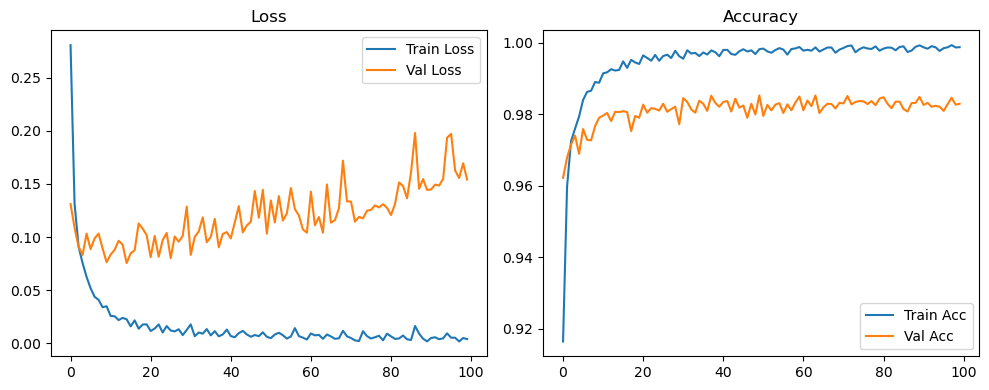

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2988, Acc: 0.9123 | Val Loss: 0.1530, Acc: 0.9560


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1502, Acc: 0.9541 | Val Loss: 0.1153, Acc: 0.9636


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1084, Acc: 0.9669 | Val Loss: 0.0963, Acc: 0.9715


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0935, Acc: 0.9705 | Val Loss: 0.0779, Acc: 0.9755


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0803, Acc: 0.9746 | Val Loss: 0.0971, Acc: 0.9731


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0713, Acc: 0.9770 | Val Loss: 0.0812, Acc: 0.9762


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9809 | Val Loss: 0.0939, Acc: 0.9723


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9824 | Val Loss: 0.0818, Acc: 0.9768


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9836 | Val Loss: 0.0882, Acc: 0.9764


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9853 | Val Loss: 0.0828, Acc: 0.9785


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9861 | Val Loss: 0.0790, Acc: 0.9794


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9867 | Val Loss: 0.0883, Acc: 0.9792


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9881 | Val Loss: 0.0873, Acc: 0.9792


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9892 | Val Loss: 0.0845, Acc: 0.9792


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9889 | Val Loss: 0.0865, Acc: 0.9797


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9906 | Val Loss: 0.0847, Acc: 0.9806


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9906 | Val Loss: 0.0935, Acc: 0.9818


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9908 | Val Loss: 0.0928, Acc: 0.9802


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9915 | Val Loss: 0.0772, Acc: 0.9823


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9919 | Val Loss: 0.0870, Acc: 0.9808


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9921 | Val Loss: 0.0973, Acc: 0.9803


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9921 | Val Loss: 0.0857, Acc: 0.9827


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9933 | Val Loss: 0.0842, Acc: 0.9830


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9928 | Val Loss: 0.0815, Acc: 0.9834


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9932 | Val Loss: 0.1081, Acc: 0.9792


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9934 | Val Loss: 0.0826, Acc: 0.9827


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.0873, Acc: 0.9810


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.1124, Acc: 0.9787


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9930 | Val Loss: 0.1141, Acc: 0.9807


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9936 | Val Loss: 0.1001, Acc: 0.9826


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.1026, Acc: 0.9814


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.0964, Acc: 0.9825


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9939 | Val Loss: 0.1067, Acc: 0.9819


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9945 | Val Loss: 0.1029, Acc: 0.9822


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9954 | Val Loss: 0.1040, Acc: 0.9818


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9947 | Val Loss: 0.1035, Acc: 0.9828


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1041, Acc: 0.9826


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9950 | Val Loss: 0.1033, Acc: 0.9826


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9952 | Val Loss: 0.1138, Acc: 0.9822


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9958 | Val Loss: 0.1130, Acc: 0.9810


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9951 | Val Loss: 0.1098, Acc: 0.9816


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9958 | Val Loss: 0.0943, Acc: 0.9852


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1043, Acc: 0.9826


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9960 | Val Loss: 0.1154, Acc: 0.9818


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9956 | Val Loss: 0.0951, Acc: 0.9838


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9959 | Val Loss: 0.1257, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9954 | Val Loss: 0.1137, Acc: 0.9835


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.1050, Acc: 0.9830


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9966 | Val Loss: 0.0935, Acc: 0.9851


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9957 | Val Loss: 0.1127, Acc: 0.9843


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9958 | Val Loss: 0.1204, Acc: 0.9822


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9962 | Val Loss: 0.1331, Acc: 0.9796


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9960 | Val Loss: 0.1094, Acc: 0.9838


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9961 | Val Loss: 0.1159, Acc: 0.9839


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9965 | Val Loss: 0.1143, Acc: 0.9830


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9960 | Val Loss: 0.1294, Acc: 0.9813


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9959 | Val Loss: 0.1042, Acc: 0.9836


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9970 | Val Loss: 0.1063, Acc: 0.9835


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1130, Acc: 0.9842


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9969 | Val Loss: 0.1091, Acc: 0.9844


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9958 | Val Loss: 0.1038, Acc: 0.9855


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9959 | Val Loss: 0.1274, Acc: 0.9852


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1099, Acc: 0.9857


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9972 | Val Loss: 0.1111, Acc: 0.9858


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9966 | Val Loss: 0.1226, Acc: 0.9825


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9964 | Val Loss: 0.1115, Acc: 0.9851


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9969 | Val Loss: 0.1088, Acc: 0.9838


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9968 | Val Loss: 0.1480, Acc: 0.9814


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9973 | Val Loss: 0.1188, Acc: 0.9834


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9975 | Val Loss: 0.1212, Acc: 0.9834


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9964 | Val Loss: 0.1578, Acc: 0.9831


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0174, Acc: 0.9961 | Val Loss: 0.1224, Acc: 0.9835


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9976 | Val Loss: 0.1123, Acc: 0.9849


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9975 | Val Loss: 0.1163, Acc: 0.9839


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9969 | Val Loss: 0.1249, Acc: 0.9833


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9966 | Val Loss: 0.1395, Acc: 0.9823


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9971 | Val Loss: 0.1233, Acc: 0.9852


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9979 | Val Loss: 0.1423, Acc: 0.9822


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9978 | Val Loss: 0.1225, Acc: 0.9855


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9969 | Val Loss: 0.1555, Acc: 0.9828


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9967 | Val Loss: 0.1324, Acc: 0.9844


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9973 | Val Loss: 0.1274, Acc: 0.9844


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9974 | Val Loss: 0.1184, Acc: 0.9844


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9978 | Val Loss: 0.1438, Acc: 0.9822


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9972 | Val Loss: 0.1501, Acc: 0.9844


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9971 | Val Loss: 0.1325, Acc: 0.9848


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9975 | Val Loss: 0.1637, Acc: 0.9818


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9971 | Val Loss: 0.1518, Acc: 0.9847


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9972 | Val Loss: 0.1514, Acc: 0.9822


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9975 | Val Loss: 0.1401, Acc: 0.9855


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9973 | Val Loss: 0.1599, Acc: 0.9851


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9976 | Val Loss: 0.1469, Acc: 0.9832


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9976 | Val Loss: 0.1414, Acc: 0.9847


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9979 | Val Loss: 0.1320, Acc: 0.9849


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9971 | Val Loss: 0.1398, Acc: 0.9854


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9978 | Val Loss: 0.1272, Acc: 0.9855


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9972 | Val Loss: 0.1289, Acc: 0.9842


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0125, Acc: 0.9971 | Val Loss: 0.1563, Acc: 0.9845


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9974 | Val Loss: 0.1505, Acc: 0.9849


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9977 | Val Loss: 0.1621, Acc: 0.9829


Final Test Loss: 0.1386 Accuracy: 0.9844


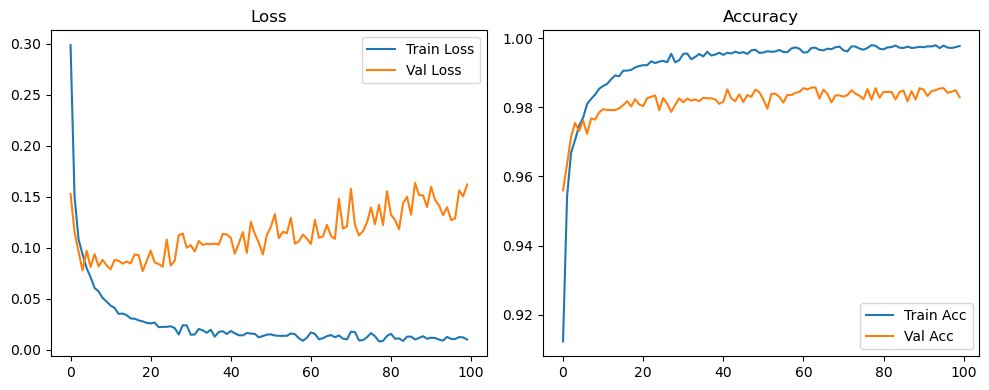

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3732, Acc: 0.8943 | Val Loss: 0.1578, Acc: 0.9524


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2092, Acc: 0.9383 | Val Loss: 0.1245, Acc: 0.9631


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1601, Acc: 0.9513 | Val Loss: 0.1064, Acc: 0.9682


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1374, Acc: 0.9588 | Val Loss: 0.0934, Acc: 0.9734


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1280, Acc: 0.9619 | Val Loss: 0.0989, Acc: 0.9710


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1274, Acc: 0.9614 | Val Loss: 0.0947, Acc: 0.9721


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1069, Acc: 0.9684 | Val Loss: 0.1046, Acc: 0.9705


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1014, Acc: 0.9692 | Val Loss: 0.0856, Acc: 0.9748


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0972, Acc: 0.9705 | Val Loss: 0.0850, Acc: 0.9785


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0939, Acc: 0.9711 | Val Loss: 0.0772, Acc: 0.9792


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0879, Acc: 0.9738 | Val Loss: 0.0794, Acc: 0.9773


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9742 | Val Loss: 0.0786, Acc: 0.9800


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0770, Acc: 0.9768 | Val Loss: 0.0808, Acc: 0.9799


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9780 | Val Loss: 0.0746, Acc: 0.9810


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9784 | Val Loss: 0.0808, Acc: 0.9806


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0731, Acc: 0.9787 | Val Loss: 0.0839, Acc: 0.9792


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9801 | Val Loss: 0.0781, Acc: 0.9822


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9817 | Val Loss: 0.0818, Acc: 0.9813


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9810 | Val Loss: 0.0814, Acc: 0.9816


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9825 | Val Loss: 0.0930, Acc: 0.9795


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9804 | Val Loss: 0.0783, Acc: 0.9830


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9823 | Val Loss: 0.0873, Acc: 0.9812


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9849 | Val Loss: 0.0863, Acc: 0.9824


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9839 | Val Loss: 0.0878, Acc: 0.9812


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9841 | Val Loss: 0.0719, Acc: 0.9833


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9853 | Val Loss: 0.0796, Acc: 0.9824


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9850 | Val Loss: 0.0773, Acc: 0.9842


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9852 | Val Loss: 0.0850, Acc: 0.9816


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9860 | Val Loss: 0.0843, Acc: 0.9832


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0547, Acc: 0.9856 | Val Loss: 0.0936, Acc: 0.9818


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9848 | Val Loss: 0.0954, Acc: 0.9824


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9881 | Val Loss: 0.0925, Acc: 0.9828


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9857 | Val Loss: 0.0970, Acc: 0.9844


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9866 | Val Loss: 0.1094, Acc: 0.9814


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9877 | Val Loss: 0.1053, Acc: 0.9825


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9881 | Val Loss: 0.0955, Acc: 0.9840


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9868 | Val Loss: 0.1003, Acc: 0.9838


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9889 | Val Loss: 0.0897, Acc: 0.9844


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9867 | Val Loss: 0.1096, Acc: 0.9821


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9881 | Val Loss: 0.0865, Acc: 0.9843


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9882 | Val Loss: 0.1372, Acc: 0.9776


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9884 | Val Loss: 0.1046, Acc: 0.9838


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9883 | Val Loss: 0.1020, Acc: 0.9841


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9890 | Val Loss: 0.1136, Acc: 0.9827


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9890 | Val Loss: 0.1066, Acc: 0.9810


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9891 | Val Loss: 0.1195, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9897 | Val Loss: 0.1060, Acc: 0.9829


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9892 | Val Loss: 0.1312, Acc: 0.9817


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9885 | Val Loss: 0.1368, Acc: 0.9816


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9892 | Val Loss: 0.1123, Acc: 0.9841


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0454, Acc: 0.9893 | Val Loss: 0.1112, Acc: 0.9827


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0449, Acc: 0.9897 | Val Loss: 0.1135, Acc: 0.9850


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9905 | Val Loss: 0.1229, Acc: 0.9831


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9892 | Val Loss: 0.1102, Acc: 0.9839


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9908 | Val Loss: 0.1136, Acc: 0.9833


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9906 | Val Loss: 0.1291, Acc: 0.9822


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9905 | Val Loss: 0.1205, Acc: 0.9843


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9900 | Val Loss: 0.1196, Acc: 0.9841


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9897 | Val Loss: 0.1216, Acc: 0.9841


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9908 | Val Loss: 0.1323, Acc: 0.9831


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9908 | Val Loss: 0.1295, Acc: 0.9839


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9910 | Val Loss: 0.1318, Acc: 0.9824


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9913 | Val Loss: 0.1330, Acc: 0.9843


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9910 | Val Loss: 0.1267, Acc: 0.9845


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9906 | Val Loss: 0.1275, Acc: 0.9852


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0415, Acc: 0.9916 | Val Loss: 0.1290, Acc: 0.9833


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0438, Acc: 0.9908 | Val Loss: 0.1279, Acc: 0.9846


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0437, Acc: 0.9907 | Val Loss: 0.1153, Acc: 0.9851


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9910 | Val Loss: 0.1397, Acc: 0.9822


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9915 | Val Loss: 0.1242, Acc: 0.9840


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9903 | Val Loss: 0.1603, Acc: 0.9822


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9917 | Val Loss: 0.1360, Acc: 0.9853


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0427, Acc: 0.9918 | Val Loss: 0.1230, Acc: 0.9850


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9927 | Val Loss: 0.1306, Acc: 0.9847


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9920 | Val Loss: 0.1315, Acc: 0.9854


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9919 | Val Loss: 0.1251, Acc: 0.9848


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9926 | Val Loss: 0.1334, Acc: 0.9851


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0370, Acc: 0.9928 | Val Loss: 0.1295, Acc: 0.9838


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9920 | Val Loss: 0.1386, Acc: 0.9846


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9921 | Val Loss: 0.1311, Acc: 0.9852


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9924 | Val Loss: 0.1316, Acc: 0.9852


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9919 | Val Loss: 0.1660, Acc: 0.9843


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9908 | Val Loss: 0.1547, Acc: 0.9838


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0406, Acc: 0.9923 | Val Loss: 0.1595, Acc: 0.9836


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9933 | Val Loss: 0.1572, Acc: 0.9844


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0395, Acc: 0.9926 | Val Loss: 0.1653, Acc: 0.9840


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9920 | Val Loss: 0.1571, Acc: 0.9846


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9922 | Val Loss: 0.1424, Acc: 0.9838


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9924 | Val Loss: 0.1571, Acc: 0.9850


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0371, Acc: 0.9927 | Val Loss: 0.1510, Acc: 0.9860


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9929 | Val Loss: 0.1520, Acc: 0.9840


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9925 | Val Loss: 0.1648, Acc: 0.9827


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9922 | Val Loss: 0.1875, Acc: 0.9826


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0367, Acc: 0.9930 | Val Loss: 0.1789, Acc: 0.9834


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0373, Acc: 0.9934 | Val Loss: 0.1741, Acc: 0.9835


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9925 | Val Loss: 0.1707, Acc: 0.9835


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9919 | Val Loss: 0.1714, Acc: 0.9849


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9928 | Val Loss: 0.1654, Acc: 0.9837


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9935 | Val Loss: 0.1620, Acc: 0.9832


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9935 | Val Loss: 0.1666, Acc: 0.9842


Final Test Loss: 0.1598 Accuracy: 0.9852


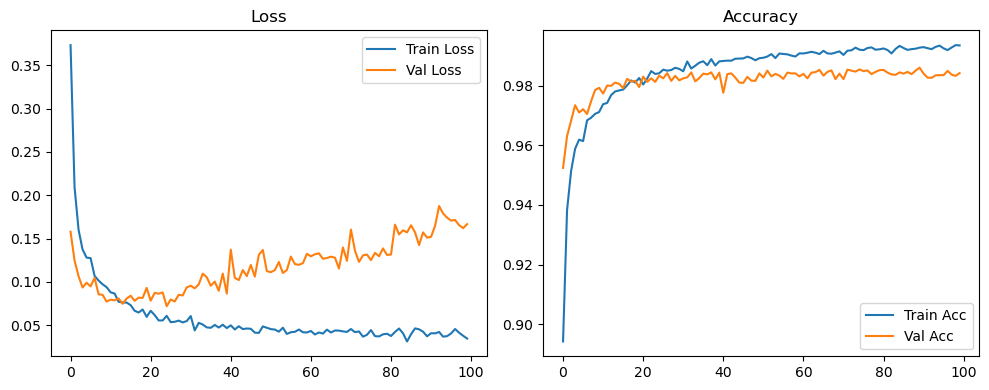

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2805, Acc: 0.9165 | Val Loss: 0.1311, Acc: 0.9623


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1317, Acc: 0.9598 | Val Loss: 0.1089, Acc: 0.9679


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0912, Acc: 0.9726 | Val Loss: 0.0911, Acc: 0.9716


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0756, Acc: 0.9760 | Val Loss: 0.0833, Acc: 0.9741


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9794 | Val Loss: 0.1033, Acc: 0.9690


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9841 | Val Loss: 0.0887, Acc: 0.9759


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9863 | Val Loss: 0.0988, Acc: 0.9729


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9866 | Val Loss: 0.1033, Acc: 0.9728


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9891 | Val Loss: 0.0893, Acc: 0.9768


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9889 | Val Loss: 0.0764, Acc: 0.9791


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.0836, Acc: 0.9797


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.0881, Acc: 0.9804


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.0966, Acc: 0.9782


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.0930, Acc: 0.9808


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0756, Acc: 0.9807


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.0848, Acc: 0.9809


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.0876, Acc: 0.9807


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.1129, Acc: 0.9753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9946 | Val Loss: 0.1080, Acc: 0.9796


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.1019, Acc: 0.9791


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.0812, Acc: 0.9828


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 0.1012, Acc: 0.9805


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9950 | Val Loss: 0.0815, Acc: 0.9818


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0972, Acc: 0.9816


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9950 | Val Loss: 0.1040, Acc: 0.9811


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.0803, Acc: 0.9830


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9967 | Val Loss: 0.1007, Acc: 0.9808


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0957, Acc: 0.9815


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.1012, Acc: 0.9822


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9963 | Val Loss: 0.1287, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9956 | Val Loss: 0.0833, Acc: 0.9846


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1002, Acc: 0.9835


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1054, Acc: 0.9814


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1187, Acc: 0.9805


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9963 | Val Loss: 0.0953, Acc: 0.9838


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1001, Acc: 0.9830


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9968 | Val Loss: 0.1172, Acc: 0.9810


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0904, Acc: 0.9852


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1030, Acc: 0.9832


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9963 | Val Loss: 0.1048, Acc: 0.9822


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.0988, Acc: 0.9835


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1139, Acc: 0.9838


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1292, Acc: 0.9808


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9967 | Val Loss: 0.1045, Acc: 0.9844


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.1109, Acc: 0.9819


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1145, Acc: 0.9825


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1434, Acc: 0.9791


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1182, Acc: 0.9830


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1445, Acc: 0.9800


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.1033, Acc: 0.9853


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0990, Acc: 0.9848


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0985, Acc: 0.9857


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1037, Acc: 0.9860


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1008, Acc: 0.9860


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1032, Acc: 0.9867


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1098, Acc: 0.9845


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1043, Acc: 0.9858


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1138, Acc: 0.9844


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1096, Acc: 0.9847


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1059, Acc: 0.9852


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0999, Acc: 0.9857


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1111, Acc: 0.9851


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1096, Acc: 0.9857


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1276, Acc: 0.9841


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1178, Acc: 0.9854


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1149, Acc: 0.9854


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1206, Acc: 0.9842


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1049, Acc: 0.9862


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1180, Acc: 0.9850


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1091, Acc: 0.9860


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1319, Acc: 0.9847


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1235, Acc: 0.9847


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1191, Acc: 0.9852


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1349, Acc: 0.9842


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1309, Acc: 0.9857


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1178, Acc: 0.9867


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1199, Acc: 0.9858


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1096, Acc: 0.9859


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1301, Acc: 0.9843


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1249, Acc: 0.9862


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1071, Acc: 0.9868


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1087, Acc: 0.9868


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1109, Acc: 0.9865


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1094, Acc: 0.9868


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1074, Acc: 0.9867


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1048, Acc: 0.9866


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1034, Acc: 0.9868


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1103, Acc: 0.9875


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1137, Acc: 0.9873


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1067, Acc: 0.9874


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1094, Acc: 0.9871


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1140, Acc: 0.9872


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1218, Acc: 0.9865


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.1185, Acc: 0.9862


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1320, Acc: 0.9857


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1223, Acc: 0.9861


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1221, Acc: 0.9869


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1233, Acc: 0.9867


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1223, Acc: 0.9864


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1180, Acc: 0.9868


Final Test Loss: 0.1154 Accuracy: 0.9878


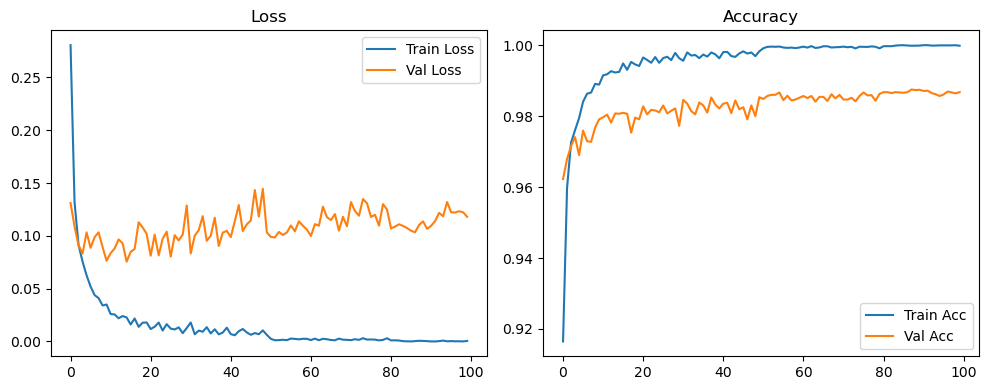

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2988, Acc: 0.9123 | Val Loss: 0.1530, Acc: 0.9560


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1502, Acc: 0.9541 | Val Loss: 0.1153, Acc: 0.9636


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1084, Acc: 0.9669 | Val Loss: 0.0963, Acc: 0.9715


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0935, Acc: 0.9705 | Val Loss: 0.0779, Acc: 0.9755


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0803, Acc: 0.9746 | Val Loss: 0.0971, Acc: 0.9731


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0713, Acc: 0.9770 | Val Loss: 0.0812, Acc: 0.9762


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9809 | Val Loss: 0.0939, Acc: 0.9723


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9824 | Val Loss: 0.0818, Acc: 0.9768


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9836 | Val Loss: 0.0882, Acc: 0.9764


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9853 | Val Loss: 0.0828, Acc: 0.9785


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9861 | Val Loss: 0.0790, Acc: 0.9794


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9867 | Val Loss: 0.0883, Acc: 0.9792


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9881 | Val Loss: 0.0873, Acc: 0.9792


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9892 | Val Loss: 0.0845, Acc: 0.9792


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9889 | Val Loss: 0.0865, Acc: 0.9797


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9906 | Val Loss: 0.0847, Acc: 0.9806


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9906 | Val Loss: 0.0935, Acc: 0.9818


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9908 | Val Loss: 0.0928, Acc: 0.9802


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9915 | Val Loss: 0.0772, Acc: 0.9823


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9919 | Val Loss: 0.0870, Acc: 0.9808


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9921 | Val Loss: 0.0973, Acc: 0.9803


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9921 | Val Loss: 0.0857, Acc: 0.9827


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9933 | Val Loss: 0.0842, Acc: 0.9830


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9928 | Val Loss: 0.0815, Acc: 0.9834


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9932 | Val Loss: 0.1081, Acc: 0.9792


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9934 | Val Loss: 0.0826, Acc: 0.9827


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.0873, Acc: 0.9810


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.1124, Acc: 0.9787


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9930 | Val Loss: 0.1141, Acc: 0.9807


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9936 | Val Loss: 0.1001, Acc: 0.9826


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.1026, Acc: 0.9814


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.0964, Acc: 0.9825


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9939 | Val Loss: 0.1067, Acc: 0.9819


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9945 | Val Loss: 0.1029, Acc: 0.9822


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9954 | Val Loss: 0.1040, Acc: 0.9818


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9947 | Val Loss: 0.1035, Acc: 0.9828


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1041, Acc: 0.9826


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9950 | Val Loss: 0.1033, Acc: 0.9826


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9952 | Val Loss: 0.1138, Acc: 0.9822


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9958 | Val Loss: 0.1130, Acc: 0.9810


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9951 | Val Loss: 0.1098, Acc: 0.9816


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9958 | Val Loss: 0.0943, Acc: 0.9852


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1043, Acc: 0.9826


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9960 | Val Loss: 0.1154, Acc: 0.9818


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9956 | Val Loss: 0.0951, Acc: 0.9838


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9959 | Val Loss: 0.1257, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9954 | Val Loss: 0.1137, Acc: 0.9835


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.1050, Acc: 0.9830


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9966 | Val Loss: 0.0935, Acc: 0.9851


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9957 | Val Loss: 0.1127, Acc: 0.9843


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.0911, Acc: 0.9859


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0861, Acc: 0.9857


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0940, Acc: 0.9855


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0984, Acc: 0.9866


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1085, Acc: 0.9852


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1114, Acc: 0.9852


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1014, Acc: 0.9866


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1042, Acc: 0.9850


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1020, Acc: 0.9862


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1085, Acc: 0.9854


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1099, Acc: 0.9856


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1100, Acc: 0.9850


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1046, Acc: 0.9862


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1032, Acc: 0.9864


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0974, Acc: 0.9863


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1002, Acc: 0.9849


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1095, Acc: 0.9854


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1068, Acc: 0.9855


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1091, Acc: 0.9848


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1118, Acc: 0.9852


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1151, Acc: 0.9844


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1142, Acc: 0.9851


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1267, Acc: 0.9842


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.1177, Acc: 0.9849


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1190, Acc: 0.9848


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9986 | Val Loss: 0.1168, Acc: 0.9847


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1155, Acc: 0.9855


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.1145, Acc: 0.9856


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1218, Acc: 0.9843


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.1111, Acc: 0.9852


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1040, Acc: 0.9859


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1044, Acc: 0.9864


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0993, Acc: 0.9860


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0977, Acc: 0.9862


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0988, Acc: 0.9863


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0992, Acc: 0.9857


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1013, Acc: 0.9853


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0988, Acc: 0.9858


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1070, Acc: 0.9855


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1105, Acc: 0.9860


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1050, Acc: 0.9867


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1065, Acc: 0.9861


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1054, Acc: 0.9866


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1048, Acc: 0.9868


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1071, Acc: 0.9866


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0994, Acc: 0.9877


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1021, Acc: 0.9876


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1088, Acc: 0.9864


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1141, Acc: 0.9854


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1075, Acc: 0.9860


Final Test Loss: 0.1083 Accuracy: 0.9867


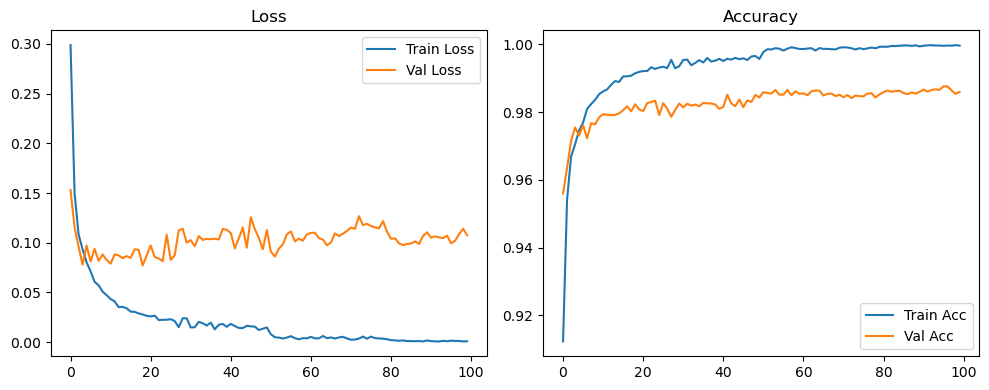

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3732, Acc: 0.8943 | Val Loss: 0.1578, Acc: 0.9524


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2092, Acc: 0.9383 | Val Loss: 0.1245, Acc: 0.9631


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1601, Acc: 0.9513 | Val Loss: 0.1064, Acc: 0.9682


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1374, Acc: 0.9588 | Val Loss: 0.0934, Acc: 0.9734


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1280, Acc: 0.9619 | Val Loss: 0.0989, Acc: 0.9710


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1274, Acc: 0.9614 | Val Loss: 0.0947, Acc: 0.9721


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1069, Acc: 0.9684 | Val Loss: 0.1046, Acc: 0.9705


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1014, Acc: 0.9692 | Val Loss: 0.0856, Acc: 0.9748


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0972, Acc: 0.9705 | Val Loss: 0.0850, Acc: 0.9785


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0939, Acc: 0.9711 | Val Loss: 0.0772, Acc: 0.9792


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0879, Acc: 0.9738 | Val Loss: 0.0794, Acc: 0.9773


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9742 | Val Loss: 0.0786, Acc: 0.9800


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0770, Acc: 0.9768 | Val Loss: 0.0808, Acc: 0.9799


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9780 | Val Loss: 0.0746, Acc: 0.9810


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9784 | Val Loss: 0.0808, Acc: 0.9806


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0731, Acc: 0.9787 | Val Loss: 0.0839, Acc: 0.9792


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9801 | Val Loss: 0.0781, Acc: 0.9822


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9817 | Val Loss: 0.0818, Acc: 0.9813


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9810 | Val Loss: 0.0814, Acc: 0.9816


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9825 | Val Loss: 0.0930, Acc: 0.9795


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9804 | Val Loss: 0.0783, Acc: 0.9830


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9823 | Val Loss: 0.0873, Acc: 0.9812


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9849 | Val Loss: 0.0863, Acc: 0.9824


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9839 | Val Loss: 0.0878, Acc: 0.9812


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9841 | Val Loss: 0.0719, Acc: 0.9833


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9853 | Val Loss: 0.0796, Acc: 0.9824


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9850 | Val Loss: 0.0773, Acc: 0.9842


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9852 | Val Loss: 0.0850, Acc: 0.9816


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9860 | Val Loss: 0.0843, Acc: 0.9832


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0547, Acc: 0.9856 | Val Loss: 0.0936, Acc: 0.9818


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9848 | Val Loss: 0.0954, Acc: 0.9824


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9881 | Val Loss: 0.0925, Acc: 0.9828


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9857 | Val Loss: 0.0970, Acc: 0.9844


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9866 | Val Loss: 0.1094, Acc: 0.9814


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9877 | Val Loss: 0.1053, Acc: 0.9825


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9881 | Val Loss: 0.0955, Acc: 0.9840


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9868 | Val Loss: 0.1003, Acc: 0.9838


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9889 | Val Loss: 0.0897, Acc: 0.9844


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9867 | Val Loss: 0.1096, Acc: 0.9821


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9881 | Val Loss: 0.0865, Acc: 0.9843


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9882 | Val Loss: 0.1372, Acc: 0.9776


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9884 | Val Loss: 0.1046, Acc: 0.9838


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9883 | Val Loss: 0.1020, Acc: 0.9841


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9890 | Val Loss: 0.1136, Acc: 0.9827


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9890 | Val Loss: 0.1066, Acc: 0.9810


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9891 | Val Loss: 0.1195, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9897 | Val Loss: 0.1060, Acc: 0.9829


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9892 | Val Loss: 0.1312, Acc: 0.9817


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9885 | Val Loss: 0.1368, Acc: 0.9816


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9892 | Val Loss: 0.1123, Acc: 0.9841


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9927 | Val Loss: 0.0973, Acc: 0.9849


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9934 | Val Loss: 0.0858, Acc: 0.9850


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9945 | Val Loss: 0.0894, Acc: 0.9848


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9949 | Val Loss: 0.0864, Acc: 0.9863


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9955 | Val Loss: 0.0945, Acc: 0.9852


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9948 | Val Loss: 0.0960, Acc: 0.9857


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9949 | Val Loss: 0.0878, Acc: 0.9862


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9954 | Val Loss: 0.0966, Acc: 0.9851


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9949 | Val Loss: 0.0911, Acc: 0.9860


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9953 | Val Loss: 0.0864, Acc: 0.9859


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9960 | Val Loss: 0.0901, Acc: 0.9859


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9960 | Val Loss: 0.0976, Acc: 0.9844


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9956 | Val Loss: 0.1024, Acc: 0.9848


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9958 | Val Loss: 0.1017, Acc: 0.9856


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9949 | Val Loss: 0.1032, Acc: 0.9835


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9960 | Val Loss: 0.1157, Acc: 0.9842


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9955 | Val Loss: 0.1015, Acc: 0.9866


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9955 | Val Loss: 0.0988, Acc: 0.9853


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9960 | Val Loss: 0.1005, Acc: 0.9859


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9959 | Val Loss: 0.1044, Acc: 0.9857


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9955 | Val Loss: 0.0978, Acc: 0.9868


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 0.1092, Acc: 0.9863


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9960 | Val Loss: 0.1028, Acc: 0.9866


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9958 | Val Loss: 0.1088, Acc: 0.9857


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9962 | Val Loss: 0.1188, Acc: 0.9844


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9961 | Val Loss: 0.1089, Acc: 0.9857


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9971 | Val Loss: 0.1025, Acc: 0.9865


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9961 | Val Loss: 0.1073, Acc: 0.9856


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9962 | Val Loss: 0.1086, Acc: 0.9862


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9965 | Val Loss: 0.1089, Acc: 0.9856


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9966 | Val Loss: 0.0971, Acc: 0.9863


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9974 | Val Loss: 0.0981, Acc: 0.9862


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9978 | Val Loss: 0.0953, Acc: 0.9865


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9980 | Val Loss: 0.0931, Acc: 0.9867


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0956, Acc: 0.9862


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0898, Acc: 0.9866


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0910, Acc: 0.9864


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0972, Acc: 0.9861


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0968, Acc: 0.9862


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0931, Acc: 0.9871


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9983 | Val Loss: 0.0917, Acc: 0.9868


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1004, Acc: 0.9865


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1016, Acc: 0.9870


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1087, Acc: 0.9863


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1040, Acc: 0.9872


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.0998, Acc: 0.9877


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0968, Acc: 0.9871


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1013, Acc: 0.9869


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0993, Acc: 0.9872


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9987 | Val Loss: 0.0989, Acc: 0.9862


Final Test Loss: 0.0942 Accuracy: 0.9882


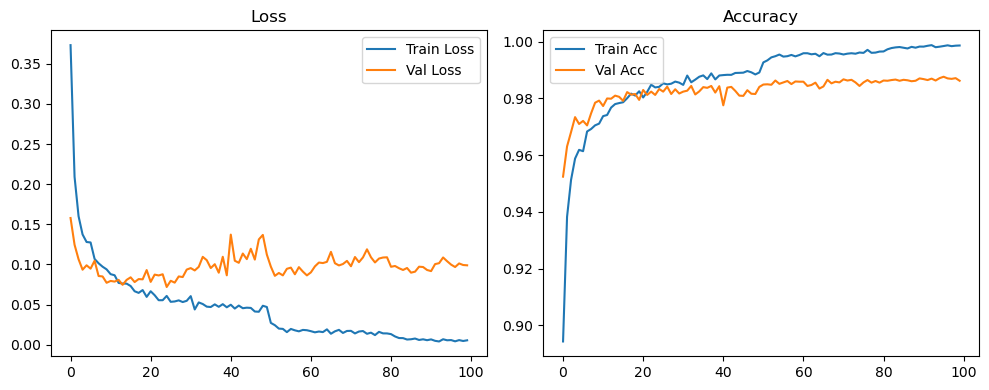

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2805, Acc: 0.9165 | Val Loss: 0.1311, Acc: 0.9623


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1317, Acc: 0.9598 | Val Loss: 0.1089, Acc: 0.9679


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0912, Acc: 0.9726 | Val Loss: 0.0911, Acc: 0.9716


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0756, Acc: 0.9760 | Val Loss: 0.0833, Acc: 0.9741


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9794 | Val Loss: 0.1033, Acc: 0.9690


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9841 | Val Loss: 0.0887, Acc: 0.9759


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9863 | Val Loss: 0.0988, Acc: 0.9729


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9866 | Val Loss: 0.1033, Acc: 0.9728


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9891 | Val Loss: 0.0893, Acc: 0.9768


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9889 | Val Loss: 0.0764, Acc: 0.9791


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.0836, Acc: 0.9797


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.0881, Acc: 0.9804


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.0966, Acc: 0.9782


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.0930, Acc: 0.9808


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0756, Acc: 0.9807


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.0848, Acc: 0.9809


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.0876, Acc: 0.9807


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.1129, Acc: 0.9753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9946 | Val Loss: 0.1080, Acc: 0.9796


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.1019, Acc: 0.9791


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.0812, Acc: 0.9828


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 0.1012, Acc: 0.9805


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9950 | Val Loss: 0.0815, Acc: 0.9818


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0972, Acc: 0.9816


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9950 | Val Loss: 0.1040, Acc: 0.9811


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.0803, Acc: 0.9830


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9967 | Val Loss: 0.1007, Acc: 0.9808


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0957, Acc: 0.9815


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.1012, Acc: 0.9822


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9963 | Val Loss: 0.1287, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9956 | Val Loss: 0.0833, Acc: 0.9846


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1002, Acc: 0.9835


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1054, Acc: 0.9814


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1187, Acc: 0.9805


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9963 | Val Loss: 0.0953, Acc: 0.9838


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1001, Acc: 0.9830


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9968 | Val Loss: 0.1172, Acc: 0.9810


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0904, Acc: 0.9852


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1030, Acc: 0.9832


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9963 | Val Loss: 0.1048, Acc: 0.9822


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.0988, Acc: 0.9835


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1139, Acc: 0.9838


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1292, Acc: 0.9808


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9967 | Val Loss: 0.1045, Acc: 0.9844


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.1109, Acc: 0.9819


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1145, Acc: 0.9825


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1434, Acc: 0.9791


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1182, Acc: 0.9830


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1445, Acc: 0.9800


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.1033, Acc: 0.9853


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0990, Acc: 0.9848


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0985, Acc: 0.9857


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1037, Acc: 0.9860


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1008, Acc: 0.9860


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1032, Acc: 0.9867


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1098, Acc: 0.9845


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1043, Acc: 0.9858


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1138, Acc: 0.9844


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1096, Acc: 0.9847


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1059, Acc: 0.9852


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0999, Acc: 0.9857


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1111, Acc: 0.9851


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1096, Acc: 0.9857


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1276, Acc: 0.9841


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1178, Acc: 0.9854


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1149, Acc: 0.9854


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1206, Acc: 0.9842


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1049, Acc: 0.9862


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1180, Acc: 0.9850


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1091, Acc: 0.9860


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1319, Acc: 0.9847


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1235, Acc: 0.9847


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1191, Acc: 0.9852


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1349, Acc: 0.9842


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1309, Acc: 0.9857


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1178, Acc: 0.9867


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1199, Acc: 0.9858


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1096, Acc: 0.9859


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1301, Acc: 0.9843


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1249, Acc: 0.9862


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1093, Acc: 0.9866


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1098, Acc: 0.9872


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1095, Acc: 0.9872


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1071, Acc: 0.9870


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1051, Acc: 0.9870


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1023, Acc: 0.9868


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1034, Acc: 0.9876


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1048, Acc: 0.9872


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1066, Acc: 0.9867


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1030, Acc: 0.9869


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1027, Acc: 0.9871


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1059, Acc: 0.9868


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1078, Acc: 0.9867


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1082, Acc: 0.9875


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1138, Acc: 0.9872


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1086, Acc: 0.9878


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1115, Acc: 0.9866


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1116, Acc: 0.9868


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1130, Acc: 0.9872


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1083, Acc: 0.9874


Final Test Loss: 0.1095 Accuracy: 0.9877


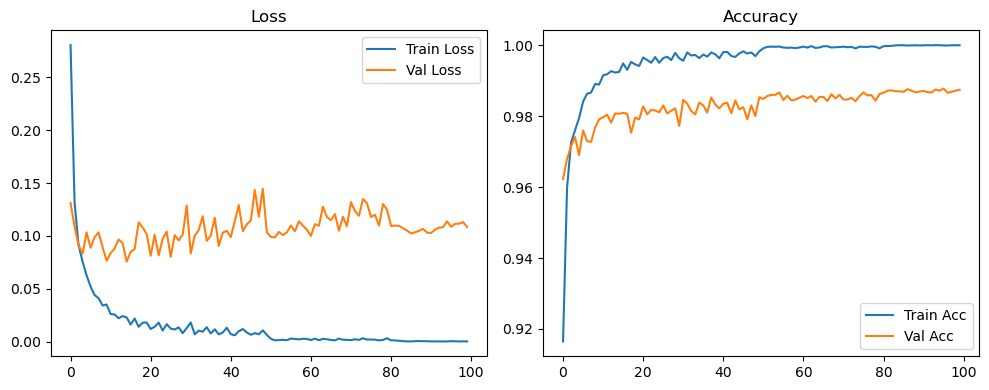

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2988, Acc: 0.9123 | Val Loss: 0.1530, Acc: 0.9560


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1502, Acc: 0.9541 | Val Loss: 0.1153, Acc: 0.9636


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1084, Acc: 0.9669 | Val Loss: 0.0963, Acc: 0.9715


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0935, Acc: 0.9705 | Val Loss: 0.0779, Acc: 0.9755


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0803, Acc: 0.9746 | Val Loss: 0.0971, Acc: 0.9731


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0713, Acc: 0.9770 | Val Loss: 0.0812, Acc: 0.9762


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9809 | Val Loss: 0.0939, Acc: 0.9723


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9824 | Val Loss: 0.0818, Acc: 0.9768


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9836 | Val Loss: 0.0882, Acc: 0.9764


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9853 | Val Loss: 0.0828, Acc: 0.9785


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9861 | Val Loss: 0.0790, Acc: 0.9794


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9867 | Val Loss: 0.0883, Acc: 0.9792


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9881 | Val Loss: 0.0873, Acc: 0.9792


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9892 | Val Loss: 0.0845, Acc: 0.9792


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9889 | Val Loss: 0.0865, Acc: 0.9797


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9906 | Val Loss: 0.0847, Acc: 0.9806


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9906 | Val Loss: 0.0935, Acc: 0.9818


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9908 | Val Loss: 0.0928, Acc: 0.9802


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9915 | Val Loss: 0.0772, Acc: 0.9823


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9919 | Val Loss: 0.0870, Acc: 0.9808


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9921 | Val Loss: 0.0973, Acc: 0.9803


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9921 | Val Loss: 0.0857, Acc: 0.9827


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9933 | Val Loss: 0.0842, Acc: 0.9830


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9928 | Val Loss: 0.0815, Acc: 0.9834


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9932 | Val Loss: 0.1081, Acc: 0.9792


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9934 | Val Loss: 0.0826, Acc: 0.9827


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.0873, Acc: 0.9810


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.1124, Acc: 0.9787


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9930 | Val Loss: 0.1141, Acc: 0.9807


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9936 | Val Loss: 0.1001, Acc: 0.9826


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.1026, Acc: 0.9814


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.0964, Acc: 0.9825


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9939 | Val Loss: 0.1067, Acc: 0.9819


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9945 | Val Loss: 0.1029, Acc: 0.9822


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9954 | Val Loss: 0.1040, Acc: 0.9818


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9947 | Val Loss: 0.1035, Acc: 0.9828


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1041, Acc: 0.9826


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9950 | Val Loss: 0.1033, Acc: 0.9826


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9952 | Val Loss: 0.1138, Acc: 0.9822


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9958 | Val Loss: 0.1130, Acc: 0.9810


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9951 | Val Loss: 0.1098, Acc: 0.9816


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9958 | Val Loss: 0.0943, Acc: 0.9852


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1043, Acc: 0.9826


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9960 | Val Loss: 0.1154, Acc: 0.9818


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9956 | Val Loss: 0.0951, Acc: 0.9838


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9959 | Val Loss: 0.1257, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9954 | Val Loss: 0.1137, Acc: 0.9835


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.1050, Acc: 0.9830


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9966 | Val Loss: 0.0935, Acc: 0.9851


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9957 | Val Loss: 0.1127, Acc: 0.9843


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9978 | Val Loss: 0.0911, Acc: 0.9859


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0861, Acc: 0.9857


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0940, Acc: 0.9855


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0984, Acc: 0.9866


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1085, Acc: 0.9852


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1114, Acc: 0.9852


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1014, Acc: 0.9866


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1042, Acc: 0.9850


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1020, Acc: 0.9862


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1085, Acc: 0.9854


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1099, Acc: 0.9856


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1100, Acc: 0.9850


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1046, Acc: 0.9862


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1032, Acc: 0.9864


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0974, Acc: 0.9863


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1002, Acc: 0.9849


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1095, Acc: 0.9854


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1068, Acc: 0.9855


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1091, Acc: 0.9848


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1118, Acc: 0.9852


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1151, Acc: 0.9844


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1142, Acc: 0.9851


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1267, Acc: 0.9842


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.1177, Acc: 0.9849


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1190, Acc: 0.9848


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9986 | Val Loss: 0.1168, Acc: 0.9847


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1155, Acc: 0.9855


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.1145, Acc: 0.9856


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1218, Acc: 0.9843


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.1111, Acc: 0.9852


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1017, Acc: 0.9865


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1017, Acc: 0.9865


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1002, Acc: 0.9860


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.0960, Acc: 0.9866


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0945, Acc: 0.9870


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0977, Acc: 0.9862


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0957, Acc: 0.9862


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0933, Acc: 0.9868


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0955, Acc: 0.9868


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1007, Acc: 0.9862


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0958, Acc: 0.9875


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0930, Acc: 0.9870


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0952, Acc: 0.9871


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0958, Acc: 0.9867


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0978, Acc: 0.9870


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0955, Acc: 0.9868


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0930, Acc: 0.9873


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0949, Acc: 0.9869


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0993, Acc: 0.9868


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0945, Acc: 0.9869


Final Test Loss: 0.0960 Accuracy: 0.9878


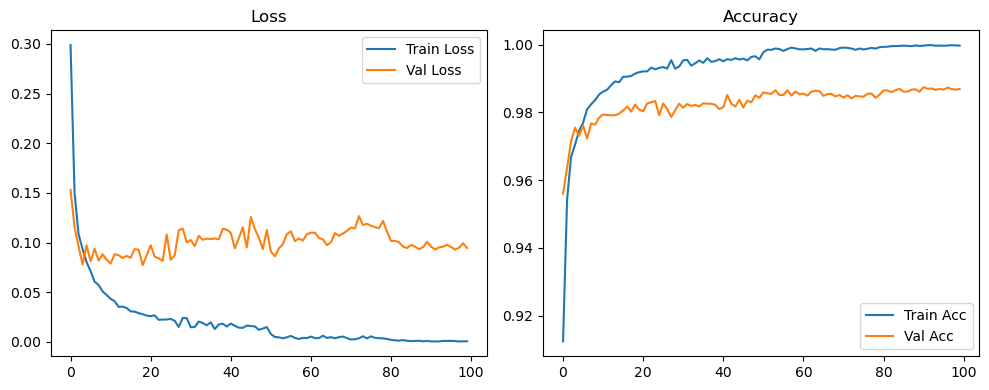

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3732, Acc: 0.8943 | Val Loss: 0.1578, Acc: 0.9524


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2092, Acc: 0.9383 | Val Loss: 0.1245, Acc: 0.9631


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1601, Acc: 0.9513 | Val Loss: 0.1064, Acc: 0.9682


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1374, Acc: 0.9588 | Val Loss: 0.0934, Acc: 0.9734


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1280, Acc: 0.9619 | Val Loss: 0.0989, Acc: 0.9710


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1274, Acc: 0.9614 | Val Loss: 0.0947, Acc: 0.9721


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1069, Acc: 0.9684 | Val Loss: 0.1046, Acc: 0.9705


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1014, Acc: 0.9692 | Val Loss: 0.0856, Acc: 0.9748


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0972, Acc: 0.9705 | Val Loss: 0.0850, Acc: 0.9785


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0939, Acc: 0.9711 | Val Loss: 0.0772, Acc: 0.9792


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0879, Acc: 0.9738 | Val Loss: 0.0794, Acc: 0.9773


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9742 | Val Loss: 0.0786, Acc: 0.9800


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0770, Acc: 0.9768 | Val Loss: 0.0808, Acc: 0.9799


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9780 | Val Loss: 0.0746, Acc: 0.9810


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9784 | Val Loss: 0.0808, Acc: 0.9806


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0731, Acc: 0.9787 | Val Loss: 0.0839, Acc: 0.9792


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9801 | Val Loss: 0.0781, Acc: 0.9822


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9817 | Val Loss: 0.0818, Acc: 0.9813


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9810 | Val Loss: 0.0814, Acc: 0.9816


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9825 | Val Loss: 0.0930, Acc: 0.9795


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9804 | Val Loss: 0.0783, Acc: 0.9830


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9823 | Val Loss: 0.0873, Acc: 0.9812


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9849 | Val Loss: 0.0863, Acc: 0.9824


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9839 | Val Loss: 0.0878, Acc: 0.9812


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9841 | Val Loss: 0.0719, Acc: 0.9833


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9853 | Val Loss: 0.0796, Acc: 0.9824


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9850 | Val Loss: 0.0773, Acc: 0.9842


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9852 | Val Loss: 0.0850, Acc: 0.9816


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9860 | Val Loss: 0.0843, Acc: 0.9832


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0547, Acc: 0.9856 | Val Loss: 0.0936, Acc: 0.9818


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9848 | Val Loss: 0.0954, Acc: 0.9824


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9881 | Val Loss: 0.0925, Acc: 0.9828


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9857 | Val Loss: 0.0970, Acc: 0.9844


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9866 | Val Loss: 0.1094, Acc: 0.9814


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9877 | Val Loss: 0.1053, Acc: 0.9825


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9881 | Val Loss: 0.0955, Acc: 0.9840


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9868 | Val Loss: 0.1003, Acc: 0.9838


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9889 | Val Loss: 0.0897, Acc: 0.9844


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9867 | Val Loss: 0.1096, Acc: 0.9821


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9881 | Val Loss: 0.0865, Acc: 0.9843


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9882 | Val Loss: 0.1372, Acc: 0.9776


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9884 | Val Loss: 0.1046, Acc: 0.9838


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9883 | Val Loss: 0.1020, Acc: 0.9841


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9890 | Val Loss: 0.1136, Acc: 0.9827


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9890 | Val Loss: 0.1066, Acc: 0.9810


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9891 | Val Loss: 0.1195, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9897 | Val Loss: 0.1060, Acc: 0.9829


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9892 | Val Loss: 0.1312, Acc: 0.9817


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9885 | Val Loss: 0.1368, Acc: 0.9816


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9892 | Val Loss: 0.1123, Acc: 0.9841


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9927 | Val Loss: 0.0973, Acc: 0.9849


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9934 | Val Loss: 0.0858, Acc: 0.9850


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9945 | Val Loss: 0.0894, Acc: 0.9848


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9949 | Val Loss: 0.0864, Acc: 0.9863


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9955 | Val Loss: 0.0945, Acc: 0.9852


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9948 | Val Loss: 0.0960, Acc: 0.9857


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9949 | Val Loss: 0.0878, Acc: 0.9862


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9954 | Val Loss: 0.0966, Acc: 0.9851


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9949 | Val Loss: 0.0911, Acc: 0.9860


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9953 | Val Loss: 0.0864, Acc: 0.9859


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9960 | Val Loss: 0.0901, Acc: 0.9859


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9960 | Val Loss: 0.0976, Acc: 0.9844


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9956 | Val Loss: 0.1024, Acc: 0.9848


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9958 | Val Loss: 0.1017, Acc: 0.9856


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9949 | Val Loss: 0.1032, Acc: 0.9835


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9960 | Val Loss: 0.1157, Acc: 0.9842


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9955 | Val Loss: 0.1015, Acc: 0.9866


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9955 | Val Loss: 0.0988, Acc: 0.9853


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9960 | Val Loss: 0.1005, Acc: 0.9859


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9959 | Val Loss: 0.1044, Acc: 0.9857


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9955 | Val Loss: 0.0978, Acc: 0.9868


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 0.1092, Acc: 0.9863


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9960 | Val Loss: 0.1028, Acc: 0.9866


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9958 | Val Loss: 0.1088, Acc: 0.9857


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9962 | Val Loss: 0.1188, Acc: 0.9844


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9961 | Val Loss: 0.1089, Acc: 0.9857


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9971 | Val Loss: 0.1025, Acc: 0.9865


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9961 | Val Loss: 0.1073, Acc: 0.9856


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9962 | Val Loss: 0.1086, Acc: 0.9862


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9965 | Val Loss: 0.1089, Acc: 0.9856


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9966 | Val Loss: 0.0991, Acc: 0.9862


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9972 | Val Loss: 0.1001, Acc: 0.9868


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9977 | Val Loss: 0.0953, Acc: 0.9863


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.0940, Acc: 0.9862


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.0924, Acc: 0.9865


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0902, Acc: 0.9865


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.0893, Acc: 0.9868


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0919, Acc: 0.9868


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0954, Acc: 0.9863


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0925, Acc: 0.9868


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0884, Acc: 0.9872


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0953, Acc: 0.9865


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0927, Acc: 0.9871


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.0964, Acc: 0.9862


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.0961, Acc: 0.9870


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0945, Acc: 0.9872


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0919, Acc: 0.9868


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0934, Acc: 0.9870


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0918, Acc: 0.9874


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0916, Acc: 0.9872


Final Test Loss: 0.0842 Accuracy: 0.9878


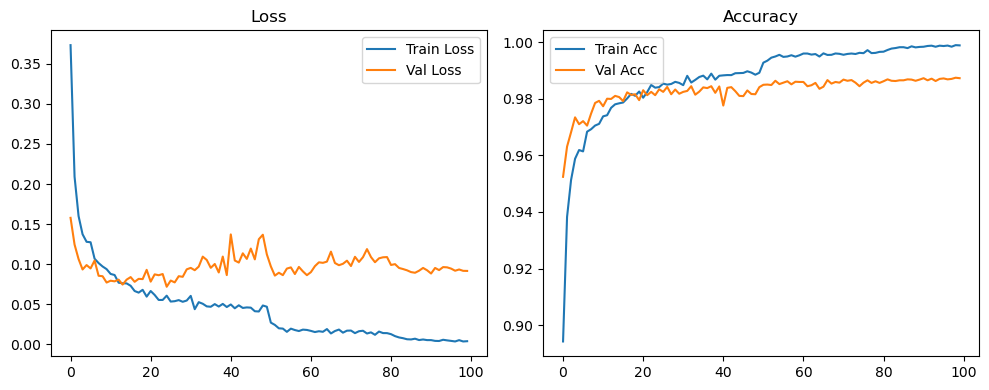

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2805, Acc: 0.9165 | Val Loss: 0.1311, Acc: 0.9623


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1317, Acc: 0.9598 | Val Loss: 0.1089, Acc: 0.9679


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0912, Acc: 0.9726 | Val Loss: 0.0911, Acc: 0.9716


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0756, Acc: 0.9760 | Val Loss: 0.0833, Acc: 0.9741


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0626, Acc: 0.9794 | Val Loss: 0.1033, Acc: 0.9690


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0520, Acc: 0.9841 | Val Loss: 0.0887, Acc: 0.9759


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9863 | Val Loss: 0.0988, Acc: 0.9729


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9866 | Val Loss: 0.1033, Acc: 0.9728


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9891 | Val Loss: 0.0893, Acc: 0.9768


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9889 | Val Loss: 0.0764, Acc: 0.9791


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9915 | Val Loss: 0.0836, Acc: 0.9797


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9918 | Val Loss: 0.0881, Acc: 0.9804


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.0966, Acc: 0.9782


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.0930, Acc: 0.9808


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0756, Acc: 0.9807


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.0848, Acc: 0.9809


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.0876, Acc: 0.9807


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.1129, Acc: 0.9753


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9946 | Val Loss: 0.1080, Acc: 0.9796


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.1019, Acc: 0.9791


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9965 | Val Loss: 0.0812, Acc: 0.9828


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9958 | Val Loss: 0.1012, Acc: 0.9805


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9950 | Val Loss: 0.0815, Acc: 0.9818


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0972, Acc: 0.9816


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9950 | Val Loss: 0.1040, Acc: 0.9811


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.0803, Acc: 0.9830


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9967 | Val Loss: 0.1007, Acc: 0.9808


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0957, Acc: 0.9815


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.1012, Acc: 0.9822


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9963 | Val Loss: 0.1287, Acc: 0.9772


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9956 | Val Loss: 0.0833, Acc: 0.9846


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1002, Acc: 0.9835


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9971 | Val Loss: 0.1054, Acc: 0.9814


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1187, Acc: 0.9805


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9963 | Val Loss: 0.0953, Acc: 0.9838


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1001, Acc: 0.9830


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9968 | Val Loss: 0.1172, Acc: 0.9810


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0904, Acc: 0.9852


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1030, Acc: 0.9832


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9963 | Val Loss: 0.1048, Acc: 0.9822


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.0988, Acc: 0.9835


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1139, Acc: 0.9838


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1292, Acc: 0.9808


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9967 | Val Loss: 0.1045, Acc: 0.9844


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.1109, Acc: 0.9819


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1145, Acc: 0.9825


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1434, Acc: 0.9791


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1182, Acc: 0.9830


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9969 | Val Loss: 0.1445, Acc: 0.9800


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9983 | Val Loss: 0.1033, Acc: 0.9853


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0974, Acc: 0.9860


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0951, Acc: 0.9866


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0915, Acc: 0.9869


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0923, Acc: 0.9878


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0958, Acc: 0.9872


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0973, Acc: 0.9868


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0928, Acc: 0.9881


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0965, Acc: 0.9868


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0973, Acc: 0.9871


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0998, Acc: 0.9864


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0994, Acc: 0.9863


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0958, Acc: 0.9883


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0988, Acc: 0.9875


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0981, Acc: 0.9878


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1017, Acc: 0.9871


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1010, Acc: 0.9867


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0982, Acc: 0.9865


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0996, Acc: 0.9873


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1005, Acc: 0.9872


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1095, Acc: 0.9872


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1047, Acc: 0.9865


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1079, Acc: 0.9869


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1106, Acc: 0.9852


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1116, Acc: 0.9862


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1110, Acc: 0.9864


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1134, Acc: 0.9857


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1126, Acc: 0.9869


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1106, Acc: 0.9862


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1094, Acc: 0.9862


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1226, Acc: 0.9855


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1056, Acc: 0.9867


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1088, Acc: 0.9860


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1102, Acc: 0.9868


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1146, Acc: 0.9861


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1132, Acc: 0.9867


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1116, Acc: 0.9870


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1203, Acc: 0.9868


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1195, Acc: 0.9869


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1231, Acc: 0.9872


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1192, Acc: 0.9869


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1202, Acc: 0.9862


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1199, Acc: 0.9861


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1265, Acc: 0.9868


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1258, Acc: 0.9866


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1288, Acc: 0.9864


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1221, Acc: 0.9870


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1252, Acc: 0.9862


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1251, Acc: 0.9862


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1292, Acc: 0.9862


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1215, Acc: 0.9861


Final Test Loss: 0.1187 Accuracy: 0.9856


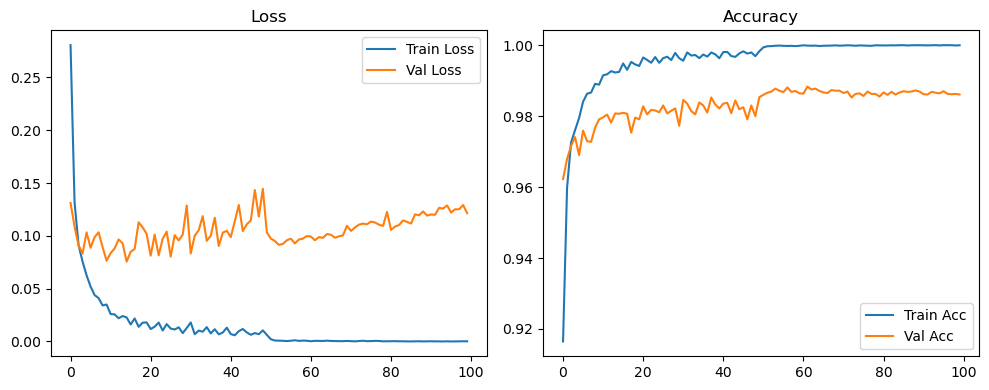

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2988, Acc: 0.9123 | Val Loss: 0.1530, Acc: 0.9560


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1502, Acc: 0.9541 | Val Loss: 0.1153, Acc: 0.9636


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1084, Acc: 0.9669 | Val Loss: 0.0963, Acc: 0.9715


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0935, Acc: 0.9705 | Val Loss: 0.0779, Acc: 0.9755


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0803, Acc: 0.9746 | Val Loss: 0.0971, Acc: 0.9731


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0713, Acc: 0.9770 | Val Loss: 0.0812, Acc: 0.9762


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0607, Acc: 0.9809 | Val Loss: 0.0939, Acc: 0.9723


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0572, Acc: 0.9824 | Val Loss: 0.0818, Acc: 0.9768


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0509, Acc: 0.9836 | Val Loss: 0.0882, Acc: 0.9764


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0473, Acc: 0.9853 | Val Loss: 0.0828, Acc: 0.9785


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0434, Acc: 0.9861 | Val Loss: 0.0790, Acc: 0.9794


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9867 | Val Loss: 0.0883, Acc: 0.9792


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9881 | Val Loss: 0.0873, Acc: 0.9792


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9892 | Val Loss: 0.0845, Acc: 0.9792


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0341, Acc: 0.9889 | Val Loss: 0.0865, Acc: 0.9797


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9906 | Val Loss: 0.0847, Acc: 0.9806


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9906 | Val Loss: 0.0935, Acc: 0.9818


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9908 | Val Loss: 0.0928, Acc: 0.9802


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9915 | Val Loss: 0.0772, Acc: 0.9823


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9919 | Val Loss: 0.0870, Acc: 0.9808


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9921 | Val Loss: 0.0973, Acc: 0.9803


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9921 | Val Loss: 0.0857, Acc: 0.9827


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9933 | Val Loss: 0.0842, Acc: 0.9830


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9928 | Val Loss: 0.0815, Acc: 0.9834


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9932 | Val Loss: 0.1081, Acc: 0.9792


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9934 | Val Loss: 0.0826, Acc: 0.9827


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9930 | Val Loss: 0.0873, Acc: 0.9810


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.1124, Acc: 0.9787


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9930 | Val Loss: 0.1141, Acc: 0.9807


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0240, Acc: 0.9936 | Val Loss: 0.1001, Acc: 0.9826


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9954 | Val Loss: 0.1026, Acc: 0.9814


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.0964, Acc: 0.9825


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9939 | Val Loss: 0.1067, Acc: 0.9819


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9945 | Val Loss: 0.1029, Acc: 0.9822


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9954 | Val Loss: 0.1040, Acc: 0.9818


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9947 | Val Loss: 0.1035, Acc: 0.9828


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.1041, Acc: 0.9826


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9950 | Val Loss: 0.1033, Acc: 0.9826


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9952 | Val Loss: 0.1138, Acc: 0.9822


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9958 | Val Loss: 0.1130, Acc: 0.9810


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9951 | Val Loss: 0.1098, Acc: 0.9816


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9958 | Val Loss: 0.0943, Acc: 0.9852


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1043, Acc: 0.9826


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9960 | Val Loss: 0.1154, Acc: 0.9818


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9956 | Val Loss: 0.0951, Acc: 0.9838


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9959 | Val Loss: 0.1257, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9954 | Val Loss: 0.1137, Acc: 0.9835


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.1050, Acc: 0.9830


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9966 | Val Loss: 0.0935, Acc: 0.9851


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9957 | Val Loss: 0.1127, Acc: 0.9843


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0906, Acc: 0.9860


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.0859, Acc: 0.9864


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0864, Acc: 0.9860


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0873, Acc: 0.9861


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9991 | Val Loss: 0.0852, Acc: 0.9865


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0896, Acc: 0.9863


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0866, Acc: 0.9867


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0911, Acc: 0.9864


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0876, Acc: 0.9863


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0894, Acc: 0.9864


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0933, Acc: 0.9855


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0888, Acc: 0.9867


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0924, Acc: 0.9870


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0970, Acc: 0.9865


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0915, Acc: 0.9865


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0909, Acc: 0.9868


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0966, Acc: 0.9861


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0909, Acc: 0.9866


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0933, Acc: 0.9861


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0952, Acc: 0.9852


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1007, Acc: 0.9861


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1016, Acc: 0.9865


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0989, Acc: 0.9867


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1007, Acc: 0.9863


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1021, Acc: 0.9865


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0957, Acc: 0.9872


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1024, Acc: 0.9861


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0981, Acc: 0.9866


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0989, Acc: 0.9871


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1027, Acc: 0.9863


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1007, Acc: 0.9869


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1010, Acc: 0.9872


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1016, Acc: 0.9868


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1003, Acc: 0.9862


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0950, Acc: 0.9875


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0946, Acc: 0.9873


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0940, Acc: 0.9875


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0977, Acc: 0.9867


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0970, Acc: 0.9875


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0931, Acc: 0.9881


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0944, Acc: 0.9872


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0951, Acc: 0.9879


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0970, Acc: 0.9878


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0981, Acc: 0.9877


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1051, Acc: 0.9868


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1011, Acc: 0.9872


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0990, Acc: 0.9871


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0989, Acc: 0.9873


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1026, Acc: 0.9869


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0983, Acc: 0.9873


Final Test Loss: 0.1029 Accuracy: 0.9859


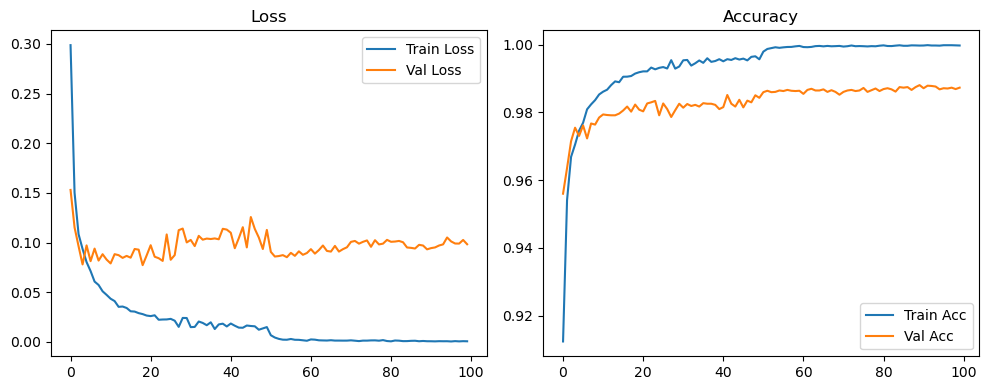

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3732, Acc: 0.8943 | Val Loss: 0.1578, Acc: 0.9524


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2092, Acc: 0.9383 | Val Loss: 0.1245, Acc: 0.9631


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1601, Acc: 0.9513 | Val Loss: 0.1064, Acc: 0.9682


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1374, Acc: 0.9588 | Val Loss: 0.0934, Acc: 0.9734


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1280, Acc: 0.9619 | Val Loss: 0.0989, Acc: 0.9710


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1274, Acc: 0.9614 | Val Loss: 0.0947, Acc: 0.9721


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1069, Acc: 0.9684 | Val Loss: 0.1046, Acc: 0.9705


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1014, Acc: 0.9692 | Val Loss: 0.0856, Acc: 0.9748


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0972, Acc: 0.9705 | Val Loss: 0.0850, Acc: 0.9785


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0939, Acc: 0.9711 | Val Loss: 0.0772, Acc: 0.9792


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0879, Acc: 0.9738 | Val Loss: 0.0794, Acc: 0.9773


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0865, Acc: 0.9742 | Val Loss: 0.0786, Acc: 0.9800


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0770, Acc: 0.9768 | Val Loss: 0.0808, Acc: 0.9799


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0762, Acc: 0.9780 | Val Loss: 0.0746, Acc: 0.9810


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0761, Acc: 0.9784 | Val Loss: 0.0808, Acc: 0.9806


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0731, Acc: 0.9787 | Val Loss: 0.0839, Acc: 0.9792


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9801 | Val Loss: 0.0781, Acc: 0.9822


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0646, Acc: 0.9817 | Val Loss: 0.0818, Acc: 0.9813


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0681, Acc: 0.9810 | Val Loss: 0.0814, Acc: 0.9816


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9825 | Val Loss: 0.0930, Acc: 0.9795


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9804 | Val Loss: 0.0783, Acc: 0.9830


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0616, Acc: 0.9823 | Val Loss: 0.0873, Acc: 0.9812


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9849 | Val Loss: 0.0863, Acc: 0.9824


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0554, Acc: 0.9839 | Val Loss: 0.0878, Acc: 0.9812


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0608, Acc: 0.9841 | Val Loss: 0.0719, Acc: 0.9833


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9853 | Val Loss: 0.0796, Acc: 0.9824


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0539, Acc: 0.9850 | Val Loss: 0.0773, Acc: 0.9842


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0552, Acc: 0.9852 | Val Loss: 0.0850, Acc: 0.9816


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0531, Acc: 0.9860 | Val Loss: 0.0843, Acc: 0.9832


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0547, Acc: 0.9856 | Val Loss: 0.0936, Acc: 0.9818


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0605, Acc: 0.9848 | Val Loss: 0.0954, Acc: 0.9824


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0439, Acc: 0.9881 | Val Loss: 0.0925, Acc: 0.9828


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9857 | Val Loss: 0.0970, Acc: 0.9844


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9866 | Val Loss: 0.1094, Acc: 0.9814


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9877 | Val Loss: 0.1053, Acc: 0.9825


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0469, Acc: 0.9881 | Val Loss: 0.0955, Acc: 0.9840


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0502, Acc: 0.9868 | Val Loss: 0.1003, Acc: 0.9838


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0472, Acc: 0.9889 | Val Loss: 0.0897, Acc: 0.9844


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0505, Acc: 0.9867 | Val Loss: 0.1096, Acc: 0.9821


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0466, Acc: 0.9881 | Val Loss: 0.0865, Acc: 0.9843


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9882 | Val Loss: 0.1372, Acc: 0.9776


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9884 | Val Loss: 0.1046, Acc: 0.9838


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0488, Acc: 0.9883 | Val Loss: 0.1020, Acc: 0.9841


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9890 | Val Loss: 0.1136, Acc: 0.9827


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9890 | Val Loss: 0.1066, Acc: 0.9810


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9891 | Val Loss: 0.1195, Acc: 0.9809


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0414, Acc: 0.9897 | Val Loss: 0.1060, Acc: 0.9829


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0410, Acc: 0.9892 | Val Loss: 0.1312, Acc: 0.9817


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0485, Acc: 0.9885 | Val Loss: 0.1368, Acc: 0.9816


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0470, Acc: 0.9892 | Val Loss: 0.1123, Acc: 0.9841


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9932 | Val Loss: 0.0946, Acc: 0.9855


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9942 | Val Loss: 0.0842, Acc: 0.9852


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9951 | Val Loss: 0.0809, Acc: 0.9858


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9955 | Val Loss: 0.0800, Acc: 0.9863


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0820, Acc: 0.9863


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9964 | Val Loss: 0.0818, Acc: 0.9862


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9960 | Val Loss: 0.0817, Acc: 0.9855


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0814, Acc: 0.9861


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9965 | Val Loss: 0.0791, Acc: 0.9858


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.0757, Acc: 0.9868


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0798, Acc: 0.9864


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0815, Acc: 0.9858


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.0803, Acc: 0.9861


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9974 | Val Loss: 0.0800, Acc: 0.9863


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0831, Acc: 0.9862


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0838, Acc: 0.9858


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.0831, Acc: 0.9872


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.0827, Acc: 0.9867


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0781, Acc: 0.9868


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.0822, Acc: 0.9873


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.0798, Acc: 0.9873


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.0822, Acc: 0.9871


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0833, Acc: 0.9869


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0804, Acc: 0.9868


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0872, Acc: 0.9868


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0836, Acc: 0.9871


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.0828, Acc: 0.9872


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.0841, Acc: 0.9864


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.0869, Acc: 0.9868


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0825, Acc: 0.9863


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0801, Acc: 0.9868


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0817, Acc: 0.9872


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.0833, Acc: 0.9872


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0805, Acc: 0.9865


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0815, Acc: 0.9872


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0804, Acc: 0.9873


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0801, Acc: 0.9873


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.0828, Acc: 0.9870


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0851, Acc: 0.9862


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0854, Acc: 0.9870


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0833, Acc: 0.9868


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0866, Acc: 0.9870


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.0851, Acc: 0.9864


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0882, Acc: 0.9867


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0880, Acc: 0.9870


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0891, Acc: 0.9865


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0861, Acc: 0.9875


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0878, Acc: 0.9878


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0870, Acc: 0.9876


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0877, Acc: 0.9870


Final Test Loss: 0.0845 Accuracy: 0.9882


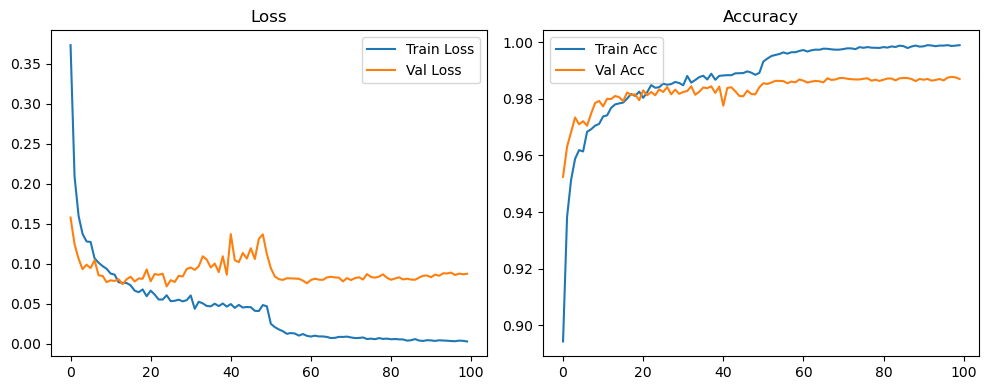

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2616, Acc: 0.9207 | Val Loss: 0.1476, Acc: 0.9559


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1306, Acc: 0.9593 | Val Loss: 0.1066, Acc: 0.9663


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0904, Acc: 0.9722 | Val Loss: 0.1006, Acc: 0.9705


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0742, Acc: 0.9761 | Val Loss: 0.0892, Acc: 0.9741


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0611, Acc: 0.9794 | Val Loss: 0.1072, Acc: 0.9689


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9830 | Val Loss: 0.0794, Acc: 0.9777


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9867 | Val Loss: 0.0928, Acc: 0.9745


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9872 | Val Loss: 0.0740, Acc: 0.9803


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9894 | Val Loss: 0.0897, Acc: 0.9766


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9906 | Val Loss: 0.0825, Acc: 0.9771


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.0717, Acc: 0.9815


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.0826, Acc: 0.9804


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9934 | Val Loss: 0.0801, Acc: 0.9811


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0831, Acc: 0.9800


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.0778, Acc: 0.9809


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.0767, Acc: 0.9823


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 0.0761, Acc: 0.9829


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.0829, Acc: 0.9810


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9954 | Val Loss: 0.0835, Acc: 0.9818


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.1031, Acc: 0.9772


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.0833, Acc: 0.9813


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0769, Acc: 0.9818


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.0850, Acc: 0.9818


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.0760, Acc: 0.9844


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0846, Acc: 0.9812


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0974, Acc: 0.9803


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0866, Acc: 0.9829


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0947, Acc: 0.9799


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0853, Acc: 0.9833


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.0816, Acc: 0.9844


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0969, Acc: 0.9808


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0913, Acc: 0.9823


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0968, Acc: 0.9805


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0928, Acc: 0.9822


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.0814, Acc: 0.9837


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0813, Acc: 0.9842


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0844, Acc: 0.9836


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0828, Acc: 0.9841


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0795, Acc: 0.9846


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0813, Acc: 0.9840


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0878, Acc: 0.9848


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0844, Acc: 0.9833


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0945, Acc: 0.9842


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0805, Acc: 0.9832


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0791, Acc: 0.9852


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1030, Acc: 0.9814


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0926, Acc: 0.9838


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0971, Acc: 0.9835


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0934, Acc: 0.9844


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0820, Acc: 0.9840


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0831, Acc: 0.9849


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0893, Acc: 0.9834


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0927, Acc: 0.9855


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9982 | Val Loss: 0.1013, Acc: 0.9821


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1062, Acc: 0.9838


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.0928, Acc: 0.9843


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0867, Acc: 0.9848


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0944, Acc: 0.9846


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0926, Acc: 0.9848


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0858, Acc: 0.9858


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0923, Acc: 0.9842


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.0902, Acc: 0.9851


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0936, Acc: 0.9856


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0896, Acc: 0.9845


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.0993, Acc: 0.9839


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0970, Acc: 0.9853


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1178, Acc: 0.9816


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1065, Acc: 0.9839


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0945, Acc: 0.9842


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1033, Acc: 0.9831


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1043, Acc: 0.9848


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1099, Acc: 0.9824


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1087, Acc: 0.9841


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1147, Acc: 0.9838


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1219, Acc: 0.9825


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1089, Acc: 0.9845


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1116, Acc: 0.9834


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0866, Acc: 0.9862


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1033, Acc: 0.9846


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.0979, Acc: 0.9844


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1025, Acc: 0.9848


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9990 | Val Loss: 0.1061, Acc: 0.9848


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.0899, Acc: 0.9864


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0852, Acc: 0.9863


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1006, Acc: 0.9839


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1050, Acc: 0.9842


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0954, Acc: 0.9859


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9992 | Val Loss: 0.1084, Acc: 0.9840


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0989, Acc: 0.9845


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0918, Acc: 0.9857


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1145, Acc: 0.9830


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0989, Acc: 0.9838


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1092, Acc: 0.9834


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1136, Acc: 0.9842


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1101, Acc: 0.9838


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.0960, Acc: 0.9853


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1024, Acc: 0.9842


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1027, Acc: 0.9847


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1110, Acc: 0.9844


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0982, Acc: 0.9860


Final Test Loss: 0.1091 Accuracy: 0.9850


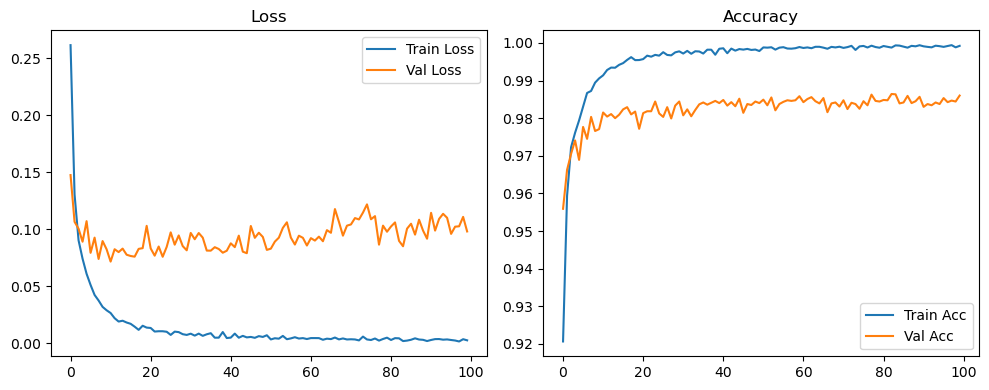

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2772, Acc: 0.9150 | Val Loss: 0.1493, Acc: 0.9567


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1481, Acc: 0.9549 | Val Loss: 0.1259, Acc: 0.9605


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1082, Acc: 0.9664 | Val Loss: 0.0868, Acc: 0.9740


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0902, Acc: 0.9715 | Val Loss: 0.0822, Acc: 0.9747


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0755, Acc: 0.9766 | Val Loss: 0.0862, Acc: 0.9742


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0662, Acc: 0.9787 | Val Loss: 0.0802, Acc: 0.9775


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9818 | Val Loss: 0.0938, Acc: 0.9710


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9835 | Val Loss: 0.0785, Acc: 0.9779


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9857 | Val Loss: 0.0906, Acc: 0.9752


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9873 | Val Loss: 0.0749, Acc: 0.9798


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9874 | Val Loss: 0.0691, Acc: 0.9813


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.0708, Acc: 0.9814


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.0807, Acc: 0.9808


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9899 | Val Loss: 0.0661, Acc: 0.9833


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9910 | Val Loss: 0.0879, Acc: 0.9792


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.0855, Acc: 0.9807


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.0761, Acc: 0.9823


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.0777, Acc: 0.9823


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0814, Acc: 0.9811


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9936 | Val Loss: 0.0861, Acc: 0.9807


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0805, Acc: 0.9828


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0890, Acc: 0.9807


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.0905, Acc: 0.9809


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0789, Acc: 0.9832


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.0748, Acc: 0.9828


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9957 | Val Loss: 0.0809, Acc: 0.9827


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.0851, Acc: 0.9798


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0911, Acc: 0.9826


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.0809, Acc: 0.9828


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.0943, Acc: 0.9816


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9954 | Val Loss: 0.0917, Acc: 0.9818


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1030, Acc: 0.9820


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9959 | Val Loss: 0.0961, Acc: 0.9815


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0931, Acc: 0.9836


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.1000, Acc: 0.9818


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.0864, Acc: 0.9831


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.0948, Acc: 0.9841


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9965 | Val Loss: 0.0883, Acc: 0.9844


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.0925, Acc: 0.9830


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0828, Acc: 0.9847


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0982, Acc: 0.9830


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.0899, Acc: 0.9839


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.0923, Acc: 0.9832


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.0849, Acc: 0.9842


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0829, Acc: 0.9847


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1103, Acc: 0.9811


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.0901, Acc: 0.9845


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0974, Acc: 0.9841


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.0956, Acc: 0.9842


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0825, Acc: 0.9842


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.0862, Acc: 0.9847


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0978, Acc: 0.9828


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.0907, Acc: 0.9837


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0912, Acc: 0.9842


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0999, Acc: 0.9822


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1107, Acc: 0.9822


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1053, Acc: 0.9839


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1020, Acc: 0.9840


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0988, Acc: 0.9847


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1097, Acc: 0.9812


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.1054, Acc: 0.9832


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.0866, Acc: 0.9848


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0882, Acc: 0.9851


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9983 | Val Loss: 0.0985, Acc: 0.9842


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1017, Acc: 0.9843


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1044, Acc: 0.9831


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.0964, Acc: 0.9845


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1099, Acc: 0.9823


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1062, Acc: 0.9824


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1073, Acc: 0.9828


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1046, Acc: 0.9832


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0986, Acc: 0.9839


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1003, Acc: 0.9852


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1113, Acc: 0.9838


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1097, Acc: 0.9838


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.0945, Acc: 0.9840


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1101, Acc: 0.9838


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9979 | Val Loss: 0.0994, Acc: 0.9845


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1007, Acc: 0.9841


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1085, Acc: 0.9829


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9978 | Val Loss: 0.1030, Acc: 0.9846


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1104, Acc: 0.9840


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9983 | Val Loss: 0.1066, Acc: 0.9843


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1033, Acc: 0.9846


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1093, Acc: 0.9842


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.1224, Acc: 0.9832


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.0995, Acc: 0.9844


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1301, Acc: 0.9814


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1237, Acc: 0.9823


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1145, Acc: 0.9836


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1062, Acc: 0.9839


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.1173, Acc: 0.9830


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9986 | Val Loss: 0.1235, Acc: 0.9828


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1185, Acc: 0.9841


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9981 | Val Loss: 0.1041, Acc: 0.9848


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1033, Acc: 0.9858


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0993, Acc: 0.9862


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1144, Acc: 0.9848


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9984 | Val Loss: 0.1146, Acc: 0.9849


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1119, Acc: 0.9854


Final Test Loss: 0.1066 Accuracy: 0.9867


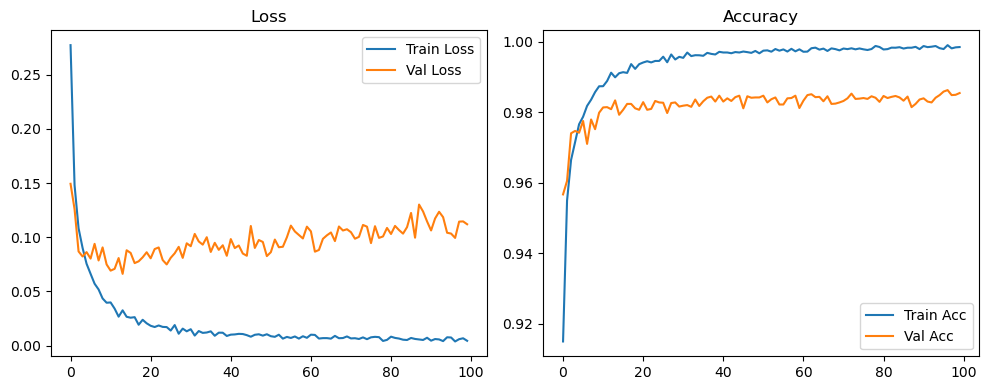

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3334, Acc: 0.9003 | Val Loss: 0.1682, Acc: 0.9504


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1987, Acc: 0.9397 | Val Loss: 0.1374, Acc: 0.9573


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1552, Acc: 0.9522 | Val Loss: 0.0962, Acc: 0.9695


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1334, Acc: 0.9585 | Val Loss: 0.0883, Acc: 0.9737


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1200, Acc: 0.9628 | Val Loss: 0.0949, Acc: 0.9714


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1090, Acc: 0.9656 | Val Loss: 0.0784, Acc: 0.9772


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1002, Acc: 0.9692 | Val Loss: 0.0834, Acc: 0.9741


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0891, Acc: 0.9716 | Val Loss: 0.0795, Acc: 0.9775


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0799, Acc: 0.9742 | Val Loss: 0.0784, Acc: 0.9780


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0790, Acc: 0.9748 | Val Loss: 0.0687, Acc: 0.9800


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0729, Acc: 0.9776 | Val Loss: 0.0717, Acc: 0.9801


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0670, Acc: 0.9786 | Val Loss: 0.0729, Acc: 0.9791


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9811 | Val Loss: 0.0703, Acc: 0.9818


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0603, Acc: 0.9799 | Val Loss: 0.0667, Acc: 0.9808


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0592, Acc: 0.9817 | Val Loss: 0.0644, Acc: 0.9821


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9828 | Val Loss: 0.0769, Acc: 0.9782


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9827 | Val Loss: 0.0719, Acc: 0.9814


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9841 | Val Loss: 0.0694, Acc: 0.9816


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9855 | Val Loss: 0.0701, Acc: 0.9802


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9849 | Val Loss: 0.0704, Acc: 0.9826


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9864 | Val Loss: 0.0761, Acc: 0.9807


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9867 | Val Loss: 0.0770, Acc: 0.9812


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9876 | Val Loss: 0.0785, Acc: 0.9803


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9870 | Val Loss: 0.0723, Acc: 0.9818


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9879 | Val Loss: 0.0754, Acc: 0.9820


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9885 | Val Loss: 0.0717, Acc: 0.9822


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9879 | Val Loss: 0.0738, Acc: 0.9821


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9887 | Val Loss: 0.0693, Acc: 0.9850


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9894 | Val Loss: 0.0722, Acc: 0.9842


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9891 | Val Loss: 0.0718, Acc: 0.9838


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9884 | Val Loss: 0.0722, Acc: 0.9842


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9912 | Val Loss: 0.0776, Acc: 0.9828


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9906 | Val Loss: 0.0763, Acc: 0.9838


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9899 | Val Loss: 0.0740, Acc: 0.9832


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9910 | Val Loss: 0.0757, Acc: 0.9828


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9908 | Val Loss: 0.0822, Acc: 0.9837


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9909 | Val Loss: 0.0750, Acc: 0.9846


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9905 | Val Loss: 0.0745, Acc: 0.9841


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.0793, Acc: 0.9838


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9914 | Val Loss: 0.0805, Acc: 0.9850


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9920 | Val Loss: 0.0833, Acc: 0.9842


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9916 | Val Loss: 0.0735, Acc: 0.9855


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9918 | Val Loss: 0.0863, Acc: 0.9837


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9919 | Val Loss: 0.0773, Acc: 0.9832


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9917 | Val Loss: 0.0791, Acc: 0.9842


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9911 | Val Loss: 0.0918, Acc: 0.9815


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9921 | Val Loss: 0.0793, Acc: 0.9843


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9929 | Val Loss: 0.0777, Acc: 0.9850


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9927 | Val Loss: 0.0834, Acc: 0.9848


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9924 | Val Loss: 0.0747, Acc: 0.9849


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9924 | Val Loss: 0.0781, Acc: 0.9847


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9932 | Val Loss: 0.0866, Acc: 0.9842


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9932 | Val Loss: 0.0842, Acc: 0.9845


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9923 | Val Loss: 0.0868, Acc: 0.9846


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9935 | Val Loss: 0.0831, Acc: 0.9845


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9929 | Val Loss: 0.0773, Acc: 0.9848


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9926 | Val Loss: 0.0812, Acc: 0.9852


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9931 | Val Loss: 0.0894, Acc: 0.9844


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9933 | Val Loss: 0.0934, Acc: 0.9845


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9928 | Val Loss: 0.0813, Acc: 0.9848


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9938 | Val Loss: 0.0911, Acc: 0.9840


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9940 | Val Loss: 0.0851, Acc: 0.9862


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9943 | Val Loss: 0.0883, Acc: 0.9862


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9940 | Val Loss: 0.0879, Acc: 0.9846


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9934 | Val Loss: 0.0866, Acc: 0.9838


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9944 | Val Loss: 0.0896, Acc: 0.9848


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9942 | Val Loss: 0.0861, Acc: 0.9852


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9936 | Val Loss: 0.0870, Acc: 0.9857


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9942 | Val Loss: 0.0855, Acc: 0.9844


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9943 | Val Loss: 0.0892, Acc: 0.9853


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9931 | Val Loss: 0.0848, Acc: 0.9847


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9941 | Val Loss: 0.0853, Acc: 0.9860


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9940 | Val Loss: 0.0841, Acc: 0.9858


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9950 | Val Loss: 0.0880, Acc: 0.9850


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0207, Acc: 0.9945 | Val Loss: 0.0892, Acc: 0.9845


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9946 | Val Loss: 0.0852, Acc: 0.9862


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9952 | Val Loss: 0.0884, Acc: 0.9863


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9946 | Val Loss: 0.0913, Acc: 0.9858


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9948 | Val Loss: 0.1013, Acc: 0.9840


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9948 | Val Loss: 0.1020, Acc: 0.9842


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9942 | Val Loss: 0.0938, Acc: 0.9850


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9939 | Val Loss: 0.0978, Acc: 0.9851


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9948 | Val Loss: 0.0943, Acc: 0.9850


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9959 | Val Loss: 0.1023, Acc: 0.9851


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9950 | Val Loss: 0.1034, Acc: 0.9838


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0163, Acc: 0.9955 | Val Loss: 0.1030, Acc: 0.9850


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9936 | Val Loss: 0.0985, Acc: 0.9848


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9945 | Val Loss: 0.0923, Acc: 0.9848


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9952 | Val Loss: 0.1005, Acc: 0.9850


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9954 | Val Loss: 0.1026, Acc: 0.9850


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9949 | Val Loss: 0.0964, Acc: 0.9859


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9949 | Val Loss: 0.1013, Acc: 0.9852


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9946 | Val Loss: 0.1059, Acc: 0.9843


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9958 | Val Loss: 0.1081, Acc: 0.9849


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9950 | Val Loss: 0.1106, Acc: 0.9842


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9952 | Val Loss: 0.1203, Acc: 0.9842


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9951 | Val Loss: 0.1167, Acc: 0.9825


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9953 | Val Loss: 0.1117, Acc: 0.9840


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9949 | Val Loss: 0.0990, Acc: 0.9846


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9952 | Val Loss: 0.1015, Acc: 0.9852


Final Test Loss: 0.0874 Accuracy: 0.9851


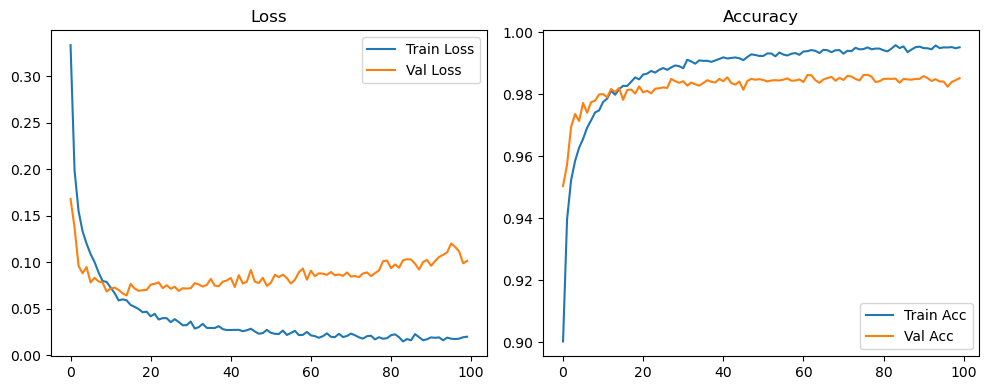

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2616, Acc: 0.9207 | Val Loss: 0.1476, Acc: 0.9559


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1306, Acc: 0.9593 | Val Loss: 0.1066, Acc: 0.9663


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0904, Acc: 0.9722 | Val Loss: 0.1006, Acc: 0.9705


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0742, Acc: 0.9761 | Val Loss: 0.0892, Acc: 0.9741


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0611, Acc: 0.9794 | Val Loss: 0.1072, Acc: 0.9689


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0512, Acc: 0.9830 | Val Loss: 0.0794, Acc: 0.9777


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9867 | Val Loss: 0.0928, Acc: 0.9745


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9872 | Val Loss: 0.0740, Acc: 0.9803


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0320, Acc: 0.9894 | Val Loss: 0.0897, Acc: 0.9766


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9906 | Val Loss: 0.0825, Acc: 0.9771


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9914 | Val Loss: 0.0717, Acc: 0.9815


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.0826, Acc: 0.9804


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9934 | Val Loss: 0.0801, Acc: 0.9811


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0831, Acc: 0.9800


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.0778, Acc: 0.9809


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9946 | Val Loss: 0.0767, Acc: 0.9823


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 0.0761, Acc: 0.9829


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.0829, Acc: 0.9810


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9954 | Val Loss: 0.0835, Acc: 0.9818


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.1031, Acc: 0.9772


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.0833, Acc: 0.9813


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0769, Acc: 0.9818


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.0850, Acc: 0.9818


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.0760, Acc: 0.9844


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0846, Acc: 0.9812


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0974, Acc: 0.9803


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0866, Acc: 0.9829


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0947, Acc: 0.9799


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0853, Acc: 0.9833


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.0816, Acc: 0.9844


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0969, Acc: 0.9808


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0913, Acc: 0.9823


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0968, Acc: 0.9805


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0928, Acc: 0.9822


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.0814, Acc: 0.9837


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0813, Acc: 0.9842


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0844, Acc: 0.9836


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0828, Acc: 0.9841


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0795, Acc: 0.9846


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0813, Acc: 0.9840


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0878, Acc: 0.9848


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0844, Acc: 0.9833


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0945, Acc: 0.9842


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0805, Acc: 0.9832


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0791, Acc: 0.9852


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1030, Acc: 0.9814


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0926, Acc: 0.9838


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0971, Acc: 0.9835


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0934, Acc: 0.9844


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0820, Acc: 0.9840


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0784, Acc: 0.9852


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0748, Acc: 0.9855


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0845, Acc: 0.9855


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0774, Acc: 0.9863


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0849, Acc: 0.9854


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.0836, Acc: 0.9860


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0839, Acc: 0.9869


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0868, Acc: 0.9868


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.0925, Acc: 0.9857


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0786, Acc: 0.9878


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0827, Acc: 0.9875


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0911, Acc: 0.9868


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0902, Acc: 0.9863


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0830, Acc: 0.9869


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0840, Acc: 0.9868


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0828, Acc: 0.9872


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0854, Acc: 0.9880


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0857, Acc: 0.9878


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.0926, Acc: 0.9867


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0919, Acc: 0.9864


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0903, Acc: 0.9872


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0905, Acc: 0.9872


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1008, Acc: 0.9857


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1083, Acc: 0.9862


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0948, Acc: 0.9867


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0958, Acc: 0.9872


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0991, Acc: 0.9866


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0881, Acc: 0.9863


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0930, Acc: 0.9858


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0898, Acc: 0.9873


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0898, Acc: 0.9869


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0894, Acc: 0.9873


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0950, Acc: 0.9872


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0946, Acc: 0.9869


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0951, Acc: 0.9868


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0969, Acc: 0.9868


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0971, Acc: 0.9873


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0960, Acc: 0.9878


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0974, Acc: 0.9868


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0940, Acc: 0.9872


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0968, Acc: 0.9878


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0962, Acc: 0.9873


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0956, Acc: 0.9874


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0956, Acc: 0.9881


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0972, Acc: 0.9882


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0938, Acc: 0.9876


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0969, Acc: 0.9878


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.0955, Acc: 0.9875


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1011, Acc: 0.9874


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1009, Acc: 0.9872


Final Test Loss: 0.1115 Accuracy: 0.9863


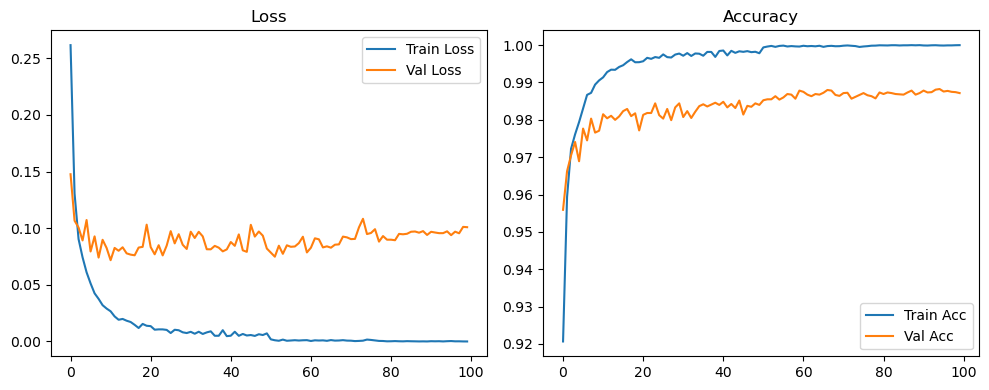

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2772, Acc: 0.9150 | Val Loss: 0.1493, Acc: 0.9567


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1481, Acc: 0.9549 | Val Loss: 0.1259, Acc: 0.9605


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1082, Acc: 0.9664 | Val Loss: 0.0868, Acc: 0.9740


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0902, Acc: 0.9715 | Val Loss: 0.0822, Acc: 0.9747


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0755, Acc: 0.9766 | Val Loss: 0.0862, Acc: 0.9742


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0662, Acc: 0.9787 | Val Loss: 0.0802, Acc: 0.9775


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0571, Acc: 0.9818 | Val Loss: 0.0938, Acc: 0.9710


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0518, Acc: 0.9835 | Val Loss: 0.0785, Acc: 0.9779


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0434, Acc: 0.9857 | Val Loss: 0.0906, Acc: 0.9752


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9873 | Val Loss: 0.0749, Acc: 0.9798


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0398, Acc: 0.9874 | Val Loss: 0.0691, Acc: 0.9813


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.0708, Acc: 0.9814


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9912 | Val Loss: 0.0807, Acc: 0.9808


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9899 | Val Loss: 0.0661, Acc: 0.9833


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9910 | Val Loss: 0.0879, Acc: 0.9792


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9913 | Val Loss: 0.0855, Acc: 0.9807


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.0761, Acc: 0.9823


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.0777, Acc: 0.9823


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0814, Acc: 0.9811


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9936 | Val Loss: 0.0861, Acc: 0.9807


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.0805, Acc: 0.9828


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0890, Acc: 0.9807


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.0905, Acc: 0.9809


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0789, Acc: 0.9832


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0170, Acc: 0.9945 | Val Loss: 0.0748, Acc: 0.9828


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9957 | Val Loss: 0.0809, Acc: 0.9827


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9941 | Val Loss: 0.0851, Acc: 0.9798


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0911, Acc: 0.9826


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.0809, Acc: 0.9828


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.0943, Acc: 0.9816


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9954 | Val Loss: 0.0917, Acc: 0.9818


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1030, Acc: 0.9820


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9959 | Val Loss: 0.0961, Acc: 0.9815


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0931, Acc: 0.9836


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.1000, Acc: 0.9818


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.0864, Acc: 0.9831


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.0948, Acc: 0.9841


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9965 | Val Loss: 0.0883, Acc: 0.9844


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.0925, Acc: 0.9830


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0828, Acc: 0.9847


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0982, Acc: 0.9830


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.0899, Acc: 0.9839


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.0923, Acc: 0.9832


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.0849, Acc: 0.9842


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0829, Acc: 0.9847


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1103, Acc: 0.9811


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.0901, Acc: 0.9845


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0974, Acc: 0.9841


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.0956, Acc: 0.9842


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0825, Acc: 0.9842


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9982 | Val Loss: 0.0780, Acc: 0.9862


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0756, Acc: 0.9864


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0782, Acc: 0.9859


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0795, Acc: 0.9861


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0846, Acc: 0.9861


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0805, Acc: 0.9867


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0807, Acc: 0.9867


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0870, Acc: 0.9862


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0844, Acc: 0.9869


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0951, Acc: 0.9855


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0884, Acc: 0.9866


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0905, Acc: 0.9860


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0867, Acc: 0.9876


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0944, Acc: 0.9874


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0933, Acc: 0.9868


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0996, Acc: 0.9865


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1034, Acc: 0.9858


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0962, Acc: 0.9870


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1030, Acc: 0.9868


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0995, Acc: 0.9873


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1050, Acc: 0.9852


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0972, Acc: 0.9861


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1007, Acc: 0.9866


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1048, Acc: 0.9858


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1054, Acc: 0.9857


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0941, Acc: 0.9854


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0997, Acc: 0.9856


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1029, Acc: 0.9858


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1019, Acc: 0.9860


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1052, Acc: 0.9854


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0978, Acc: 0.9865


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0998, Acc: 0.9866


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1027, Acc: 0.9867


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0997, Acc: 0.9865


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0995, Acc: 0.9868


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1004, Acc: 0.9861


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1013, Acc: 0.9866


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1047, Acc: 0.9869


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1063, Acc: 0.9865


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1065, Acc: 0.9862


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1009, Acc: 0.9874


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1019, Acc: 0.9872


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1025, Acc: 0.9868


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1016, Acc: 0.9874


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1078, Acc: 0.9864


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1006, Acc: 0.9869


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0978, Acc: 0.9876


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1021, Acc: 0.9864


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1028, Acc: 0.9866


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1008, Acc: 0.9864


Final Test Loss: 0.0957 Accuracy: 0.9871


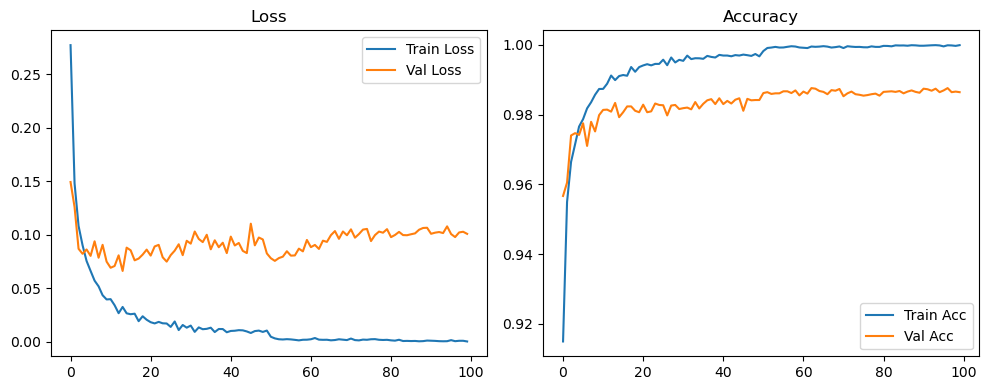

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.3334, Acc: 0.9003 | Val Loss: 0.1682, Acc: 0.9504


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1987, Acc: 0.9397 | Val Loss: 0.1374, Acc: 0.9573


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1552, Acc: 0.9522 | Val Loss: 0.0962, Acc: 0.9695


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1334, Acc: 0.9585 | Val Loss: 0.0883, Acc: 0.9737


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1200, Acc: 0.9628 | Val Loss: 0.0949, Acc: 0.9714


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1090, Acc: 0.9656 | Val Loss: 0.0784, Acc: 0.9772


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1002, Acc: 0.9692 | Val Loss: 0.0834, Acc: 0.9741


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0891, Acc: 0.9716 | Val Loss: 0.0795, Acc: 0.9775


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0799, Acc: 0.9742 | Val Loss: 0.0784, Acc: 0.9780


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0790, Acc: 0.9748 | Val Loss: 0.0687, Acc: 0.9800


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0729, Acc: 0.9776 | Val Loss: 0.0717, Acc: 0.9801


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0670, Acc: 0.9786 | Val Loss: 0.0729, Acc: 0.9791


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9811 | Val Loss: 0.0703, Acc: 0.9818


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0603, Acc: 0.9799 | Val Loss: 0.0667, Acc: 0.9808


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0592, Acc: 0.9817 | Val Loss: 0.0644, Acc: 0.9821


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9828 | Val Loss: 0.0769, Acc: 0.9782


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0522, Acc: 0.9827 | Val Loss: 0.0719, Acc: 0.9814


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0498, Acc: 0.9841 | Val Loss: 0.0694, Acc: 0.9816


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0464, Acc: 0.9855 | Val Loss: 0.0701, Acc: 0.9802


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0469, Acc: 0.9849 | Val Loss: 0.0704, Acc: 0.9826


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0420, Acc: 0.9864 | Val Loss: 0.0761, Acc: 0.9807


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0447, Acc: 0.9867 | Val Loss: 0.0770, Acc: 0.9812


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9876 | Val Loss: 0.0785, Acc: 0.9803


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0401, Acc: 0.9870 | Val Loss: 0.0723, Acc: 0.9818


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9879 | Val Loss: 0.0754, Acc: 0.9820


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9885 | Val Loss: 0.0717, Acc: 0.9822


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0390, Acc: 0.9879 | Val Loss: 0.0738, Acc: 0.9821


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9887 | Val Loss: 0.0693, Acc: 0.9850


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9894 | Val Loss: 0.0722, Acc: 0.9842


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9891 | Val Loss: 0.0718, Acc: 0.9838


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9884 | Val Loss: 0.0722, Acc: 0.9842


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9912 | Val Loss: 0.0776, Acc: 0.9828


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0304, Acc: 0.9906 | Val Loss: 0.0763, Acc: 0.9838


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0339, Acc: 0.9899 | Val Loss: 0.0740, Acc: 0.9832


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9910 | Val Loss: 0.0757, Acc: 0.9828


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9908 | Val Loss: 0.0822, Acc: 0.9837


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9909 | Val Loss: 0.0750, Acc: 0.9846


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9905 | Val Loss: 0.0745, Acc: 0.9841


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.0793, Acc: 0.9838


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9914 | Val Loss: 0.0805, Acc: 0.9850


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9920 | Val Loss: 0.0833, Acc: 0.9842


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9916 | Val Loss: 0.0735, Acc: 0.9855


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9918 | Val Loss: 0.0863, Acc: 0.9837


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9919 | Val Loss: 0.0773, Acc: 0.9832


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9917 | Val Loss: 0.0791, Acc: 0.9842


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9911 | Val Loss: 0.0918, Acc: 0.9815


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9921 | Val Loss: 0.0793, Acc: 0.9843


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9929 | Val Loss: 0.0777, Acc: 0.9850


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9927 | Val Loss: 0.0834, Acc: 0.9848


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9924 | Val Loss: 0.0747, Acc: 0.9849


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0704, Acc: 0.9855


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0686, Acc: 0.9865


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0716, Acc: 0.9864


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0699, Acc: 0.9868


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0709, Acc: 0.9863


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0703, Acc: 0.9867


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.0725, Acc: 0.9868


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0728, Acc: 0.9869


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0767, Acc: 0.9862


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0749, Acc: 0.9860


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0750, Acc: 0.9865


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9972 | Val Loss: 0.0752, Acc: 0.9868


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0743, Acc: 0.9869


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0768, Acc: 0.9861


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0756, Acc: 0.9865


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.0814, Acc: 0.9865


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0752, Acc: 0.9872


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0713, Acc: 0.9868


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0771, Acc: 0.9858


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0774, Acc: 0.9862


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.0775, Acc: 0.9861


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9977 | Val Loss: 0.0793, Acc: 0.9865


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.0755, Acc: 0.9862


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9978 | Val Loss: 0.0721, Acc: 0.9864


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.0716, Acc: 0.9874


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.0706, Acc: 0.9878


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0759, Acc: 0.9865


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0816, Acc: 0.9874


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0794, Acc: 0.9861


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0811, Acc: 0.9865


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0765, Acc: 0.9868


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0766, Acc: 0.9876


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9983 | Val Loss: 0.0735, Acc: 0.9874


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0718, Acc: 0.9872


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0721, Acc: 0.9880


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0733, Acc: 0.9874


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0740, Acc: 0.9870


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0746, Acc: 0.9875


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0775, Acc: 0.9872


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0752, Acc: 0.9882


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0743, Acc: 0.9874


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0773, Acc: 0.9877


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0778, Acc: 0.9877


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0800, Acc: 0.9875


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0815, Acc: 0.9867


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0775, Acc: 0.9874


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0764, Acc: 0.9873


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0787, Acc: 0.9874


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0847, Acc: 0.9872


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0809, Acc: 0.9865


Final Test Loss: 0.0820 Accuracy: 0.9874


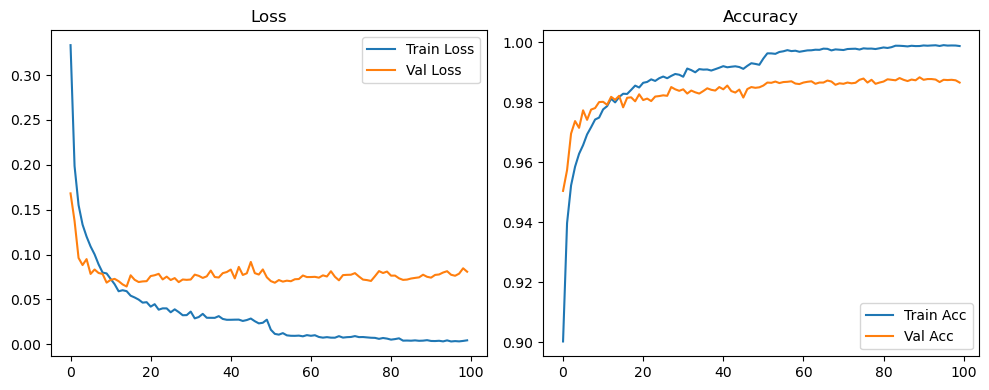

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2324, Acc: 0.9282 | Val Loss: 0.1480, Acc: 0.9561


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1249, Acc: 0.9611 | Val Loss: 0.1101, Acc: 0.9659


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0911, Acc: 0.9719 | Val Loss: 0.0976, Acc: 0.9698


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0738, Acc: 0.9769 | Val Loss: 0.0819, Acc: 0.9752


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0606, Acc: 0.9803 | Val Loss: 0.0938, Acc: 0.9711


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0535, Acc: 0.9820 | Val Loss: 0.0817, Acc: 0.9761


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0440, Acc: 0.9855 | Val Loss: 0.0991, Acc: 0.9711


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9878 | Val Loss: 0.0788, Acc: 0.9782


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9893 | Val Loss: 0.0952, Acc: 0.9779


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9892 | Val Loss: 0.0895, Acc: 0.9766


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9908 | Val Loss: 0.0739, Acc: 0.9798


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0254, Acc: 0.9917 | Val Loss: 0.0822, Acc: 0.9790


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.0932, Acc: 0.9773


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9941 | Val Loss: 0.0819, Acc: 0.9798


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.0842, Acc: 0.9792


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.0788, Acc: 0.9813


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9952 | Val Loss: 0.0902, Acc: 0.9800


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0939, Acc: 0.9792


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9959 | Val Loss: 0.0904, Acc: 0.9801


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0908, Acc: 0.9789


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9958 | Val Loss: 0.0859, Acc: 0.9806


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.0789, Acc: 0.9815


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0904, Acc: 0.9807


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0805, Acc: 0.9837


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0868, Acc: 0.9804


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0929, Acc: 0.9813


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.0808, Acc: 0.9822


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.0830, Acc: 0.9818


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0849, Acc: 0.9837


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9971 | Val Loss: 0.0760, Acc: 0.9842


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0850, Acc: 0.9826


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0825, Acc: 0.9825


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0886, Acc: 0.9825


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0816, Acc: 0.9828


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0815, Acc: 0.9832


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.0877, Acc: 0.9825


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0927, Acc: 0.9828


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0944, Acc: 0.9836


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.0887, Acc: 0.9840


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0848, Acc: 0.9835


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0990, Acc: 0.9818


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1034, Acc: 0.9816


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0908, Acc: 0.9830


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0916, Acc: 0.9835


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1021, Acc: 0.9820


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.1109, Acc: 0.9802


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0945, Acc: 0.9828


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0816, Acc: 0.9848


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0942, Acc: 0.9836


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0953, Acc: 0.9829


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0950, Acc: 0.9831


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.0965, Acc: 0.9832


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0950, Acc: 0.9832


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.0881, Acc: 0.9845


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0832, Acc: 0.9850


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.0880, Acc: 0.9849


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0872, Acc: 0.9843


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0870, Acc: 0.9854


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1042, Acc: 0.9829


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9985 | Val Loss: 0.0958, Acc: 0.9842


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.0825, Acc: 0.9858


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9992 | Val Loss: 0.0819, Acc: 0.9846


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0902, Acc: 0.9845


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0970, Acc: 0.9833


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0962, Acc: 0.9827


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0885, Acc: 0.9848


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0854, Acc: 0.9858


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1024, Acc: 0.9825


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.0904, Acc: 0.9839


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0989, Acc: 0.9836


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0918, Acc: 0.9855


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0936, Acc: 0.9851


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0891, Acc: 0.9850


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0920, Acc: 0.9838


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1028, Acc: 0.9826


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.0861, Acc: 0.9862


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0847, Acc: 0.9855


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0848, Acc: 0.9868


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1001, Acc: 0.9837


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0969, Acc: 0.9849


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0859, Acc: 0.9860


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0758, Acc: 0.9864


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0944, Acc: 0.9845


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0880, Acc: 0.9860


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9991 | Val Loss: 0.1013, Acc: 0.9838


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0987, Acc: 0.9845


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0941, Acc: 0.9853


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1046, Acc: 0.9847


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0934, Acc: 0.9858


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0927, Acc: 0.9855


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0993, Acc: 0.9839


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0912, Acc: 0.9845


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.0890, Acc: 0.9860


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0958, Acc: 0.9847


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.0985, Acc: 0.9838


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0895, Acc: 0.9858


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1049, Acc: 0.9829


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1012, Acc: 0.9823


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.0950, Acc: 0.9844


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0991, Acc: 0.9843


Final Test Loss: 0.1032 Accuracy: 0.9844


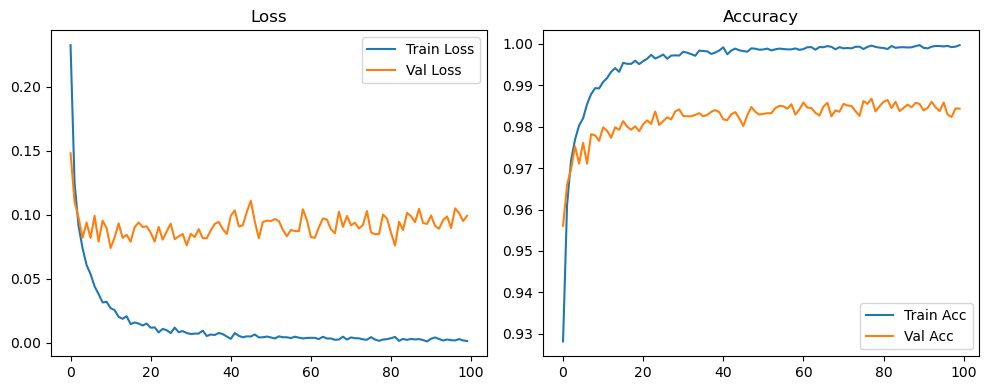

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2457, Acc: 0.9240 | Val Loss: 0.1400, Acc: 0.9593


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1417, Acc: 0.9562 | Val Loss: 0.1304, Acc: 0.9593


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1059, Acc: 0.9671 | Val Loss: 0.0878, Acc: 0.9738


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0871, Acc: 0.9719 | Val Loss: 0.0866, Acc: 0.9748


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0749, Acc: 0.9761 | Val Loss: 0.0916, Acc: 0.9728


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0676, Acc: 0.9781 | Val Loss: 0.0840, Acc: 0.9754


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0549, Acc: 0.9828 | Val Loss: 0.0840, Acc: 0.9765


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0516, Acc: 0.9839 | Val Loss: 0.0840, Acc: 0.9765


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0451, Acc: 0.9850 | Val Loss: 0.0834, Acc: 0.9785


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9857 | Val Loss: 0.0773, Acc: 0.9805


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9877 | Val Loss: 0.0700, Acc: 0.9816


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9875 | Val Loss: 0.0714, Acc: 0.9825


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0277, Acc: 0.9906 | Val Loss: 0.0852, Acc: 0.9792


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.0994, Acc: 0.9765


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0303, Acc: 0.9903 | Val Loss: 0.0781, Acc: 0.9796


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.0868, Acc: 0.9785


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9917 | Val Loss: 0.0854, Acc: 0.9807


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9925 | Val Loss: 0.0860, Acc: 0.9800


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9938 | Val Loss: 0.0725, Acc: 0.9831


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9926 | Val Loss: 0.0849, Acc: 0.9808


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.0830, Acc: 0.9811


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.0826, Acc: 0.9813


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9946 | Val Loss: 0.0845, Acc: 0.9800


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9946 | Val Loss: 0.0767, Acc: 0.9834


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9947 | Val Loss: 0.0781, Acc: 0.9817


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0750, Acc: 0.9836


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.0874, Acc: 0.9816


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0764, Acc: 0.9840


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.0779, Acc: 0.9824


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.0764, Acc: 0.9823


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9952 | Val Loss: 0.0844, Acc: 0.9822


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.0826, Acc: 0.9823


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0804, Acc: 0.9825


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9963 | Val Loss: 0.0803, Acc: 0.9828


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.0749, Acc: 0.9848


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.0846, Acc: 0.9820


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0798, Acc: 0.9841


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.0678, Acc: 0.9848


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0789, Acc: 0.9838


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9960 | Val Loss: 0.0786, Acc: 0.9834


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0791, Acc: 0.9847


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0860, Acc: 0.9835


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0821, Acc: 0.9848


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.0875, Acc: 0.9848


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0922, Acc: 0.9835


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0911, Acc: 0.9831


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0795, Acc: 0.9836


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.0892, Acc: 0.9836


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0911, Acc: 0.9831


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.0834, Acc: 0.9852


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0958, Acc: 0.9836


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.0880, Acc: 0.9840


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0877, Acc: 0.9831


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0925, Acc: 0.9829


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0872, Acc: 0.9842


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0865, Acc: 0.9840


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0910, Acc: 0.9825


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9977 | Val Loss: 0.0911, Acc: 0.9835


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0889, Acc: 0.9838


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0874, Acc: 0.9844


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0829, Acc: 0.9842


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0826, Acc: 0.9857


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0940, Acc: 0.9847


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0911, Acc: 0.9833


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0904, Acc: 0.9836


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1073, Acc: 0.9833


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0952, Acc: 0.9832


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.0847, Acc: 0.9845


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.0894, Acc: 0.9837


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0891, Acc: 0.9842


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0865, Acc: 0.9853


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0924, Acc: 0.9846


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0866, Acc: 0.9840


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0834, Acc: 0.9845


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0939, Acc: 0.9827


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9978 | Val Loss: 0.0823, Acc: 0.9850


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0893, Acc: 0.9853


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0866, Acc: 0.9845


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0881, Acc: 0.9841


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0885, Acc: 0.9847


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.0873, Acc: 0.9846


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0859, Acc: 0.9840


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0833, Acc: 0.9847


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.0898, Acc: 0.9848


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0873, Acc: 0.9853


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0843, Acc: 0.9853


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0870, Acc: 0.9852


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0801, Acc: 0.9865


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0893, Acc: 0.9858


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0862, Acc: 0.9860


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0887, Acc: 0.9848


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0978, Acc: 0.9843


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0853, Acc: 0.9854


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0934, Acc: 0.9853


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0864, Acc: 0.9857


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0889, Acc: 0.9846


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0871, Acc: 0.9851


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0930, Acc: 0.9846


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0941, Acc: 0.9848


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0979, Acc: 0.9858


Final Test Loss: 0.0946 Accuracy: 0.9858


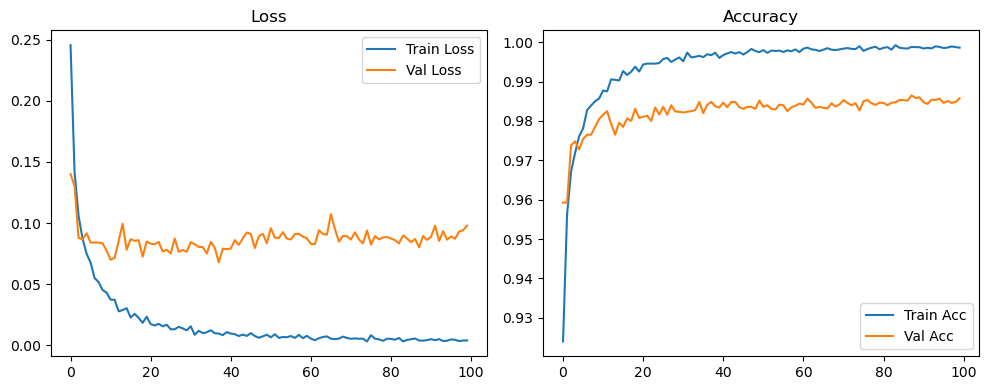

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2983, Acc: 0.9073 | Val Loss: 0.1494, Acc: 0.9551


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1871, Acc: 0.9429 | Val Loss: 0.1214, Acc: 0.9622


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1485, Acc: 0.9548 | Val Loss: 0.0981, Acc: 0.9694


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1292, Acc: 0.9593 | Val Loss: 0.0938, Acc: 0.9715


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1170, Acc: 0.9637 | Val Loss: 0.0987, Acc: 0.9702


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1058, Acc: 0.9666 | Val Loss: 0.0903, Acc: 0.9727


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0957, Acc: 0.9700 | Val Loss: 0.0910, Acc: 0.9738


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0894, Acc: 0.9719 | Val Loss: 0.0855, Acc: 0.9740


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0776, Acc: 0.9745 | Val Loss: 0.0758, Acc: 0.9773


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0735, Acc: 0.9765 | Val Loss: 0.0716, Acc: 0.9782


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0695, Acc: 0.9780 | Val Loss: 0.0732, Acc: 0.9798


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0646, Acc: 0.9790 | Val Loss: 0.0770, Acc: 0.9784


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0597, Acc: 0.9806 | Val Loss: 0.0800, Acc: 0.9788


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0596, Acc: 0.9810 | Val Loss: 0.0676, Acc: 0.9812


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0564, Acc: 0.9812 | Val Loss: 0.0711, Acc: 0.9810


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0516, Acc: 0.9832 | Val Loss: 0.0804, Acc: 0.9795


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0511, Acc: 0.9830 | Val Loss: 0.0663, Acc: 0.9812


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0466, Acc: 0.9846 | Val Loss: 0.0691, Acc: 0.9813


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0446, Acc: 0.9859 | Val Loss: 0.0649, Acc: 0.9834


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0418, Acc: 0.9865 | Val Loss: 0.0649, Acc: 0.9832


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0423, Acc: 0.9863 | Val Loss: 0.0700, Acc: 0.9820


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9864 | Val Loss: 0.0711, Acc: 0.9810


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0359, Acc: 0.9881 | Val Loss: 0.0690, Acc: 0.9826


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9876 | Val Loss: 0.0694, Acc: 0.9820


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0365, Acc: 0.9884 | Val Loss: 0.0640, Acc: 0.9846


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9891 | Val Loss: 0.0688, Acc: 0.9826


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9897 | Val Loss: 0.0750, Acc: 0.9814


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0331, Acc: 0.9889 | Val Loss: 0.0757, Acc: 0.9812


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0309, Acc: 0.9900 | Val Loss: 0.0778, Acc: 0.9822


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9908 | Val Loss: 0.0724, Acc: 0.9833


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9906 | Val Loss: 0.0732, Acc: 0.9838


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9911 | Val Loss: 0.0722, Acc: 0.9836


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9914 | Val Loss: 0.0751, Acc: 0.9838


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9918 | Val Loss: 0.0755, Acc: 0.9815


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9921 | Val Loss: 0.0756, Acc: 0.9836


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9921 | Val Loss: 0.0718, Acc: 0.9838


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9915 | Val Loss: 0.0720, Acc: 0.9852


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.0731, Acc: 0.9836


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9920 | Val Loss: 0.0727, Acc: 0.9832


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0213, Acc: 0.9925 | Val Loss: 0.0704, Acc: 0.9848


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9923 | Val Loss: 0.0740, Acc: 0.9837


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9927 | Val Loss: 0.0711, Acc: 0.9838


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9932 | Val Loss: 0.0790, Acc: 0.9847


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.0749, Acc: 0.9840


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0711, Acc: 0.9840


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9928 | Val Loss: 0.0817, Acc: 0.9834


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9933 | Val Loss: 0.0762, Acc: 0.9845


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9933 | Val Loss: 0.0741, Acc: 0.9840


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.0715, Acc: 0.9850


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0747, Acc: 0.9854


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9941 | Val Loss: 0.0762, Acc: 0.9850


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.0809, Acc: 0.9838


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.0754, Acc: 0.9842


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9942 | Val Loss: 0.0764, Acc: 0.9842


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9950 | Val Loss: 0.0699, Acc: 0.9848


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0756, Acc: 0.9848


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9940 | Val Loss: 0.0712, Acc: 0.9845


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.0719, Acc: 0.9853


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0772, Acc: 0.9845


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.0713, Acc: 0.9846


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.0782, Acc: 0.9833


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.0717, Acc: 0.9849


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.0751, Acc: 0.9846


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9947 | Val Loss: 0.0766, Acc: 0.9841


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0782, Acc: 0.9851


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.0779, Acc: 0.9855


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.0799, Acc: 0.9838


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0743, Acc: 0.9860


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9949 | Val Loss: 0.0791, Acc: 0.9840


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.0821, Acc: 0.9840


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.0757, Acc: 0.9846


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9958 | Val Loss: 0.0733, Acc: 0.9860


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.0828, Acc: 0.9832


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9950 | Val Loss: 0.0792, Acc: 0.9849


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.0802, Acc: 0.9852


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9959 | Val Loss: 0.0746, Acc: 0.9856


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0777, Acc: 0.9855


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0728, Acc: 0.9843


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.0768, Acc: 0.9863


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0816, Acc: 0.9854


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.0721, Acc: 0.9849


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0734, Acc: 0.9858


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9959 | Val Loss: 0.0793, Acc: 0.9850


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.0741, Acc: 0.9857


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.0735, Acc: 0.9847


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0779, Acc: 0.9862


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0815, Acc: 0.9851


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9959 | Val Loss: 0.0773, Acc: 0.9858


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.0814, Acc: 0.9865


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0829, Acc: 0.9844


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.0754, Acc: 0.9861


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0772, Acc: 0.9863


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0780, Acc: 0.9856


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0816, Acc: 0.9845


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.0773, Acc: 0.9851


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0838, Acc: 0.9858


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0778, Acc: 0.9861


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0771, Acc: 0.9862


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0822, Acc: 0.9851


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.0764, Acc: 0.9858


Final Test Loss: 0.0759 Accuracy: 0.9860


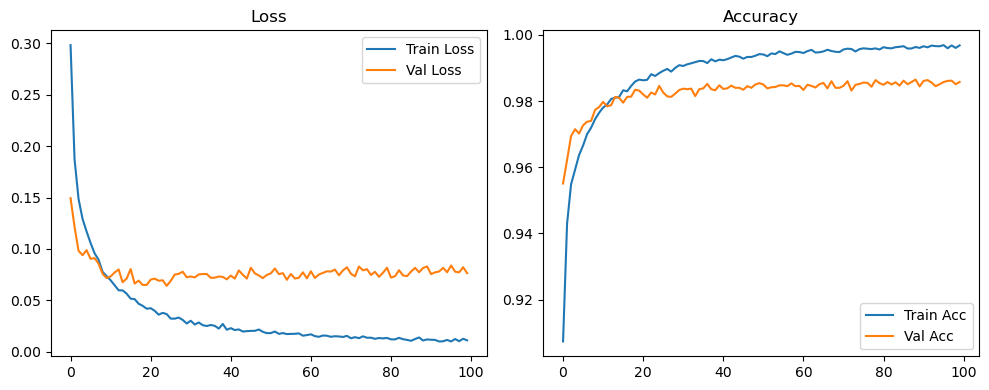

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2150, Acc: 0.9347 | Val Loss: 0.1426, Acc: 0.9571


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1145, Acc: 0.9638 | Val Loss: 0.1023, Acc: 0.9672


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0841, Acc: 0.9735 | Val Loss: 0.0878, Acc: 0.9733


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0699, Acc: 0.9774 | Val Loss: 0.0806, Acc: 0.9763


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0574, Acc: 0.9807 | Val Loss: 0.0944, Acc: 0.9714


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0514, Acc: 0.9827 | Val Loss: 0.0833, Acc: 0.9753


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9869 | Val Loss: 0.0834, Acc: 0.9772


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0371, Acc: 0.9877 | Val Loss: 0.0784, Acc: 0.9783


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9891 | Val Loss: 0.1019, Acc: 0.9755


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9903 | Val Loss: 0.0856, Acc: 0.9777


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9906 | Val Loss: 0.0854, Acc: 0.9783


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9919 | Val Loss: 0.0890, Acc: 0.9775


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9925 | Val Loss: 0.0888, Acc: 0.9774


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9922 | Val Loss: 0.0864, Acc: 0.9809


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.0867, Acc: 0.9797


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.1016, Acc: 0.9772


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.0937, Acc: 0.9787


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.0897, Acc: 0.9807


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.0879, Acc: 0.9791


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0841, Acc: 0.9804


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.0863, Acc: 0.9813


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.0858, Acc: 0.9825


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.0868, Acc: 0.9815


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9964 | Val Loss: 0.0859, Acc: 0.9820


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0829, Acc: 0.9830


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.0842, Acc: 0.9824


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.0998, Acc: 0.9798


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0968, Acc: 0.9814


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9974 | Val Loss: 0.1235, Acc: 0.9762


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0923, Acc: 0.9819


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.0975, Acc: 0.9820


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0851, Acc: 0.9821


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0862, Acc: 0.9833


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0923, Acc: 0.9818


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.0976, Acc: 0.9830


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.0887, Acc: 0.9822


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0968, Acc: 0.9824


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.0950, Acc: 0.9827


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0921, Acc: 0.9835


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0863, Acc: 0.9831


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1041, Acc: 0.9826


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0955, Acc: 0.9833


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0893, Acc: 0.9821


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0952, Acc: 0.9818


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.0994, Acc: 0.9828


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1083, Acc: 0.9793


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.0916, Acc: 0.9847


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9991 | Val Loss: 0.0918, Acc: 0.9838


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1010, Acc: 0.9829


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0903, Acc: 0.9829


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0964, Acc: 0.9832


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0888, Acc: 0.9826


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.0816, Acc: 0.9838


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1091, Acc: 0.9815


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.0971, Acc: 0.9830


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1062, Acc: 0.9818


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0901, Acc: 0.9837


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1082, Acc: 0.9815


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0880, Acc: 0.9842


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.0924, Acc: 0.9836


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0983, Acc: 0.9839


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1043, Acc: 0.9812


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0989, Acc: 0.9828


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0907, Acc: 0.9849


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0992, Acc: 0.9833


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1014, Acc: 0.9839


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1095, Acc: 0.9830


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0918, Acc: 0.9850


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1060, Acc: 0.9830


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1029, Acc: 0.9838


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.1143, Acc: 0.9812


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1062, Acc: 0.9826


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1002, Acc: 0.9839


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1037, Acc: 0.9829


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0995, Acc: 0.9839


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0983, Acc: 0.9848


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1017, Acc: 0.9838


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1122, Acc: 0.9831


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1100, Acc: 0.9835


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1099, Acc: 0.9832


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1058, Acc: 0.9840


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1014, Acc: 0.9838


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1025, Acc: 0.9843


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1073, Acc: 0.9840


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1022, Acc: 0.9848


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1031, Acc: 0.9851


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0965, Acc: 0.9847


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1092, Acc: 0.9838


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.1025, Acc: 0.9838


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0920, Acc: 0.9855


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0930, Acc: 0.9849


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0983, Acc: 0.9841


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.0930, Acc: 0.9838


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0963, Acc: 0.9856


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1119, Acc: 0.9832


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0986, Acc: 0.9843


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1011, Acc: 0.9842


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1034, Acc: 0.9838


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1067, Acc: 0.9832


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1019, Acc: 0.9833


Final Test Loss: 0.1006 Accuracy: 0.9845


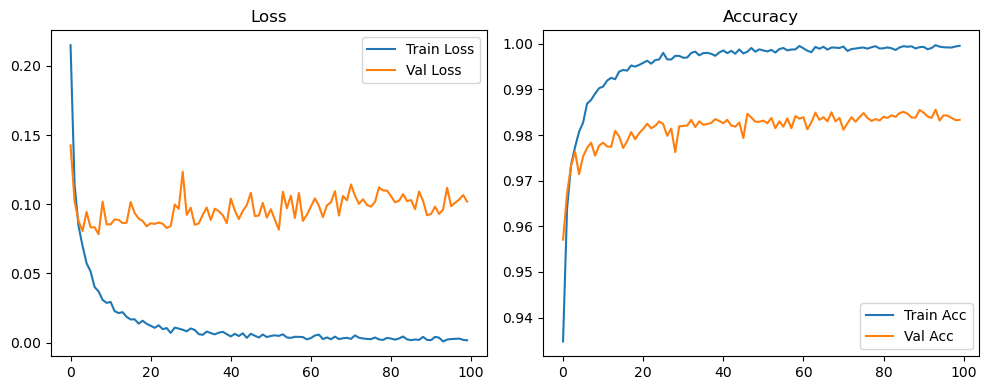

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2301, Acc: 0.9291 | Val Loss: 0.1354, Acc: 0.9599


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1297, Acc: 0.9587 | Val Loss: 0.1163, Acc: 0.9637


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0986, Acc: 0.9687 | Val Loss: 0.0949, Acc: 0.9711


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0822, Acc: 0.9737 | Val Loss: 0.0834, Acc: 0.9750


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0718, Acc: 0.9766 | Val Loss: 0.0926, Acc: 0.9715


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0615, Acc: 0.9787 | Val Loss: 0.0814, Acc: 0.9752


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0552, Acc: 0.9814 | Val Loss: 0.0857, Acc: 0.9755


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0489, Acc: 0.9839 | Val Loss: 0.0823, Acc: 0.9765


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0420, Acc: 0.9855 | Val Loss: 0.0913, Acc: 0.9747


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0406, Acc: 0.9868 | Val Loss: 0.0757, Acc: 0.9794


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0382, Acc: 0.9873 | Val Loss: 0.0743, Acc: 0.9798


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0334, Acc: 0.9890 | Val Loss: 0.0726, Acc: 0.9806


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9905 | Val Loss: 0.0806, Acc: 0.9791


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9899 | Val Loss: 0.0921, Acc: 0.9758


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9907 | Val Loss: 0.0779, Acc: 0.9809


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0778, Acc: 0.9811


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9916 | Val Loss: 0.0756, Acc: 0.9801


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0732, Acc: 0.9820


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9933 | Val Loss: 0.0798, Acc: 0.9813


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0846, Acc: 0.9814


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.0791, Acc: 0.9815


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9943 | Val Loss: 0.0811, Acc: 0.9822


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.0808, Acc: 0.9808


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0773, Acc: 0.9824


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0861, Acc: 0.9809


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.0720, Acc: 0.9828


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9950 | Val Loss: 0.0862, Acc: 0.9813


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0150, Acc: 0.9947 | Val Loss: 0.0800, Acc: 0.9828


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.0892, Acc: 0.9814


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0757, Acc: 0.9838


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.0913, Acc: 0.9827


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0850, Acc: 0.9826


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9961 | Val Loss: 0.0824, Acc: 0.9819


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0954, Acc: 0.9806


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0814, Acc: 0.9838


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0817, Acc: 0.9829


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0840, Acc: 0.9831


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0882, Acc: 0.9831


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.0823, Acc: 0.9846


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.0810, Acc: 0.9848


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0823, Acc: 0.9844


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0853, Acc: 0.9841


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0920, Acc: 0.9840


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0851, Acc: 0.9844


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0897, Acc: 0.9848


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.0824, Acc: 0.9828


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.0780, Acc: 0.9858


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0894, Acc: 0.9852


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0906, Acc: 0.9831


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0753, Acc: 0.9858


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0800, Acc: 0.9847


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0880, Acc: 0.9833


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0823, Acc: 0.9857


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0892, Acc: 0.9839


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.0823, Acc: 0.9852


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0872, Acc: 0.9851


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0843, Acc: 0.9866


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9976 | Val Loss: 0.0793, Acc: 0.9858


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0857, Acc: 0.9854


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9976 | Val Loss: 0.0853, Acc: 0.9851


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0902, Acc: 0.9835


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0917, Acc: 0.9844


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0912, Acc: 0.9846


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0927, Acc: 0.9847


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.0917, Acc: 0.9851


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0974, Acc: 0.9833


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0911, Acc: 0.9847


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.0976, Acc: 0.9830


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.0890, Acc: 0.9868


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1000, Acc: 0.9833


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0932, Acc: 0.9844


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1093, Acc: 0.9838


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1096, Acc: 0.9810


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0958, Acc: 0.9847


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0919, Acc: 0.9848


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0895, Acc: 0.9836


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0969, Acc: 0.9845


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.0869, Acc: 0.9850


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.0964, Acc: 0.9852


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0978, Acc: 0.9842


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0907, Acc: 0.9849


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0981, Acc: 0.9847


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0947, Acc: 0.9844


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0982, Acc: 0.9841


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0993, Acc: 0.9845


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0892, Acc: 0.9842


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0969, Acc: 0.9842


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0978, Acc: 0.9854


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1076, Acc: 0.9831


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1169, Acc: 0.9824


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0958, Acc: 0.9847


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1005, Acc: 0.9837


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1062, Acc: 0.9846


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1117, Acc: 0.9836


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1089, Acc: 0.9840


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0988, Acc: 0.9849


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1031, Acc: 0.9836


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1024, Acc: 0.9845


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1050, Acc: 0.9837


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1016, Acc: 0.9843


Final Test Loss: 0.0886 Accuracy: 0.9859


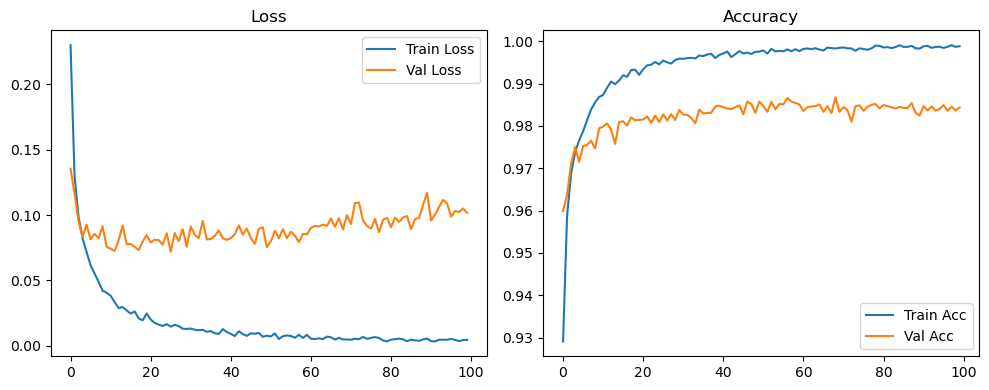

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2845, Acc: 0.9114 | Val Loss: 0.1393, Acc: 0.9575


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1732, Acc: 0.9466 | Val Loss: 0.1179, Acc: 0.9630


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1408, Acc: 0.9568 | Val Loss: 0.0956, Acc: 0.9711


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1220, Acc: 0.9612 | Val Loss: 0.0943, Acc: 0.9717


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1101, Acc: 0.9664 | Val Loss: 0.0872, Acc: 0.9739


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1022, Acc: 0.9678 | Val Loss: 0.0861, Acc: 0.9751


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0936, Acc: 0.9705 | Val Loss: 0.0829, Acc: 0.9736


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0867, Acc: 0.9720 | Val Loss: 0.0806, Acc: 0.9748


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0788, Acc: 0.9740 | Val Loss: 0.0798, Acc: 0.9742


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0773, Acc: 0.9752 | Val Loss: 0.0736, Acc: 0.9785


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0686, Acc: 0.9780 | Val Loss: 0.0685, Acc: 0.9798


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0647, Acc: 0.9786 | Val Loss: 0.0746, Acc: 0.9792


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0584, Acc: 0.9808 | Val Loss: 0.0694, Acc: 0.9799


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0575, Acc: 0.9812 | Val Loss: 0.0660, Acc: 0.9818


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0575, Acc: 0.9816 | Val Loss: 0.0682, Acc: 0.9809


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0531, Acc: 0.9823 | Val Loss: 0.0689, Acc: 0.9812


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0493, Acc: 0.9837 | Val Loss: 0.0699, Acc: 0.9818


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0466, Acc: 0.9842 | Val Loss: 0.0724, Acc: 0.9801


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0465, Acc: 0.9842 | Val Loss: 0.0704, Acc: 0.9809


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0440, Acc: 0.9854 | Val Loss: 0.0664, Acc: 0.9821


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0436, Acc: 0.9857 | Val Loss: 0.0673, Acc: 0.9824


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9872 | Val Loss: 0.0682, Acc: 0.9818


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0374, Acc: 0.9880 | Val Loss: 0.0687, Acc: 0.9818


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0392, Acc: 0.9869 | Val Loss: 0.0738, Acc: 0.9808


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0376, Acc: 0.9872 | Val Loss: 0.0670, Acc: 0.9836


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0309, Acc: 0.9898 | Val Loss: 0.0725, Acc: 0.9826


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9890 | Val Loss: 0.0700, Acc: 0.9822


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9884 | Val Loss: 0.0649, Acc: 0.9839


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9886 | Val Loss: 0.0732, Acc: 0.9822


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9894 | Val Loss: 0.0709, Acc: 0.9820


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0312, Acc: 0.9902 | Val Loss: 0.0693, Acc: 0.9831


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9905 | Val Loss: 0.0688, Acc: 0.9831


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9913 | Val Loss: 0.0692, Acc: 0.9843


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0256, Acc: 0.9909 | Val Loss: 0.0767, Acc: 0.9820


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9911 | Val Loss: 0.0684, Acc: 0.9829


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9911 | Val Loss: 0.0688, Acc: 0.9832


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9913 | Val Loss: 0.0679, Acc: 0.9833


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9918 | Val Loss: 0.0665, Acc: 0.9846


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9915 | Val Loss: 0.0724, Acc: 0.9830


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.0623, Acc: 0.9842


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9924 | Val Loss: 0.0699, Acc: 0.9837


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.0690, Acc: 0.9845


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9929 | Val Loss: 0.0633, Acc: 0.9852


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9928 | Val Loss: 0.0740, Acc: 0.9838


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9937 | Val Loss: 0.0722, Acc: 0.9837


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9931 | Val Loss: 0.0774, Acc: 0.9824


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.0677, Acc: 0.9849


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9936 | Val Loss: 0.0697, Acc: 0.9854


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.0721, Acc: 0.9848


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9929 | Val Loss: 0.0681, Acc: 0.9843


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.0746, Acc: 0.9826


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9940 | Val Loss: 0.0810, Acc: 0.9833


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9944 | Val Loss: 0.0797, Acc: 0.9834


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9942 | Val Loss: 0.0755, Acc: 0.9842


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.0798, Acc: 0.9851


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0804, Acc: 0.9831


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.0718, Acc: 0.9845


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9951 | Val Loss: 0.0774, Acc: 0.9840


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.0747, Acc: 0.9840


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.0718, Acc: 0.9856


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.0762, Acc: 0.9829


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.0767, Acc: 0.9832


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.0759, Acc: 0.9851


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.0786, Acc: 0.9839


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0799, Acc: 0.9838


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 0.0706, Acc: 0.9852


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0721, Acc: 0.9847


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.0774, Acc: 0.9842


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.0755, Acc: 0.9840


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.0739, Acc: 0.9838


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.0723, Acc: 0.9854


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0753, Acc: 0.9851


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.0790, Acc: 0.9838


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.0797, Acc: 0.9844


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0770, Acc: 0.9843


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0797, Acc: 0.9845


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.0783, Acc: 0.9836


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.0822, Acc: 0.9826


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0807, Acc: 0.9850


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.0776, Acc: 0.9851


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.0704, Acc: 0.9854


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0736, Acc: 0.9852


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0709, Acc: 0.9857


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0707, Acc: 0.9852


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0729, Acc: 0.9861


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9956 | Val Loss: 0.0727, Acc: 0.9861


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0715, Acc: 0.9865


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.0770, Acc: 0.9851


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.0740, Acc: 0.9862


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0709, Acc: 0.9850


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0739, Acc: 0.9853


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.0762, Acc: 0.9848


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.0787, Acc: 0.9848


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0789, Acc: 0.9852


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0827, Acc: 0.9848


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.0787, Acc: 0.9845


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.0761, Acc: 0.9852


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9967 | Val Loss: 0.0763, Acc: 0.9849


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0773, Acc: 0.9852


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0834, Acc: 0.9848


Final Test Loss: 0.0793 Accuracy: 0.9858


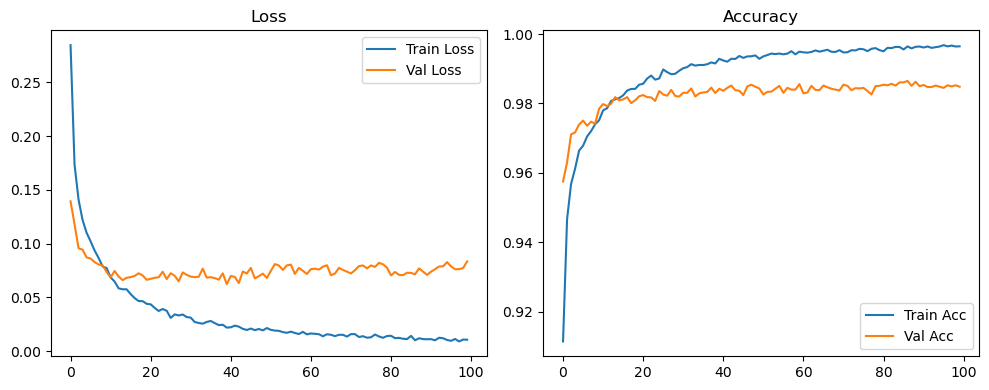

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2576, Acc: 0.9239 | Val Loss: 0.1875, Acc: 0.9460


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1167, Acc: 0.9641 | Val Loss: 0.1188, Acc: 0.9642


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0818, Acc: 0.9740 | Val Loss: 0.0981, Acc: 0.9709


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9816 | Val Loss: 0.0830, Acc: 0.9757


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9842 | Val Loss: 0.0899, Acc: 0.9742


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9872 | Val Loss: 0.1084, Acc: 0.9701


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9885 | Val Loss: 0.1157, Acc: 0.9705


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.1137, Acc: 0.9726


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.1017, Acc: 0.9752


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.0886, Acc: 0.9782


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.0977, Acc: 0.9771


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.0977, Acc: 0.9773


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1133, Acc: 0.9774


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9944 | Val Loss: 0.1071, Acc: 0.9783


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0873, Acc: 0.9794


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9952 | Val Loss: 0.0907, Acc: 0.9802


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.1042, Acc: 0.9783


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.1026, Acc: 0.9782


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0929, Acc: 0.9813


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.0895, Acc: 0.9813


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.0966, Acc: 0.9806


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1206, Acc: 0.9798


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9949 | Val Loss: 0.0961, Acc: 0.9788


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0911, Acc: 0.9802


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0985, Acc: 0.9796


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0912, Acc: 0.9814


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0906, Acc: 0.9809


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0924, Acc: 0.9825


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1105, Acc: 0.9797


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1042, Acc: 0.9812


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1055, Acc: 0.9809


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1009, Acc: 0.9805


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0981, Acc: 0.9805


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0926, Acc: 0.9825


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0996, Acc: 0.9826


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1178, Acc: 0.9804


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9956 | Val Loss: 0.1242, Acc: 0.9769


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0997, Acc: 0.9812


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.0879, Acc: 0.9840


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1002, Acc: 0.9818


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1054, Acc: 0.9808


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1080, Acc: 0.9818


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1069, Acc: 0.9812


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1109, Acc: 0.9822


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1029, Acc: 0.9829


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1114, Acc: 0.9833


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9980 | Val Loss: 0.1290, Acc: 0.9822


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1022, Acc: 0.9822


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1202, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0990, Acc: 0.9812


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1076, Acc: 0.9824


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1179, Acc: 0.9822


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0987, Acc: 0.9847


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0965, Acc: 0.9839


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1143, Acc: 0.9833


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9966 | Val Loss: 0.1354, Acc: 0.9788


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.1036, Acc: 0.9835


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1025, Acc: 0.9841


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1129, Acc: 0.9838


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1138, Acc: 0.9813


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9984 | Val Loss: 0.1303, Acc: 0.9805


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9973 | Val Loss: 0.1396, Acc: 0.9799


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1102, Acc: 0.9834


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1152, Acc: 0.9828


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.1080, Acc: 0.9842


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1113, Acc: 0.9820


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1124, Acc: 0.9828


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1247, Acc: 0.9813


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9980 | Val Loss: 0.1207, Acc: 0.9815


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1085, Acc: 0.9823


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1246, Acc: 0.9825


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1093, Acc: 0.9824


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1193, Acc: 0.9829


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1011, Acc: 0.9836


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1127, Acc: 0.9829


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1237, Acc: 0.9824


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1197, Acc: 0.9828


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1246, Acc: 0.9814


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.1471, Acc: 0.9804


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.1316, Acc: 0.9809


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9989 | Val Loss: 0.1021, Acc: 0.9828


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1033, Acc: 0.9835


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1065, Acc: 0.9828


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.0970, Acc: 0.9842


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1090, Acc: 0.9832


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1255, Acc: 0.9836


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1175, Acc: 0.9847


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1089, Acc: 0.9838


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1069, Acc: 0.9848


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1241, Acc: 0.9836


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9986 | Val Loss: 0.2220, Acc: 0.9769


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9976 | Val Loss: 0.1361, Acc: 0.9826


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9991 | Val Loss: 0.1192, Acc: 0.9846


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1180, Acc: 0.9834


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1249, Acc: 0.9832


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1261, Acc: 0.9837


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1174, Acc: 0.9837


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1286, Acc: 0.9842


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9983 | Val Loss: 0.1252, Acc: 0.9842


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9987 | Val Loss: 0.1344, Acc: 0.9827


Final Test Loss: 0.1080 Accuracy: 0.9843


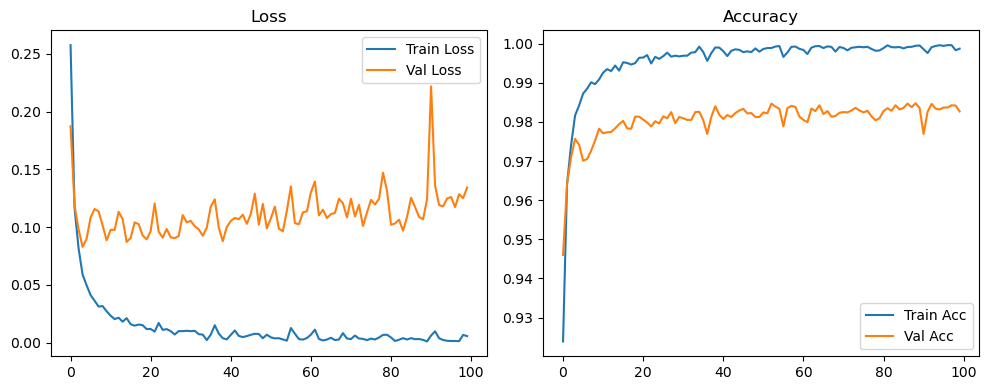

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2708, Acc: 0.9183 | Val Loss: 0.1993, Acc: 0.9427


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1334, Acc: 0.9595 | Val Loss: 0.1273, Acc: 0.9616


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0948, Acc: 0.9713 | Val Loss: 0.0997, Acc: 0.9698


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0790, Acc: 0.9759 | Val Loss: 0.0793, Acc: 0.9758


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0662, Acc: 0.9794 | Val Loss: 0.0977, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9815 | Val Loss: 0.0807, Acc: 0.9764


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9837 | Val Loss: 0.1017, Acc: 0.9728


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9849 | Val Loss: 0.0912, Acc: 0.9756


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9876 | Val Loss: 0.1191, Acc: 0.9692


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9883 | Val Loss: 0.0890, Acc: 0.9774


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9895 | Val Loss: 0.0776, Acc: 0.9803


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9894 | Val Loss: 0.1085, Acc: 0.9740


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9908 | Val Loss: 0.0844, Acc: 0.9789


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9908 | Val Loss: 0.0837, Acc: 0.9808


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9916 | Val Loss: 0.0871, Acc: 0.9785


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9923 | Val Loss: 0.1002, Acc: 0.9764


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.0947, Acc: 0.9799


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 0.1120, Acc: 0.9769


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0893, Acc: 0.9816


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.0906, Acc: 0.9806


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.1108, Acc: 0.9770


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.0957, Acc: 0.9796


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9949 | Val Loss: 0.1066, Acc: 0.9788


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9940 | Val Loss: 0.0967, Acc: 0.9800


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0969, Acc: 0.9808


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.0901, Acc: 0.9821


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9950 | Val Loss: 0.0900, Acc: 0.9827


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9949 | Val Loss: 0.0834, Acc: 0.9832


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.0965, Acc: 0.9798


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1095, Acc: 0.9816


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.0961, Acc: 0.9828


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9952 | Val Loss: 0.1215, Acc: 0.9765


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9957 | Val Loss: 0.0979, Acc: 0.9803


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9968 | Val Loss: 0.1005, Acc: 0.9815


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0888, Acc: 0.9842


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9962 | Val Loss: 0.1051, Acc: 0.9801


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9943 | Val Loss: 0.1060, Acc: 0.9816


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9956 | Val Loss: 0.1074, Acc: 0.9803


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9969 | Val Loss: 0.1025, Acc: 0.9833


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0996, Acc: 0.9817


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0938, Acc: 0.9838


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1066, Acc: 0.9818


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9967 | Val Loss: 0.1035, Acc: 0.9829


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9979 | Val Loss: 0.1029, Acc: 0.9827


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9967 | Val Loss: 0.1037, Acc: 0.9804


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1171, Acc: 0.9816


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9965 | Val Loss: 0.1117, Acc: 0.9829


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.1102, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1136, Acc: 0.9821


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9966 | Val Loss: 0.1141, Acc: 0.9822


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1271, Acc: 0.9806


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9974 | Val Loss: 0.1121, Acc: 0.9827


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1105, Acc: 0.9833


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9974 | Val Loss: 0.0975, Acc: 0.9820


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1054, Acc: 0.9832


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9965 | Val Loss: 0.1151, Acc: 0.9804


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1094, Acc: 0.9822


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9976 | Val Loss: 0.1116, Acc: 0.9831


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9972 | Val Loss: 0.1076, Acc: 0.9824


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1109, Acc: 0.9830


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1161, Acc: 0.9835


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1297, Acc: 0.9818


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1137, Acc: 0.9822


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9975 | Val Loss: 0.1082, Acc: 0.9819


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1226, Acc: 0.9818


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9980 | Val Loss: 0.1228, Acc: 0.9828


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9979 | Val Loss: 0.1238, Acc: 0.9838


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.1226, Acc: 0.9828


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9975 | Val Loss: 0.1253, Acc: 0.9828


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1213, Acc: 0.9844


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9979 | Val Loss: 0.1158, Acc: 0.9829


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9978 | Val Loss: 0.1338, Acc: 0.9804


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1043, Acc: 0.9837


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1145, Acc: 0.9831


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1271, Acc: 0.9825


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9976 | Val Loss: 0.1323, Acc: 0.9813


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9977 | Val Loss: 0.1087, Acc: 0.9840


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9982 | Val Loss: 0.1182, Acc: 0.9838


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1196, Acc: 0.9835


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1476, Acc: 0.9822


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9977 | Val Loss: 0.1220, Acc: 0.9822


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1120, Acc: 0.9850


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1268, Acc: 0.9825


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9981 | Val Loss: 0.1216, Acc: 0.9838


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1357, Acc: 0.9829


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.1299, Acc: 0.9822


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1297, Acc: 0.9841


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1346, Acc: 0.9839


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1235, Acc: 0.9848


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9984 | Val Loss: 0.1224, Acc: 0.9828


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9985 | Val Loss: 0.1180, Acc: 0.9850


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1219, Acc: 0.9846


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9984 | Val Loss: 0.1262, Acc: 0.9847


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.1183, Acc: 0.9858


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1351, Acc: 0.9835


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.1273, Acc: 0.9842


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9984 | Val Loss: 0.1382, Acc: 0.9833


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.1214, Acc: 0.9852


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9976 | Val Loss: 0.1294, Acc: 0.9831


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1194, Acc: 0.9848


Final Test Loss: 0.1127 Accuracy: 0.9856


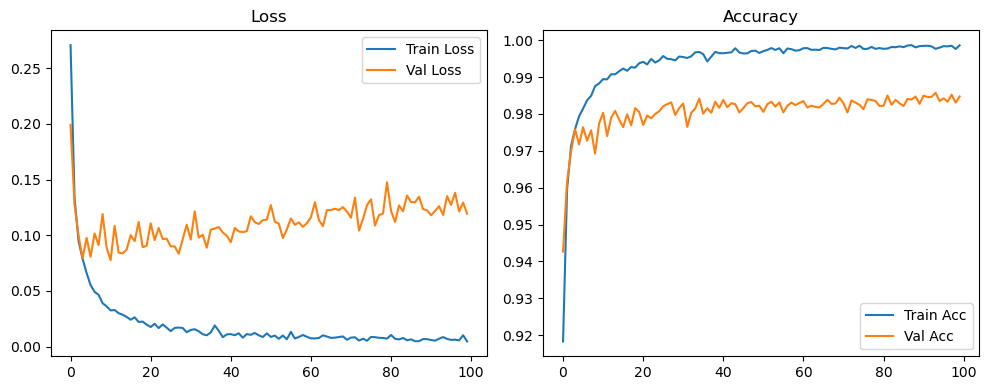

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3293, Acc: 0.9031 | Val Loss: 0.1749, Acc: 0.9494


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1886, Acc: 0.9435 | Val Loss: 0.1267, Acc: 0.9627


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1427, Acc: 0.9568 | Val Loss: 0.0950, Acc: 0.9713


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1210, Acc: 0.9620 | Val Loss: 0.0889, Acc: 0.9715


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1030, Acc: 0.9682 | Val Loss: 0.1024, Acc: 0.9686


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0926, Acc: 0.9708 | Val Loss: 0.0852, Acc: 0.9748


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0885, Acc: 0.9728 | Val Loss: 0.0889, Acc: 0.9734


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9742 | Val Loss: 0.0801, Acc: 0.9770


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0747, Acc: 0.9765 | Val Loss: 0.0863, Acc: 0.9757


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9791 | Val Loss: 0.0828, Acc: 0.9784


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9791 | Val Loss: 0.0755, Acc: 0.9800


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0618, Acc: 0.9809 | Val Loss: 0.0858, Acc: 0.9782


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9804 | Val Loss: 0.0773, Acc: 0.9790


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9827 | Val Loss: 0.0857, Acc: 0.9781


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9820 | Val Loss: 0.0819, Acc: 0.9801


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9839 | Val Loss: 0.0899, Acc: 0.9757


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9839 | Val Loss: 0.0774, Acc: 0.9792


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9850 | Val Loss: 0.0793, Acc: 0.9797


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9849 | Val Loss: 0.0779, Acc: 0.9806


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9859 | Val Loss: 0.0949, Acc: 0.9782


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9865 | Val Loss: 0.0822, Acc: 0.9811


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9876 | Val Loss: 0.0882, Acc: 0.9799


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9872 | Val Loss: 0.0802, Acc: 0.9807


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9884 | Val Loss: 0.0886, Acc: 0.9812


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9871 | Val Loss: 0.1007, Acc: 0.9789


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9884 | Val Loss: 0.0885, Acc: 0.9812


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9882 | Val Loss: 0.0896, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9889 | Val Loss: 0.0790, Acc: 0.9822


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9882 | Val Loss: 0.0814, Acc: 0.9822


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9899 | Val Loss: 0.0859, Acc: 0.9819


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9894 | Val Loss: 0.0805, Acc: 0.9820


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9899 | Val Loss: 0.0893, Acc: 0.9817


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9906 | Val Loss: 0.0944, Acc: 0.9812


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9907 | Val Loss: 0.0874, Acc: 0.9831


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9904 | Val Loss: 0.0925, Acc: 0.9822


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9909 | Val Loss: 0.0937, Acc: 0.9810


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9896 | Val Loss: 0.0935, Acc: 0.9812


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9903 | Val Loss: 0.1073, Acc: 0.9801


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9909 | Val Loss: 0.0936, Acc: 0.9830


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9917 | Val Loss: 0.0935, Acc: 0.9819


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9910 | Val Loss: 0.0955, Acc: 0.9812


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9916 | Val Loss: 0.0928, Acc: 0.9831


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9908 | Val Loss: 0.0924, Acc: 0.9830


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9924 | Val Loss: 0.0891, Acc: 0.9847


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9920 | Val Loss: 0.0943, Acc: 0.9829


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9929 | Val Loss: 0.1067, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9918 | Val Loss: 0.0999, Acc: 0.9827


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9926 | Val Loss: 0.1059, Acc: 0.9828


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9921 | Val Loss: 0.1062, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9919 | Val Loss: 0.0993, Acc: 0.9838


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9932 | Val Loss: 0.1053, Acc: 0.9834


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9932 | Val Loss: 0.1125, Acc: 0.9834


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9938 | Val Loss: 0.0977, Acc: 0.9852


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9924 | Val Loss: 0.0957, Acc: 0.9834


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9925 | Val Loss: 0.1047, Acc: 0.9824


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0302, Acc: 0.9922 | Val Loss: 0.1038, Acc: 0.9836


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9928 | Val Loss: 0.0951, Acc: 0.9836


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9937 | Val Loss: 0.1080, Acc: 0.9831


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9933 | Val Loss: 0.0990, Acc: 0.9834


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9938 | Val Loss: 0.1095, Acc: 0.9822


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9937 | Val Loss: 0.1017, Acc: 0.9832


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9932 | Val Loss: 0.1178, Acc: 0.9823


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9934 | Val Loss: 0.1234, Acc: 0.9834


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9937 | Val Loss: 0.1096, Acc: 0.9838


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9936 | Val Loss: 0.1158, Acc: 0.9844


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9942 | Val Loss: 0.1090, Acc: 0.9847


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0195, Acc: 0.9948 | Val Loss: 0.1170, Acc: 0.9836


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9940 | Val Loss: 0.1149, Acc: 0.9845


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9935 | Val Loss: 0.1249, Acc: 0.9835


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9941 | Val Loss: 0.1164, Acc: 0.9842


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9941 | Val Loss: 0.1188, Acc: 0.9838


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9946 | Val Loss: 0.1282, Acc: 0.9848


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9945 | Val Loss: 0.1128, Acc: 0.9842


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9944 | Val Loss: 0.1135, Acc: 0.9841


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9941 | Val Loss: 0.1200, Acc: 0.9830


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9948 | Val Loss: 0.1271, Acc: 0.9831


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9946 | Val Loss: 0.1418, Acc: 0.9836


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9941 | Val Loss: 0.1352, Acc: 0.9831


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9949 | Val Loss: 0.1260, Acc: 0.9843


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9941 | Val Loss: 0.1280, Acc: 0.9845


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9948 | Val Loss: 0.1228, Acc: 0.9838


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9944 | Val Loss: 0.1235, Acc: 0.9845


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0280, Acc: 0.9938 | Val Loss: 0.1194, Acc: 0.9843


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9952 | Val Loss: 0.1225, Acc: 0.9842


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9951 | Val Loss: 0.1232, Acc: 0.9845


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9942 | Val Loss: 0.1411, Acc: 0.9826


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9949 | Val Loss: 0.1289, Acc: 0.9847


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9953 | Val Loss: 0.1312, Acc: 0.9830


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9950 | Val Loss: 0.1215, Acc: 0.9842


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0230, Acc: 0.9943 | Val Loss: 0.1393, Acc: 0.9831


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9947 | Val Loss: 0.1343, Acc: 0.9848


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9949 | Val Loss: 0.1399, Acc: 0.9836


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9948 | Val Loss: 0.1358, Acc: 0.9842


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9947 | Val Loss: 0.1280, Acc: 0.9847


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9949 | Val Loss: 0.1464, Acc: 0.9844


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9950 | Val Loss: 0.1513, Acc: 0.9843


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9948 | Val Loss: 0.1223, Acc: 0.9861


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9953 | Val Loss: 0.1381, Acc: 0.9845


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9949 | Val Loss: 0.1466, Acc: 0.9840


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9961 | Val Loss: 0.1484, Acc: 0.9857


Final Test Loss: 0.1251 Accuracy: 0.9867


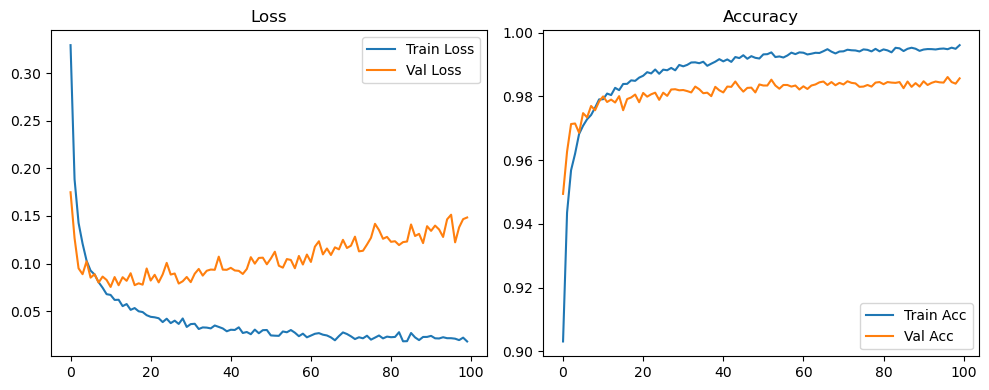

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2576, Acc: 0.9239 | Val Loss: 0.1875, Acc: 0.9460


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1167, Acc: 0.9641 | Val Loss: 0.1188, Acc: 0.9642


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0818, Acc: 0.9740 | Val Loss: 0.0981, Acc: 0.9709


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9816 | Val Loss: 0.0830, Acc: 0.9757


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9842 | Val Loss: 0.0899, Acc: 0.9742


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9872 | Val Loss: 0.1084, Acc: 0.9701


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9885 | Val Loss: 0.1157, Acc: 0.9705


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.1137, Acc: 0.9726


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.1017, Acc: 0.9752


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.0886, Acc: 0.9782


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.0977, Acc: 0.9771


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.0977, Acc: 0.9773


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1133, Acc: 0.9774


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9944 | Val Loss: 0.1071, Acc: 0.9783


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0873, Acc: 0.9794


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9952 | Val Loss: 0.0907, Acc: 0.9802


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.1042, Acc: 0.9783


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.1026, Acc: 0.9782


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0929, Acc: 0.9813


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.0895, Acc: 0.9813


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.0966, Acc: 0.9806


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1206, Acc: 0.9798


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9949 | Val Loss: 0.0961, Acc: 0.9788


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0911, Acc: 0.9802


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0985, Acc: 0.9796


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0912, Acc: 0.9814


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0906, Acc: 0.9809


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0924, Acc: 0.9825


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1105, Acc: 0.9797


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1042, Acc: 0.9812


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1055, Acc: 0.9809


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1009, Acc: 0.9805


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0981, Acc: 0.9805


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0926, Acc: 0.9825


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0996, Acc: 0.9826


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1178, Acc: 0.9804


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9956 | Val Loss: 0.1242, Acc: 0.9769


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0997, Acc: 0.9812


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.0879, Acc: 0.9840


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1002, Acc: 0.9818


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1054, Acc: 0.9808


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1080, Acc: 0.9818


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1069, Acc: 0.9812


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1109, Acc: 0.9822


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1029, Acc: 0.9829


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1114, Acc: 0.9833


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9980 | Val Loss: 0.1290, Acc: 0.9822


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1022, Acc: 0.9822


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1202, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0990, Acc: 0.9812


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1021, Acc: 0.9833


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0896, Acc: 0.9855


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0888, Acc: 0.9853


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0879, Acc: 0.9865


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0897, Acc: 0.9857


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0963, Acc: 0.9845


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1016, Acc: 0.9857


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1040, Acc: 0.9851


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0993, Acc: 0.9854


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0990, Acc: 0.9868


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1136, Acc: 0.9840


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.1101, Acc: 0.9839


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1032, Acc: 0.9848


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1049, Acc: 0.9848


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1004, Acc: 0.9856


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.1016, Acc: 0.9847


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1008, Acc: 0.9851


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1009, Acc: 0.9852


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1035, Acc: 0.9852


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1125, Acc: 0.9853


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1138, Acc: 0.9839


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1226, Acc: 0.9838


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1296, Acc: 0.9817


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1182, Acc: 0.9833


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1177, Acc: 0.9854


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1101, Acc: 0.9850


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1109, Acc: 0.9850


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1088, Acc: 0.9848


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1183, Acc: 0.9848


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1236, Acc: 0.9838


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1200, Acc: 0.9847


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1172, Acc: 0.9852


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1149, Acc: 0.9849


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1131, Acc: 0.9852


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1138, Acc: 0.9843


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1101, Acc: 0.9852


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1112, Acc: 0.9856


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1125, Acc: 0.9856


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1130, Acc: 0.9853


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1129, Acc: 0.9858


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1085, Acc: 0.9856


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1092, Acc: 0.9860


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1085, Acc: 0.9861


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1155, Acc: 0.9861


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1171, Acc: 0.9860


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1156, Acc: 0.9864


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1163, Acc: 0.9857


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1154, Acc: 0.9860


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1152, Acc: 0.9852


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1140, Acc: 0.9850


Final Test Loss: 0.1175 Accuracy: 0.9845


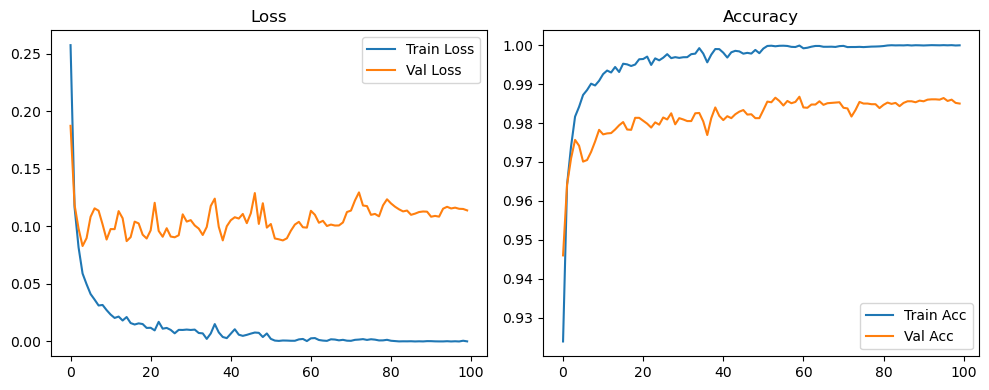

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2708, Acc: 0.9183 | Val Loss: 0.1993, Acc: 0.9427


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1334, Acc: 0.9595 | Val Loss: 0.1273, Acc: 0.9616


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0948, Acc: 0.9713 | Val Loss: 0.0997, Acc: 0.9698


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0790, Acc: 0.9759 | Val Loss: 0.0793, Acc: 0.9758


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0662, Acc: 0.9794 | Val Loss: 0.0977, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9815 | Val Loss: 0.0807, Acc: 0.9764


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9837 | Val Loss: 0.1017, Acc: 0.9728


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9849 | Val Loss: 0.0912, Acc: 0.9756


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9876 | Val Loss: 0.1191, Acc: 0.9692


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9883 | Val Loss: 0.0890, Acc: 0.9774


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9895 | Val Loss: 0.0776, Acc: 0.9803


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9894 | Val Loss: 0.1085, Acc: 0.9740


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9908 | Val Loss: 0.0844, Acc: 0.9789


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9908 | Val Loss: 0.0837, Acc: 0.9808


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9916 | Val Loss: 0.0871, Acc: 0.9785


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9923 | Val Loss: 0.1002, Acc: 0.9764


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.0947, Acc: 0.9799


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 0.1120, Acc: 0.9769


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0893, Acc: 0.9816


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.0906, Acc: 0.9806


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.1108, Acc: 0.9770


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.0957, Acc: 0.9796


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9949 | Val Loss: 0.1066, Acc: 0.9788


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9940 | Val Loss: 0.0967, Acc: 0.9800


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0969, Acc: 0.9808


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.0901, Acc: 0.9821


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9950 | Val Loss: 0.0900, Acc: 0.9827


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9949 | Val Loss: 0.0834, Acc: 0.9832


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.0965, Acc: 0.9798


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1095, Acc: 0.9816


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.0961, Acc: 0.9828


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9952 | Val Loss: 0.1215, Acc: 0.9765


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9957 | Val Loss: 0.0979, Acc: 0.9803


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9968 | Val Loss: 0.1005, Acc: 0.9815


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0888, Acc: 0.9842


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9962 | Val Loss: 0.1051, Acc: 0.9801


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9943 | Val Loss: 0.1060, Acc: 0.9816


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9956 | Val Loss: 0.1074, Acc: 0.9803


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9969 | Val Loss: 0.1025, Acc: 0.9833


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0996, Acc: 0.9817


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0938, Acc: 0.9838


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1066, Acc: 0.9818


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9967 | Val Loss: 0.1035, Acc: 0.9829


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9979 | Val Loss: 0.1029, Acc: 0.9827


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9967 | Val Loss: 0.1037, Acc: 0.9804


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1171, Acc: 0.9816


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9965 | Val Loss: 0.1117, Acc: 0.9829


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.1102, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1136, Acc: 0.9821


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9966 | Val Loss: 0.1141, Acc: 0.9822


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1021, Acc: 0.9832


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1029, Acc: 0.9838


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0971, Acc: 0.9851


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0945, Acc: 0.9851


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0993, Acc: 0.9857


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1035, Acc: 0.9836


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1086, Acc: 0.9851


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0998, Acc: 0.9863


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1125, Acc: 0.9859


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.1034, Acc: 0.9860


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1062, Acc: 0.9857


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1068, Acc: 0.9854


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1129, Acc: 0.9851


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1083, Acc: 0.9852


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1138, Acc: 0.9832


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1123, Acc: 0.9839


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1130, Acc: 0.9833


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1140, Acc: 0.9846


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1160, Acc: 0.9848


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1138, Acc: 0.9853


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1195, Acc: 0.9844


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1344, Acc: 0.9837


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1315, Acc: 0.9838


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1232, Acc: 0.9829


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1294, Acc: 0.9829


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1260, Acc: 0.9841


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1160, Acc: 0.9858


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.1013, Acc: 0.9864


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1216, Acc: 0.9837


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1168, Acc: 0.9845


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1149, Acc: 0.9857


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1142, Acc: 0.9858


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1148, Acc: 0.9849


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1104, Acc: 0.9852


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1088, Acc: 0.9864


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1112, Acc: 0.9862


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1113, Acc: 0.9861


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1137, Acc: 0.9858


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1162, Acc: 0.9855


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1146, Acc: 0.9861


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1126, Acc: 0.9868


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1176, Acc: 0.9857


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1183, Acc: 0.9858


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1223, Acc: 0.9857


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1227, Acc: 0.9864


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1204, Acc: 0.9859


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1179, Acc: 0.9862


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1163, Acc: 0.9863


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1181, Acc: 0.9859


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1267, Acc: 0.9847


Final Test Loss: 0.1181 Accuracy: 0.9856


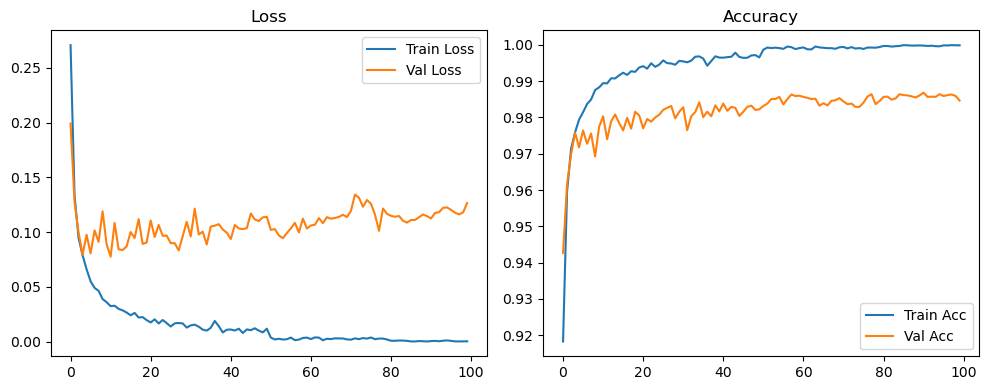

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3293, Acc: 0.9031 | Val Loss: 0.1749, Acc: 0.9494


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1886, Acc: 0.9435 | Val Loss: 0.1267, Acc: 0.9627


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1427, Acc: 0.9568 | Val Loss: 0.0950, Acc: 0.9713


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1210, Acc: 0.9620 | Val Loss: 0.0889, Acc: 0.9715


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1030, Acc: 0.9682 | Val Loss: 0.1024, Acc: 0.9686


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0926, Acc: 0.9708 | Val Loss: 0.0852, Acc: 0.9748


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0885, Acc: 0.9728 | Val Loss: 0.0889, Acc: 0.9734


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9742 | Val Loss: 0.0801, Acc: 0.9770


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0747, Acc: 0.9765 | Val Loss: 0.0863, Acc: 0.9757


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9791 | Val Loss: 0.0828, Acc: 0.9784


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9791 | Val Loss: 0.0755, Acc: 0.9800


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0618, Acc: 0.9809 | Val Loss: 0.0858, Acc: 0.9782


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9804 | Val Loss: 0.0773, Acc: 0.9790


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9827 | Val Loss: 0.0857, Acc: 0.9781


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9820 | Val Loss: 0.0819, Acc: 0.9801


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9839 | Val Loss: 0.0899, Acc: 0.9757


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9839 | Val Loss: 0.0774, Acc: 0.9792


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9850 | Val Loss: 0.0793, Acc: 0.9797


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9849 | Val Loss: 0.0779, Acc: 0.9806


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9859 | Val Loss: 0.0949, Acc: 0.9782


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9865 | Val Loss: 0.0822, Acc: 0.9811


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9876 | Val Loss: 0.0882, Acc: 0.9799


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9872 | Val Loss: 0.0802, Acc: 0.9807


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9884 | Val Loss: 0.0886, Acc: 0.9812


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9871 | Val Loss: 0.1007, Acc: 0.9789


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9884 | Val Loss: 0.0885, Acc: 0.9812


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9882 | Val Loss: 0.0896, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9889 | Val Loss: 0.0790, Acc: 0.9822


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9882 | Val Loss: 0.0814, Acc: 0.9822


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9899 | Val Loss: 0.0859, Acc: 0.9819


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9894 | Val Loss: 0.0805, Acc: 0.9820


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9899 | Val Loss: 0.0893, Acc: 0.9817


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9906 | Val Loss: 0.0944, Acc: 0.9812


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9907 | Val Loss: 0.0874, Acc: 0.9831


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9904 | Val Loss: 0.0925, Acc: 0.9822


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9909 | Val Loss: 0.0937, Acc: 0.9810


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9896 | Val Loss: 0.0935, Acc: 0.9812


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9903 | Val Loss: 0.1073, Acc: 0.9801


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9909 | Val Loss: 0.0936, Acc: 0.9830


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9917 | Val Loss: 0.0935, Acc: 0.9819


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9910 | Val Loss: 0.0955, Acc: 0.9812


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9916 | Val Loss: 0.0928, Acc: 0.9831


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9908 | Val Loss: 0.0924, Acc: 0.9830


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9924 | Val Loss: 0.0891, Acc: 0.9847


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9920 | Val Loss: 0.0943, Acc: 0.9829


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9929 | Val Loss: 0.1067, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9918 | Val Loss: 0.0999, Acc: 0.9827


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9926 | Val Loss: 0.1059, Acc: 0.9828


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9921 | Val Loss: 0.1062, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9919 | Val Loss: 0.0993, Acc: 0.9838


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9947 | Val Loss: 0.0901, Acc: 0.9845


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.0878, Acc: 0.9863


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9970 | Val Loss: 0.0880, Acc: 0.9851


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.0872, Acc: 0.9850


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0837, Acc: 0.9858


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9968 | Val Loss: 0.0825, Acc: 0.9868


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.0823, Acc: 0.9864


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.0967, Acc: 0.9847


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.0885, Acc: 0.9845


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.0953, Acc: 0.9855


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.0958, Acc: 0.9864


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9970 | Val Loss: 0.0941, Acc: 0.9858


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.1009, Acc: 0.9852


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9972 | Val Loss: 0.0983, Acc: 0.9847


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1023, Acc: 0.9847


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9970 | Val Loss: 0.0984, Acc: 0.9850


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0998, Acc: 0.9854


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1052, Acc: 0.9861


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9968 | Val Loss: 0.0984, Acc: 0.9863


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1017, Acc: 0.9854


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.1047, Acc: 0.9849


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9977 | Val Loss: 0.1079, Acc: 0.9851


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1013, Acc: 0.9846


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9972 | Val Loss: 0.0982, Acc: 0.9849


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1057, Acc: 0.9843


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9974 | Val Loss: 0.1022, Acc: 0.9856


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1033, Acc: 0.9858


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.1058, Acc: 0.9860


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9975 | Val Loss: 0.1103, Acc: 0.9858


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1045, Acc: 0.9864


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9981 | Val Loss: 0.0953, Acc: 0.9868


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0977, Acc: 0.9868


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1002, Acc: 0.9862


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1011, Acc: 0.9864


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.0974, Acc: 0.9869


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1016, Acc: 0.9858


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1019, Acc: 0.9867


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1010, Acc: 0.9862


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1047, Acc: 0.9866


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1081, Acc: 0.9864


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1036, Acc: 0.9868


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1065, Acc: 0.9860


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1037, Acc: 0.9867


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9990 | Val Loss: 0.0996, Acc: 0.9866


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1070, Acc: 0.9849


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0992, Acc: 0.9866


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1055, Acc: 0.9856


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1010, Acc: 0.9865


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1046, Acc: 0.9866


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1059, Acc: 0.9864


Final Test Loss: 0.0890 Accuracy: 0.9885


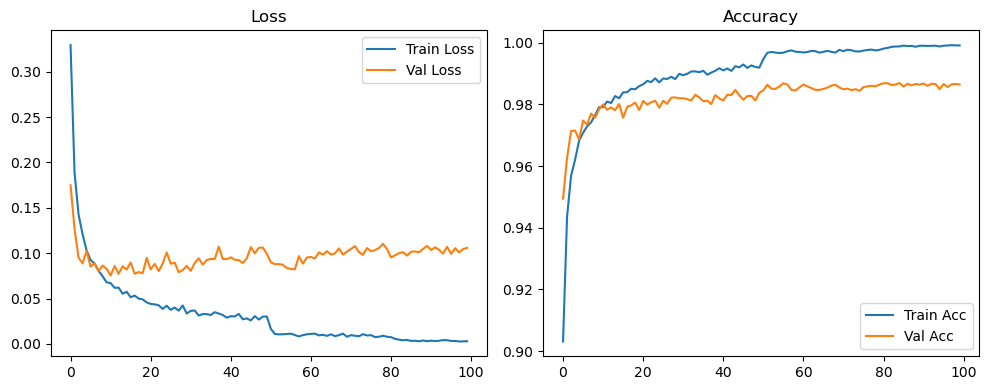

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2576, Acc: 0.9239 | Val Loss: 0.1875, Acc: 0.9460


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1167, Acc: 0.9641 | Val Loss: 0.1188, Acc: 0.9642


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0818, Acc: 0.9740 | Val Loss: 0.0981, Acc: 0.9709


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9816 | Val Loss: 0.0830, Acc: 0.9757


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9842 | Val Loss: 0.0899, Acc: 0.9742


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9872 | Val Loss: 0.1084, Acc: 0.9701


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9885 | Val Loss: 0.1157, Acc: 0.9705


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.1137, Acc: 0.9726


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.1017, Acc: 0.9752


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.0886, Acc: 0.9782


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.0977, Acc: 0.9771


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.0977, Acc: 0.9773


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1133, Acc: 0.9774


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9944 | Val Loss: 0.1071, Acc: 0.9783


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0873, Acc: 0.9794


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9952 | Val Loss: 0.0907, Acc: 0.9802


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.1042, Acc: 0.9783


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.1026, Acc: 0.9782


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0929, Acc: 0.9813


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.0895, Acc: 0.9813


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.0966, Acc: 0.9806


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1206, Acc: 0.9798


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9949 | Val Loss: 0.0961, Acc: 0.9788


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0911, Acc: 0.9802


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0985, Acc: 0.9796


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0912, Acc: 0.9814


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0906, Acc: 0.9809


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0924, Acc: 0.9825


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1105, Acc: 0.9797


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1042, Acc: 0.9812


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1055, Acc: 0.9809


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1009, Acc: 0.9805


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0981, Acc: 0.9805


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0926, Acc: 0.9825


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0996, Acc: 0.9826


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1178, Acc: 0.9804


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9956 | Val Loss: 0.1242, Acc: 0.9769


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0997, Acc: 0.9812


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.0879, Acc: 0.9840


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1002, Acc: 0.9818


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1054, Acc: 0.9808


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1080, Acc: 0.9818


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1069, Acc: 0.9812


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1109, Acc: 0.9822


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1029, Acc: 0.9829


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1114, Acc: 0.9833


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9980 | Val Loss: 0.1290, Acc: 0.9822


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1022, Acc: 0.9822


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1202, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0990, Acc: 0.9812


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1021, Acc: 0.9833


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0896, Acc: 0.9855


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0888, Acc: 0.9853


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0879, Acc: 0.9865


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0897, Acc: 0.9857


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0963, Acc: 0.9845


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1016, Acc: 0.9857


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1040, Acc: 0.9851


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0993, Acc: 0.9854


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0990, Acc: 0.9868


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1136, Acc: 0.9840


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.1101, Acc: 0.9839


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1032, Acc: 0.9848


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1049, Acc: 0.9848


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1004, Acc: 0.9856


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.1016, Acc: 0.9847


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1008, Acc: 0.9851


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1009, Acc: 0.9852


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1035, Acc: 0.9852


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1125, Acc: 0.9853


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1138, Acc: 0.9839


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1226, Acc: 0.9838


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1296, Acc: 0.9817


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1182, Acc: 0.9833


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1177, Acc: 0.9854


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1101, Acc: 0.9850


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1109, Acc: 0.9850


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1088, Acc: 0.9848


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1183, Acc: 0.9848


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1236, Acc: 0.9838


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1174, Acc: 0.9848


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1149, Acc: 0.9849


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1131, Acc: 0.9854


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1137, Acc: 0.9851


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1132, Acc: 0.9853


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1130, Acc: 0.9851


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1125, Acc: 0.9857


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1129, Acc: 0.9854


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1138, Acc: 0.9858


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1132, Acc: 0.9852


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1118, Acc: 0.9853


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1134, Acc: 0.9856


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1124, Acc: 0.9856


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1170, Acc: 0.9857


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1142, Acc: 0.9853


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1125, Acc: 0.9856


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1145, Acc: 0.9853


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1142, Acc: 0.9854


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1186, Acc: 0.9854


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1160, Acc: 0.9856


Final Test Loss: 0.1120 Accuracy: 0.9857


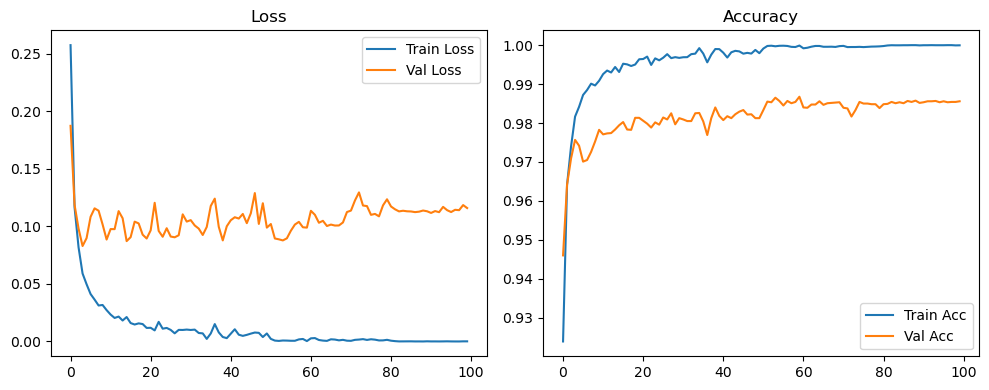

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2708, Acc: 0.9183 | Val Loss: 0.1993, Acc: 0.9427


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1334, Acc: 0.9595 | Val Loss: 0.1273, Acc: 0.9616


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0948, Acc: 0.9713 | Val Loss: 0.0997, Acc: 0.9698


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0790, Acc: 0.9759 | Val Loss: 0.0793, Acc: 0.9758


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0662, Acc: 0.9794 | Val Loss: 0.0977, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9815 | Val Loss: 0.0807, Acc: 0.9764


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9837 | Val Loss: 0.1017, Acc: 0.9728


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9849 | Val Loss: 0.0912, Acc: 0.9756


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9876 | Val Loss: 0.1191, Acc: 0.9692


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9883 | Val Loss: 0.0890, Acc: 0.9774


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9895 | Val Loss: 0.0776, Acc: 0.9803


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9894 | Val Loss: 0.1085, Acc: 0.9740


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9908 | Val Loss: 0.0844, Acc: 0.9789


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9908 | Val Loss: 0.0837, Acc: 0.9808


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9916 | Val Loss: 0.0871, Acc: 0.9785


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9923 | Val Loss: 0.1002, Acc: 0.9764


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.0947, Acc: 0.9799


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 0.1120, Acc: 0.9769


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0893, Acc: 0.9816


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.0906, Acc: 0.9806


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.1108, Acc: 0.9770


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.0957, Acc: 0.9796


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9949 | Val Loss: 0.1066, Acc: 0.9788


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9940 | Val Loss: 0.0967, Acc: 0.9800


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0969, Acc: 0.9808


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.0901, Acc: 0.9821


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9950 | Val Loss: 0.0900, Acc: 0.9827


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9949 | Val Loss: 0.0834, Acc: 0.9832


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.0965, Acc: 0.9798


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1095, Acc: 0.9816


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.0961, Acc: 0.9828


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9952 | Val Loss: 0.1215, Acc: 0.9765


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9957 | Val Loss: 0.0979, Acc: 0.9803


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9968 | Val Loss: 0.1005, Acc: 0.9815


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0888, Acc: 0.9842


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9962 | Val Loss: 0.1051, Acc: 0.9801


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9943 | Val Loss: 0.1060, Acc: 0.9816


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9956 | Val Loss: 0.1074, Acc: 0.9803


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9969 | Val Loss: 0.1025, Acc: 0.9833


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0996, Acc: 0.9817


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0938, Acc: 0.9838


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1066, Acc: 0.9818


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9967 | Val Loss: 0.1035, Acc: 0.9829


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9979 | Val Loss: 0.1029, Acc: 0.9827


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9967 | Val Loss: 0.1037, Acc: 0.9804


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1171, Acc: 0.9816


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9965 | Val Loss: 0.1117, Acc: 0.9829


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.1102, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1136, Acc: 0.9821


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9966 | Val Loss: 0.1141, Acc: 0.9822


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1021, Acc: 0.9832


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1029, Acc: 0.9838


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0971, Acc: 0.9851


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0945, Acc: 0.9851


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0993, Acc: 0.9857


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1035, Acc: 0.9836


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1086, Acc: 0.9851


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0998, Acc: 0.9863


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1125, Acc: 0.9859


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.1034, Acc: 0.9860


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1062, Acc: 0.9857


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1068, Acc: 0.9854


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1129, Acc: 0.9851


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1083, Acc: 0.9852


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1138, Acc: 0.9832


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1123, Acc: 0.9839


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1130, Acc: 0.9833


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1140, Acc: 0.9846


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1160, Acc: 0.9848


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1138, Acc: 0.9853


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1195, Acc: 0.9844


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1344, Acc: 0.9837


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1315, Acc: 0.9838


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1232, Acc: 0.9829


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1294, Acc: 0.9829


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1260, Acc: 0.9841


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1160, Acc: 0.9858


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.1013, Acc: 0.9864


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1216, Acc: 0.9837


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1168, Acc: 0.9845


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1139, Acc: 0.9854


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1131, Acc: 0.9857


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1124, Acc: 0.9851


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1098, Acc: 0.9852


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1088, Acc: 0.9858


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1101, Acc: 0.9859


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.1095, Acc: 0.9861


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1114, Acc: 0.9859


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1167, Acc: 0.9860


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1122, Acc: 0.9865


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1112, Acc: 0.9866


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1145, Acc: 0.9864


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1128, Acc: 0.9863


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1160, Acc: 0.9865


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1149, Acc: 0.9869


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1116, Acc: 0.9871


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1100, Acc: 0.9869


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1095, Acc: 0.9865


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1109, Acc: 0.9873


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1118, Acc: 0.9861


Final Test Loss: 0.1038 Accuracy: 0.9870


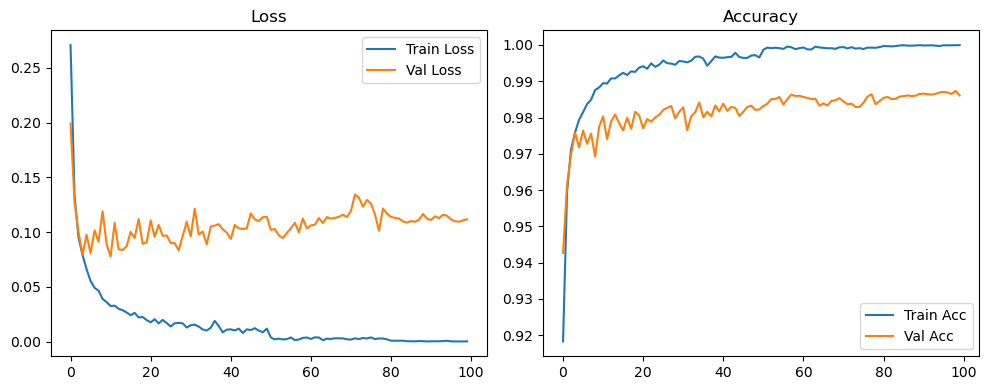

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3293, Acc: 0.9031 | Val Loss: 0.1749, Acc: 0.9494


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1886, Acc: 0.9435 | Val Loss: 0.1267, Acc: 0.9627


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1427, Acc: 0.9568 | Val Loss: 0.0950, Acc: 0.9713


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1210, Acc: 0.9620 | Val Loss: 0.0889, Acc: 0.9715


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1030, Acc: 0.9682 | Val Loss: 0.1024, Acc: 0.9686


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0926, Acc: 0.9708 | Val Loss: 0.0852, Acc: 0.9748


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0885, Acc: 0.9728 | Val Loss: 0.0889, Acc: 0.9734


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9742 | Val Loss: 0.0801, Acc: 0.9770


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0747, Acc: 0.9765 | Val Loss: 0.0863, Acc: 0.9757


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9791 | Val Loss: 0.0828, Acc: 0.9784


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9791 | Val Loss: 0.0755, Acc: 0.9800


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0618, Acc: 0.9809 | Val Loss: 0.0858, Acc: 0.9782


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9804 | Val Loss: 0.0773, Acc: 0.9790


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9827 | Val Loss: 0.0857, Acc: 0.9781


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9820 | Val Loss: 0.0819, Acc: 0.9801


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9839 | Val Loss: 0.0899, Acc: 0.9757


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9839 | Val Loss: 0.0774, Acc: 0.9792


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9850 | Val Loss: 0.0793, Acc: 0.9797


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9849 | Val Loss: 0.0779, Acc: 0.9806


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9859 | Val Loss: 0.0949, Acc: 0.9782


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9865 | Val Loss: 0.0822, Acc: 0.9811


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9876 | Val Loss: 0.0882, Acc: 0.9799


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9872 | Val Loss: 0.0802, Acc: 0.9807


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9884 | Val Loss: 0.0886, Acc: 0.9812


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9871 | Val Loss: 0.1007, Acc: 0.9789


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9884 | Val Loss: 0.0885, Acc: 0.9812


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9882 | Val Loss: 0.0896, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9889 | Val Loss: 0.0790, Acc: 0.9822


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9882 | Val Loss: 0.0814, Acc: 0.9822


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9899 | Val Loss: 0.0859, Acc: 0.9819


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9894 | Val Loss: 0.0805, Acc: 0.9820


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9899 | Val Loss: 0.0893, Acc: 0.9817


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9906 | Val Loss: 0.0944, Acc: 0.9812


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9907 | Val Loss: 0.0874, Acc: 0.9831


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9904 | Val Loss: 0.0925, Acc: 0.9822


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9909 | Val Loss: 0.0937, Acc: 0.9810


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9896 | Val Loss: 0.0935, Acc: 0.9812


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9903 | Val Loss: 0.1073, Acc: 0.9801


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9909 | Val Loss: 0.0936, Acc: 0.9830


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9917 | Val Loss: 0.0935, Acc: 0.9819


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9910 | Val Loss: 0.0955, Acc: 0.9812


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9916 | Val Loss: 0.0928, Acc: 0.9831


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9908 | Val Loss: 0.0924, Acc: 0.9830


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9924 | Val Loss: 0.0891, Acc: 0.9847


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9920 | Val Loss: 0.0943, Acc: 0.9829


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9929 | Val Loss: 0.1067, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9918 | Val Loss: 0.0999, Acc: 0.9827


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9926 | Val Loss: 0.1059, Acc: 0.9828


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9921 | Val Loss: 0.1062, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9919 | Val Loss: 0.0993, Acc: 0.9838


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9947 | Val Loss: 0.0901, Acc: 0.9845


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.0878, Acc: 0.9863


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9970 | Val Loss: 0.0880, Acc: 0.9851


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.0872, Acc: 0.9850


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0837, Acc: 0.9858


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9968 | Val Loss: 0.0825, Acc: 0.9868


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9972 | Val Loss: 0.0823, Acc: 0.9864


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.0967, Acc: 0.9847


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9971 | Val Loss: 0.0885, Acc: 0.9845


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9970 | Val Loss: 0.0953, Acc: 0.9855


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.0958, Acc: 0.9864


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9970 | Val Loss: 0.0941, Acc: 0.9858


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.1009, Acc: 0.9852


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9972 | Val Loss: 0.0983, Acc: 0.9847


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1023, Acc: 0.9847


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9970 | Val Loss: 0.0984, Acc: 0.9850


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0998, Acc: 0.9854


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1052, Acc: 0.9861


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9968 | Val Loss: 0.0984, Acc: 0.9863


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1017, Acc: 0.9854


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.1047, Acc: 0.9849


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9977 | Val Loss: 0.1079, Acc: 0.9851


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1013, Acc: 0.9846


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9972 | Val Loss: 0.0982, Acc: 0.9849


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1057, Acc: 0.9843


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9974 | Val Loss: 0.1022, Acc: 0.9856


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1033, Acc: 0.9858


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.1058, Acc: 0.9860


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9975 | Val Loss: 0.1103, Acc: 0.9858


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1045, Acc: 0.9864


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9981 | Val Loss: 0.0957, Acc: 0.9870


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9985 | Val Loss: 0.0952, Acc: 0.9869


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.0987, Acc: 0.9869


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0956, Acc: 0.9870


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.0952, Acc: 0.9868


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0961, Acc: 0.9859


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0961, Acc: 0.9875


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9989 | Val Loss: 0.0948, Acc: 0.9872


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0959, Acc: 0.9870


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0975, Acc: 0.9872


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.0965, Acc: 0.9877


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0960, Acc: 0.9871


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0955, Acc: 0.9872


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0944, Acc: 0.9874


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0995, Acc: 0.9864


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0957, Acc: 0.9867


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0986, Acc: 0.9864


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0947, Acc: 0.9868


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0973, Acc: 0.9871


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0965, Acc: 0.9869


Final Test Loss: 0.0867 Accuracy: 0.9879


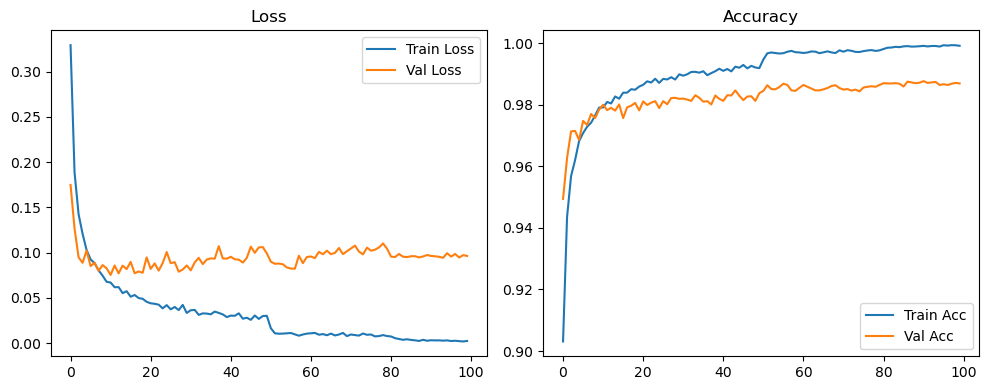

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2576, Acc: 0.9239 | Val Loss: 0.1875, Acc: 0.9460


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1167, Acc: 0.9641 | Val Loss: 0.1188, Acc: 0.9642


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0818, Acc: 0.9740 | Val Loss: 0.0981, Acc: 0.9709


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0591, Acc: 0.9816 | Val Loss: 0.0830, Acc: 0.9757


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9842 | Val Loss: 0.0899, Acc: 0.9742


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9872 | Val Loss: 0.1084, Acc: 0.9701


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0364, Acc: 0.9885 | Val Loss: 0.1157, Acc: 0.9705


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9901 | Val Loss: 0.1137, Acc: 0.9726


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.1017, Acc: 0.9752


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9909 | Val Loss: 0.0886, Acc: 0.9782


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.0977, Acc: 0.9771


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.0977, Acc: 0.9773


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1133, Acc: 0.9774


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9944 | Val Loss: 0.1071, Acc: 0.9783


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0873, Acc: 0.9794


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9952 | Val Loss: 0.0907, Acc: 0.9802


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.1042, Acc: 0.9783


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.1026, Acc: 0.9782


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0929, Acc: 0.9813


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.0895, Acc: 0.9813


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9964 | Val Loss: 0.0966, Acc: 0.9806


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1206, Acc: 0.9798


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9949 | Val Loss: 0.0961, Acc: 0.9788


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0911, Acc: 0.9802


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0985, Acc: 0.9796


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0912, Acc: 0.9814


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0906, Acc: 0.9809


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.0924, Acc: 0.9825


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1105, Acc: 0.9797


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1042, Acc: 0.9812


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1055, Acc: 0.9809


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1009, Acc: 0.9805


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0981, Acc: 0.9805


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0926, Acc: 0.9825


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0996, Acc: 0.9826


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1178, Acc: 0.9804


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9956 | Val Loss: 0.1242, Acc: 0.9769


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.0997, Acc: 0.9812


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.0879, Acc: 0.9840


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1002, Acc: 0.9818


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1054, Acc: 0.9808


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1080, Acc: 0.9818


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1069, Acc: 0.9812


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1109, Acc: 0.9822


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9984 | Val Loss: 0.1029, Acc: 0.9829


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1114, Acc: 0.9833


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9980 | Val Loss: 0.1290, Acc: 0.9822


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1022, Acc: 0.9822


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1202, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0990, Acc: 0.9812


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0926, Acc: 0.9835


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0884, Acc: 0.9848


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0890, Acc: 0.9842


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0845, Acc: 0.9857


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0885, Acc: 0.9856


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0877, Acc: 0.9852


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0870, Acc: 0.9867


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0907, Acc: 0.9859


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0891, Acc: 0.9867


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0914, Acc: 0.9863


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0917, Acc: 0.9864


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0968, Acc: 0.9859


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0954, Acc: 0.9862


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1020, Acc: 0.9853


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1021, Acc: 0.9863


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1014, Acc: 0.9869


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1029, Acc: 0.9858


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1028, Acc: 0.9858


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1003, Acc: 0.9863


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1034, Acc: 0.9855


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1025, Acc: 0.9855


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1054, Acc: 0.9849


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1095, Acc: 0.9858


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1070, Acc: 0.9859


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1068, Acc: 0.9866


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1099, Acc: 0.9869


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1069, Acc: 0.9866


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1080, Acc: 0.9866


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1075, Acc: 0.9868


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1101, Acc: 0.9858


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1111, Acc: 0.9868


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1126, Acc: 0.9872


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1127, Acc: 0.9868


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1174, Acc: 0.9860


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1147, Acc: 0.9868


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1164, Acc: 0.9870


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1154, Acc: 0.9870


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1158, Acc: 0.9869


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1168, Acc: 0.9869


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1149, Acc: 0.9864


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1150, Acc: 0.9864


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1215, Acc: 0.9860


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1163, Acc: 0.9861


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1206, Acc: 0.9859


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1201, Acc: 0.9858


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1159, Acc: 0.9868


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1183, Acc: 0.9861


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1171, Acc: 0.9864


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1191, Acc: 0.9861


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1187, Acc: 0.9860


Final Test Loss: 0.1140 Accuracy: 0.9870


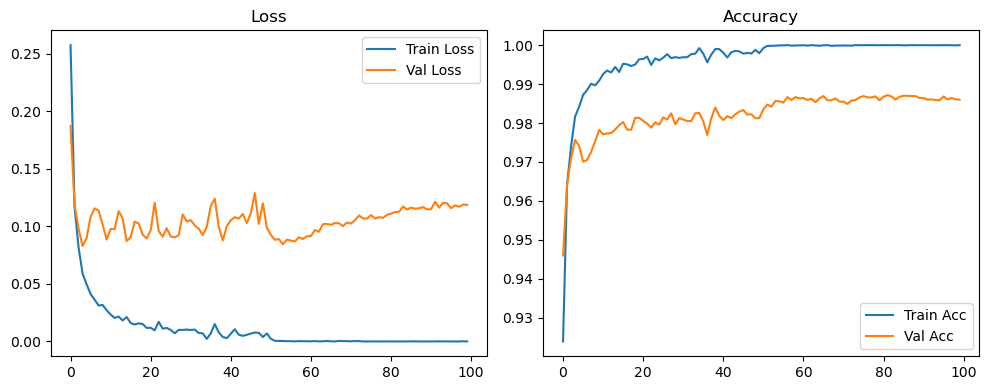

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2708, Acc: 0.9183 | Val Loss: 0.1993, Acc: 0.9427


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1334, Acc: 0.9595 | Val Loss: 0.1273, Acc: 0.9616


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0948, Acc: 0.9713 | Val Loss: 0.0997, Acc: 0.9698


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0790, Acc: 0.9759 | Val Loss: 0.0793, Acc: 0.9758


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0662, Acc: 0.9794 | Val Loss: 0.0977, Acc: 0.9718


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9815 | Val Loss: 0.0807, Acc: 0.9764


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0492, Acc: 0.9837 | Val Loss: 0.1017, Acc: 0.9728


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9849 | Val Loss: 0.0912, Acc: 0.9756


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9876 | Val Loss: 0.1191, Acc: 0.9692


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0361, Acc: 0.9883 | Val Loss: 0.0890, Acc: 0.9774


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0325, Acc: 0.9895 | Val Loss: 0.0776, Acc: 0.9803


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9894 | Val Loss: 0.1085, Acc: 0.9740


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0300, Acc: 0.9908 | Val Loss: 0.0844, Acc: 0.9789


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0287, Acc: 0.9908 | Val Loss: 0.0837, Acc: 0.9808


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9916 | Val Loss: 0.0871, Acc: 0.9785


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9923 | Val Loss: 0.1002, Acc: 0.9764


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9917 | Val Loss: 0.0947, Acc: 0.9799


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9928 | Val Loss: 0.1120, Acc: 0.9769


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.0893, Acc: 0.9816


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.0906, Acc: 0.9806


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.1108, Acc: 0.9770


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9935 | Val Loss: 0.0957, Acc: 0.9796


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9949 | Val Loss: 0.1066, Acc: 0.9788


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9940 | Val Loss: 0.0967, Acc: 0.9800


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0969, Acc: 0.9808


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9957 | Val Loss: 0.0901, Acc: 0.9821


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9950 | Val Loss: 0.0900, Acc: 0.9827


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9949 | Val Loss: 0.0834, Acc: 0.9832


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.0965, Acc: 0.9798


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1095, Acc: 0.9816


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.0961, Acc: 0.9828


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9952 | Val Loss: 0.1215, Acc: 0.9765


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9957 | Val Loss: 0.0979, Acc: 0.9803


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9968 | Val Loss: 0.1005, Acc: 0.9815


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.0888, Acc: 0.9842


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9962 | Val Loss: 0.1051, Acc: 0.9801


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9943 | Val Loss: 0.1060, Acc: 0.9816


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9956 | Val Loss: 0.1074, Acc: 0.9803


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9969 | Val Loss: 0.1025, Acc: 0.9833


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0996, Acc: 0.9817


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0938, Acc: 0.9838


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9966 | Val Loss: 0.1066, Acc: 0.9818


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9967 | Val Loss: 0.1035, Acc: 0.9829


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9979 | Val Loss: 0.1029, Acc: 0.9827


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9967 | Val Loss: 0.1037, Acc: 0.9804


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1171, Acc: 0.9816


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9965 | Val Loss: 0.1117, Acc: 0.9829


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.1102, Acc: 0.9832


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1136, Acc: 0.9821


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9966 | Val Loss: 0.1141, Acc: 0.9822


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0959, Acc: 0.9839


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0911, Acc: 0.9854


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0908, Acc: 0.9858


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0872, Acc: 0.9858


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0889, Acc: 0.9862


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0921, Acc: 0.9851


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0952, Acc: 0.9852


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0909, Acc: 0.9853


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0944, Acc: 0.9856


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0961, Acc: 0.9869


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0949, Acc: 0.9862


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1008, Acc: 0.9852


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1023, Acc: 0.9853


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1015, Acc: 0.9858


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1072, Acc: 0.9849


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1036, Acc: 0.9850


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1008, Acc: 0.9852


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0993, Acc: 0.9858


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1004, Acc: 0.9857


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1031, Acc: 0.9856


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1009, Acc: 0.9858


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1055, Acc: 0.9858


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1052, Acc: 0.9851


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1061, Acc: 0.9852


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1123, Acc: 0.9851


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1088, Acc: 0.9863


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9997 | Val Loss: 0.1046, Acc: 0.9858


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0992, Acc: 0.9866


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1027, Acc: 0.9866


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1041, Acc: 0.9866


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0995, Acc: 0.9868


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1020, Acc: 0.9870


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1001, Acc: 0.9868


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0973, Acc: 0.9869


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0986, Acc: 0.9865


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0985, Acc: 0.9865


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1022, Acc: 0.9869


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1030, Acc: 0.9872


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1048, Acc: 0.9868


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1031, Acc: 0.9868


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1077, Acc: 0.9868


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1106, Acc: 0.9863


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1070, Acc: 0.9866


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1089, Acc: 0.9869


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1103, Acc: 0.9876


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1053, Acc: 0.9879


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1055, Acc: 0.9874


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1047, Acc: 0.9868


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1101, Acc: 0.9867


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1086, Acc: 0.9868


Final Test Loss: 0.0975 Accuracy: 0.9871


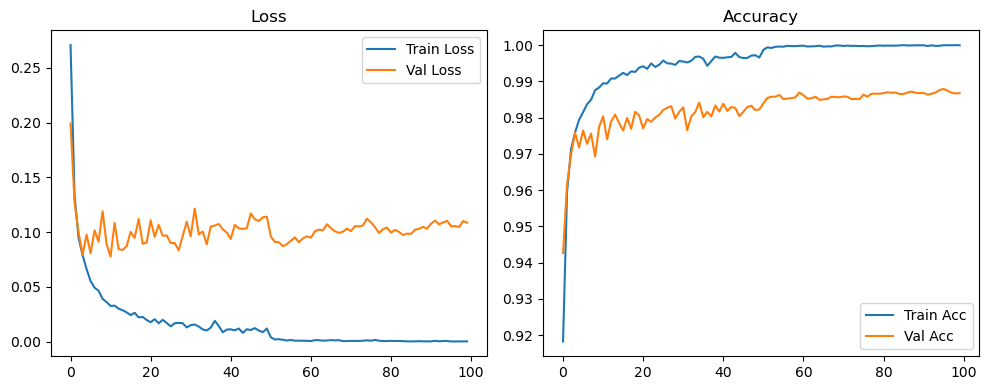

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3293, Acc: 0.9031 | Val Loss: 0.1749, Acc: 0.9494


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1886, Acc: 0.9435 | Val Loss: 0.1267, Acc: 0.9627


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1427, Acc: 0.9568 | Val Loss: 0.0950, Acc: 0.9713


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1210, Acc: 0.9620 | Val Loss: 0.0889, Acc: 0.9715


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1030, Acc: 0.9682 | Val Loss: 0.1024, Acc: 0.9686


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0926, Acc: 0.9708 | Val Loss: 0.0852, Acc: 0.9748


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0885, Acc: 0.9728 | Val Loss: 0.0889, Acc: 0.9734


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0805, Acc: 0.9742 | Val Loss: 0.0801, Acc: 0.9770


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0747, Acc: 0.9765 | Val Loss: 0.0863, Acc: 0.9757


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0679, Acc: 0.9791 | Val Loss: 0.0828, Acc: 0.9784


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0671, Acc: 0.9791 | Val Loss: 0.0755, Acc: 0.9800


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0618, Acc: 0.9809 | Val Loss: 0.0858, Acc: 0.9782


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0620, Acc: 0.9804 | Val Loss: 0.0773, Acc: 0.9790


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0553, Acc: 0.9827 | Val Loss: 0.0857, Acc: 0.9781


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0575, Acc: 0.9820 | Val Loss: 0.0819, Acc: 0.9801


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0514, Acc: 0.9839 | Val Loss: 0.0899, Acc: 0.9757


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9839 | Val Loss: 0.0774, Acc: 0.9792


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0499, Acc: 0.9850 | Val Loss: 0.0793, Acc: 0.9797


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0491, Acc: 0.9849 | Val Loss: 0.0779, Acc: 0.9806


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0458, Acc: 0.9859 | Val Loss: 0.0949, Acc: 0.9782


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0441, Acc: 0.9865 | Val Loss: 0.0822, Acc: 0.9811


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9876 | Val Loss: 0.0882, Acc: 0.9799


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0426, Acc: 0.9872 | Val Loss: 0.0802, Acc: 0.9807


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0386, Acc: 0.9884 | Val Loss: 0.0886, Acc: 0.9812


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9871 | Val Loss: 0.1007, Acc: 0.9789


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9884 | Val Loss: 0.0885, Acc: 0.9812


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9882 | Val Loss: 0.0896, Acc: 0.9802


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0366, Acc: 0.9889 | Val Loss: 0.0790, Acc: 0.9822


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0424, Acc: 0.9882 | Val Loss: 0.0814, Acc: 0.9822


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9899 | Val Loss: 0.0859, Acc: 0.9819


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0365, Acc: 0.9894 | Val Loss: 0.0805, Acc: 0.9820


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0368, Acc: 0.9899 | Val Loss: 0.0893, Acc: 0.9817


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0313, Acc: 0.9906 | Val Loss: 0.0944, Acc: 0.9812


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9907 | Val Loss: 0.0874, Acc: 0.9831


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9904 | Val Loss: 0.0925, Acc: 0.9822


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0320, Acc: 0.9909 | Val Loss: 0.0937, Acc: 0.9810


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9896 | Val Loss: 0.0935, Acc: 0.9812


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0335, Acc: 0.9903 | Val Loss: 0.1073, Acc: 0.9801


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9909 | Val Loss: 0.0936, Acc: 0.9830


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9917 | Val Loss: 0.0935, Acc: 0.9819


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9910 | Val Loss: 0.0955, Acc: 0.9812


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9916 | Val Loss: 0.0928, Acc: 0.9831


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9908 | Val Loss: 0.0924, Acc: 0.9830


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9924 | Val Loss: 0.0891, Acc: 0.9847


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9920 | Val Loss: 0.0943, Acc: 0.9829


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9929 | Val Loss: 0.1067, Acc: 0.9815


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9918 | Val Loss: 0.0999, Acc: 0.9827


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9926 | Val Loss: 0.1059, Acc: 0.9828


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9921 | Val Loss: 0.1062, Acc: 0.9812


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9919 | Val Loss: 0.0993, Acc: 0.9838


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9952 | Val Loss: 0.0888, Acc: 0.9851


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.0841, Acc: 0.9859


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.0817, Acc: 0.9851


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0830, Acc: 0.9856


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0814, Acc: 0.9854


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.0813, Acc: 0.9858


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0778, Acc: 0.9867


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.0795, Acc: 0.9870


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.0819, Acc: 0.9868


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.0811, Acc: 0.9863


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0835, Acc: 0.9866


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0867, Acc: 0.9862


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0890, Acc: 0.9862


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0852, Acc: 0.9861


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0852, Acc: 0.9863


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0884, Acc: 0.9865


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0866, Acc: 0.9867


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0901, Acc: 0.9868


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.0883, Acc: 0.9865


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.0887, Acc: 0.9867


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0871, Acc: 0.9860


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0911, Acc: 0.9872


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0918, Acc: 0.9856


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0901, Acc: 0.9864


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.0919, Acc: 0.9868


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0880, Acc: 0.9866


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0877, Acc: 0.9869


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0888, Acc: 0.9861


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0920, Acc: 0.9861


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0908, Acc: 0.9870


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.0893, Acc: 0.9864


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0865, Acc: 0.9869


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0919, Acc: 0.9868


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0912, Acc: 0.9865


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.0914, Acc: 0.9868


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0910, Acc: 0.9864


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0919, Acc: 0.9870


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0898, Acc: 0.9868


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0917, Acc: 0.9868


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0956, Acc: 0.9864


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0931, Acc: 0.9869


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0941, Acc: 0.9868


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0951, Acc: 0.9872


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0960, Acc: 0.9866


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0977, Acc: 0.9864


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0946, Acc: 0.9871


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0941, Acc: 0.9862


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0928, Acc: 0.9868


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0971, Acc: 0.9865


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0955, Acc: 0.9868


Final Test Loss: 0.0811 Accuracy: 0.9883


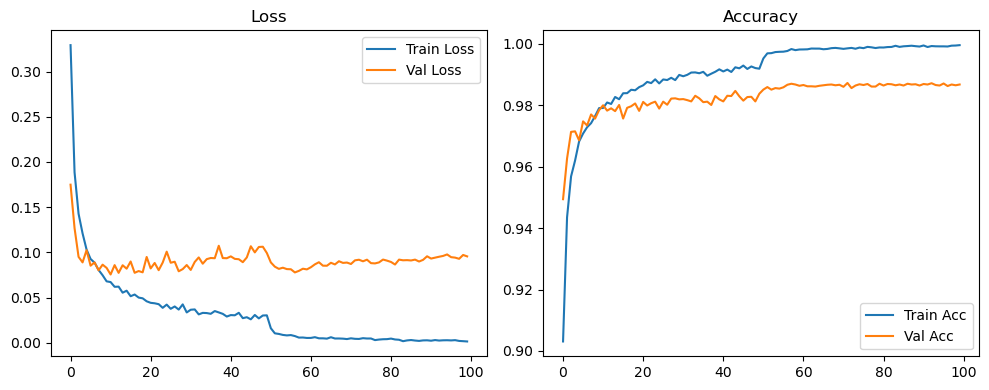

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2342, Acc: 0.9277 | Val Loss: 0.1781, Acc: 0.9469


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1174, Acc: 0.9639 | Val Loss: 0.1276, Acc: 0.9613


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0813, Acc: 0.9740 | Val Loss: 0.0961, Acc: 0.9716


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9808 | Val Loss: 0.0792, Acc: 0.9757


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9831 | Val Loss: 0.0897, Acc: 0.9738


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9864 | Val Loss: 0.0856, Acc: 0.9754


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9893 | Val Loss: 0.0960, Acc: 0.9753


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9888 | Val Loss: 0.0779, Acc: 0.9797


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9912 | Val Loss: 0.0902, Acc: 0.9766


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.0804, Acc: 0.9790


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.0837, Acc: 0.9790


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9928 | Val Loss: 0.0955, Acc: 0.9768


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0902, Acc: 0.9787


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.0811, Acc: 0.9778


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.1043, Acc: 0.9761


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1000, Acc: 0.9770


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9945 | Val Loss: 0.0953, Acc: 0.9778


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.0955, Acc: 0.9807


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0869, Acc: 0.9814


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0875, Acc: 0.9812


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.0983, Acc: 0.9786


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0946, Acc: 0.9804


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.0949, Acc: 0.9776


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0949, Acc: 0.9804


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0939, Acc: 0.9798


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1098, Acc: 0.9770


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0893, Acc: 0.9819


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0991, Acc: 0.9812


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1080, Acc: 0.9802


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0956, Acc: 0.9820


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0989, Acc: 0.9805


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0922, Acc: 0.9812


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0939, Acc: 0.9816


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9984 | Val Loss: 0.0830, Acc: 0.9847


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0914, Acc: 0.9822


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0992, Acc: 0.9827


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9973 | Val Loss: 0.0844, Acc: 0.9833


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1074, Acc: 0.9795


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0852, Acc: 0.9832


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1057, Acc: 0.9801


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0926, Acc: 0.9818


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0866, Acc: 0.9834


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0920, Acc: 0.9847


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0887, Acc: 0.9840


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1038, Acc: 0.9812


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0887, Acc: 0.9842


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1060, Acc: 0.9796


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1039, Acc: 0.9805


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.0961, Acc: 0.9823


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0906, Acc: 0.9835


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0927, Acc: 0.9828


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.0949, Acc: 0.9818


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1085, Acc: 0.9814


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9984 | Val Loss: 0.0926, Acc: 0.9812


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0935, Acc: 0.9826


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0986, Acc: 0.9806


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0922, Acc: 0.9828


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0958, Acc: 0.9836


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.0969, Acc: 0.9838


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.0976, Acc: 0.9827


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0841, Acc: 0.9848


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.0850, Acc: 0.9853


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0969, Acc: 0.9840


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0993, Acc: 0.9825


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.1028, Acc: 0.9822


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.1017, Acc: 0.9811


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0985, Acc: 0.9832


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1075, Acc: 0.9822


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1033, Acc: 0.9844


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1123, Acc: 0.9828


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1039, Acc: 0.9827


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1070, Acc: 0.9828


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1083, Acc: 0.9826


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1003, Acc: 0.9838


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1099, Acc: 0.9832


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9991 | Val Loss: 0.1019, Acc: 0.9835


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0987, Acc: 0.9852


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0971, Acc: 0.9844


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0873, Acc: 0.9857


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.1054, Acc: 0.9830


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1142, Acc: 0.9821


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0862, Acc: 0.9849


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0921, Acc: 0.9852


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9994 | Val Loss: 0.0869, Acc: 0.9851


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0926, Acc: 0.9838


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0990, Acc: 0.9830


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0973, Acc: 0.9845


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1097, Acc: 0.9835


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0958, Acc: 0.9846


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1096, Acc: 0.9823


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0963, Acc: 0.9835


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0992, Acc: 0.9828


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1097, Acc: 0.9826


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1162, Acc: 0.9810


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1126, Acc: 0.9834


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1185, Acc: 0.9832


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1200, Acc: 0.9831


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.1198, Acc: 0.9816


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9988 | Val Loss: 0.1054, Acc: 0.9831


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.0964, Acc: 0.9847


Final Test Loss: 0.0950 Accuracy: 0.9839


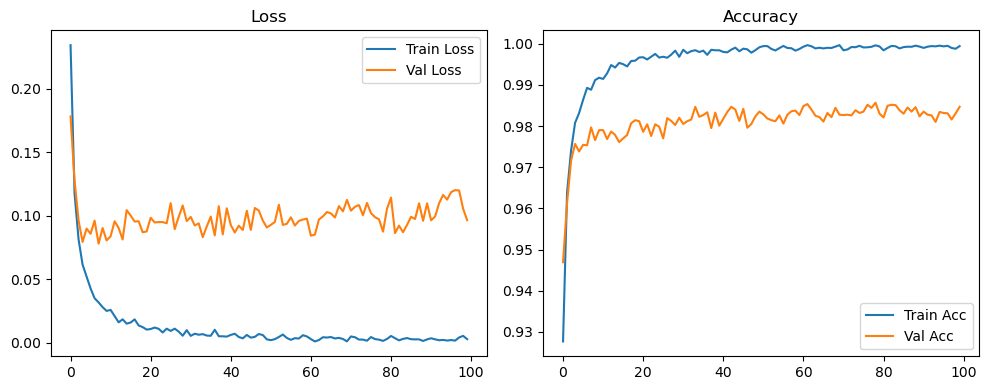

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2465, Acc: 0.9244 | Val Loss: 0.1825, Acc: 0.9462


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1330, Acc: 0.9597 | Val Loss: 0.1225, Acc: 0.9623


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0953, Acc: 0.9702 | Val Loss: 0.1047, Acc: 0.9689


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9760 | Val Loss: 0.0774, Acc: 0.9771


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0638, Acc: 0.9799 | Val Loss: 0.0942, Acc: 0.9717


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9819 | Val Loss: 0.0829, Acc: 0.9759


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9851 | Val Loss: 0.0914, Acc: 0.9749


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.0963, Acc: 0.9745


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9876 | Val Loss: 0.0898, Acc: 0.9767


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9884 | Val Loss: 0.0872, Acc: 0.9790


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9891 | Val Loss: 0.0839, Acc: 0.9798


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9900 | Val Loss: 0.0832, Acc: 0.9797


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9918 | Val Loss: 0.0835, Acc: 0.9808


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9917 | Val Loss: 0.0825, Acc: 0.9799


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9921 | Val Loss: 0.0882, Acc: 0.9782


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.1007, Acc: 0.9771


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.0959, Acc: 0.9802


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.0857, Acc: 0.9787


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9944 | Val Loss: 0.0919, Acc: 0.9792


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.0863, Acc: 0.9816


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.0925, Acc: 0.9808


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9943 | Val Loss: 0.0860, Acc: 0.9825


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0919, Acc: 0.9797


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0876, Acc: 0.9814


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.0972, Acc: 0.9809


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9961 | Val Loss: 0.0847, Acc: 0.9822


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.0791, Acc: 0.9830


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0838, Acc: 0.9816


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.1001, Acc: 0.9795


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.0938, Acc: 0.9812


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.0981, Acc: 0.9804


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0980, Acc: 0.9808


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0921, Acc: 0.9821


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0931, Acc: 0.9833


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.0875, Acc: 0.9828


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0810, Acc: 0.9827


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.0844, Acc: 0.9833


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.0858, Acc: 0.9844


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0973, Acc: 0.9833


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0946, Acc: 0.9828


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1087, Acc: 0.9821


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0974, Acc: 0.9817


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0988, Acc: 0.9816


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0959, Acc: 0.9824


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0988, Acc: 0.9835


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1135, Acc: 0.9803


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.0908, Acc: 0.9837


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1097, Acc: 0.9828


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1000, Acc: 0.9823


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1049, Acc: 0.9818


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1080, Acc: 0.9822


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0945, Acc: 0.9831


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1003, Acc: 0.9837


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1005, Acc: 0.9834


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1076, Acc: 0.9828


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1185, Acc: 0.9810


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0917, Acc: 0.9848


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1015, Acc: 0.9838


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1111, Acc: 0.9837


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1010, Acc: 0.9819


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0972, Acc: 0.9835


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1023, Acc: 0.9808


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1019, Acc: 0.9848


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1082, Acc: 0.9829


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1085, Acc: 0.9824


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1003, Acc: 0.9839


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1045, Acc: 0.9842


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1113, Acc: 0.9828


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1056, Acc: 0.9833


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1150, Acc: 0.9836


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.0977, Acc: 0.9845


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1034, Acc: 0.9843


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1075, Acc: 0.9831


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9986 | Val Loss: 0.1026, Acc: 0.9837


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1046, Acc: 0.9844


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1041, Acc: 0.9828


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.0914, Acc: 0.9850


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0969, Acc: 0.9850


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.0976, Acc: 0.9849


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1079, Acc: 0.9835


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1153, Acc: 0.9817


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1174, Acc: 0.9847


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1068, Acc: 0.9848


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0949, Acc: 0.9860


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1028, Acc: 0.9836


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1090, Acc: 0.9840


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1032, Acc: 0.9842


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0918, Acc: 0.9858


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0964, Acc: 0.9858


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.0939, Acc: 0.9842


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.0946, Acc: 0.9848


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0908, Acc: 0.9847


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0967, Acc: 0.9852


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1062, Acc: 0.9840


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1081, Acc: 0.9846


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9992 | Val Loss: 0.1059, Acc: 0.9845


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9992 | Val Loss: 0.1178, Acc: 0.9839


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1204, Acc: 0.9834


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9988 | Val Loss: 0.1207, Acc: 0.9830


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1111, Acc: 0.9848


Final Test Loss: 0.0981 Accuracy: 0.9843


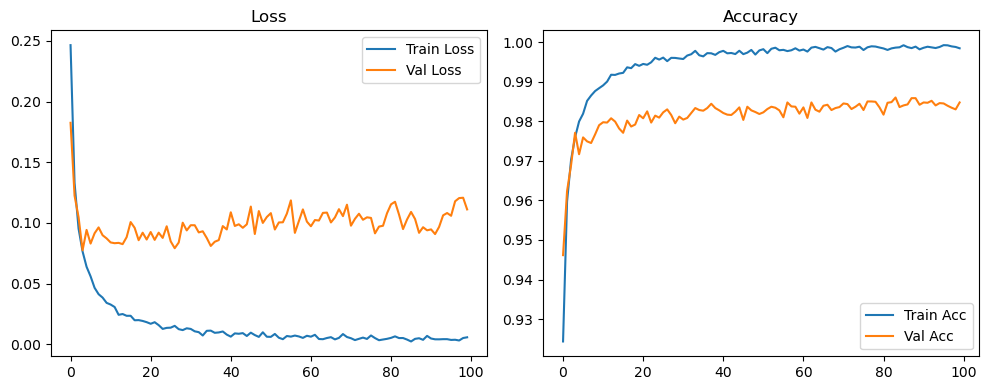

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2929, Acc: 0.9101 | Val Loss: 0.1573, Acc: 0.9535


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1836, Acc: 0.9442 | Val Loss: 0.1217, Acc: 0.9637


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1396, Acc: 0.9584 | Val Loss: 0.0973, Acc: 0.9722


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1155, Acc: 0.9641 | Val Loss: 0.0959, Acc: 0.9719


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1042, Acc: 0.9672 | Val Loss: 0.1011, Acc: 0.9688


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0904, Acc: 0.9711 | Val Loss: 0.0916, Acc: 0.9728


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0824, Acc: 0.9749 | Val Loss: 0.0951, Acc: 0.9724


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0790, Acc: 0.9757 | Val Loss: 0.0895, Acc: 0.9747


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0707, Acc: 0.9773 | Val Loss: 0.0816, Acc: 0.9759


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0680, Acc: 0.9783 | Val Loss: 0.0810, Acc: 0.9771


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0580, Acc: 0.9816 | Val Loss: 0.0791, Acc: 0.9774


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9810 | Val Loss: 0.0794, Acc: 0.9778


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9833 | Val Loss: 0.0754, Acc: 0.9789


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9830 | Val Loss: 0.0694, Acc: 0.9809


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9841 | Val Loss: 0.0696, Acc: 0.9807


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9847 | Val Loss: 0.0805, Acc: 0.9793


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9849 | Val Loss: 0.0742, Acc: 0.9796


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9872 | Val Loss: 0.0737, Acc: 0.9814


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9872 | Val Loss: 0.0740, Acc: 0.9806


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9879 | Val Loss: 0.0708, Acc: 0.9820


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9870 | Val Loss: 0.0822, Acc: 0.9809


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9887 | Val Loss: 0.0699, Acc: 0.9816


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9894 | Val Loss: 0.0805, Acc: 0.9806


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9883 | Val Loss: 0.0750, Acc: 0.9818


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.0752, Acc: 0.9820


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.0727, Acc: 0.9819


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9906 | Val Loss: 0.0752, Acc: 0.9827


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9910 | Val Loss: 0.0702, Acc: 0.9828


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9911 | Val Loss: 0.0768, Acc: 0.9822


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9904 | Val Loss: 0.0744, Acc: 0.9828


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9918 | Val Loss: 0.0755, Acc: 0.9834


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.0744, Acc: 0.9822


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0798, Acc: 0.9818


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.0806, Acc: 0.9813


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9920 | Val Loss: 0.0681, Acc: 0.9837


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9936 | Val Loss: 0.0786, Acc: 0.9828


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9925 | Val Loss: 0.0757, Acc: 0.9823


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9931 | Val Loss: 0.0815, Acc: 0.9818


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9928 | Val Loss: 0.0765, Acc: 0.9833


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9938 | Val Loss: 0.0749, Acc: 0.9842


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9938 | Val Loss: 0.0782, Acc: 0.9823


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9933 | Val Loss: 0.0780, Acc: 0.9839


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0849, Acc: 0.9821


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9934 | Val Loss: 0.0813, Acc: 0.9843


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0737, Acc: 0.9850


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0826, Acc: 0.9829


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9934 | Val Loss: 0.0810, Acc: 0.9819


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9943 | Val Loss: 0.0772, Acc: 0.9838


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9947 | Val Loss: 0.0792, Acc: 0.9841


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.0842, Acc: 0.9841


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9942 | Val Loss: 0.0774, Acc: 0.9845


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.0869, Acc: 0.9832


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9952 | Val Loss: 0.0805, Acc: 0.9846


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9944 | Val Loss: 0.0775, Acc: 0.9850


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9953 | Val Loss: 0.0897, Acc: 0.9825


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.0831, Acc: 0.9843


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.0817, Acc: 0.9833


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9947 | Val Loss: 0.0928, Acc: 0.9844


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9943 | Val Loss: 0.0863, Acc: 0.9841


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.0897, Acc: 0.9842


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9956 | Val Loss: 0.0817, Acc: 0.9852


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9954 | Val Loss: 0.0836, Acc: 0.9839


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.0798, Acc: 0.9858


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.0828, Acc: 0.9847


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9954 | Val Loss: 0.0926, Acc: 0.9832


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9954 | Val Loss: 0.0839, Acc: 0.9848


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.0858, Acc: 0.9854


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9955 | Val Loss: 0.0880, Acc: 0.9852


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 0.0783, Acc: 0.9851


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9956 | Val Loss: 0.0957, Acc: 0.9843


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9956 | Val Loss: 0.0928, Acc: 0.9839


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9957 | Val Loss: 0.0966, Acc: 0.9827


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9957 | Val Loss: 0.0882, Acc: 0.9847


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9954 | Val Loss: 0.0870, Acc: 0.9842


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9958 | Val Loss: 0.0864, Acc: 0.9858


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9961 | Val Loss: 0.0896, Acc: 0.9848


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.0915, Acc: 0.9835


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9957 | Val Loss: 0.0808, Acc: 0.9852


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9963 | Val Loss: 0.0854, Acc: 0.9851


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.0897, Acc: 0.9845


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9961 | Val Loss: 0.0936, Acc: 0.9844


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9960 | Val Loss: 0.0916, Acc: 0.9842


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9960 | Val Loss: 0.0855, Acc: 0.9854


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.0851, Acc: 0.9858


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9962 | Val Loss: 0.0764, Acc: 0.9863


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.0813, Acc: 0.9853


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0938, Acc: 0.9865


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9965 | Val Loss: 0.0890, Acc: 0.9854


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.0978, Acc: 0.9849


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0995, Acc: 0.9850


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9960 | Val Loss: 0.0997, Acc: 0.9852


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.0943, Acc: 0.9852


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.0977, Acc: 0.9849


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9964 | Val Loss: 0.1000, Acc: 0.9843


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.0988, Acc: 0.9842


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.1004, Acc: 0.9846


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.0997, Acc: 0.9843


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9968 | Val Loss: 0.1054, Acc: 0.9840


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9963 | Val Loss: 0.1025, Acc: 0.9859


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9969 | Val Loss: 0.1030, Acc: 0.9852


Final Test Loss: 0.0932 Accuracy: 0.9862


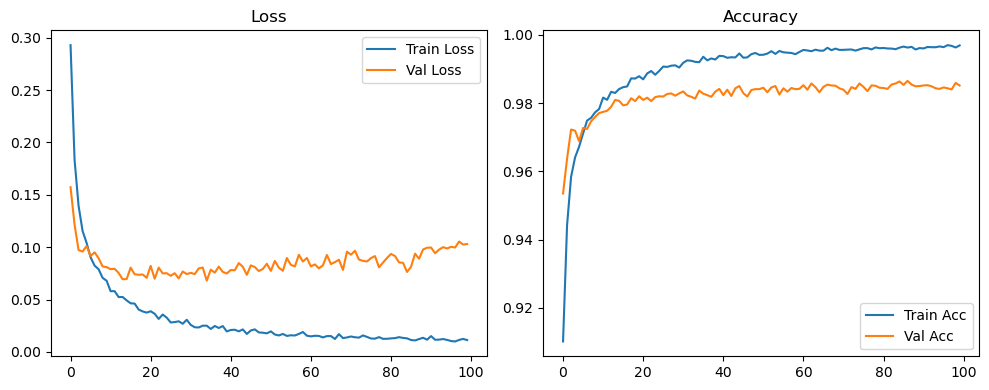

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2342, Acc: 0.9277 | Val Loss: 0.1781, Acc: 0.9469


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1174, Acc: 0.9639 | Val Loss: 0.1276, Acc: 0.9613


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0813, Acc: 0.9740 | Val Loss: 0.0961, Acc: 0.9716


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0614, Acc: 0.9808 | Val Loss: 0.0792, Acc: 0.9757


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9831 | Val Loss: 0.0897, Acc: 0.9738


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0426, Acc: 0.9864 | Val Loss: 0.0856, Acc: 0.9754


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0349, Acc: 0.9893 | Val Loss: 0.0960, Acc: 0.9753


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9888 | Val Loss: 0.0779, Acc: 0.9797


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0279, Acc: 0.9912 | Val Loss: 0.0902, Acc: 0.9766


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9917 | Val Loss: 0.0804, Acc: 0.9790


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0257, Acc: 0.9914 | Val Loss: 0.0837, Acc: 0.9790


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9928 | Val Loss: 0.0955, Acc: 0.9768


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0902, Acc: 0.9787


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.0811, Acc: 0.9778


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.1043, Acc: 0.9761


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1000, Acc: 0.9770


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9945 | Val Loss: 0.0953, Acc: 0.9778


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 0.0955, Acc: 0.9807


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0869, Acc: 0.9814


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0875, Acc: 0.9812


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.0983, Acc: 0.9786


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0946, Acc: 0.9804


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.0949, Acc: 0.9776


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0949, Acc: 0.9804


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0939, Acc: 0.9798


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1098, Acc: 0.9770


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.0893, Acc: 0.9819


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0991, Acc: 0.9812


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1080, Acc: 0.9802


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0956, Acc: 0.9820


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.0989, Acc: 0.9805


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9977 | Val Loss: 0.0922, Acc: 0.9812


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.0939, Acc: 0.9816


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9984 | Val Loss: 0.0830, Acc: 0.9847


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.0914, Acc: 0.9822


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.0992, Acc: 0.9827


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9973 | Val Loss: 0.0844, Acc: 0.9833


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1074, Acc: 0.9795


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0852, Acc: 0.9832


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1057, Acc: 0.9801


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0926, Acc: 0.9818


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0866, Acc: 0.9834


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0920, Acc: 0.9847


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0887, Acc: 0.9840


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1038, Acc: 0.9812


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0887, Acc: 0.9842


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1060, Acc: 0.9796


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1039, Acc: 0.9805


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.0961, Acc: 0.9823


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0906, Acc: 0.9835


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.0849, Acc: 0.9852


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0807, Acc: 0.9849


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0814, Acc: 0.9854


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0825, Acc: 0.9852


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0855, Acc: 0.9850


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0875, Acc: 0.9848


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0861, Acc: 0.9854


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0881, Acc: 0.9846


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0863, Acc: 0.9861


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0986, Acc: 0.9844


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1052, Acc: 0.9832


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1012, Acc: 0.9847


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1097, Acc: 0.9835


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1104, Acc: 0.9846


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1058, Acc: 0.9838


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1125, Acc: 0.9828


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1039, Acc: 0.9839


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1084, Acc: 0.9844


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9998 | Val Loss: 0.1017, Acc: 0.9852


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1067, Acc: 0.9838


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1078, Acc: 0.9845


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1140, Acc: 0.9846


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.0975, Acc: 0.9856


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1014, Acc: 0.9839


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1036, Acc: 0.9850


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0986, Acc: 0.9850


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1017, Acc: 0.9852


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0988, Acc: 0.9849


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0982, Acc: 0.9850


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1077, Acc: 0.9851


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1021, Acc: 0.9851


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1041, Acc: 0.9860


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1103, Acc: 0.9852


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1069, Acc: 0.9848


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1043, Acc: 0.9856


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1087, Acc: 0.9850


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1157, Acc: 0.9846


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1119, Acc: 0.9848


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1126, Acc: 0.9841


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1108, Acc: 0.9840


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1128, Acc: 0.9842


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1144, Acc: 0.9839


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1106, Acc: 0.9843


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1141, Acc: 0.9845


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1129, Acc: 0.9852


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1036, Acc: 0.9848


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1042, Acc: 0.9853


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1036, Acc: 0.9851


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1045, Acc: 0.9843


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1045, Acc: 0.9842


Final Test Loss: 0.0958 Accuracy: 0.9854


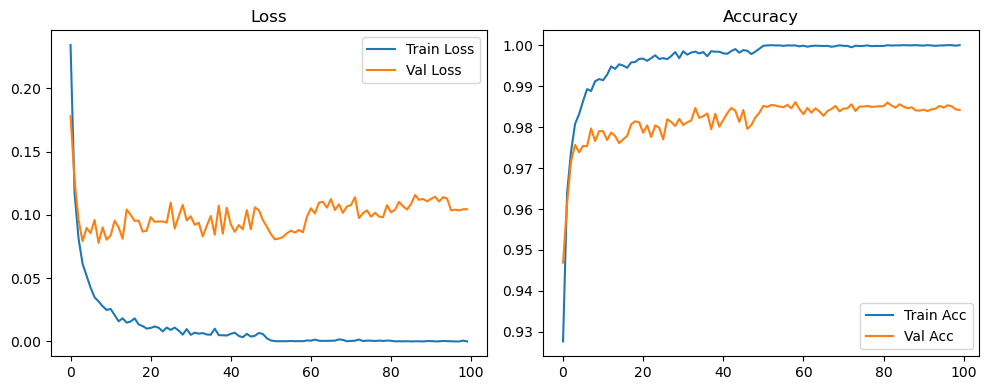

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2465, Acc: 0.9244 | Val Loss: 0.1825, Acc: 0.9462


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1330, Acc: 0.9597 | Val Loss: 0.1225, Acc: 0.9623


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0953, Acc: 0.9702 | Val Loss: 0.1047, Acc: 0.9689


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0764, Acc: 0.9760 | Val Loss: 0.0774, Acc: 0.9771


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0638, Acc: 0.9799 | Val Loss: 0.0942, Acc: 0.9717


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0559, Acc: 0.9819 | Val Loss: 0.0829, Acc: 0.9759


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9851 | Val Loss: 0.0914, Acc: 0.9749


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.0963, Acc: 0.9745


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9876 | Val Loss: 0.0898, Acc: 0.9767


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0340, Acc: 0.9884 | Val Loss: 0.0872, Acc: 0.9790


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0327, Acc: 0.9891 | Val Loss: 0.0839, Acc: 0.9798


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0306, Acc: 0.9900 | Val Loss: 0.0832, Acc: 0.9797


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0242, Acc: 0.9918 | Val Loss: 0.0835, Acc: 0.9808


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9917 | Val Loss: 0.0825, Acc: 0.9799


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9921 | Val Loss: 0.0882, Acc: 0.9782


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9922 | Val Loss: 0.1007, Acc: 0.9771


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9936 | Val Loss: 0.0959, Acc: 0.9802


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.0857, Acc: 0.9787


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9944 | Val Loss: 0.0919, Acc: 0.9792


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.0863, Acc: 0.9816


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.0925, Acc: 0.9808


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9943 | Val Loss: 0.0860, Acc: 0.9825


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9949 | Val Loss: 0.0919, Acc: 0.9797


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0876, Acc: 0.9814


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.0972, Acc: 0.9809


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9961 | Val Loss: 0.0847, Acc: 0.9822


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9952 | Val Loss: 0.0791, Acc: 0.9830


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0838, Acc: 0.9816


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.1001, Acc: 0.9795


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.0938, Acc: 0.9812


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.0981, Acc: 0.9804


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0980, Acc: 0.9808


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.0921, Acc: 0.9821


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0931, Acc: 0.9833


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.0875, Acc: 0.9828


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0810, Acc: 0.9827


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.0844, Acc: 0.9833


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9972 | Val Loss: 0.0858, Acc: 0.9844


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0973, Acc: 0.9833


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0946, Acc: 0.9828


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1087, Acc: 0.9821


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.0974, Acc: 0.9817


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0988, Acc: 0.9816


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0959, Acc: 0.9824


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0988, Acc: 0.9835


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1135, Acc: 0.9803


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.0908, Acc: 0.9837


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1097, Acc: 0.9828


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1000, Acc: 0.9823


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1049, Acc: 0.9818


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0953, Acc: 0.9842


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0870, Acc: 0.9856


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0907, Acc: 0.9852


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0888, Acc: 0.9859


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0886, Acc: 0.9851


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0957, Acc: 0.9854


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0891, Acc: 0.9860


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0925, Acc: 0.9849


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0923, Acc: 0.9862


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1035, Acc: 0.9852


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0968, Acc: 0.9848


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0969, Acc: 0.9851


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1007, Acc: 0.9855


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1022, Acc: 0.9870


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0999, Acc: 0.9852


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1023, Acc: 0.9850


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1046, Acc: 0.9846


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1080, Acc: 0.9855


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1025, Acc: 0.9852


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1017, Acc: 0.9851


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1039, Acc: 0.9852


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1106, Acc: 0.9842


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1082, Acc: 0.9841


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1062, Acc: 0.9851


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1049, Acc: 0.9865


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1026, Acc: 0.9865


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1074, Acc: 0.9853


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1011, Acc: 0.9858


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1052, Acc: 0.9862


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1094, Acc: 0.9858


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1021, Acc: 0.9860


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1016, Acc: 0.9868


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1030, Acc: 0.9862


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1051, Acc: 0.9857


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1054, Acc: 0.9858


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1077, Acc: 0.9852


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1051, Acc: 0.9863


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.1046, Acc: 0.9871


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1048, Acc: 0.9867


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1058, Acc: 0.9866


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1047, Acc: 0.9869


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1040, Acc: 0.9867


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1057, Acc: 0.9868


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1113, Acc: 0.9868


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1142, Acc: 0.9854


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1132, Acc: 0.9861


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1160, Acc: 0.9859


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1143, Acc: 0.9868


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1183, Acc: 0.9861


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1157, Acc: 0.9865


Final Test Loss: 0.1073 Accuracy: 0.9866


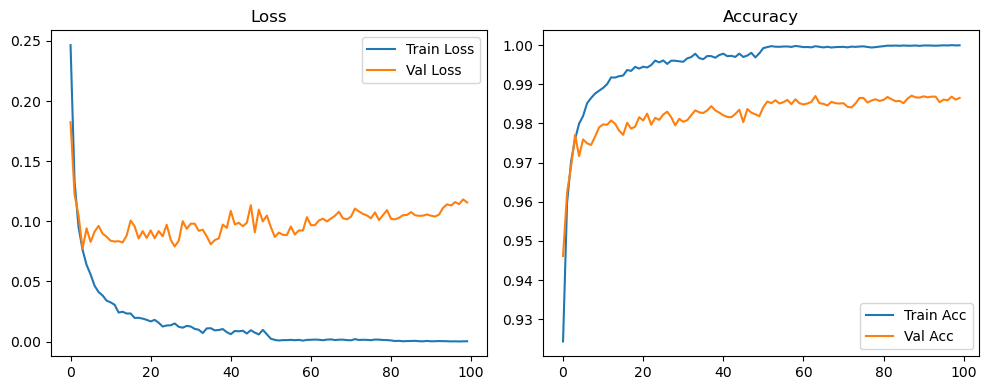

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2929, Acc: 0.9101 | Val Loss: 0.1573, Acc: 0.9535


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1836, Acc: 0.9442 | Val Loss: 0.1217, Acc: 0.9637


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1396, Acc: 0.9584 | Val Loss: 0.0973, Acc: 0.9722


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1155, Acc: 0.9641 | Val Loss: 0.0959, Acc: 0.9719


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1042, Acc: 0.9672 | Val Loss: 0.1011, Acc: 0.9688


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0904, Acc: 0.9711 | Val Loss: 0.0916, Acc: 0.9728


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0824, Acc: 0.9749 | Val Loss: 0.0951, Acc: 0.9724


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0790, Acc: 0.9757 | Val Loss: 0.0895, Acc: 0.9747


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0707, Acc: 0.9773 | Val Loss: 0.0816, Acc: 0.9759


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0680, Acc: 0.9783 | Val Loss: 0.0810, Acc: 0.9771


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0580, Acc: 0.9816 | Val Loss: 0.0791, Acc: 0.9774


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0581, Acc: 0.9810 | Val Loss: 0.0794, Acc: 0.9778


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9833 | Val Loss: 0.0754, Acc: 0.9789


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0525, Acc: 0.9830 | Val Loss: 0.0694, Acc: 0.9809


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0493, Acc: 0.9841 | Val Loss: 0.0696, Acc: 0.9807


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9847 | Val Loss: 0.0805, Acc: 0.9793


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0462, Acc: 0.9849 | Val Loss: 0.0742, Acc: 0.9796


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0405, Acc: 0.9872 | Val Loss: 0.0737, Acc: 0.9814


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9872 | Val Loss: 0.0740, Acc: 0.9806


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0376, Acc: 0.9879 | Val Loss: 0.0708, Acc: 0.9820


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9870 | Val Loss: 0.0822, Acc: 0.9809


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9887 | Val Loss: 0.0699, Acc: 0.9816


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0315, Acc: 0.9894 | Val Loss: 0.0805, Acc: 0.9806


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0357, Acc: 0.9883 | Val Loss: 0.0750, Acc: 0.9818


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.0752, Acc: 0.9820


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.0727, Acc: 0.9819


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9906 | Val Loss: 0.0752, Acc: 0.9827


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9910 | Val Loss: 0.0702, Acc: 0.9828


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9911 | Val Loss: 0.0768, Acc: 0.9822


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0308, Acc: 0.9904 | Val Loss: 0.0744, Acc: 0.9828


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9918 | Val Loss: 0.0755, Acc: 0.9834


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9925 | Val Loss: 0.0744, Acc: 0.9822


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0798, Acc: 0.9818


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9921 | Val Loss: 0.0806, Acc: 0.9813


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9920 | Val Loss: 0.0681, Acc: 0.9837


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9936 | Val Loss: 0.0786, Acc: 0.9828


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9925 | Val Loss: 0.0757, Acc: 0.9823


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0229, Acc: 0.9931 | Val Loss: 0.0815, Acc: 0.9818


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9928 | Val Loss: 0.0765, Acc: 0.9833


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9938 | Val Loss: 0.0749, Acc: 0.9842


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9938 | Val Loss: 0.0782, Acc: 0.9823


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9933 | Val Loss: 0.0780, Acc: 0.9839


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.0849, Acc: 0.9821


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9934 | Val Loss: 0.0813, Acc: 0.9843


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9945 | Val Loss: 0.0737, Acc: 0.9850


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.0826, Acc: 0.9829


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9934 | Val Loss: 0.0810, Acc: 0.9819


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9943 | Val Loss: 0.0772, Acc: 0.9838


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9947 | Val Loss: 0.0792, Acc: 0.9841


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9941 | Val Loss: 0.0842, Acc: 0.9841


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.0712, Acc: 0.9848


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0719, Acc: 0.9848


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0732, Acc: 0.9852


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0742, Acc: 0.9860


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.0720, Acc: 0.9860


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0734, Acc: 0.9866


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0766, Acc: 0.9852


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0748, Acc: 0.9860


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0783, Acc: 0.9857


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0789, Acc: 0.9857


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0770, Acc: 0.9859


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.0793, Acc: 0.9860


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0814, Acc: 0.9856


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0850, Acc: 0.9859


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0859, Acc: 0.9852


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0863, Acc: 0.9852


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.0888, Acc: 0.9848


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0853, Acc: 0.9866


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0796, Acc: 0.9873


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0837, Acc: 0.9867


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.0824, Acc: 0.9859


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0846, Acc: 0.9865


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0840, Acc: 0.9862


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.0843, Acc: 0.9853


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0872, Acc: 0.9848


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0856, Acc: 0.9858


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0889, Acc: 0.9859


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0915, Acc: 0.9860


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0857, Acc: 0.9868


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0920, Acc: 0.9861


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0884, Acc: 0.9861


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0854, Acc: 0.9870


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0878, Acc: 0.9870


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0830, Acc: 0.9867


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0877, Acc: 0.9866


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0846, Acc: 0.9868


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0833, Acc: 0.9871


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0862, Acc: 0.9858


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0883, Acc: 0.9863


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0873, Acc: 0.9864


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.0875, Acc: 0.9867


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0849, Acc: 0.9858


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0850, Acc: 0.9862


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.0905, Acc: 0.9864


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0876, Acc: 0.9868


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0872, Acc: 0.9861


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0863, Acc: 0.9863


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.0881, Acc: 0.9862


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9990 | Val Loss: 0.0873, Acc: 0.9861


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0838, Acc: 0.9863


Final Test Loss: 0.0866 Accuracy: 0.9872


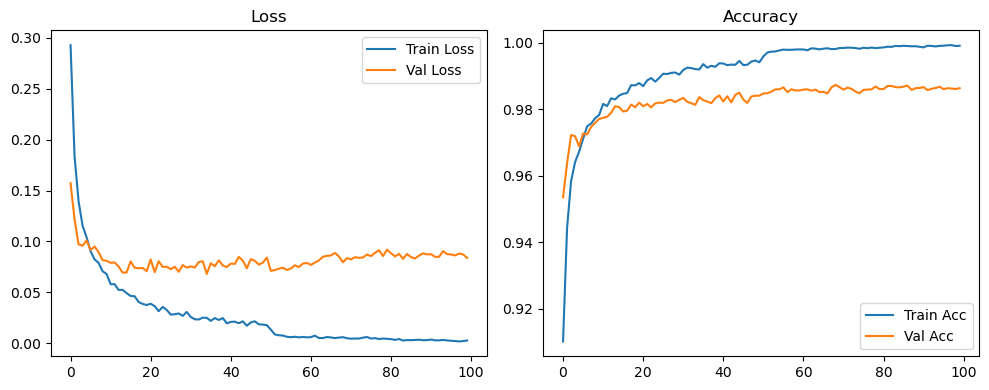

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2095, Acc: 0.9357 | Val Loss: 0.1414, Acc: 0.9567


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1089, Acc: 0.9653 | Val Loss: 0.1131, Acc: 0.9642


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0776, Acc: 0.9749 | Val Loss: 0.0962, Acc: 0.9712


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0592, Acc: 0.9809 | Val Loss: 0.0831, Acc: 0.9756


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0498, Acc: 0.9838 | Val Loss: 0.0972, Acc: 0.9710


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9850 | Val Loss: 0.0971, Acc: 0.9723


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0358, Acc: 0.9882 | Val Loss: 0.1050, Acc: 0.9723


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9903 | Val Loss: 0.1097, Acc: 0.9732


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9904 | Val Loss: 0.0952, Acc: 0.9759


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0292, Acc: 0.9906 | Val Loss: 0.0968, Acc: 0.9745


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0895, Acc: 0.9779


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0222, Acc: 0.9931 | Val Loss: 0.0882, Acc: 0.9792


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9947 | Val Loss: 0.0907, Acc: 0.9777


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.0962, Acc: 0.9787


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.0953, Acc: 0.9784


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9953 | Val Loss: 0.0984, Acc: 0.9784


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9938 | Val Loss: 0.0835, Acc: 0.9811


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1086, Acc: 0.9793


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0943, Acc: 0.9812


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9952 | Val Loss: 0.0867, Acc: 0.9802


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.0912, Acc: 0.9814


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0964, Acc: 0.9808


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1129, Acc: 0.9778


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9954 | Val Loss: 0.0924, Acc: 0.9805


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1022, Acc: 0.9785


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1004, Acc: 0.9790


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9967 | Val Loss: 0.0951, Acc: 0.9810


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0901, Acc: 0.9818


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0849, Acc: 0.9822


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1022, Acc: 0.9810


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9978 | Val Loss: 0.0938, Acc: 0.9831


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9973 | Val Loss: 0.1018, Acc: 0.9827


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0843, Acc: 0.9831


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.0911, Acc: 0.9822


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0914, Acc: 0.9832


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1078, Acc: 0.9798


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0901, Acc: 0.9815


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0893, Acc: 0.9819


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0953, Acc: 0.9822


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0924, Acc: 0.9838


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0938, Acc: 0.9833


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1046, Acc: 0.9825


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9979 | Val Loss: 0.1026, Acc: 0.9830


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0937, Acc: 0.9837


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0969, Acc: 0.9822


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.1007, Acc: 0.9813


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0809, Acc: 0.9857


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0878, Acc: 0.9851


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1162, Acc: 0.9811


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1023, Acc: 0.9825


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1086, Acc: 0.9807


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.0944, Acc: 0.9832


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.0933, Acc: 0.9835


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.0976, Acc: 0.9836


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0925, Acc: 0.9835


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1055, Acc: 0.9828


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0984, Acc: 0.9829


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0933, Acc: 0.9842


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1031, Acc: 0.9838


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.0992, Acc: 0.9832


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0959, Acc: 0.9840


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1022, Acc: 0.9843


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9990 | Val Loss: 0.0919, Acc: 0.9852


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0998, Acc: 0.9841


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0967, Acc: 0.9839


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0981, Acc: 0.9844


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0955, Acc: 0.9848


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1040, Acc: 0.9834


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0977, Acc: 0.9832


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0985, Acc: 0.9830


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1007, Acc: 0.9835


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0921, Acc: 0.9857


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1108, Acc: 0.9838


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1091, Acc: 0.9828


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1056, Acc: 0.9823


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1040, Acc: 0.9835


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1059, Acc: 0.9839


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0938, Acc: 0.9836


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0928, Acc: 0.9841


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0920, Acc: 0.9842


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0947, Acc: 0.9838


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0881, Acc: 0.9845


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1001, Acc: 0.9843


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1037, Acc: 0.9833


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1012, Acc: 0.9837


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0925, Acc: 0.9839


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0941, Acc: 0.9848


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1015, Acc: 0.9828


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1014, Acc: 0.9838


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1036, Acc: 0.9841


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0990, Acc: 0.9842


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1084, Acc: 0.9828


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1008, Acc: 0.9839


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0964, Acc: 0.9842


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1074, Acc: 0.9829


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1129, Acc: 0.9822


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1086, Acc: 0.9838


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0998, Acc: 0.9838


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1042, Acc: 0.9833


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1097, Acc: 0.9835


Final Test Loss: 0.0939 Accuracy: 0.9850


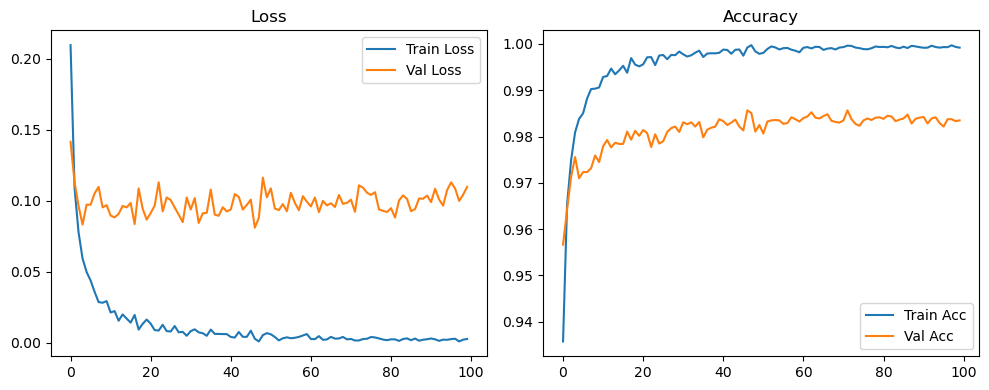

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2232, Acc: 0.9317 | Val Loss: 0.1619, Acc: 0.9523


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1226, Acc: 0.9615 | Val Loss: 0.1131, Acc: 0.9654


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0920, Acc: 0.9714 | Val Loss: 0.0967, Acc: 0.9700


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0738, Acc: 0.9764 | Val Loss: 0.0843, Acc: 0.9748


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0617, Acc: 0.9802 | Val Loss: 0.0939, Acc: 0.9732


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0554, Acc: 0.9817 | Val Loss: 0.0858, Acc: 0.9756


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0468, Acc: 0.9850 | Val Loss: 0.0948, Acc: 0.9751


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9862 | Val Loss: 0.0845, Acc: 0.9768


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0384, Acc: 0.9863 | Val Loss: 0.0903, Acc: 0.9762


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9877 | Val Loss: 0.0841, Acc: 0.9771


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0296, Acc: 0.9900 | Val Loss: 0.0808, Acc: 0.9783


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0305, Acc: 0.9901 | Val Loss: 0.0910, Acc: 0.9755


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9912 | Val Loss: 0.0915, Acc: 0.9772


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9915 | Val Loss: 0.0898, Acc: 0.9780


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.0871, Acc: 0.9792


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9932 | Val Loss: 0.0882, Acc: 0.9784


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9931 | Val Loss: 0.0835, Acc: 0.9800


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9934 | Val Loss: 0.0980, Acc: 0.9794


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.0857, Acc: 0.9798


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9944 | Val Loss: 0.0857, Acc: 0.9809


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9949 | Val Loss: 0.0817, Acc: 0.9813


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0862, Acc: 0.9809


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.0971, Acc: 0.9784


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9956 | Val Loss: 0.0918, Acc: 0.9801


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1075, Acc: 0.9771


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.0861, Acc: 0.9815


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.0880, Acc: 0.9815


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.0940, Acc: 0.9824


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0889, Acc: 0.9817


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0895, Acc: 0.9830


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9954 | Val Loss: 0.0960, Acc: 0.9812


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0882, Acc: 0.9812


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0970, Acc: 0.9812


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.0986, Acc: 0.9804


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.1006, Acc: 0.9808


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9971 | Val Loss: 0.0953, Acc: 0.9808


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.0958, Acc: 0.9792


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0995, Acc: 0.9812


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0909, Acc: 0.9824


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0973, Acc: 0.9809


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.0991, Acc: 0.9820


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1049, Acc: 0.9814


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.0929, Acc: 0.9826


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.0865, Acc: 0.9839


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0817, Acc: 0.9840


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0991, Acc: 0.9823


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.0906, Acc: 0.9841


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0910, Acc: 0.9835


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9981 | Val Loss: 0.0999, Acc: 0.9813


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0987, Acc: 0.9825


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0947, Acc: 0.9827


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1078, Acc: 0.9812


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0975, Acc: 0.9830


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0998, Acc: 0.9823


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0986, Acc: 0.9833


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1108, Acc: 0.9816


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.0970, Acc: 0.9833


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0949, Acc: 0.9830


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1055, Acc: 0.9842


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1071, Acc: 0.9822


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0993, Acc: 0.9837


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1041, Acc: 0.9825


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0979, Acc: 0.9838


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1042, Acc: 0.9838


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9987 | Val Loss: 0.1064, Acc: 0.9822


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1021, Acc: 0.9817


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0928, Acc: 0.9838


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1010, Acc: 0.9836


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0968, Acc: 0.9832


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.0990, Acc: 0.9828


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.0972, Acc: 0.9826


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0954, Acc: 0.9827


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1024, Acc: 0.9828


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1013, Acc: 0.9838


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1006, Acc: 0.9838


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1009, Acc: 0.9837


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0933, Acc: 0.9844


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9987 | Val Loss: 0.1023, Acc: 0.9823


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0995, Acc: 0.9837


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1125, Acc: 0.9817


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1166, Acc: 0.9812


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1082, Acc: 0.9840


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1070, Acc: 0.9832


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1031, Acc: 0.9832


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1045, Acc: 0.9832


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1112, Acc: 0.9835


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0960, Acc: 0.9842


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.0989, Acc: 0.9841


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0933, Acc: 0.9859


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0947, Acc: 0.9855


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0972, Acc: 0.9854


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1040, Acc: 0.9831


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1058, Acc: 0.9831


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1010, Acc: 0.9842


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1056, Acc: 0.9838


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1019, Acc: 0.9849


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1026, Acc: 0.9856


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1060, Acc: 0.9836


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1141, Acc: 0.9825


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1026, Acc: 0.9845


Final Test Loss: 0.0970 Accuracy: 0.9843


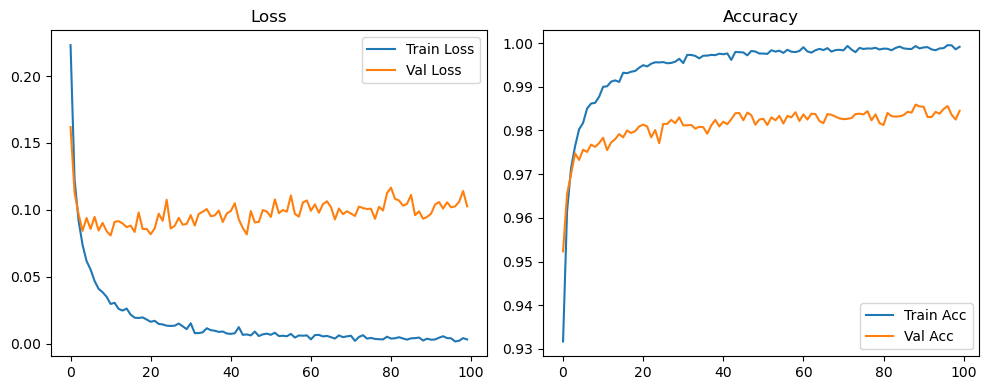

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2702, Acc: 0.9164 | Val Loss: 0.1503, Acc: 0.9549


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1657, Acc: 0.9486 | Val Loss: 0.1109, Acc: 0.9657


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1314, Acc: 0.9596 | Val Loss: 0.0969, Acc: 0.9699


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1138, Acc: 0.9650 | Val Loss: 0.0904, Acc: 0.9728


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1007, Acc: 0.9679 | Val Loss: 0.0883, Acc: 0.9742


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0918, Acc: 0.9705 | Val Loss: 0.0901, Acc: 0.9729


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0832, Acc: 0.9736 | Val Loss: 0.0881, Acc: 0.9742


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0764, Acc: 0.9755 | Val Loss: 0.0846, Acc: 0.9758


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0708, Acc: 0.9773 | Val Loss: 0.0805, Acc: 0.9761


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0641, Acc: 0.9788 | Val Loss: 0.0768, Acc: 0.9791


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0617, Acc: 0.9801 | Val Loss: 0.0712, Acc: 0.9794


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0603, Acc: 0.9805 | Val Loss: 0.0862, Acc: 0.9768


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9831 | Val Loss: 0.0761, Acc: 0.9790


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0512, Acc: 0.9831 | Val Loss: 0.0733, Acc: 0.9793


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0506, Acc: 0.9839 | Val Loss: 0.0710, Acc: 0.9812


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0438, Acc: 0.9853 | Val Loss: 0.0742, Acc: 0.9778


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0472, Acc: 0.9846 | Val Loss: 0.0752, Acc: 0.9803


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0428, Acc: 0.9857 | Val Loss: 0.0725, Acc: 0.9798


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9873 | Val Loss: 0.0745, Acc: 0.9801


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0397, Acc: 0.9867 | Val Loss: 0.0720, Acc: 0.9812


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9874 | Val Loss: 0.0713, Acc: 0.9808


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0358, Acc: 0.9876 | Val Loss: 0.0738, Acc: 0.9812


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9893 | Val Loss: 0.0730, Acc: 0.9805


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 0.0702, Acc: 0.9828


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9891 | Val Loss: 0.0748, Acc: 0.9812


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9903 | Val Loss: 0.0740, Acc: 0.9813


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9909 | Val Loss: 0.0749, Acc: 0.9812


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.0757, Acc: 0.9812


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9901 | Val Loss: 0.0800, Acc: 0.9807


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9915 | Val Loss: 0.0741, Acc: 0.9828


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.0747, Acc: 0.9830


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9921 | Val Loss: 0.0709, Acc: 0.9831


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9923 | Val Loss: 0.0705, Acc: 0.9834


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0216, Acc: 0.9927 | Val Loss: 0.0706, Acc: 0.9830


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9918 | Val Loss: 0.0752, Acc: 0.9826


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9928 | Val Loss: 0.0816, Acc: 0.9820


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0252, Acc: 0.9919 | Val Loss: 0.0765, Acc: 0.9838


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9932 | Val Loss: 0.0758, Acc: 0.9836


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.0724, Acc: 0.9836


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9935 | Val Loss: 0.0749, Acc: 0.9820


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9939 | Val Loss: 0.0771, Acc: 0.9828


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9930 | Val Loss: 0.0717, Acc: 0.9839


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0786, Acc: 0.9832


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.0762, Acc: 0.9839


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.0710, Acc: 0.9841


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9940 | Val Loss: 0.0748, Acc: 0.9829


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.0714, Acc: 0.9849


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9944 | Val Loss: 0.0767, Acc: 0.9836


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9940 | Val Loss: 0.0826, Acc: 0.9820


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9948 | Val Loss: 0.0842, Acc: 0.9832


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.0815, Acc: 0.9833


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.0810, Acc: 0.9839


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.0810, Acc: 0.9836


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.0796, Acc: 0.9843


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.0805, Acc: 0.9832


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0789, Acc: 0.9845


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9950 | Val Loss: 0.0769, Acc: 0.9843


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.0787, Acc: 0.9839


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9955 | Val Loss: 0.0843, Acc: 0.9830


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0787, Acc: 0.9844


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9951 | Val Loss: 0.0791, Acc: 0.9852


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.0835, Acc: 0.9832


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0785, Acc: 0.9845


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.0848, Acc: 0.9838


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0817, Acc: 0.9844


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0789, Acc: 0.9846


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.0834, Acc: 0.9851


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0783, Acc: 0.9842


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.0814, Acc: 0.9848


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0852, Acc: 0.9842


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0851, Acc: 0.9838


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9956 | Val Loss: 0.0791, Acc: 0.9857


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0782, Acc: 0.9848


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0809, Acc: 0.9845


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.0867, Acc: 0.9836


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9959 | Val Loss: 0.0840, Acc: 0.9852


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.0844, Acc: 0.9842


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.0818, Acc: 0.9848


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.0884, Acc: 0.9835


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.0862, Acc: 0.9839


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.0858, Acc: 0.9836


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0882, Acc: 0.9849


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0759, Acc: 0.9863


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0791, Acc: 0.9854


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9968 | Val Loss: 0.0812, Acc: 0.9854


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0828, Acc: 0.9848


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0868, Acc: 0.9852


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0898, Acc: 0.9851


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0877, Acc: 0.9851


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0893, Acc: 0.9845


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0923, Acc: 0.9844


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0895, Acc: 0.9836


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0907, Acc: 0.9847


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.0861, Acc: 0.9848


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.0916, Acc: 0.9849


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0800, Acc: 0.9858


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0846, Acc: 0.9850


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0872, Acc: 0.9852


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.0837, Acc: 0.9852


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.0794, Acc: 0.9854


Final Test Loss: 0.0792 Accuracy: 0.9855


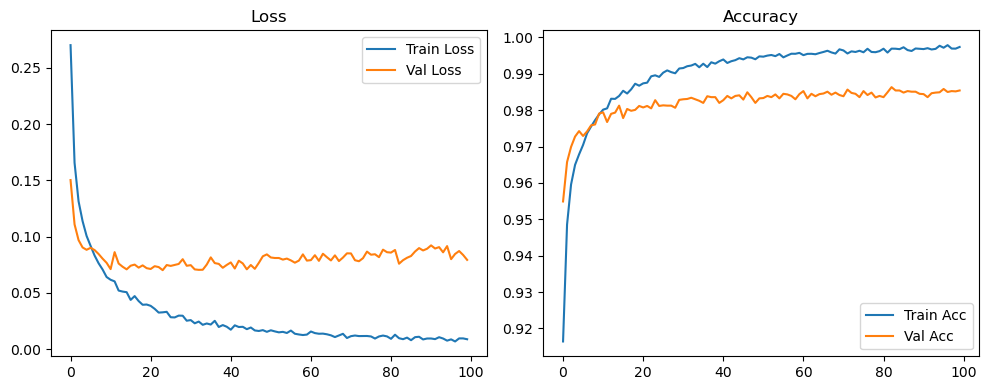

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.1938, Acc: 0.9401 | Val Loss: 0.1267, Acc: 0.9607


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0984, Acc: 0.9681 | Val Loss: 0.0954, Acc: 0.9690


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0680, Acc: 0.9778 | Val Loss: 0.0919, Acc: 0.9728


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0529, Acc: 0.9827 | Val Loss: 0.0855, Acc: 0.9748


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0459, Acc: 0.9847 | Val Loss: 0.0823, Acc: 0.9746


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9873 | Val Loss: 0.0938, Acc: 0.9729


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9889 | Val Loss: 0.1082, Acc: 0.9717


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9893 | Val Loss: 0.0961, Acc: 0.9742


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0252, Acc: 0.9914 | Val Loss: 0.0897, Acc: 0.9762


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9930 | Val Loss: 0.0771, Acc: 0.9822


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.0843, Acc: 0.9788


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0162, Acc: 0.9946 | Val Loss: 0.1073, Acc: 0.9753


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.0820, Acc: 0.9795


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0917, Acc: 0.9772


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9934 | Val Loss: 0.0872, Acc: 0.9789


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0794, Acc: 0.9810


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9957 | Val Loss: 0.1089, Acc: 0.9762


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9954 | Val Loss: 0.1007, Acc: 0.9776


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1011, Acc: 0.9797


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9944 | Val Loss: 0.0943, Acc: 0.9781


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.0932, Acc: 0.9807


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.0785, Acc: 0.9842


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.0881, Acc: 0.9815


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0972, Acc: 0.9804


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0936, Acc: 0.9813


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.0956, Acc: 0.9802


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.0984, Acc: 0.9808


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0970, Acc: 0.9825


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0807, Acc: 0.9840


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.0883, Acc: 0.9828


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9966 | Val Loss: 0.1043, Acc: 0.9797


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0870, Acc: 0.9823


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0830, Acc: 0.9828


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.0902, Acc: 0.9826


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.0940, Acc: 0.9810


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1102, Acc: 0.9790


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.0907, Acc: 0.9817


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.0965, Acc: 0.9829


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9979 | Val Loss: 0.0987, Acc: 0.9826


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.0912, Acc: 0.9823


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.0892, Acc: 0.9827


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.0882, Acc: 0.9838


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1005, Acc: 0.9826


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.0922, Acc: 0.9842


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.0906, Acc: 0.9849


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9982 | Val Loss: 0.1025, Acc: 0.9832


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.0917, Acc: 0.9844


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1002, Acc: 0.9832


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1072, Acc: 0.9832


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1123, Acc: 0.9821


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.0878, Acc: 0.9839


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0964, Acc: 0.9821


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0996, Acc: 0.9842


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1072, Acc: 0.9822


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1101, Acc: 0.9814


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1045, Acc: 0.9818


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1115, Acc: 0.9816


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.0999, Acc: 0.9832


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1055, Acc: 0.9831


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1116, Acc: 0.9830


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1075, Acc: 0.9817


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1015, Acc: 0.9842


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0900, Acc: 0.9852


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1213, Acc: 0.9808


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1096, Acc: 0.9832


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.0959, Acc: 0.9842


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.0946, Acc: 0.9848


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0883, Acc: 0.9859


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0948, Acc: 0.9854


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1042, Acc: 0.9833


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1045, Acc: 0.9833


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1079, Acc: 0.9820


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1167, Acc: 0.9811


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1133, Acc: 0.9826


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1026, Acc: 0.9848


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1055, Acc: 0.9834


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0961, Acc: 0.9849


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0999, Acc: 0.9832


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0929, Acc: 0.9834


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1000, Acc: 0.9838


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1253, Acc: 0.9800


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1157, Acc: 0.9820


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1041, Acc: 0.9838


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0973, Acc: 0.9853


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0927, Acc: 0.9848


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1123, Acc: 0.9830


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1044, Acc: 0.9852


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0942, Acc: 0.9861


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1026, Acc: 0.9851


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.1135, Acc: 0.9812


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1115, Acc: 0.9823


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1034, Acc: 0.9826


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1041, Acc: 0.9822


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.0946, Acc: 0.9844


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1215, Acc: 0.9834


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1214, Acc: 0.9821


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0986, Acc: 0.9835


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0986, Acc: 0.9843


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1032, Acc: 0.9842


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1089, Acc: 0.9838


Final Test Loss: 0.1042 Accuracy: 0.9845


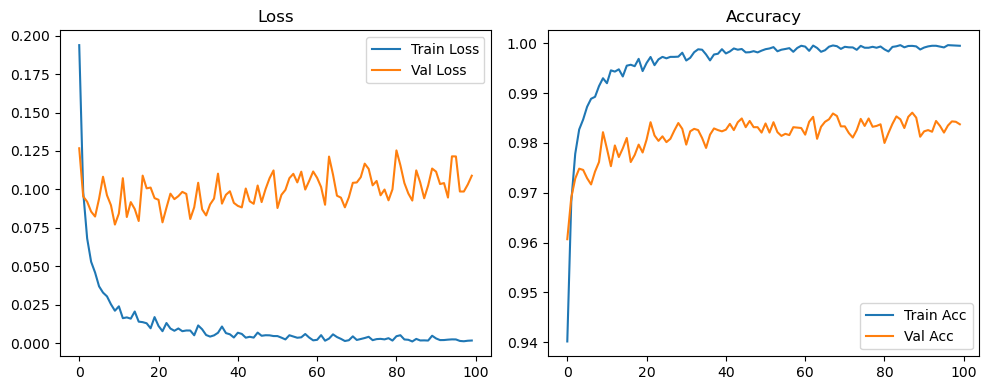

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2118, Acc: 0.9355 | Val Loss: 0.1288, Acc: 0.9607


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1116, Acc: 0.9644 | Val Loss: 0.0988, Acc: 0.9693


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0830, Acc: 0.9737 | Val Loss: 0.0856, Acc: 0.9743


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0667, Acc: 0.9788 | Val Loss: 0.0804, Acc: 0.9762


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0591, Acc: 0.9803 | Val Loss: 0.0837, Acc: 0.9748


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0506, Acc: 0.9831 | Val Loss: 0.0882, Acc: 0.9737


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0429, Acc: 0.9856 | Val Loss: 0.0844, Acc: 0.9765


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0418, Acc: 0.9860 | Val Loss: 0.0866, Acc: 0.9734


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9892 | Val Loss: 0.0760, Acc: 0.9788


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9892 | Val Loss: 0.0921, Acc: 0.9772


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9898 | Val Loss: 0.0861, Acc: 0.9783


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9905 | Val Loss: 0.1126, Acc: 0.9736


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.0776, Acc: 0.9788


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0228, Acc: 0.9925 | Val Loss: 0.0833, Acc: 0.9782


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9923 | Val Loss: 0.0827, Acc: 0.9796


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0988, Acc: 0.9759


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.0819, Acc: 0.9804


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9949 | Val Loss: 0.0829, Acc: 0.9817


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9934 | Val Loss: 0.0945, Acc: 0.9782


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.0844, Acc: 0.9810


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.0835, Acc: 0.9805


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.0947, Acc: 0.9793


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.1027, Acc: 0.9781


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.0874, Acc: 0.9820


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0940, Acc: 0.9800


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.0849, Acc: 0.9814


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9945 | Val Loss: 0.0959, Acc: 0.9798


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.0858, Acc: 0.9808


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0911, Acc: 0.9812


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.0864, Acc: 0.9812


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.1096, Acc: 0.9791


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.0995, Acc: 0.9795


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0861, Acc: 0.9820


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9964 | Val Loss: 0.0946, Acc: 0.9808


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0858, Acc: 0.9819


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0843, Acc: 0.9827


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1011, Acc: 0.9801


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0939, Acc: 0.9804


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0904, Acc: 0.9829


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0824, Acc: 0.9826


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9983 | Val Loss: 0.0880, Acc: 0.9828


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1004, Acc: 0.9822


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0999, Acc: 0.9820


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0969, Acc: 0.9824


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0833, Acc: 0.9832


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0938, Acc: 0.9826


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1033, Acc: 0.9818


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9972 | Val Loss: 0.1002, Acc: 0.9810


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0891, Acc: 0.9811


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.0912, Acc: 0.9836


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.0943, Acc: 0.9824


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0888, Acc: 0.9825


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9975 | Val Loss: 0.1040, Acc: 0.9813


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.0917, Acc: 0.9824


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1000, Acc: 0.9820


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1028, Acc: 0.9806


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0913, Acc: 0.9829


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.0894, Acc: 0.9838


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.0882, Acc: 0.9850


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0949, Acc: 0.9836


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1079, Acc: 0.9818


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.0954, Acc: 0.9838


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9986 | Val Loss: 0.1033, Acc: 0.9830


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.0932, Acc: 0.9832


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1022, Acc: 0.9827


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0931, Acc: 0.9830


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0953, Acc: 0.9834


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.0937, Acc: 0.9833


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1037, Acc: 0.9832


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1025, Acc: 0.9840


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0972, Acc: 0.9837


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1231, Acc: 0.9809


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0981, Acc: 0.9837


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0955, Acc: 0.9840


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.0975, Acc: 0.9844


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0992, Acc: 0.9839


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.1013, Acc: 0.9839


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1025, Acc: 0.9836


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1007, Acc: 0.9848


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1011, Acc: 0.9840


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0895, Acc: 0.9842


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1028, Acc: 0.9845


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.0981, Acc: 0.9838


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1022, Acc: 0.9830


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1008, Acc: 0.9856


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.0949, Acc: 0.9846


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0940, Acc: 0.9847


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0991, Acc: 0.9844


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0967, Acc: 0.9839


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1064, Acc: 0.9836


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1024, Acc: 0.9848


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0982, Acc: 0.9853


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1043, Acc: 0.9834


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0975, Acc: 0.9842


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1006, Acc: 0.9838


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1066, Acc: 0.9828


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1021, Acc: 0.9843


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1063, Acc: 0.9833


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0986, Acc: 0.9840


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1081, Acc: 0.9828


Final Test Loss: 0.0983 Accuracy: 0.9843


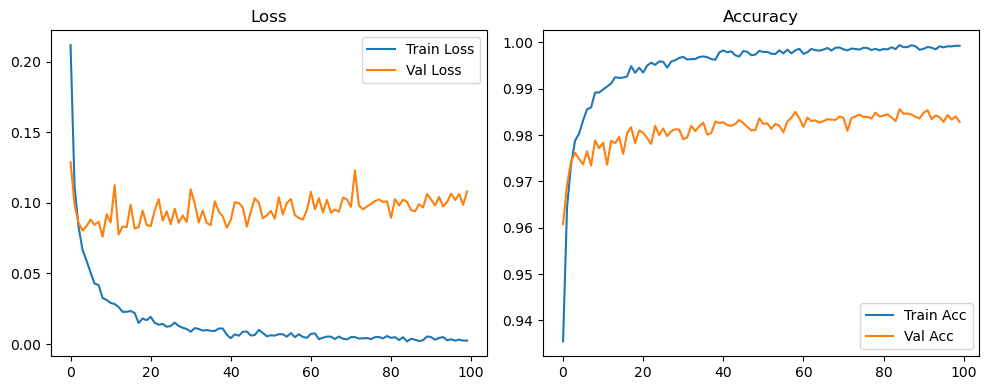

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2695, Acc: 0.9173 | Val Loss: 0.1399, Acc: 0.9581


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1566, Acc: 0.9517 | Val Loss: 0.1094, Acc: 0.9656


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1243, Acc: 0.9615 | Val Loss: 0.0970, Acc: 0.9708


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1100, Acc: 0.9656 | Val Loss: 0.0875, Acc: 0.9737


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0963, Acc: 0.9690 | Val Loss: 0.0967, Acc: 0.9714


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0900, Acc: 0.9702 | Val Loss: 0.0822, Acc: 0.9746


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0811, Acc: 0.9744 | Val Loss: 0.0856, Acc: 0.9727


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0747, Acc: 0.9759 | Val Loss: 0.0794, Acc: 0.9768


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0669, Acc: 0.9777 | Val Loss: 0.0772, Acc: 0.9755


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0659, Acc: 0.9782 | Val Loss: 0.0740, Acc: 0.9786


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0592, Acc: 0.9804 | Val Loss: 0.0705, Acc: 0.9796


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0571, Acc: 0.9817 | Val Loss: 0.0810, Acc: 0.9773


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0518, Acc: 0.9829 | Val Loss: 0.0695, Acc: 0.9797


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0524, Acc: 0.9823 | Val Loss: 0.0684, Acc: 0.9795


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0484, Acc: 0.9841 | Val Loss: 0.0723, Acc: 0.9794


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0480, Acc: 0.9838 | Val Loss: 0.0726, Acc: 0.9802


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0441, Acc: 0.9852 | Val Loss: 0.0759, Acc: 0.9794


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0433, Acc: 0.9859 | Val Loss: 0.0702, Acc: 0.9793


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9863 | Val Loss: 0.0709, Acc: 0.9798


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9877 | Val Loss: 0.0727, Acc: 0.9805


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9869 | Val Loss: 0.0690, Acc: 0.9812


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9870 | Val Loss: 0.0638, Acc: 0.9822


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0337, Acc: 0.9891 | Val Loss: 0.0696, Acc: 0.9809


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0322, Acc: 0.9890 | Val Loss: 0.0748, Acc: 0.9809


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9898 | Val Loss: 0.0737, Acc: 0.9807


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9901 | Val Loss: 0.0710, Acc: 0.9819


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0304, Acc: 0.9897 | Val Loss: 0.0701, Acc: 0.9827


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0307, Acc: 0.9896 | Val Loss: 0.0712, Acc: 0.9828


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9904 | Val Loss: 0.0776, Acc: 0.9814


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9910 | Val Loss: 0.0735, Acc: 0.9822


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0259, Acc: 0.9912 | Val Loss: 0.0697, Acc: 0.9832


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0250, Acc: 0.9916 | Val Loss: 0.0681, Acc: 0.9836


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9922 | Val Loss: 0.0689, Acc: 0.9818


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.0736, Acc: 0.9824


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.0693, Acc: 0.9845


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0215, Acc: 0.9924 | Val Loss: 0.0765, Acc: 0.9827


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0220, Acc: 0.9924 | Val Loss: 0.0712, Acc: 0.9822


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.0697, Acc: 0.9840


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.0767, Acc: 0.9819


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9928 | Val Loss: 0.0703, Acc: 0.9837


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9934 | Val Loss: 0.0775, Acc: 0.9830


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0804, Acc: 0.9823


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9933 | Val Loss: 0.0779, Acc: 0.9828


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9936 | Val Loss: 0.0761, Acc: 0.9828


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0200, Acc: 0.9936 | Val Loss: 0.0775, Acc: 0.9826


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.0834, Acc: 0.9819


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.0723, Acc: 0.9844


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9945 | Val Loss: 0.0737, Acc: 0.9840


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9937 | Val Loss: 0.0783, Acc: 0.9826


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9946 | Val Loss: 0.0766, Acc: 0.9844


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.0817, Acc: 0.9822


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9946 | Val Loss: 0.0844, Acc: 0.9825


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.0837, Acc: 0.9838


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.0794, Acc: 0.9836


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9953 | Val Loss: 0.0782, Acc: 0.9839


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9951 | Val Loss: 0.0807, Acc: 0.9841


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.0791, Acc: 0.9842


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0135, Acc: 0.9955 | Val Loss: 0.0731, Acc: 0.9859


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.0813, Acc: 0.9836


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0812, Acc: 0.9824


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9952 | Val Loss: 0.0787, Acc: 0.9838


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.0812, Acc: 0.9832


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.0760, Acc: 0.9847


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 0.0814, Acc: 0.9835


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9959 | Val Loss: 0.0775, Acc: 0.9855


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.0763, Acc: 0.9850


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.0837, Acc: 0.9822


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0136, Acc: 0.9952 | Val Loss: 0.0777, Acc: 0.9843


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.0764, Acc: 0.9839


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.0797, Acc: 0.9849


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9964 | Val Loss: 0.0844, Acc: 0.9841


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.0798, Acc: 0.9854


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0810, Acc: 0.9829


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0834, Acc: 0.9839


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0770, Acc: 0.9847


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.0790, Acc: 0.9849


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0800, Acc: 0.9843


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.0796, Acc: 0.9837


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0812, Acc: 0.9846


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0800, Acc: 0.9839


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0728, Acc: 0.9844


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0779, Acc: 0.9844


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0859, Acc: 0.9832


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0782, Acc: 0.9845


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9962 | Val Loss: 0.0898, Acc: 0.9845


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0833, Acc: 0.9847


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9971 | Val Loss: 0.0797, Acc: 0.9844


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.0768, Acc: 0.9857


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0790, Acc: 0.9853


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0829, Acc: 0.9846


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.0810, Acc: 0.9831


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0839, Acc: 0.9845


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0858, Acc: 0.9841


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.0833, Acc: 0.9844


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0872, Acc: 0.9840


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0876, Acc: 0.9835


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.0841, Acc: 0.9848


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9973 | Val Loss: 0.0818, Acc: 0.9855


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.0842, Acc: 0.9838


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0885, Acc: 0.9853


Final Test Loss: 0.0875 Accuracy: 0.9841


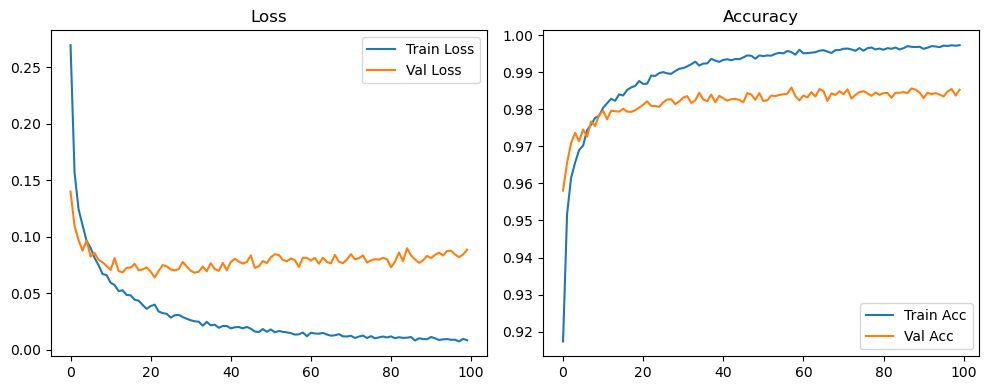

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2660, Acc: 0.9211 | Val Loss: 0.1670, Acc: 0.9489


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1115, Acc: 0.9651 | Val Loss: 0.1150, Acc: 0.9677


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9764 | Val Loss: 0.1090, Acc: 0.9704


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9814 | Val Loss: 0.0868, Acc: 0.9754


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9854 | Val Loss: 0.1106, Acc: 0.9701


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9874 | Val Loss: 0.1115, Acc: 0.9718


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9899 | Val Loss: 0.0914, Acc: 0.9767


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9913 | Val Loss: 0.1206, Acc: 0.9715


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.0968, Acc: 0.9758


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.1035, Acc: 0.9752


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.1076, Acc: 0.9764


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.1135, Acc: 0.9764


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.0883, Acc: 0.9793


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9958 | Val Loss: 0.1026, Acc: 0.9803


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.0970, Acc: 0.9774


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.0966, Acc: 0.9787


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1021, Acc: 0.9773


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1017, Acc: 0.9796


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.1077, Acc: 0.9761


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9961 | Val Loss: 0.1037, Acc: 0.9792


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1079, Acc: 0.9791


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9956 | Val Loss: 0.0955, Acc: 0.9785


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0947, Acc: 0.9814


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0957, Acc: 0.9819


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9952 | Val Loss: 0.1069, Acc: 0.9782


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1070, Acc: 0.9801


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.0988, Acc: 0.9825


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9969 | Val Loss: 0.1005, Acc: 0.9799


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1093, Acc: 0.9789


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1126, Acc: 0.9786


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1071, Acc: 0.9793


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0937, Acc: 0.9826


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0963, Acc: 0.9827


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1101, Acc: 0.9808


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1142, Acc: 0.9809


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1026, Acc: 0.9816


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1086, Acc: 0.9801


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.0938, Acc: 0.9813


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0984, Acc: 0.9829


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1187, Acc: 0.9802


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1231, Acc: 0.9802


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1386, Acc: 0.9735


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0953, Acc: 0.9835


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0873, Acc: 0.9835


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1040, Acc: 0.9825


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1104, Acc: 0.9820


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1038, Acc: 0.9820


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1045, Acc: 0.9800


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1002, Acc: 0.9821


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0986, Acc: 0.9813


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0933, Acc: 0.9824


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1009, Acc: 0.9815


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0968, Acc: 0.9837


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9995 | Val Loss: 0.0929, Acc: 0.9833


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0996, Acc: 0.9834


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1154, Acc: 0.9802


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9980 | Val Loss: 0.1273, Acc: 0.9789


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1018, Acc: 0.9824


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1088, Acc: 0.9817


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1125, Acc: 0.9821


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1213, Acc: 0.9779


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1205, Acc: 0.9804


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9976 | Val Loss: 0.1175, Acc: 0.9804


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1040, Acc: 0.9823


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1185, Acc: 0.9808


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.0947, Acc: 0.9839


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0996, Acc: 0.9838


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0945, Acc: 0.9844


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.0953, Acc: 0.9837


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1089, Acc: 0.9822


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9989 | Val Loss: 0.1048, Acc: 0.9814


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9973 | Val Loss: 0.1431, Acc: 0.9801


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1036, Acc: 0.9838


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9989 | Val Loss: 0.1010, Acc: 0.9822


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0969, Acc: 0.9847


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1009, Acc: 0.9845


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1081, Acc: 0.9846


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1078, Acc: 0.9829


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1041, Acc: 0.9852


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1155, Acc: 0.9823


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1198, Acc: 0.9801


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9985 | Val Loss: 0.1020, Acc: 0.9826


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1153, Acc: 0.9818


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1055, Acc: 0.9836


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1064, Acc: 0.9832


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1076, Acc: 0.9831


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1412, Acc: 0.9806


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9978 | Val Loss: 0.1255, Acc: 0.9812


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1256, Acc: 0.9809


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1108, Acc: 0.9824


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1041, Acc: 0.9838


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0986, Acc: 0.9836


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1050, Acc: 0.9827


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0010, Acc: 0.9999 | Val Loss: 0.1014, Acc: 0.9835


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1056, Acc: 0.9828


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1068, Acc: 0.9820


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1174, Acc: 0.9828


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1048, Acc: 0.9842


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1248, Acc: 0.9817


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1205, Acc: 0.9822


Final Test Loss: 0.1126 Accuracy: 0.9815


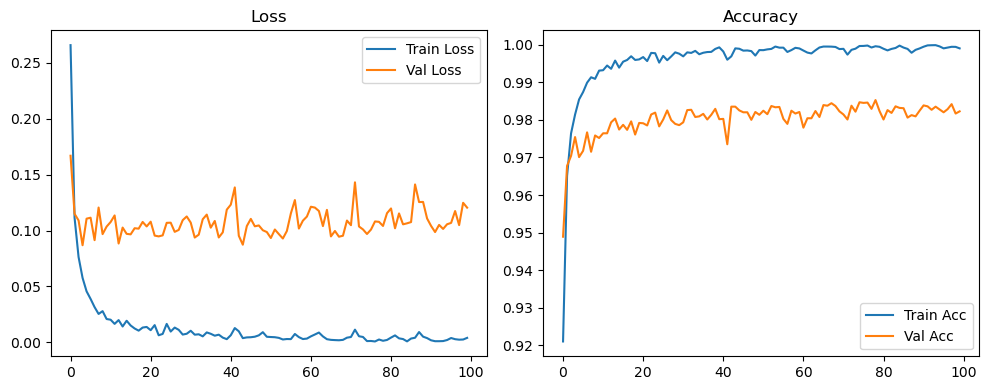

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2780, Acc: 0.9166 | Val Loss: 0.1694, Acc: 0.9520


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1308, Acc: 0.9598 | Val Loss: 0.1132, Acc: 0.9663


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0915, Acc: 0.9710 | Val Loss: 0.1074, Acc: 0.9683


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0725, Acc: 0.9770 | Val Loss: 0.0913, Acc: 0.9730


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9813 | Val Loss: 0.1008, Acc: 0.9712


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9824 | Val Loss: 0.1169, Acc: 0.9683


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9848 | Val Loss: 0.0901, Acc: 0.9750


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9876 | Val Loss: 0.1166, Acc: 0.9699


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9887 | Val Loss: 0.1102, Acc: 0.9720


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.0985, Acc: 0.9761


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9903 | Val Loss: 0.0897, Acc: 0.9783


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.0974, Acc: 0.9776


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9917 | Val Loss: 0.0945, Acc: 0.9768


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.0935, Acc: 0.9782


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9937 | Val Loss: 0.0922, Acc: 0.9783


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.1007, Acc: 0.9775


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.0960, Acc: 0.9786


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.1031, Acc: 0.9778


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9939 | Val Loss: 0.1054, Acc: 0.9790


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9957 | Val Loss: 0.0913, Acc: 0.9809


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1176, Acc: 0.9758


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.0961, Acc: 0.9788


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9951 | Val Loss: 0.0915, Acc: 0.9799


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0903, Acc: 0.9821


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1061, Acc: 0.9781


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.1005, Acc: 0.9795


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0908, Acc: 0.9808


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9954 | Val Loss: 0.0920, Acc: 0.9816


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9959 | Val Loss: 0.1029, Acc: 0.9797


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1107, Acc: 0.9798


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.1009, Acc: 0.9811


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.1067, Acc: 0.9800


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9959 | Val Loss: 0.1027, Acc: 0.9792


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0943, Acc: 0.9821


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1077, Acc: 0.9798


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1019, Acc: 0.9800


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9962 | Val Loss: 0.1005, Acc: 0.9805


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0991, Acc: 0.9822


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1131, Acc: 0.9798


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.1161, Acc: 0.9812


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1050, Acc: 0.9822


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1113, Acc: 0.9809


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1029, Acc: 0.9827


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1051, Acc: 0.9815


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9976 | Val Loss: 0.0998, Acc: 0.9806


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1009, Acc: 0.9814


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1196, Acc: 0.9803


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9968 | Val Loss: 0.1063, Acc: 0.9807


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1101, Acc: 0.9788


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1253, Acc: 0.9793


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.1017, Acc: 0.9811


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.0961, Acc: 0.9827


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.0991, Acc: 0.9832


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1057, Acc: 0.9834


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1042, Acc: 0.9829


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1267, Acc: 0.9806


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1009, Acc: 0.9818


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0957, Acc: 0.9837


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1067, Acc: 0.9815


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1074, Acc: 0.9812


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1126, Acc: 0.9830


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9978 | Val Loss: 0.1182, Acc: 0.9809


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1095, Acc: 0.9833


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1288, Acc: 0.9803


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1215, Acc: 0.9820


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1118, Acc: 0.9838


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1100, Acc: 0.9834


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1090, Acc: 0.9830


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1042, Acc: 0.9834


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1137, Acc: 0.9837


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9979 | Val Loss: 0.1195, Acc: 0.9818


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1011, Acc: 0.9842


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1145, Acc: 0.9838


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1050, Acc: 0.9832


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.1030, Acc: 0.9837


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1280, Acc: 0.9826


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9980 | Val Loss: 0.1194, Acc: 0.9838


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.1043, Acc: 0.9840


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1208, Acc: 0.9819


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1169, Acc: 0.9819


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1214, Acc: 0.9824


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9986 | Val Loss: 0.1112, Acc: 0.9824


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1149, Acc: 0.9819


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1087, Acc: 0.9823


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1036, Acc: 0.9842


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1215, Acc: 0.9824


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1159, Acc: 0.9831


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1229, Acc: 0.9820


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9973 | Val Loss: 0.1109, Acc: 0.9830


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1012, Acc: 0.9840


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1085, Acc: 0.9844


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1203, Acc: 0.9828


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1159, Acc: 0.9838


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9984 | Val Loss: 0.1177, Acc: 0.9824


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.1347, Acc: 0.9828


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1232, Acc: 0.9825


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1169, Acc: 0.9839


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1183, Acc: 0.9838


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1376, Acc: 0.9825


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1297, Acc: 0.9829


Final Test Loss: 0.1303 Accuracy: 0.9839


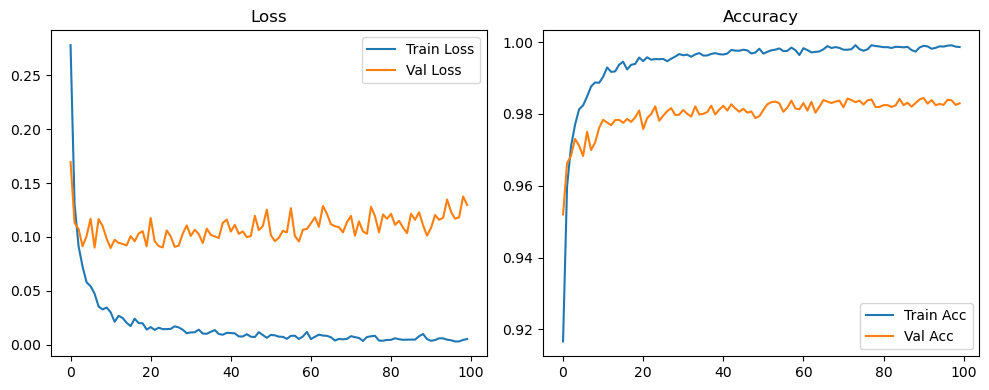

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3129, Acc: 0.9072 | Val Loss: 0.1793, Acc: 0.9489


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1741, Acc: 0.9477 | Val Loss: 0.1191, Acc: 0.9651


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1343, Acc: 0.9597 | Val Loss: 0.1048, Acc: 0.9690


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1118, Acc: 0.9660 | Val Loss: 0.0930, Acc: 0.9727


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0940, Acc: 0.9708 | Val Loss: 0.0906, Acc: 0.9730


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0872, Acc: 0.9726 | Val Loss: 0.0875, Acc: 0.9738


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9760 | Val Loss: 0.0853, Acc: 0.9752


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9774 | Val Loss: 0.0874, Acc: 0.9749


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9802 | Val Loss: 0.0834, Acc: 0.9757


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9816 | Val Loss: 0.0775, Acc: 0.9788


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9827 | Val Loss: 0.0817, Acc: 0.9786


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9836 | Val Loss: 0.0801, Acc: 0.9782


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9833 | Val Loss: 0.0788, Acc: 0.9784


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9852 | Val Loss: 0.0778, Acc: 0.9802


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9855 | Val Loss: 0.0766, Acc: 0.9792


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9866 | Val Loss: 0.0770, Acc: 0.9806


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9862 | Val Loss: 0.0888, Acc: 0.9792


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9864 | Val Loss: 0.0723, Acc: 0.9818


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9889 | Val Loss: 0.0775, Acc: 0.9803


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9894 | Val Loss: 0.0697, Acc: 0.9827


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9884 | Val Loss: 0.0807, Acc: 0.9817


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.0689, Acc: 0.9824


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9910 | Val Loss: 0.0799, Acc: 0.9822


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9898 | Val Loss: 0.0837, Acc: 0.9802


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.0773, Acc: 0.9815


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9904 | Val Loss: 0.0780, Acc: 0.9817


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9915 | Val Loss: 0.0760, Acc: 0.9825


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9895 | Val Loss: 0.0847, Acc: 0.9809


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9908 | Val Loss: 0.0820, Acc: 0.9828


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9911 | Val Loss: 0.0817, Acc: 0.9818


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.0981, Acc: 0.9790


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9908 | Val Loss: 0.0766, Acc: 0.9832


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0845, Acc: 0.9810


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.0863, Acc: 0.9827


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9922 | Val Loss: 0.0906, Acc: 0.9810


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0802, Acc: 0.9830


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0809, Acc: 0.9845


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9923 | Val Loss: 0.0815, Acc: 0.9831


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9929 | Val Loss: 0.0798, Acc: 0.9823


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9934 | Val Loss: 0.0913, Acc: 0.9826


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.0914, Acc: 0.9838


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9930 | Val Loss: 0.0864, Acc: 0.9829


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9939 | Val Loss: 0.0803, Acc: 0.9844


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.0784, Acc: 0.9837


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9932 | Val Loss: 0.0965, Acc: 0.9827


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9928 | Val Loss: 0.0877, Acc: 0.9830


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9942 | Val Loss: 0.0835, Acc: 0.9843


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9941 | Val Loss: 0.0919, Acc: 0.9834


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.0878, Acc: 0.9831


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9937 | Val Loss: 0.0952, Acc: 0.9828


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.1001, Acc: 0.9830


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9938 | Val Loss: 0.0936, Acc: 0.9832


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9944 | Val Loss: 0.0846, Acc: 0.9850


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.0859, Acc: 0.9844


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9942 | Val Loss: 0.1073, Acc: 0.9825


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9939 | Val Loss: 0.1021, Acc: 0.9832


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9941 | Val Loss: 0.0913, Acc: 0.9836


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9937 | Val Loss: 0.0887, Acc: 0.9848


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9951 | Val Loss: 0.0865, Acc: 0.9853


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9950 | Val Loss: 0.1068, Acc: 0.9822


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9948 | Val Loss: 0.0922, Acc: 0.9842


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9951 | Val Loss: 0.0978, Acc: 0.9832


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9953 | Val Loss: 0.1102, Acc: 0.9836


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0212, Acc: 0.9945 | Val Loss: 0.1150, Acc: 0.9810


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9952 | Val Loss: 0.1042, Acc: 0.9829


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9954 | Val Loss: 0.1052, Acc: 0.9831


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9942 | Val Loss: 0.1103, Acc: 0.9818


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9942 | Val Loss: 0.0807, Acc: 0.9844


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 0.0964, Acc: 0.9836


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.0957, Acc: 0.9835


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9957 | Val Loss: 0.1105, Acc: 0.9835


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1017, Acc: 0.9850


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9963 | Val Loss: 0.1148, Acc: 0.9832


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9944 | Val Loss: 0.1184, Acc: 0.9821


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0226, Acc: 0.9944 | Val Loss: 0.0956, Acc: 0.9842


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9950 | Val Loss: 0.1080, Acc: 0.9834


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9956 | Val Loss: 0.0980, Acc: 0.9848


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9955 | Val Loss: 0.1041, Acc: 0.9848


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9955 | Val Loss: 0.1002, Acc: 0.9834


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9966 | Val Loss: 0.1071, Acc: 0.9840


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9954 | Val Loss: 0.1035, Acc: 0.9848


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9962 | Val Loss: 0.0925, Acc: 0.9856


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9960 | Val Loss: 0.1016, Acc: 0.9857


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9962 | Val Loss: 0.0958, Acc: 0.9854


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9957 | Val Loss: 0.0969, Acc: 0.9859


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9956 | Val Loss: 0.0987, Acc: 0.9855


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9959 | Val Loss: 0.1041, Acc: 0.9851


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9958 | Val Loss: 0.1068, Acc: 0.9836


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9964 | Val Loss: 0.1121, Acc: 0.9833


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9966 | Val Loss: 0.1077, Acc: 0.9846


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9969 | Val Loss: 0.1093, Acc: 0.9848


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9962 | Val Loss: 0.1353, Acc: 0.9821


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9958 | Val Loss: 0.1219, Acc: 0.9838


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9964 | Val Loss: 0.1192, Acc: 0.9849


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9967 | Val Loss: 0.1384, Acc: 0.9835


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9961 | Val Loss: 0.1234, Acc: 0.9849


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9963 | Val Loss: 0.1259, Acc: 0.9849


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0169, Acc: 0.9956 | Val Loss: 0.1131, Acc: 0.9854


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9964 | Val Loss: 0.1117, Acc: 0.9856


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9967 | Val Loss: 0.1166, Acc: 0.9849


Final Test Loss: 0.1088 Accuracy: 0.9858


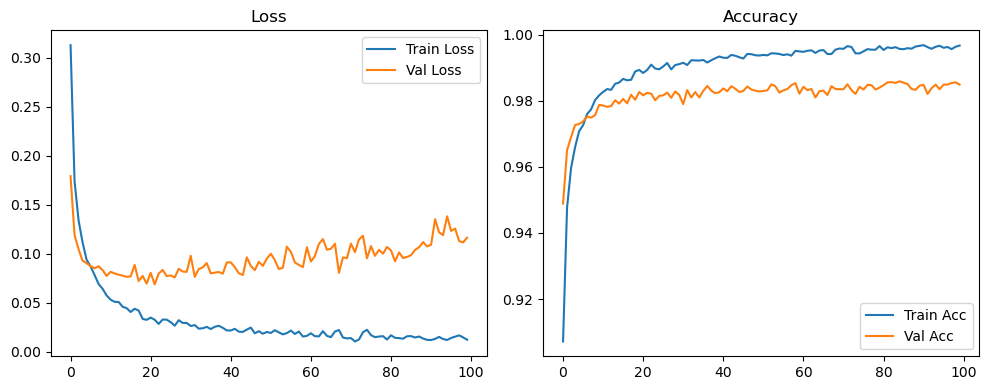

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2660, Acc: 0.9211 | Val Loss: 0.1670, Acc: 0.9489


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1115, Acc: 0.9651 | Val Loss: 0.1150, Acc: 0.9677


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9764 | Val Loss: 0.1090, Acc: 0.9704


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9814 | Val Loss: 0.0868, Acc: 0.9754


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9854 | Val Loss: 0.1106, Acc: 0.9701


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9874 | Val Loss: 0.1115, Acc: 0.9718


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9899 | Val Loss: 0.0914, Acc: 0.9767


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9913 | Val Loss: 0.1206, Acc: 0.9715


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.0968, Acc: 0.9758


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.1035, Acc: 0.9752


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.1076, Acc: 0.9764


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.1135, Acc: 0.9764


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.0883, Acc: 0.9793


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9958 | Val Loss: 0.1026, Acc: 0.9803


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.0970, Acc: 0.9774


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.0966, Acc: 0.9787


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1021, Acc: 0.9773


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1017, Acc: 0.9796


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.1077, Acc: 0.9761


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9961 | Val Loss: 0.1037, Acc: 0.9792


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1079, Acc: 0.9791


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9956 | Val Loss: 0.0955, Acc: 0.9785


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0947, Acc: 0.9814


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0957, Acc: 0.9819


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9952 | Val Loss: 0.1069, Acc: 0.9782


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1070, Acc: 0.9801


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.0988, Acc: 0.9825


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9969 | Val Loss: 0.1005, Acc: 0.9799


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1093, Acc: 0.9789


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1126, Acc: 0.9786


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1071, Acc: 0.9793


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0937, Acc: 0.9826


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0963, Acc: 0.9827


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1101, Acc: 0.9808


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1142, Acc: 0.9809


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1026, Acc: 0.9816


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1086, Acc: 0.9801


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.0938, Acc: 0.9813


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0984, Acc: 0.9829


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1187, Acc: 0.9802


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1231, Acc: 0.9802


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1386, Acc: 0.9735


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0953, Acc: 0.9835


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0873, Acc: 0.9835


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1040, Acc: 0.9825


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1104, Acc: 0.9820


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1038, Acc: 0.9820


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1045, Acc: 0.9800


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1002, Acc: 0.9821


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0986, Acc: 0.9813


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0854, Acc: 0.9838


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0824, Acc: 0.9853


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0864, Acc: 0.9848


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0864, Acc: 0.9848


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0853, Acc: 0.9858


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0865, Acc: 0.9853


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0886, Acc: 0.9852


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0904, Acc: 0.9851


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0895, Acc: 0.9855


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0893, Acc: 0.9855


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0903, Acc: 0.9851


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0925, Acc: 0.9854


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0900, Acc: 0.9845


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1052, Acc: 0.9848


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1129, Acc: 0.9832


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1163, Acc: 0.9818


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1087, Acc: 0.9828


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1065, Acc: 0.9832


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1028, Acc: 0.9837


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1035, Acc: 0.9838


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1021, Acc: 0.9840


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1030, Acc: 0.9845


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1009, Acc: 0.9840


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1009, Acc: 0.9843


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1023, Acc: 0.9838


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0950, Acc: 0.9846


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0994, Acc: 0.9843


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0968, Acc: 0.9841


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1039, Acc: 0.9813


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0998, Acc: 0.9834


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0974, Acc: 0.9834


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0951, Acc: 0.9839


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0943, Acc: 0.9844


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0932, Acc: 0.9838


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0943, Acc: 0.9843


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0940, Acc: 0.9843


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0938, Acc: 0.9849


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0942, Acc: 0.9846


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0956, Acc: 0.9848


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0951, Acc: 0.9849


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0959, Acc: 0.9853


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0964, Acc: 0.9851


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0970, Acc: 0.9852


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0999, Acc: 0.9849


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1021, Acc: 0.9855


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0991, Acc: 0.9848


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1033, Acc: 0.9847


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1025, Acc: 0.9850


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1167, Acc: 0.9838


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1212, Acc: 0.9828


Final Test Loss: 0.1106 Accuracy: 0.9840


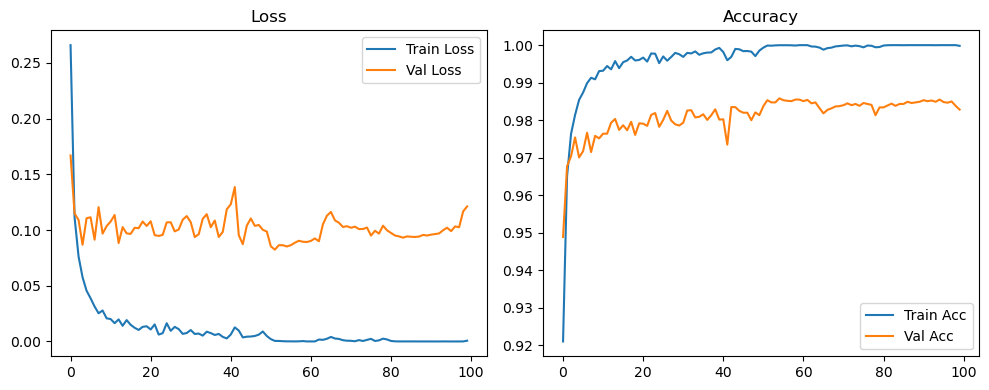

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2780, Acc: 0.9166 | Val Loss: 0.1694, Acc: 0.9520


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1308, Acc: 0.9598 | Val Loss: 0.1132, Acc: 0.9663


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0915, Acc: 0.9710 | Val Loss: 0.1074, Acc: 0.9683


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0725, Acc: 0.9770 | Val Loss: 0.0913, Acc: 0.9730


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9813 | Val Loss: 0.1008, Acc: 0.9712


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9824 | Val Loss: 0.1169, Acc: 0.9683


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9848 | Val Loss: 0.0901, Acc: 0.9750


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9876 | Val Loss: 0.1166, Acc: 0.9699


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9887 | Val Loss: 0.1102, Acc: 0.9720


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.0985, Acc: 0.9761


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9903 | Val Loss: 0.0897, Acc: 0.9783


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.0974, Acc: 0.9776


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9917 | Val Loss: 0.0945, Acc: 0.9768


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.0935, Acc: 0.9782


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9937 | Val Loss: 0.0922, Acc: 0.9783


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.1007, Acc: 0.9775


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.0960, Acc: 0.9786


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.1031, Acc: 0.9778


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9939 | Val Loss: 0.1054, Acc: 0.9790


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9957 | Val Loss: 0.0913, Acc: 0.9809


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1176, Acc: 0.9758


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.0961, Acc: 0.9788


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9951 | Val Loss: 0.0915, Acc: 0.9799


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0903, Acc: 0.9821


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1061, Acc: 0.9781


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.1005, Acc: 0.9795


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0908, Acc: 0.9808


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9954 | Val Loss: 0.0920, Acc: 0.9816


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9959 | Val Loss: 0.1029, Acc: 0.9797


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1107, Acc: 0.9798


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.1009, Acc: 0.9811


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.1067, Acc: 0.9800


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9959 | Val Loss: 0.1027, Acc: 0.9792


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0943, Acc: 0.9821


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1077, Acc: 0.9798


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1019, Acc: 0.9800


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9962 | Val Loss: 0.1005, Acc: 0.9805


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0991, Acc: 0.9822


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1131, Acc: 0.9798


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.1161, Acc: 0.9812


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1050, Acc: 0.9822


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1113, Acc: 0.9809


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1029, Acc: 0.9827


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1051, Acc: 0.9815


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9976 | Val Loss: 0.0998, Acc: 0.9806


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1009, Acc: 0.9814


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1196, Acc: 0.9803


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9968 | Val Loss: 0.1063, Acc: 0.9807


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1101, Acc: 0.9788


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1253, Acc: 0.9793


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0910, Acc: 0.9823


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0897, Acc: 0.9838


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0913, Acc: 0.9843


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0903, Acc: 0.9848


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0941, Acc: 0.9847


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0983, Acc: 0.9846


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0992, Acc: 0.9846


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1039, Acc: 0.9848


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1081, Acc: 0.9840


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1131, Acc: 0.9836


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0994, Acc: 0.9852


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1099, Acc: 0.9842


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.0957, Acc: 0.9842


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1031, Acc: 0.9837


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1168, Acc: 0.9838


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1058, Acc: 0.9848


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1074, Acc: 0.9840


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1215, Acc: 0.9832


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1282, Acc: 0.9823


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1124, Acc: 0.9823


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1167, Acc: 0.9831


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1139, Acc: 0.9838


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1005, Acc: 0.9840


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1004, Acc: 0.9838


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1025, Acc: 0.9847


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1115, Acc: 0.9837


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1204, Acc: 0.9818


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1097, Acc: 0.9835


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1186, Acc: 0.9832


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1150, Acc: 0.9835


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1084, Acc: 0.9837


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1037, Acc: 0.9848


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1032, Acc: 0.9848


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1033, Acc: 0.9852


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1068, Acc: 0.9846


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1045, Acc: 0.9857


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1082, Acc: 0.9843


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1028, Acc: 0.9850


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1100, Acc: 0.9842


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1074, Acc: 0.9848


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1049, Acc: 0.9852


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1097, Acc: 0.9848


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1086, Acc: 0.9851


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1125, Acc: 0.9852


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1104, Acc: 0.9860


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1179, Acc: 0.9844


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1127, Acc: 0.9852


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1106, Acc: 0.9848


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1172, Acc: 0.9847


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1146, Acc: 0.9853


Final Test Loss: 0.1026 Accuracy: 0.9870


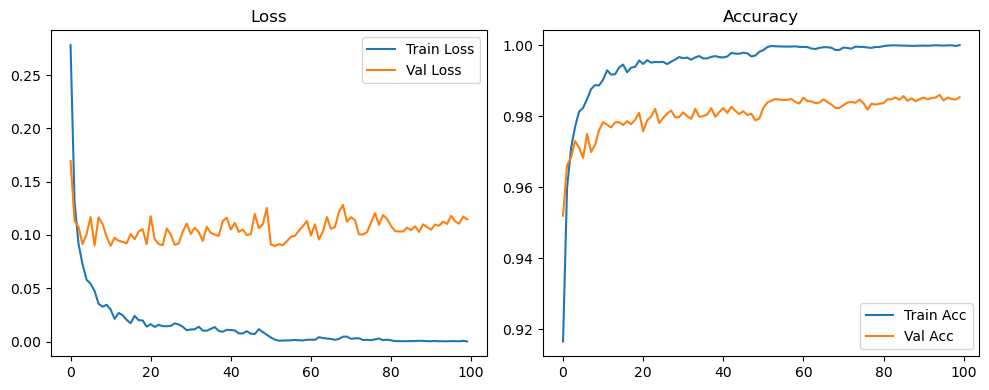

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3129, Acc: 0.9072 | Val Loss: 0.1793, Acc: 0.9489


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1741, Acc: 0.9477 | Val Loss: 0.1191, Acc: 0.9651


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1343, Acc: 0.9597 | Val Loss: 0.1048, Acc: 0.9690


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1118, Acc: 0.9660 | Val Loss: 0.0930, Acc: 0.9727


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0940, Acc: 0.9708 | Val Loss: 0.0906, Acc: 0.9730


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0872, Acc: 0.9726 | Val Loss: 0.0875, Acc: 0.9738


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9760 | Val Loss: 0.0853, Acc: 0.9752


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9774 | Val Loss: 0.0874, Acc: 0.9749


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9802 | Val Loss: 0.0834, Acc: 0.9757


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9816 | Val Loss: 0.0775, Acc: 0.9788


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9827 | Val Loss: 0.0817, Acc: 0.9786


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9836 | Val Loss: 0.0801, Acc: 0.9782


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9833 | Val Loss: 0.0788, Acc: 0.9784


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9852 | Val Loss: 0.0778, Acc: 0.9802


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9855 | Val Loss: 0.0766, Acc: 0.9792


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9866 | Val Loss: 0.0770, Acc: 0.9806


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9862 | Val Loss: 0.0888, Acc: 0.9792


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9864 | Val Loss: 0.0723, Acc: 0.9818


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9889 | Val Loss: 0.0775, Acc: 0.9803


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9894 | Val Loss: 0.0697, Acc: 0.9827


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9884 | Val Loss: 0.0807, Acc: 0.9817


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.0689, Acc: 0.9824


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9910 | Val Loss: 0.0799, Acc: 0.9822


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9898 | Val Loss: 0.0837, Acc: 0.9802


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.0773, Acc: 0.9815


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9904 | Val Loss: 0.0780, Acc: 0.9817


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9915 | Val Loss: 0.0760, Acc: 0.9825


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9895 | Val Loss: 0.0847, Acc: 0.9809


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9908 | Val Loss: 0.0820, Acc: 0.9828


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9911 | Val Loss: 0.0817, Acc: 0.9818


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.0981, Acc: 0.9790


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9908 | Val Loss: 0.0766, Acc: 0.9832


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0845, Acc: 0.9810


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.0863, Acc: 0.9827


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9922 | Val Loss: 0.0906, Acc: 0.9810


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0802, Acc: 0.9830


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0809, Acc: 0.9845


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9923 | Val Loss: 0.0815, Acc: 0.9831


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9929 | Val Loss: 0.0798, Acc: 0.9823


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9934 | Val Loss: 0.0913, Acc: 0.9826


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.0914, Acc: 0.9838


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9930 | Val Loss: 0.0864, Acc: 0.9829


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9939 | Val Loss: 0.0803, Acc: 0.9844


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.0784, Acc: 0.9837


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9932 | Val Loss: 0.0965, Acc: 0.9827


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9928 | Val Loss: 0.0877, Acc: 0.9830


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9942 | Val Loss: 0.0835, Acc: 0.9843


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9941 | Val Loss: 0.0919, Acc: 0.9834


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.0878, Acc: 0.9831


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9937 | Val Loss: 0.0952, Acc: 0.9828


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0812, Acc: 0.9856


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0801, Acc: 0.9852


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0808, Acc: 0.9853


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0860, Acc: 0.9850


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0849, Acc: 0.9866


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0858, Acc: 0.9857


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0846, Acc: 0.9858


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0799, Acc: 0.9872


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0833, Acc: 0.9859


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0889, Acc: 0.9856


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0922, Acc: 0.9861


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0915, Acc: 0.9860


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0902, Acc: 0.9857


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.0968, Acc: 0.9839


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0868, Acc: 0.9848


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0937, Acc: 0.9858


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0942, Acc: 0.9844


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0880, Acc: 0.9860


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0900, Acc: 0.9862


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0944, Acc: 0.9848


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0858, Acc: 0.9858


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0932, Acc: 0.9856


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9982 | Val Loss: 0.0926, Acc: 0.9853


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.0913, Acc: 0.9853


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0889, Acc: 0.9862


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.0948, Acc: 0.9855


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.0927, Acc: 0.9846


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0994, Acc: 0.9847


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0964, Acc: 0.9853


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0954, Acc: 0.9858


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0879, Acc: 0.9860


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.0875, Acc: 0.9860


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0940, Acc: 0.9862


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0920, Acc: 0.9861


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0918, Acc: 0.9865


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0905, Acc: 0.9862


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0875, Acc: 0.9871


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0904, Acc: 0.9862


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0916, Acc: 0.9864


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0928, Acc: 0.9854


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0948, Acc: 0.9860


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0917, Acc: 0.9856


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0919, Acc: 0.9862


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0938, Acc: 0.9861


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0880, Acc: 0.9868


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.0929, Acc: 0.9875


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0900, Acc: 0.9869


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0926, Acc: 0.9872


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.0924, Acc: 0.9868


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9992 | Val Loss: 0.0921, Acc: 0.9870


Final Test Loss: 0.0898 Accuracy: 0.9867


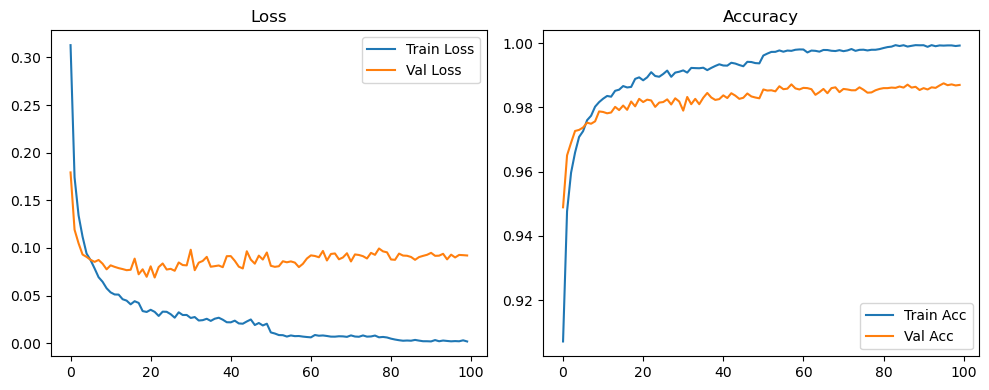

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2660, Acc: 0.9211 | Val Loss: 0.1670, Acc: 0.9489


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1115, Acc: 0.9651 | Val Loss: 0.1150, Acc: 0.9677


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9764 | Val Loss: 0.1090, Acc: 0.9704


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9814 | Val Loss: 0.0868, Acc: 0.9754


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9854 | Val Loss: 0.1106, Acc: 0.9701


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9874 | Val Loss: 0.1115, Acc: 0.9718


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9899 | Val Loss: 0.0914, Acc: 0.9767


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9913 | Val Loss: 0.1206, Acc: 0.9715


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.0968, Acc: 0.9758


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.1035, Acc: 0.9752


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.1076, Acc: 0.9764


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.1135, Acc: 0.9764


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.0883, Acc: 0.9793


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9958 | Val Loss: 0.1026, Acc: 0.9803


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.0970, Acc: 0.9774


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.0966, Acc: 0.9787


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1021, Acc: 0.9773


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1017, Acc: 0.9796


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.1077, Acc: 0.9761


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9961 | Val Loss: 0.1037, Acc: 0.9792


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1079, Acc: 0.9791


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9956 | Val Loss: 0.0955, Acc: 0.9785


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0947, Acc: 0.9814


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0957, Acc: 0.9819


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9952 | Val Loss: 0.1069, Acc: 0.9782


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1070, Acc: 0.9801


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.0988, Acc: 0.9825


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9969 | Val Loss: 0.1005, Acc: 0.9799


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1093, Acc: 0.9789


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1126, Acc: 0.9786


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1071, Acc: 0.9793


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0937, Acc: 0.9826


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0963, Acc: 0.9827


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1101, Acc: 0.9808


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1142, Acc: 0.9809


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1026, Acc: 0.9816


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1086, Acc: 0.9801


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.0938, Acc: 0.9813


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0984, Acc: 0.9829


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1187, Acc: 0.9802


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1231, Acc: 0.9802


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1386, Acc: 0.9735


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0953, Acc: 0.9835


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0873, Acc: 0.9835


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1040, Acc: 0.9825


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1104, Acc: 0.9820


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1038, Acc: 0.9820


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1045, Acc: 0.9800


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1002, Acc: 0.9821


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0986, Acc: 0.9813


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0854, Acc: 0.9838


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0824, Acc: 0.9853


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0864, Acc: 0.9848


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0864, Acc: 0.9848


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0853, Acc: 0.9858


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0865, Acc: 0.9853


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0886, Acc: 0.9852


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0904, Acc: 0.9851


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0895, Acc: 0.9855


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0893, Acc: 0.9855


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0903, Acc: 0.9851


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0925, Acc: 0.9854


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.0900, Acc: 0.9845


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1052, Acc: 0.9848


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1129, Acc: 0.9832


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1163, Acc: 0.9818


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1087, Acc: 0.9828


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1065, Acc: 0.9832


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1028, Acc: 0.9837


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1035, Acc: 0.9838


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1021, Acc: 0.9840


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1030, Acc: 0.9845


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1009, Acc: 0.9840


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1009, Acc: 0.9843


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1023, Acc: 0.9838


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.0950, Acc: 0.9846


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0994, Acc: 0.9843


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0968, Acc: 0.9841


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1039, Acc: 0.9813


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0998, Acc: 0.9834


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0961, Acc: 0.9832


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0945, Acc: 0.9838


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0934, Acc: 0.9837


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0933, Acc: 0.9838


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0937, Acc: 0.9841


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0940, Acc: 0.9839


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0939, Acc: 0.9842


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0936, Acc: 0.9842


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0945, Acc: 0.9843


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0934, Acc: 0.9842


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0943, Acc: 0.9845


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0943, Acc: 0.9844


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0943, Acc: 0.9847


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0952, Acc: 0.9858


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0961, Acc: 0.9856


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0950, Acc: 0.9851


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0975, Acc: 0.9848


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0967, Acc: 0.9850


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0996, Acc: 0.9848


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0992, Acc: 0.9846


Final Test Loss: 0.0893 Accuracy: 0.9857


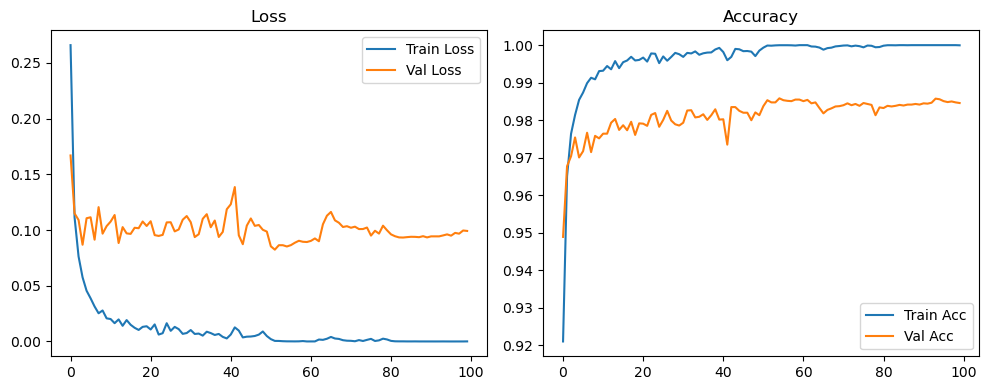

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2780, Acc: 0.9166 | Val Loss: 0.1694, Acc: 0.9520


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1308, Acc: 0.9598 | Val Loss: 0.1132, Acc: 0.9663


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0915, Acc: 0.9710 | Val Loss: 0.1074, Acc: 0.9683


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0725, Acc: 0.9770 | Val Loss: 0.0913, Acc: 0.9730


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9813 | Val Loss: 0.1008, Acc: 0.9712


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9824 | Val Loss: 0.1169, Acc: 0.9683


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9848 | Val Loss: 0.0901, Acc: 0.9750


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9876 | Val Loss: 0.1166, Acc: 0.9699


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9887 | Val Loss: 0.1102, Acc: 0.9720


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.0985, Acc: 0.9761


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9903 | Val Loss: 0.0897, Acc: 0.9783


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.0974, Acc: 0.9776


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9917 | Val Loss: 0.0945, Acc: 0.9768


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.0935, Acc: 0.9782


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9937 | Val Loss: 0.0922, Acc: 0.9783


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.1007, Acc: 0.9775


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.0960, Acc: 0.9786


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.1031, Acc: 0.9778


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9939 | Val Loss: 0.1054, Acc: 0.9790


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9957 | Val Loss: 0.0913, Acc: 0.9809


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1176, Acc: 0.9758


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.0961, Acc: 0.9788


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9951 | Val Loss: 0.0915, Acc: 0.9799


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0903, Acc: 0.9821


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1061, Acc: 0.9781


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.1005, Acc: 0.9795


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0908, Acc: 0.9808


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9954 | Val Loss: 0.0920, Acc: 0.9816


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9959 | Val Loss: 0.1029, Acc: 0.9797


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1107, Acc: 0.9798


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.1009, Acc: 0.9811


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.1067, Acc: 0.9800


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9959 | Val Loss: 0.1027, Acc: 0.9792


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0943, Acc: 0.9821


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1077, Acc: 0.9798


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1019, Acc: 0.9800


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9962 | Val Loss: 0.1005, Acc: 0.9805


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0991, Acc: 0.9822


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1131, Acc: 0.9798


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.1161, Acc: 0.9812


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1050, Acc: 0.9822


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1113, Acc: 0.9809


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1029, Acc: 0.9827


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1051, Acc: 0.9815


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9976 | Val Loss: 0.0998, Acc: 0.9806


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1009, Acc: 0.9814


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1196, Acc: 0.9803


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9968 | Val Loss: 0.1063, Acc: 0.9807


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1101, Acc: 0.9788


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1253, Acc: 0.9793


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.0910, Acc: 0.9823


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0897, Acc: 0.9838


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0913, Acc: 0.9843


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0903, Acc: 0.9848


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0941, Acc: 0.9847


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0983, Acc: 0.9846


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0992, Acc: 0.9846


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1039, Acc: 0.9848


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1081, Acc: 0.9840


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1131, Acc: 0.9836


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0994, Acc: 0.9852


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1099, Acc: 0.9842


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.0957, Acc: 0.9842


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1031, Acc: 0.9837


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1168, Acc: 0.9838


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1058, Acc: 0.9848


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1074, Acc: 0.9840


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1215, Acc: 0.9832


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1282, Acc: 0.9823


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1124, Acc: 0.9823


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1167, Acc: 0.9831


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1139, Acc: 0.9838


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1005, Acc: 0.9840


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1004, Acc: 0.9838


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1025, Acc: 0.9847


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1115, Acc: 0.9837


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1204, Acc: 0.9818


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1097, Acc: 0.9835


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1186, Acc: 0.9832


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1150, Acc: 0.9835


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1082, Acc: 0.9838


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1059, Acc: 0.9848


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1050, Acc: 0.9850


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1041, Acc: 0.9849


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1046, Acc: 0.9853


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1031, Acc: 0.9852


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1037, Acc: 0.9854


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1035, Acc: 0.9851


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1057, Acc: 0.9848


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1027, Acc: 0.9852


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1022, Acc: 0.9852


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1029, Acc: 0.9858


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1040, Acc: 0.9849


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1062, Acc: 0.9852


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1069, Acc: 0.9850


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1067, Acc: 0.9860


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1083, Acc: 0.9848


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1064, Acc: 0.9849


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1122, Acc: 0.9842


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1088, Acc: 0.9855


Final Test Loss: 0.0992 Accuracy: 0.9876


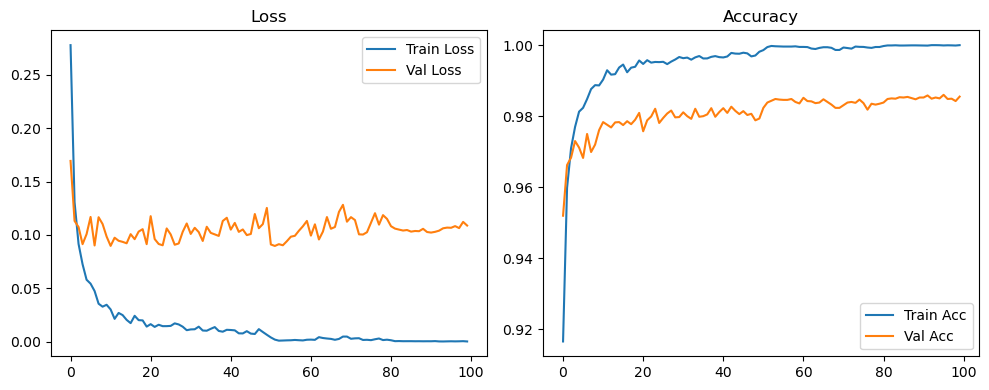

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3129, Acc: 0.9072 | Val Loss: 0.1793, Acc: 0.9489


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1741, Acc: 0.9477 | Val Loss: 0.1191, Acc: 0.9651


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1343, Acc: 0.9597 | Val Loss: 0.1048, Acc: 0.9690


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1118, Acc: 0.9660 | Val Loss: 0.0930, Acc: 0.9727


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0940, Acc: 0.9708 | Val Loss: 0.0906, Acc: 0.9730


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0872, Acc: 0.9726 | Val Loss: 0.0875, Acc: 0.9738


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9760 | Val Loss: 0.0853, Acc: 0.9752


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9774 | Val Loss: 0.0874, Acc: 0.9749


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9802 | Val Loss: 0.0834, Acc: 0.9757


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9816 | Val Loss: 0.0775, Acc: 0.9788


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9827 | Val Loss: 0.0817, Acc: 0.9786


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9836 | Val Loss: 0.0801, Acc: 0.9782


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9833 | Val Loss: 0.0788, Acc: 0.9784


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9852 | Val Loss: 0.0778, Acc: 0.9802


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9855 | Val Loss: 0.0766, Acc: 0.9792


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9866 | Val Loss: 0.0770, Acc: 0.9806


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9862 | Val Loss: 0.0888, Acc: 0.9792


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9864 | Val Loss: 0.0723, Acc: 0.9818


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9889 | Val Loss: 0.0775, Acc: 0.9803


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9894 | Val Loss: 0.0697, Acc: 0.9827


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9884 | Val Loss: 0.0807, Acc: 0.9817


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.0689, Acc: 0.9824


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9910 | Val Loss: 0.0799, Acc: 0.9822


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9898 | Val Loss: 0.0837, Acc: 0.9802


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.0773, Acc: 0.9815


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9904 | Val Loss: 0.0780, Acc: 0.9817


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9915 | Val Loss: 0.0760, Acc: 0.9825


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9895 | Val Loss: 0.0847, Acc: 0.9809


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9908 | Val Loss: 0.0820, Acc: 0.9828


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9911 | Val Loss: 0.0817, Acc: 0.9818


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.0981, Acc: 0.9790


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9908 | Val Loss: 0.0766, Acc: 0.9832


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0845, Acc: 0.9810


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.0863, Acc: 0.9827


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9922 | Val Loss: 0.0906, Acc: 0.9810


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0802, Acc: 0.9830


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0809, Acc: 0.9845


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9923 | Val Loss: 0.0815, Acc: 0.9831


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9929 | Val Loss: 0.0798, Acc: 0.9823


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9934 | Val Loss: 0.0913, Acc: 0.9826


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.0914, Acc: 0.9838


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9930 | Val Loss: 0.0864, Acc: 0.9829


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9939 | Val Loss: 0.0803, Acc: 0.9844


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.0784, Acc: 0.9837


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9932 | Val Loss: 0.0965, Acc: 0.9827


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9928 | Val Loss: 0.0877, Acc: 0.9830


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9942 | Val Loss: 0.0835, Acc: 0.9843


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9941 | Val Loss: 0.0919, Acc: 0.9834


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.0878, Acc: 0.9831


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9937 | Val Loss: 0.0952, Acc: 0.9828


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0812, Acc: 0.9856


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.0801, Acc: 0.9852


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.0808, Acc: 0.9853


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0860, Acc: 0.9850


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0849, Acc: 0.9866


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0858, Acc: 0.9857


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.0846, Acc: 0.9858


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0799, Acc: 0.9872


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.0833, Acc: 0.9859


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.0889, Acc: 0.9856


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0922, Acc: 0.9861


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.0915, Acc: 0.9860


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.0902, Acc: 0.9857


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.0968, Acc: 0.9839


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.0868, Acc: 0.9848


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0937, Acc: 0.9858


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0942, Acc: 0.9844


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0880, Acc: 0.9860


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.0900, Acc: 0.9862


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.0944, Acc: 0.9848


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.0858, Acc: 0.9858


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.0932, Acc: 0.9856


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9982 | Val Loss: 0.0926, Acc: 0.9853


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.0913, Acc: 0.9853


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0889, Acc: 0.9862


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9980 | Val Loss: 0.0948, Acc: 0.9855


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.0927, Acc: 0.9846


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.0994, Acc: 0.9847


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.0964, Acc: 0.9853


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0954, Acc: 0.9858


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.0888, Acc: 0.9855


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0871, Acc: 0.9859


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0911, Acc: 0.9858


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0892, Acc: 0.9866


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0885, Acc: 0.9864


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0895, Acc: 0.9863


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0862, Acc: 0.9867


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.0863, Acc: 0.9862


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0877, Acc: 0.9863


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0884, Acc: 0.9863


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0914, Acc: 0.9863


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0885, Acc: 0.9865


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.0871, Acc: 0.9859


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0885, Acc: 0.9863


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0849, Acc: 0.9860


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.0871, Acc: 0.9868


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0851, Acc: 0.9865


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0868, Acc: 0.9867


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.0883, Acc: 0.9868


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0895, Acc: 0.9870


Final Test Loss: 0.0841 Accuracy: 0.9882


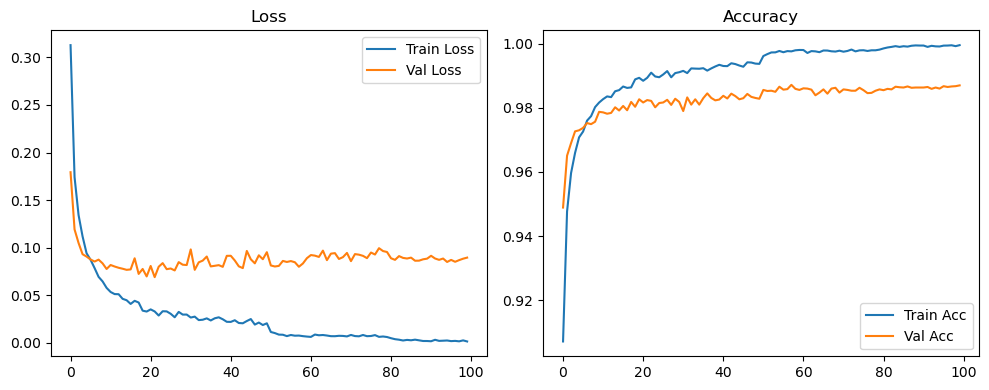

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2660, Acc: 0.9211 | Val Loss: 0.1670, Acc: 0.9489


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1115, Acc: 0.9651 | Val Loss: 0.1150, Acc: 0.9677


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0763, Acc: 0.9764 | Val Loss: 0.1090, Acc: 0.9704


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9814 | Val Loss: 0.0868, Acc: 0.9754


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0455, Acc: 0.9854 | Val Loss: 0.1106, Acc: 0.9701


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0388, Acc: 0.9874 | Val Loss: 0.1115, Acc: 0.9718


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9899 | Val Loss: 0.0914, Acc: 0.9767


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9913 | Val Loss: 0.1206, Acc: 0.9715


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.0968, Acc: 0.9758


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.1035, Acc: 0.9752


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.1076, Acc: 0.9764


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.1135, Acc: 0.9764


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.0883, Acc: 0.9793


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9958 | Val Loss: 0.1026, Acc: 0.9803


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.0970, Acc: 0.9774


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9955 | Val Loss: 0.0966, Acc: 0.9787


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1021, Acc: 0.9773


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1017, Acc: 0.9796


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.1077, Acc: 0.9761


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9961 | Val Loss: 0.1037, Acc: 0.9792


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1079, Acc: 0.9791


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9956 | Val Loss: 0.0955, Acc: 0.9785


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.0947, Acc: 0.9814


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.0957, Acc: 0.9819


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9952 | Val Loss: 0.1069, Acc: 0.9782


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1070, Acc: 0.9801


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.0988, Acc: 0.9825


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9969 | Val Loss: 0.1005, Acc: 0.9799


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1093, Acc: 0.9789


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1126, Acc: 0.9786


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1071, Acc: 0.9793


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0937, Acc: 0.9826


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0963, Acc: 0.9827


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.1101, Acc: 0.9808


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1142, Acc: 0.9809


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1026, Acc: 0.9816


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1086, Acc: 0.9801


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.0938, Acc: 0.9813


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.0984, Acc: 0.9829


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1187, Acc: 0.9802


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1231, Acc: 0.9802


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1386, Acc: 0.9735


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0953, Acc: 0.9835


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.0873, Acc: 0.9835


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1040, Acc: 0.9825


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1104, Acc: 0.9820


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1038, Acc: 0.9820


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9983 | Val Loss: 0.1045, Acc: 0.9800


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1002, Acc: 0.9821


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0986, Acc: 0.9813


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0818, Acc: 0.9842


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0787, Acc: 0.9849


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0791, Acc: 0.9850


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0790, Acc: 0.9852


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0798, Acc: 0.9849


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0802, Acc: 0.9850


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0807, Acc: 0.9855


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0811, Acc: 0.9858


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0824, Acc: 0.9859


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0818, Acc: 0.9860


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0826, Acc: 0.9852


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0856, Acc: 0.9860


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0867, Acc: 0.9855


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0869, Acc: 0.9861


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0884, Acc: 0.9853


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0883, Acc: 0.9854


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0891, Acc: 0.9854


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0882, Acc: 0.9858


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0896, Acc: 0.9856


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0928, Acc: 0.9855


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0915, Acc: 0.9855


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0926, Acc: 0.9846


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0892, Acc: 0.9846


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0896, Acc: 0.9848


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0903, Acc: 0.9855


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0899, Acc: 0.9839


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0909, Acc: 0.9844


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0900, Acc: 0.9852


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0909, Acc: 0.9850


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0923, Acc: 0.9849


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0930, Acc: 0.9852


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0941, Acc: 0.9852


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0947, Acc: 0.9858


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0942, Acc: 0.9849


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0942, Acc: 0.9853


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0949, Acc: 0.9852


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0955, Acc: 0.9853


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0956, Acc: 0.9853


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0965, Acc: 0.9852


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0991, Acc: 0.9850


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0987, Acc: 0.9852


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1003, Acc: 0.9853


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1001, Acc: 0.9852


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1015, Acc: 0.9856


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1037, Acc: 0.9848


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1014, Acc: 0.9850


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1017, Acc: 0.9852


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1008, Acc: 0.9856


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1037, Acc: 0.9858


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1025, Acc: 0.9858


Final Test Loss: 0.0981 Accuracy: 0.9869


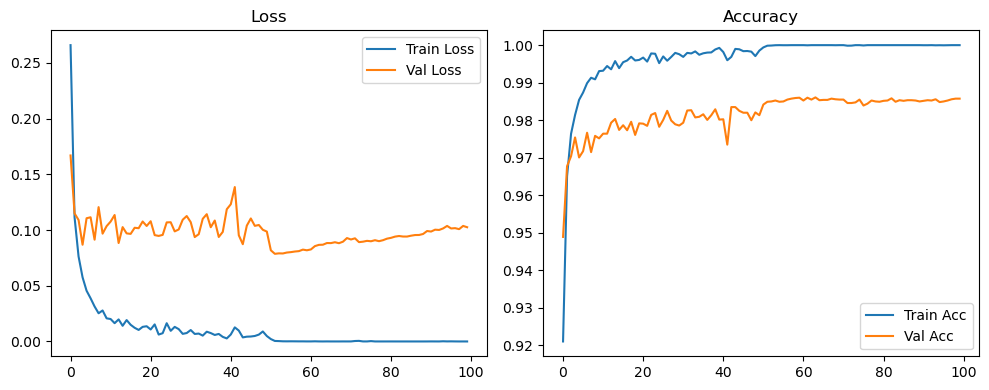

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.2780, Acc: 0.9166 | Val Loss: 0.1694, Acc: 0.9520


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1308, Acc: 0.9598 | Val Loss: 0.1132, Acc: 0.9663


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.0915, Acc: 0.9710 | Val Loss: 0.1074, Acc: 0.9683


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0725, Acc: 0.9770 | Val Loss: 0.0913, Acc: 0.9730


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0580, Acc: 0.9813 | Val Loss: 0.1008, Acc: 0.9712


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0543, Acc: 0.9824 | Val Loss: 0.1169, Acc: 0.9683


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0474, Acc: 0.9848 | Val Loss: 0.0901, Acc: 0.9750


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9876 | Val Loss: 0.1166, Acc: 0.9699


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9887 | Val Loss: 0.1102, Acc: 0.9720


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.0985, Acc: 0.9761


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9903 | Val Loss: 0.0897, Acc: 0.9783


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.0974, Acc: 0.9776


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0268, Acc: 0.9917 | Val Loss: 0.0945, Acc: 0.9768


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.0935, Acc: 0.9782


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9937 | Val Loss: 0.0922, Acc: 0.9783


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.1007, Acc: 0.9775


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9924 | Val Loss: 0.0960, Acc: 0.9786


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9936 | Val Loss: 0.1031, Acc: 0.9778


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9939 | Val Loss: 0.1054, Acc: 0.9790


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9957 | Val Loss: 0.0913, Acc: 0.9809


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9947 | Val Loss: 0.1176, Acc: 0.9758


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.0961, Acc: 0.9788


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9951 | Val Loss: 0.0915, Acc: 0.9799


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0903, Acc: 0.9821


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9952 | Val Loss: 0.1061, Acc: 0.9781


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.1005, Acc: 0.9795


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0170, Acc: 0.9946 | Val Loss: 0.0908, Acc: 0.9808


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9954 | Val Loss: 0.0920, Acc: 0.9816


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9959 | Val Loss: 0.1029, Acc: 0.9797


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1107, Acc: 0.9798


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.1009, Acc: 0.9811


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9965 | Val Loss: 0.1067, Acc: 0.9800


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9959 | Val Loss: 0.1027, Acc: 0.9792


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0943, Acc: 0.9821


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1077, Acc: 0.9798


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9962 | Val Loss: 0.1019, Acc: 0.9800


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9962 | Val Loss: 0.1005, Acc: 0.9805


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0991, Acc: 0.9822


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9969 | Val Loss: 0.1131, Acc: 0.9798


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.1161, Acc: 0.9812


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1050, Acc: 0.9822


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1113, Acc: 0.9809


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1029, Acc: 0.9827


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1051, Acc: 0.9815


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9976 | Val Loss: 0.0998, Acc: 0.9806


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1009, Acc: 0.9814


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1196, Acc: 0.9803


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9968 | Val Loss: 0.1063, Acc: 0.9807


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1101, Acc: 0.9788


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1253, Acc: 0.9793


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0891, Acc: 0.9822


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0848, Acc: 0.9838


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0855, Acc: 0.9843


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0826, Acc: 0.9842


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0856, Acc: 0.9840


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0888, Acc: 0.9850


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.0859, Acc: 0.9847


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0887, Acc: 0.9844


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0925, Acc: 0.9851


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0900, Acc: 0.9843


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0895, Acc: 0.9852


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0884, Acc: 0.9856


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.0913, Acc: 0.9847


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.0936, Acc: 0.9848


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.0905, Acc: 0.9856


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0951, Acc: 0.9846


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0960, Acc: 0.9851


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0948, Acc: 0.9852


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0928, Acc: 0.9862


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0975, Acc: 0.9857


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0978, Acc: 0.9853


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1035, Acc: 0.9856


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1023, Acc: 0.9849


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1005, Acc: 0.9842


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1031, Acc: 0.9852


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1064, Acc: 0.9847


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1034, Acc: 0.9857


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1018, Acc: 0.9858


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1041, Acc: 0.9863


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1095, Acc: 0.9856


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1049, Acc: 0.9852


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1025, Acc: 0.9858


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1025, Acc: 0.9860


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0993, Acc: 0.9861


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0996, Acc: 0.9865


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1028, Acc: 0.9858


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1069, Acc: 0.9859


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1048, Acc: 0.9858


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1091, Acc: 0.9858


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1080, Acc: 0.9855


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1041, Acc: 0.9856


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1017, Acc: 0.9857


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1079, Acc: 0.9847


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1043, Acc: 0.9863


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1099, Acc: 0.9856


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1083, Acc: 0.9867


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1106, Acc: 0.9861


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1092, Acc: 0.9852


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1155, Acc: 0.9857


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1089, Acc: 0.9859


Final Test Loss: 0.0994 Accuracy: 0.9875


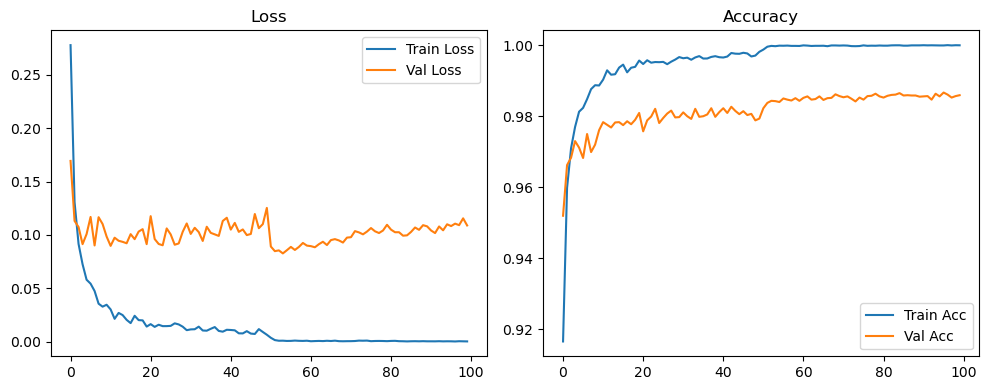

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.3129, Acc: 0.9072 | Val Loss: 0.1793, Acc: 0.9489


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1741, Acc: 0.9477 | Val Loss: 0.1191, Acc: 0.9651


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1343, Acc: 0.9597 | Val Loss: 0.1048, Acc: 0.9690


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1118, Acc: 0.9660 | Val Loss: 0.0930, Acc: 0.9727


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0940, Acc: 0.9708 | Val Loss: 0.0906, Acc: 0.9730


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0872, Acc: 0.9726 | Val Loss: 0.0875, Acc: 0.9738


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0785, Acc: 0.9760 | Val Loss: 0.0853, Acc: 0.9752


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0692, Acc: 0.9774 | Val Loss: 0.0874, Acc: 0.9749


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0644, Acc: 0.9802 | Val Loss: 0.0834, Acc: 0.9757


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0576, Acc: 0.9816 | Val Loss: 0.0775, Acc: 0.9788


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0533, Acc: 0.9827 | Val Loss: 0.0817, Acc: 0.9786


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9836 | Val Loss: 0.0801, Acc: 0.9782


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0510, Acc: 0.9833 | Val Loss: 0.0788, Acc: 0.9784


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9852 | Val Loss: 0.0778, Acc: 0.9802


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9855 | Val Loss: 0.0766, Acc: 0.9792


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0407, Acc: 0.9866 | Val Loss: 0.0770, Acc: 0.9806


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0440, Acc: 0.9862 | Val Loss: 0.0888, Acc: 0.9792


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0422, Acc: 0.9864 | Val Loss: 0.0723, Acc: 0.9818


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0337, Acc: 0.9889 | Val Loss: 0.0775, Acc: 0.9803


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0327, Acc: 0.9894 | Val Loss: 0.0697, Acc: 0.9827


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9884 | Val Loss: 0.0807, Acc: 0.9817


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0328, Acc: 0.9894 | Val Loss: 0.0689, Acc: 0.9824


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0286, Acc: 0.9910 | Val Loss: 0.0799, Acc: 0.9822


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0331, Acc: 0.9898 | Val Loss: 0.0837, Acc: 0.9802


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.0773, Acc: 0.9815


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0304, Acc: 0.9904 | Val Loss: 0.0780, Acc: 0.9817


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9915 | Val Loss: 0.0760, Acc: 0.9825


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9895 | Val Loss: 0.0847, Acc: 0.9809


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0295, Acc: 0.9908 | Val Loss: 0.0820, Acc: 0.9828


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9911 | Val Loss: 0.0817, Acc: 0.9818


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.0981, Acc: 0.9790


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0274, Acc: 0.9908 | Val Loss: 0.0766, Acc: 0.9832


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9923 | Val Loss: 0.0845, Acc: 0.9810


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.0863, Acc: 0.9827


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9922 | Val Loss: 0.0906, Acc: 0.9810


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.0802, Acc: 0.9830


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.0809, Acc: 0.9845


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9923 | Val Loss: 0.0815, Acc: 0.9831


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9929 | Val Loss: 0.0798, Acc: 0.9823


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0220, Acc: 0.9934 | Val Loss: 0.0913, Acc: 0.9826


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.0914, Acc: 0.9838


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9930 | Val Loss: 0.0864, Acc: 0.9829


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0207, Acc: 0.9939 | Val Loss: 0.0803, Acc: 0.9844


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.0784, Acc: 0.9837


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9932 | Val Loss: 0.0965, Acc: 0.9827


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9928 | Val Loss: 0.0877, Acc: 0.9830


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9942 | Val Loss: 0.0835, Acc: 0.9843


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9941 | Val Loss: 0.0919, Acc: 0.9834


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.0878, Acc: 0.9831


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9937 | Val Loss: 0.0952, Acc: 0.9828


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.0748, Acc: 0.9860


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0734, Acc: 0.9862


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.0723, Acc: 0.9862


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9976 | Val Loss: 0.0737, Acc: 0.9867


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.0758, Acc: 0.9863


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0761, Acc: 0.9860


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0737, Acc: 0.9873


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0736, Acc: 0.9866


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.0762, Acc: 0.9868


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0779, Acc: 0.9866


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.0789, Acc: 0.9866


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0788, Acc: 0.9870


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9984 | Val Loss: 0.0824, Acc: 0.9858


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0812, Acc: 0.9858


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.0785, Acc: 0.9868


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0790, Acc: 0.9869


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0821, Acc: 0.9863


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0816, Acc: 0.9857


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0860, Acc: 0.9858


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0879, Acc: 0.9865


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0861, Acc: 0.9860


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.0889, Acc: 0.9865


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0908, Acc: 0.9852


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.0883, Acc: 0.9859


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0906, Acc: 0.9858


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9992 | Val Loss: 0.0887, Acc: 0.9865


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0844, Acc: 0.9872


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0878, Acc: 0.9861


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0852, Acc: 0.9870


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0890, Acc: 0.9862


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0881, Acc: 0.9864


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0881, Acc: 0.9868


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0882, Acc: 0.9868


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0876, Acc: 0.9866


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.0869, Acc: 0.9869


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.0858, Acc: 0.9868


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0866, Acc: 0.9868


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0863, Acc: 0.9876


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.0875, Acc: 0.9864


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0879, Acc: 0.9868


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9994 | Val Loss: 0.0881, Acc: 0.9862


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0870, Acc: 0.9868


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0873, Acc: 0.9870


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0906, Acc: 0.9869


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0867, Acc: 0.9868


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.0887, Acc: 0.9868


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0892, Acc: 0.9868


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.0896, Acc: 0.9865


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.0905, Acc: 0.9872


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.0887, Acc: 0.9868


Final Test Loss: 0.0814 Accuracy: 0.9881


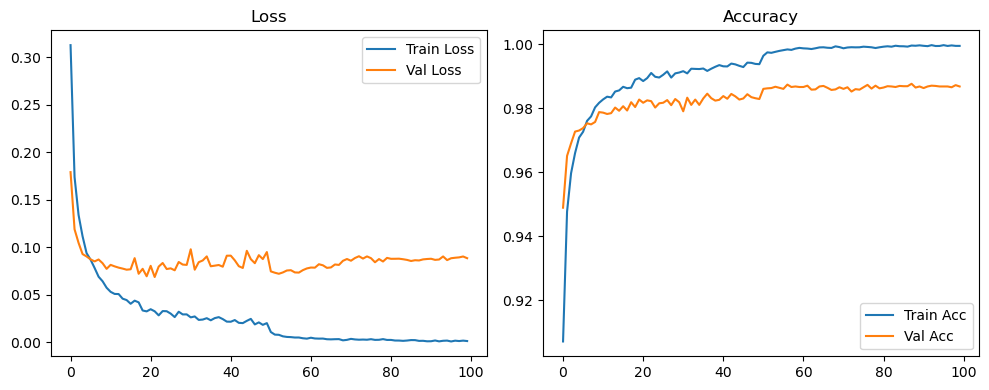

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2357, Acc: 0.9279 | Val Loss: 0.1552, Acc: 0.9545


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1075, Acc: 0.9661 | Val Loss: 0.0981, Acc: 0.9708


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0730, Acc: 0.9768 | Val Loss: 0.1061, Acc: 0.9714


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9818 | Val Loss: 0.0825, Acc: 0.9748


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9840 | Val Loss: 0.1236, Acc: 0.9642


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9878 | Val Loss: 0.1080, Acc: 0.9720


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9898 | Val Loss: 0.1011, Acc: 0.9738


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9912 | Val Loss: 0.1064, Acc: 0.9738


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.1026, Acc: 0.9744


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.0933, Acc: 0.9790


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.0899, Acc: 0.9789


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.1263, Acc: 0.9707


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.1038, Acc: 0.9777


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.1033, Acc: 0.9771


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9950 | Val Loss: 0.1078, Acc: 0.9776


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.1031, Acc: 0.9784


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9942 | Val Loss: 0.1072, Acc: 0.9762


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1005, Acc: 0.9801


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.1234, Acc: 0.9757


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1007, Acc: 0.9788


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.1222, Acc: 0.9783


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0962, Acc: 0.9803


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1053, Acc: 0.9792


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1176, Acc: 0.9791


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1036, Acc: 0.9793


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1036, Acc: 0.9788


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.1000, Acc: 0.9816


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.0971, Acc: 0.9804


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1039, Acc: 0.9808


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1335, Acc: 0.9766


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1108, Acc: 0.9818


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1037, Acc: 0.9809


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1069, Acc: 0.9802


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9974 | Val Loss: 0.1064, Acc: 0.9794


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1117, Acc: 0.9810


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0947, Acc: 0.9802


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0924, Acc: 0.9835


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0893, Acc: 0.9820


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0951, Acc: 0.9823


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0952, Acc: 0.9828


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0974, Acc: 0.9832


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1053, Acc: 0.9816


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.0998, Acc: 0.9815


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9981 | Val Loss: 0.1222, Acc: 0.9781


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1153, Acc: 0.9807


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1088, Acc: 0.9819


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1010, Acc: 0.9825


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.0964, Acc: 0.9828


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0991, Acc: 0.9832


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1449, Acc: 0.9760


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.1125, Acc: 0.9782


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1029, Acc: 0.9818


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1084, Acc: 0.9832


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1117, Acc: 0.9806


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1014, Acc: 0.9825


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1303, Acc: 0.9798


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1192, Acc: 0.9808


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1134, Acc: 0.9799


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1251, Acc: 0.9787


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1022, Acc: 0.9828


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1000, Acc: 0.9823


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0957, Acc: 0.9828


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1016, Acc: 0.9833


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0993, Acc: 0.9828


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.0980, Acc: 0.9832


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1032, Acc: 0.9822


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1106, Acc: 0.9813


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1149, Acc: 0.9814


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9984 | Val Loss: 0.1170, Acc: 0.9782


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0901, Acc: 0.9838


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1050, Acc: 0.9833


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1005, Acc: 0.9837


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.0882, Acc: 0.9846


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0918, Acc: 0.9857


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0975, Acc: 0.9852


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1078, Acc: 0.9829


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1267, Acc: 0.9811


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1074, Acc: 0.9822


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1133, Acc: 0.9830


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1059, Acc: 0.9832


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9988 | Val Loss: 0.1184, Acc: 0.9820


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1095, Acc: 0.9810


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0957, Acc: 0.9847


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0918, Acc: 0.9845


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0910, Acc: 0.9850


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0940, Acc: 0.9849


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1053, Acc: 0.9833


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.1214, Acc: 0.9806


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1012, Acc: 0.9834


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0952, Acc: 0.9839


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1138, Acc: 0.9816


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1084, Acc: 0.9826


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1035, Acc: 0.9839


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1007, Acc: 0.9843


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0987, Acc: 0.9833


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0929, Acc: 0.9845


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1003, Acc: 0.9841


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.1044, Acc: 0.9830


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1094, Acc: 0.9828


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0976, Acc: 0.9845


Final Test Loss: 0.0932 Accuracy: 0.9846


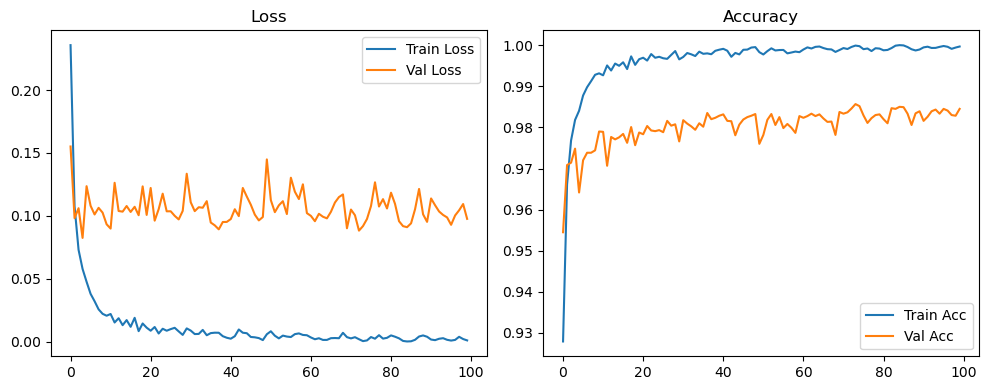

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2452, Acc: 0.9254 | Val Loss: 0.1617, Acc: 0.9527


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1224, Acc: 0.9623 | Val Loss: 0.1079, Acc: 0.9670


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0864, Acc: 0.9729 | Val Loss: 0.1039, Acc: 0.9696


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0725, Acc: 0.9767 | Val Loss: 0.0942, Acc: 0.9719


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0586, Acc: 0.9814 | Val Loss: 0.1004, Acc: 0.9710


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0538, Acc: 0.9820 | Val Loss: 0.0996, Acc: 0.9728


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9855 | Val Loss: 0.0926, Acc: 0.9749


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9898 | Val Loss: 0.1044, Acc: 0.9740


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9892 | Val Loss: 0.1011, Acc: 0.9745


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9904 | Val Loss: 0.1012, Acc: 0.9760


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9902 | Val Loss: 0.0934, Acc: 0.9781


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9897 | Val Loss: 0.1101, Acc: 0.9742


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9917 | Val Loss: 0.0943, Acc: 0.9793


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.0962, Acc: 0.9792


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.0958, Acc: 0.9777


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.1079, Acc: 0.9766


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9922 | Val Loss: 0.1022, Acc: 0.9773


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.0935, Acc: 0.9792


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9940 | Val Loss: 0.0944, Acc: 0.9789


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.0916, Acc: 0.9792


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0974, Acc: 0.9784


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.0948, Acc: 0.9794


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9956 | Val Loss: 0.0921, Acc: 0.9810


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.1146, Acc: 0.9793


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1087, Acc: 0.9799


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.0999, Acc: 0.9809


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.0968, Acc: 0.9801


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0923, Acc: 0.9820


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0996, Acc: 0.9805


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.0981, Acc: 0.9817


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1093, Acc: 0.9783


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1080, Acc: 0.9800


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1042, Acc: 0.9795


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1017, Acc: 0.9803


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1105, Acc: 0.9810


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.0967, Acc: 0.9818


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0984, Acc: 0.9823


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0935, Acc: 0.9829


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1013, Acc: 0.9822


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.0881, Acc: 0.9824


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0978, Acc: 0.9817


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1137, Acc: 0.9797


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0956, Acc: 0.9802


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1015, Acc: 0.9825


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0947, Acc: 0.9828


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1048, Acc: 0.9831


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1064, Acc: 0.9822


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1111, Acc: 0.9816


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1047, Acc: 0.9812


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1060, Acc: 0.9813


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1034, Acc: 0.9821


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9981 | Val Loss: 0.0928, Acc: 0.9834


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1030, Acc: 0.9822


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.0997, Acc: 0.9829


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1060, Acc: 0.9824


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1004, Acc: 0.9828


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1049, Acc: 0.9825


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.0933, Acc: 0.9839


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1022, Acc: 0.9832


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0980, Acc: 0.9822


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1174, Acc: 0.9811


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1176, Acc: 0.9807


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1007, Acc: 0.9836


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1068, Acc: 0.9845


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9982 | Val Loss: 0.1137, Acc: 0.9818


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.0980, Acc: 0.9833


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1038, Acc: 0.9822


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1047, Acc: 0.9826


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.0985, Acc: 0.9852


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1040, Acc: 0.9828


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1125, Acc: 0.9812


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1229, Acc: 0.9812


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.0962, Acc: 0.9836


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1102, Acc: 0.9831


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1047, Acc: 0.9838


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.0973, Acc: 0.9857


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1069, Acc: 0.9835


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0972, Acc: 0.9836


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1045, Acc: 0.9837


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1048, Acc: 0.9829


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1316, Acc: 0.9820


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1021, Acc: 0.9842


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1127, Acc: 0.9815


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1151, Acc: 0.9820


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1236, Acc: 0.9825


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1189, Acc: 0.9817


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1169, Acc: 0.9828


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9984 | Val Loss: 0.0971, Acc: 0.9836


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0991, Acc: 0.9834


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1042, Acc: 0.9831


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1157, Acc: 0.9823


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1014, Acc: 0.9838


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1127, Acc: 0.9824


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1117, Acc: 0.9821


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1046, Acc: 0.9842


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1085, Acc: 0.9837


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1135, Acc: 0.9822


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1195, Acc: 0.9838


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1275, Acc: 0.9821


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1188, Acc: 0.9847


Final Test Loss: 0.1089 Accuracy: 0.9844


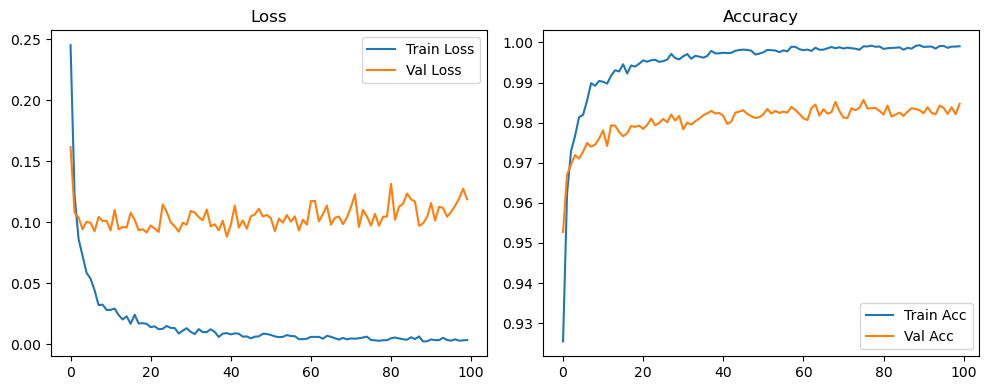

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2780, Acc: 0.9146 | Val Loss: 0.1635, Acc: 0.9513


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1650, Acc: 0.9492 | Val Loss: 0.1127, Acc: 0.9658


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1291, Acc: 0.9597 | Val Loss: 0.1093, Acc: 0.9663


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1088, Acc: 0.9661 | Val Loss: 0.0948, Acc: 0.9715


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0967, Acc: 0.9696 | Val Loss: 0.0961, Acc: 0.9718


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0835, Acc: 0.9736 | Val Loss: 0.0851, Acc: 0.9742


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0753, Acc: 0.9759 | Val Loss: 0.0830, Acc: 0.9759


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0656, Acc: 0.9783 | Val Loss: 0.0972, Acc: 0.9737


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0624, Acc: 0.9800 | Val Loss: 0.0949, Acc: 0.9733


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0589, Acc: 0.9815 | Val Loss: 0.0795, Acc: 0.9774


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9825 | Val Loss: 0.0755, Acc: 0.9778


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0504, Acc: 0.9839 | Val Loss: 0.0748, Acc: 0.9800


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9859 | Val Loss: 0.0827, Acc: 0.9782


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9844 | Val Loss: 0.0777, Acc: 0.9791


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9867 | Val Loss: 0.0746, Acc: 0.9798


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9869 | Val Loss: 0.0821, Acc: 0.9792


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9867 | Val Loss: 0.0757, Acc: 0.9803


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9880 | Val Loss: 0.0760, Acc: 0.9807


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9876 | Val Loss: 0.0736, Acc: 0.9808


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9894 | Val Loss: 0.0678, Acc: 0.9830


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.0749, Acc: 0.9811


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9891 | Val Loss: 0.0741, Acc: 0.9825


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9910 | Val Loss: 0.0777, Acc: 0.9812


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9902 | Val Loss: 0.0719, Acc: 0.9822


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9906 | Val Loss: 0.0770, Acc: 0.9821


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9906 | Val Loss: 0.0762, Acc: 0.9819


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9903 | Val Loss: 0.0814, Acc: 0.9811


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9915 | Val Loss: 0.0769, Acc: 0.9817


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.0775, Acc: 0.9822


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.0826, Acc: 0.9825


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9920 | Val Loss: 0.0842, Acc: 0.9814


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9919 | Val Loss: 0.0842, Acc: 0.9821


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.0784, Acc: 0.9823


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9935 | Val Loss: 0.0808, Acc: 0.9827


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.0843, Acc: 0.9822


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9929 | Val Loss: 0.0896, Acc: 0.9817


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9931 | Val Loss: 0.0794, Acc: 0.9827


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.0785, Acc: 0.9822


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.0795, Acc: 0.9828


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9937 | Val Loss: 0.0830, Acc: 0.9823


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.0865, Acc: 0.9831


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.0851, Acc: 0.9830


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0765, Acc: 0.9839


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.0832, Acc: 0.9827


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0856, Acc: 0.9829


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0853, Acc: 0.9828


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9941 | Val Loss: 0.0886, Acc: 0.9840


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.0912, Acc: 0.9832


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.0826, Acc: 0.9841


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.0886, Acc: 0.9826


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.0974, Acc: 0.9814


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.0875, Acc: 0.9841


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.0883, Acc: 0.9830


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9949 | Val Loss: 0.0889, Acc: 0.9823


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9952 | Val Loss: 0.0897, Acc: 0.9822


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.0847, Acc: 0.9834


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9959 | Val Loss: 0.0809, Acc: 0.9844


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.0874, Acc: 0.9838


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.0853, Acc: 0.9848


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9963 | Val Loss: 0.0956, Acc: 0.9832


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9962 | Val Loss: 0.0914, Acc: 0.9830


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.0886, Acc: 0.9842


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9963 | Val Loss: 0.0860, Acc: 0.9850


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.0883, Acc: 0.9833


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.0940, Acc: 0.9828


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.0855, Acc: 0.9848


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.0862, Acc: 0.9834


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0840, Acc: 0.9845


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0921, Acc: 0.9841


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.0903, Acc: 0.9832


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0810, Acc: 0.9848


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0844, Acc: 0.9845


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0892, Acc: 0.9840


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0895, Acc: 0.9853


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.0948, Acc: 0.9842


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.0943, Acc: 0.9832


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.0892, Acc: 0.9838


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.0886, Acc: 0.9841


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0869, Acc: 0.9844


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.0844, Acc: 0.9848


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.0994, Acc: 0.9833


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.0940, Acc: 0.9844


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1026, Acc: 0.9828


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.0891, Acc: 0.9852


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.0908, Acc: 0.9842


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9964 | Val Loss: 0.0921, Acc: 0.9843


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0911, Acc: 0.9843


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0924, Acc: 0.9846


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0881, Acc: 0.9852


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.0869, Acc: 0.9856


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0912, Acc: 0.9844


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.0957, Acc: 0.9847


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.0944, Acc: 0.9845


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.1007, Acc: 0.9843


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1047, Acc: 0.9830


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9977 | Val Loss: 0.0974, Acc: 0.9846


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1010, Acc: 0.9828


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0980, Acc: 0.9838


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1058, Acc: 0.9841


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1056, Acc: 0.9840


Final Test Loss: 0.0910 Accuracy: 0.9852


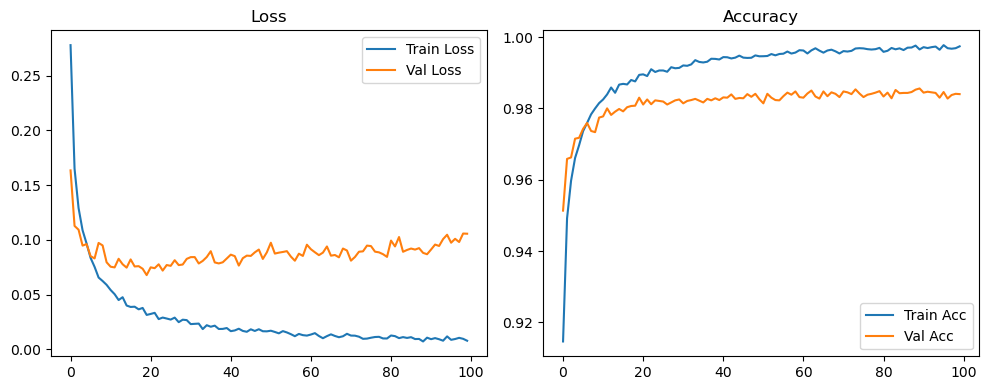

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2357, Acc: 0.9279 | Val Loss: 0.1552, Acc: 0.9545


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1075, Acc: 0.9661 | Val Loss: 0.0981, Acc: 0.9708


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0730, Acc: 0.9768 | Val Loss: 0.1061, Acc: 0.9714


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0578, Acc: 0.9818 | Val Loss: 0.0825, Acc: 0.9748


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9840 | Val Loss: 0.1236, Acc: 0.9642


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9878 | Val Loss: 0.1080, Acc: 0.9720


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9898 | Val Loss: 0.1011, Acc: 0.9738


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9912 | Val Loss: 0.1064, Acc: 0.9738


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.1026, Acc: 0.9744


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9931 | Val Loss: 0.0933, Acc: 0.9790


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9927 | Val Loss: 0.0899, Acc: 0.9789


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.1263, Acc: 0.9707


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.1038, Acc: 0.9777


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9955 | Val Loss: 0.1033, Acc: 0.9771


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9950 | Val Loss: 0.1078, Acc: 0.9776


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.1031, Acc: 0.9784


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9942 | Val Loss: 0.1072, Acc: 0.9762


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1005, Acc: 0.9801


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.1234, Acc: 0.9757


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1007, Acc: 0.9788


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.1222, Acc: 0.9783


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.0962, Acc: 0.9803


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1053, Acc: 0.9792


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1176, Acc: 0.9791


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1036, Acc: 0.9793


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.1036, Acc: 0.9788


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.1000, Acc: 0.9816


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.0971, Acc: 0.9804


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1039, Acc: 0.9808


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1335, Acc: 0.9766


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1108, Acc: 0.9818


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1037, Acc: 0.9809


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1069, Acc: 0.9802


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9974 | Val Loss: 0.1064, Acc: 0.9794


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1117, Acc: 0.9810


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.0947, Acc: 0.9802


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9980 | Val Loss: 0.0924, Acc: 0.9835


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0893, Acc: 0.9820


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.0951, Acc: 0.9823


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0952, Acc: 0.9828


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0974, Acc: 0.9832


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1053, Acc: 0.9816


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9972 | Val Loss: 0.0998, Acc: 0.9815


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9981 | Val Loss: 0.1222, Acc: 0.9781


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1153, Acc: 0.9807


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1088, Acc: 0.9819


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1010, Acc: 0.9825


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.0964, Acc: 0.9828


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0991, Acc: 0.9832


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1449, Acc: 0.9760


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0943, Acc: 0.9820


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 1.0000 | Val Loss: 0.0927, Acc: 0.9826


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0914, Acc: 0.9833


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0904, Acc: 0.9841


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0914, Acc: 0.9837


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0931, Acc: 0.9839


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0912, Acc: 0.9843


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0921, Acc: 0.9842


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0954, Acc: 0.9839


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0965, Acc: 0.9840


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0977, Acc: 0.9844


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1010, Acc: 0.9839


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0987, Acc: 0.9835


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1035, Acc: 0.9843


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9999 | Val Loss: 0.0984, Acc: 0.9845


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0998, Acc: 0.9842


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1032, Acc: 0.9848


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1079, Acc: 0.9839


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1089, Acc: 0.9835


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1152, Acc: 0.9826


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1148, Acc: 0.9839


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1339, Acc: 0.9818


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1226, Acc: 0.9820


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1211, Acc: 0.9837


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1130, Acc: 0.9827


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1152, Acc: 0.9832


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1101, Acc: 0.9839


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1133, Acc: 0.9834


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1124, Acc: 0.9838


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1141, Acc: 0.9838


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1153, Acc: 0.9842


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1161, Acc: 0.9832


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1154, Acc: 0.9841


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1166, Acc: 0.9835


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1173, Acc: 0.9838


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1174, Acc: 0.9843


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1148, Acc: 0.9842


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1151, Acc: 0.9841


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1169, Acc: 0.9840


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1160, Acc: 0.9843


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1168, Acc: 0.9843


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1169, Acc: 0.9841


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1175, Acc: 0.9842


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1159, Acc: 0.9836


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1146, Acc: 0.9841


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1151, Acc: 0.9846


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1199, Acc: 0.9838


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1236, Acc: 0.9834


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1222, Acc: 0.9841


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 1.0000 | Val Loss: 0.1134, Acc: 0.9849


Final Test Loss: 0.0881 Accuracy: 0.9861


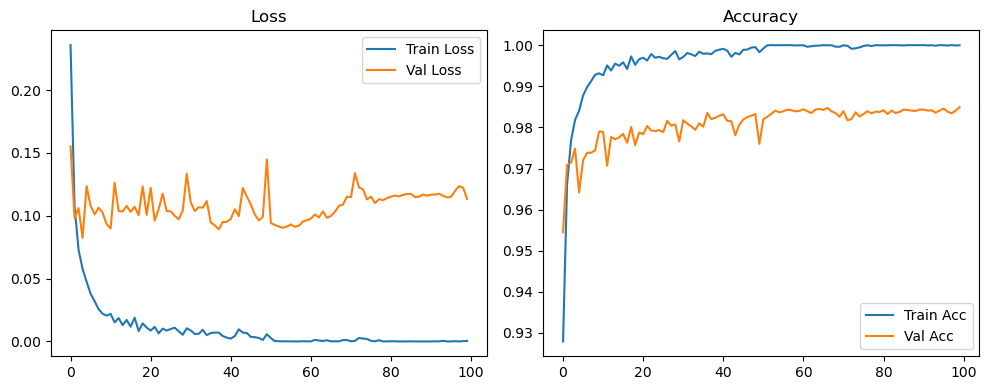

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2452, Acc: 0.9254 | Val Loss: 0.1617, Acc: 0.9527


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1224, Acc: 0.9623 | Val Loss: 0.1079, Acc: 0.9670


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.0864, Acc: 0.9729 | Val Loss: 0.1039, Acc: 0.9696


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0725, Acc: 0.9767 | Val Loss: 0.0942, Acc: 0.9719


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0586, Acc: 0.9814 | Val Loss: 0.1004, Acc: 0.9710


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0538, Acc: 0.9820 | Val Loss: 0.0996, Acc: 0.9728


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9855 | Val Loss: 0.0926, Acc: 0.9749


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9898 | Val Loss: 0.1044, Acc: 0.9740


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0325, Acc: 0.9892 | Val Loss: 0.1011, Acc: 0.9745


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9904 | Val Loss: 0.1012, Acc: 0.9760


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0282, Acc: 0.9902 | Val Loss: 0.0934, Acc: 0.9781


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9897 | Val Loss: 0.1101, Acc: 0.9742


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9917 | Val Loss: 0.0943, Acc: 0.9793


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.0962, Acc: 0.9792


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9928 | Val Loss: 0.0958, Acc: 0.9777


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9945 | Val Loss: 0.1079, Acc: 0.9766


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0243, Acc: 0.9922 | Val Loss: 0.1022, Acc: 0.9773


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.0935, Acc: 0.9792


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9940 | Val Loss: 0.0944, Acc: 0.9789


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9947 | Val Loss: 0.0916, Acc: 0.9792


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.0974, Acc: 0.9784


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9952 | Val Loss: 0.0948, Acc: 0.9794


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9956 | Val Loss: 0.0921, Acc: 0.9810


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.1146, Acc: 0.9793


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1087, Acc: 0.9799


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.0999, Acc: 0.9809


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9957 | Val Loss: 0.0968, Acc: 0.9801


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0923, Acc: 0.9820


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.0996, Acc: 0.9805


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.0981, Acc: 0.9817


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1093, Acc: 0.9783


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1080, Acc: 0.9800


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.1042, Acc: 0.9795


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1017, Acc: 0.9803


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1105, Acc: 0.9810


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.0967, Acc: 0.9818


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.0984, Acc: 0.9823


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.0935, Acc: 0.9829


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1013, Acc: 0.9822


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9973 | Val Loss: 0.0881, Acc: 0.9824


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0978, Acc: 0.9817


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1137, Acc: 0.9797


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9974 | Val Loss: 0.0956, Acc: 0.9802


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1015, Acc: 0.9825


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.0947, Acc: 0.9828


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1048, Acc: 0.9831


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1064, Acc: 0.9822


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1111, Acc: 0.9816


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1047, Acc: 0.9812


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1060, Acc: 0.9813


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0877, Acc: 0.9841


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0865, Acc: 0.9842


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.0863, Acc: 0.9844


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0913, Acc: 0.9843


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0880, Acc: 0.9848


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0888, Acc: 0.9843


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.0875, Acc: 0.9855


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0905, Acc: 0.9848


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.0919, Acc: 0.9851


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0939, Acc: 0.9838


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0915, Acc: 0.9839


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0939, Acc: 0.9843


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.0985, Acc: 0.9842


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1053, Acc: 0.9845


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1135, Acc: 0.9828


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1027, Acc: 0.9838


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1048, Acc: 0.9840


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1022, Acc: 0.9846


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1039, Acc: 0.9847


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1117, Acc: 0.9848


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1011, Acc: 0.9843


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1019, Acc: 0.9852


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1063, Acc: 0.9841


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1054, Acc: 0.9852


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1131, Acc: 0.9833


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1176, Acc: 0.9827


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1099, Acc: 0.9833


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1093, Acc: 0.9835


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1054, Acc: 0.9838


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1033, Acc: 0.9843


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1019, Acc: 0.9848


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1039, Acc: 0.9846


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1007, Acc: 0.9853


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1031, Acc: 0.9852


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1029, Acc: 0.9852


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1052, Acc: 0.9848


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1063, Acc: 0.9848


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1014, Acc: 0.9857


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1001, Acc: 0.9858


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1017, Acc: 0.9860


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1030, Acc: 0.9855


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1070, Acc: 0.9852


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1078, Acc: 0.9852


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1077, Acc: 0.9856


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1029, Acc: 0.9859


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1020, Acc: 0.9858


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1027, Acc: 0.9857


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1063, Acc: 0.9852


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1065, Acc: 0.9858


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1097, Acc: 0.9850


Final Test Loss: 0.1059 Accuracy: 0.9863


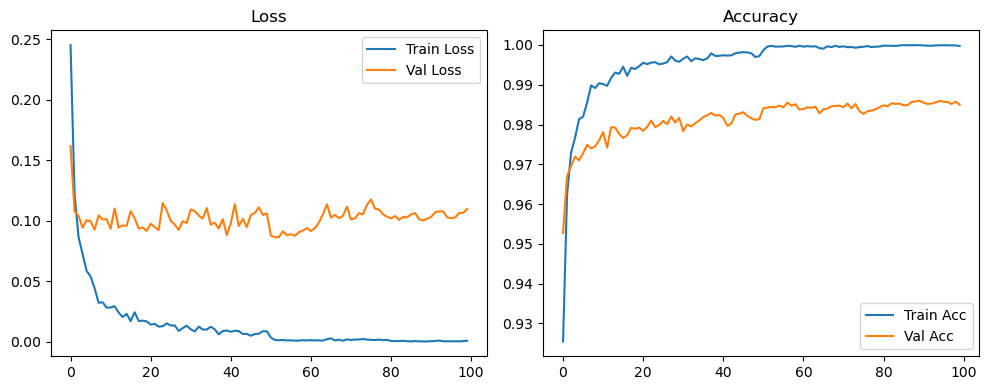

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.2780, Acc: 0.9146 | Val Loss: 0.1635, Acc: 0.9513


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1650, Acc: 0.9492 | Val Loss: 0.1127, Acc: 0.9658


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1291, Acc: 0.9597 | Val Loss: 0.1093, Acc: 0.9663


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1088, Acc: 0.9661 | Val Loss: 0.0948, Acc: 0.9715


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0967, Acc: 0.9696 | Val Loss: 0.0961, Acc: 0.9718


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0835, Acc: 0.9736 | Val Loss: 0.0851, Acc: 0.9742


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0753, Acc: 0.9759 | Val Loss: 0.0830, Acc: 0.9759


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0656, Acc: 0.9783 | Val Loss: 0.0972, Acc: 0.9737


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0624, Acc: 0.9800 | Val Loss: 0.0949, Acc: 0.9733


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0589, Acc: 0.9815 | Val Loss: 0.0795, Acc: 0.9774


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9825 | Val Loss: 0.0755, Acc: 0.9778


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0504, Acc: 0.9839 | Val Loss: 0.0748, Acc: 0.9800


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9859 | Val Loss: 0.0827, Acc: 0.9782


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0476, Acc: 0.9844 | Val Loss: 0.0777, Acc: 0.9791


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9867 | Val Loss: 0.0746, Acc: 0.9798


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9869 | Val Loss: 0.0821, Acc: 0.9792


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0389, Acc: 0.9867 | Val Loss: 0.0757, Acc: 0.9803


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9880 | Val Loss: 0.0760, Acc: 0.9807


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0378, Acc: 0.9876 | Val Loss: 0.0736, Acc: 0.9808


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0314, Acc: 0.9894 | Val Loss: 0.0678, Acc: 0.9830


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.0749, Acc: 0.9811


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9891 | Val Loss: 0.0741, Acc: 0.9825


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9910 | Val Loss: 0.0777, Acc: 0.9812


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0290, Acc: 0.9902 | Val Loss: 0.0719, Acc: 0.9822


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0281, Acc: 0.9906 | Val Loss: 0.0770, Acc: 0.9821


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9906 | Val Loss: 0.0762, Acc: 0.9819


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0289, Acc: 0.9903 | Val Loss: 0.0814, Acc: 0.9811


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0248, Acc: 0.9915 | Val Loss: 0.0769, Acc: 0.9817


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.0775, Acc: 0.9822


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9914 | Val Loss: 0.0826, Acc: 0.9825


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9920 | Val Loss: 0.0842, Acc: 0.9814


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9919 | Val Loss: 0.0842, Acc: 0.9821


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0235, Acc: 0.9923 | Val Loss: 0.0784, Acc: 0.9823


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9935 | Val Loss: 0.0808, Acc: 0.9827


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9930 | Val Loss: 0.0843, Acc: 0.9822


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9929 | Val Loss: 0.0896, Acc: 0.9817


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9931 | Val Loss: 0.0794, Acc: 0.9827


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.0785, Acc: 0.9822


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.0795, Acc: 0.9828


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9937 | Val Loss: 0.0830, Acc: 0.9823


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.0865, Acc: 0.9831


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.0851, Acc: 0.9830


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0765, Acc: 0.9839


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0168, Acc: 0.9942 | Val Loss: 0.0832, Acc: 0.9827


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0856, Acc: 0.9829


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9942 | Val Loss: 0.0853, Acc: 0.9828


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9941 | Val Loss: 0.0886, Acc: 0.9840


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0183, Acc: 0.9942 | Val Loss: 0.0912, Acc: 0.9832


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0165, Acc: 0.9949 | Val Loss: 0.0826, Acc: 0.9841


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.0886, Acc: 0.9826


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0817, Acc: 0.9847


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.0809, Acc: 0.9847


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.0795, Acc: 0.9848


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.0803, Acc: 0.9848


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.0785, Acc: 0.9838


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0800, Acc: 0.9856


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.0786, Acc: 0.9848


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.0799, Acc: 0.9855


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0820, Acc: 0.9854


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.0826, Acc: 0.9855


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0848, Acc: 0.9838


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0867, Acc: 0.9846


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0859, Acc: 0.9857


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0868, Acc: 0.9847


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0871, Acc: 0.9844


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9984 | Val Loss: 0.0869, Acc: 0.9850


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.0824, Acc: 0.9851


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.0846, Acc: 0.9862


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9980 | Val Loss: 0.0858, Acc: 0.9852


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0860, Acc: 0.9853


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0844, Acc: 0.9853


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0876, Acc: 0.9850


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.0897, Acc: 0.9860


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.0901, Acc: 0.9852


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0908, Acc: 0.9855


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9982 | Val Loss: 0.0874, Acc: 0.9862


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.0843, Acc: 0.9858


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.0873, Acc: 0.9858


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0875, Acc: 0.9861


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.0869, Acc: 0.9858


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.0858, Acc: 0.9859


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0842, Acc: 0.9853


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.0830, Acc: 0.9864


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0847, Acc: 0.9858


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0863, Acc: 0.9859


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.0844, Acc: 0.9863


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.0847, Acc: 0.9859


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0842, Acc: 0.9858


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0867, Acc: 0.9857


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.0882, Acc: 0.9855


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.0885, Acc: 0.9862


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.0906, Acc: 0.9853


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.0890, Acc: 0.9854


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.0896, Acc: 0.9859


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.0902, Acc: 0.9862


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.0897, Acc: 0.9855


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0928, Acc: 0.9861


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.0906, Acc: 0.9857


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.0925, Acc: 0.9857


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0908, Acc: 0.9860


Final Test Loss: 0.0882 Accuracy: 0.9867


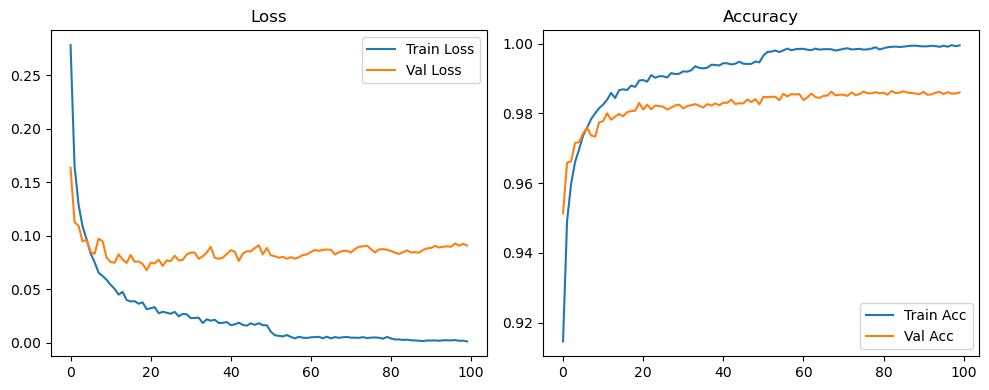

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.1997, Acc: 0.9364 | Val Loss: 0.1330, Acc: 0.9603


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.0975, Acc: 0.9691 | Val Loss: 0.0940, Acc: 0.9706


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0669, Acc: 0.9789 | Val Loss: 0.0941, Acc: 0.9727


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0538, Acc: 0.9825 | Val Loss: 0.0863, Acc: 0.9737


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0431, Acc: 0.9859 | Val Loss: 0.0922, Acc: 0.9732


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0356, Acc: 0.9879 | Val Loss: 0.1014, Acc: 0.9722


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.1035, Acc: 0.9742


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9921 | Val Loss: 0.1203, Acc: 0.9692


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0258, Acc: 0.9912 | Val Loss: 0.0985, Acc: 0.9753


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0184, Acc: 0.9939 | Val Loss: 0.0897, Acc: 0.9780


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9944 | Val Loss: 0.0933, Acc: 0.9786


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.1161, Acc: 0.9732


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9933 | Val Loss: 0.0968, Acc: 0.9768


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9931 | Val Loss: 0.0915, Acc: 0.9778


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.0854, Acc: 0.9800


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.0923, Acc: 0.9815


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.1219, Acc: 0.9760


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1251, Acc: 0.9754


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0960, Acc: 0.9806


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.0929, Acc: 0.9803


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.0952, Acc: 0.9802


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9961 | Val Loss: 0.1133, Acc: 0.9772


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.0988, Acc: 0.9792


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.0936, Acc: 0.9818


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1273, Acc: 0.9756


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.1015, Acc: 0.9796


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.0952, Acc: 0.9800


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0908, Acc: 0.9830


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.0917, Acc: 0.9839


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0947, Acc: 0.9838


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.0967, Acc: 0.9826


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9958 | Val Loss: 0.1257, Acc: 0.9764


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9957 | Val Loss: 0.1171, Acc: 0.9762


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1037, Acc: 0.9797


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.0925, Acc: 0.9826


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0941, Acc: 0.9822


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.0890, Acc: 0.9848


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1058, Acc: 0.9810


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9964 | Val Loss: 0.1235, Acc: 0.9772


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.0969, Acc: 0.9807


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.0936, Acc: 0.9823


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1013, Acc: 0.9812


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1017, Acc: 0.9826


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1102, Acc: 0.9796


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0979, Acc: 0.9827


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1067, Acc: 0.9811


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1033, Acc: 0.9817


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1030, Acc: 0.9838


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1150, Acc: 0.9808


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1089, Acc: 0.9811


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1032, Acc: 0.9817


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9982 | Val Loss: 0.1095, Acc: 0.9818


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0999, Acc: 0.9835


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1011, Acc: 0.9832


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.0981, Acc: 0.9839


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0938, Acc: 0.9846


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1005, Acc: 0.9834


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9993 | Val Loss: 0.1285, Acc: 0.9798


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9960 | Val Loss: 0.1130, Acc: 0.9801


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.1145, Acc: 0.9803


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1134, Acc: 0.9806


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0993, Acc: 0.9820


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1039, Acc: 0.9840


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0968, Acc: 0.9842


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0944, Acc: 0.9844


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0908, Acc: 0.9855


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.0953, Acc: 0.9842


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9970 | Val Loss: 0.1078, Acc: 0.9802


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0993, Acc: 0.9818


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1155, Acc: 0.9817


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1010, Acc: 0.9834


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1176, Acc: 0.9821


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1034, Acc: 0.9821


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1012, Acc: 0.9836


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1029, Acc: 0.9835


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1107, Acc: 0.9815


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1063, Acc: 0.9820


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1084, Acc: 0.9818


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1055, Acc: 0.9829


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1013, Acc: 0.9835


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1015, Acc: 0.9832


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1032, Acc: 0.9831


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1031, Acc: 0.9838


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1048, Acc: 0.9838


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1069, Acc: 0.9823


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1135, Acc: 0.9823


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1339, Acc: 0.9815


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9982 | Val Loss: 0.1152, Acc: 0.9804


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1047, Acc: 0.9828


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.0995, Acc: 0.9839


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.0920, Acc: 0.9849


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.0968, Acc: 0.9855


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1057, Acc: 0.9838


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1181, Acc: 0.9822


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1329, Acc: 0.9798


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1382, Acc: 0.9788


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1106, Acc: 0.9822


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1051, Acc: 0.9831


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.0920, Acc: 0.9848


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0983, Acc: 0.9843


Final Test Loss: 0.0912 Accuracy: 0.9858


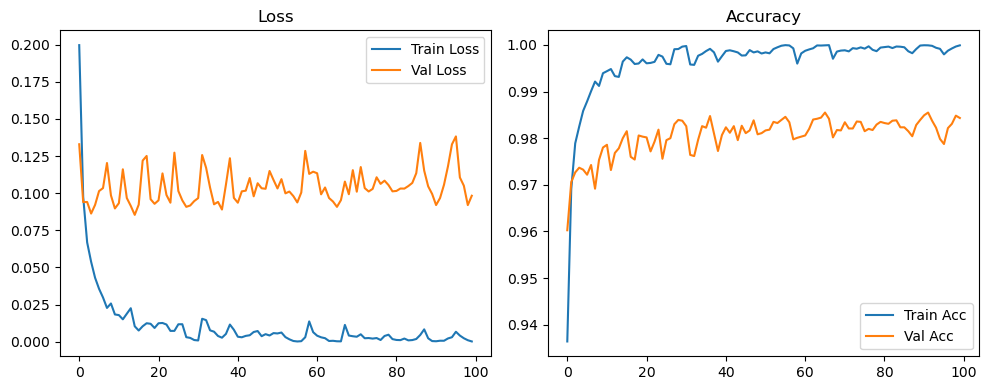

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2106, Acc: 0.9344 | Val Loss: 0.1455, Acc: 0.9566


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1100, Acc: 0.9650 | Val Loss: 0.0985, Acc: 0.9682


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0785, Acc: 0.9758 | Val Loss: 0.0971, Acc: 0.9705


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0653, Acc: 0.9787 | Val Loss: 0.0872, Acc: 0.9737


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0523, Acc: 0.9833 | Val Loss: 0.0865, Acc: 0.9756


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0500, Acc: 0.9836 | Val Loss: 0.0869, Acc: 0.9766


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0431, Acc: 0.9851 | Val Loss: 0.0934, Acc: 0.9742


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9884 | Val Loss: 0.1006, Acc: 0.9735


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9890 | Val Loss: 0.0970, Acc: 0.9754


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0294, Acc: 0.9900 | Val Loss: 0.0930, Acc: 0.9779


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0256, Acc: 0.9915 | Val Loss: 0.0887, Acc: 0.9771


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9923 | Val Loss: 0.0948, Acc: 0.9770


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.0834, Acc: 0.9804


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9921 | Val Loss: 0.1037, Acc: 0.9759


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9930 | Val Loss: 0.0905, Acc: 0.9784


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9943 | Val Loss: 0.0948, Acc: 0.9782


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.0953, Acc: 0.9788


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9939 | Val Loss: 0.0984, Acc: 0.9786


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.0926, Acc: 0.9811


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.0937, Acc: 0.9802


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.0939, Acc: 0.9798


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.0956, Acc: 0.9808


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.1046, Acc: 0.9798


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9947 | Val Loss: 0.0940, Acc: 0.9804


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1035, Acc: 0.9773


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9957 | Val Loss: 0.0962, Acc: 0.9788


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.0945, Acc: 0.9802


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.0968, Acc: 0.9800


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1054, Acc: 0.9794


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.0952, Acc: 0.9808


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1072, Acc: 0.9802


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.0949, Acc: 0.9812


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9975 | Val Loss: 0.1102, Acc: 0.9805


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9965 | Val Loss: 0.1023, Acc: 0.9810


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0991, Acc: 0.9811


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1044, Acc: 0.9799


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1088, Acc: 0.9818


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0928, Acc: 0.9839


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9969 | Val Loss: 0.1073, Acc: 0.9790


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.0979, Acc: 0.9825


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1035, Acc: 0.9809


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.0961, Acc: 0.9821


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1076, Acc: 0.9788


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1043, Acc: 0.9818


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0978, Acc: 0.9821


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1024, Acc: 0.9821


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1080, Acc: 0.9807


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.0943, Acc: 0.9827


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0947, Acc: 0.9837


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1210, Acc: 0.9801


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1018, Acc: 0.9823


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0915, Acc: 0.9839


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.0981, Acc: 0.9830


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1037, Acc: 0.9835


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1020, Acc: 0.9844


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1005, Acc: 0.9839


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1018, Acc: 0.9839


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.0994, Acc: 0.9844


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1068, Acc: 0.9829


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1025, Acc: 0.9832


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1009, Acc: 0.9828


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9983 | Val Loss: 0.1164, Acc: 0.9815


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1005, Acc: 0.9822


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.0979, Acc: 0.9830


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1024, Acc: 0.9830


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1003, Acc: 0.9834


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1050, Acc: 0.9835


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1077, Acc: 0.9832


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0919, Acc: 0.9842


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1044, Acc: 0.9817


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1031, Acc: 0.9837


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1013, Acc: 0.9835


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1043, Acc: 0.9828


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1047, Acc: 0.9821


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1078, Acc: 0.9834


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1013, Acc: 0.9834


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1130, Acc: 0.9826


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.0971, Acc: 0.9838


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1162, Acc: 0.9826


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1144, Acc: 0.9839


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1449, Acc: 0.9797


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1149, Acc: 0.9827


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1152, Acc: 0.9818


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1189, Acc: 0.9826


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1087, Acc: 0.9836


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1025, Acc: 0.9835


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1240, Acc: 0.9822


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1064, Acc: 0.9839


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1184, Acc: 0.9828


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1056, Acc: 0.9838


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1037, Acc: 0.9842


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1027, Acc: 0.9837


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1139, Acc: 0.9817


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1172, Acc: 0.9817


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9985 | Val Loss: 0.1107, Acc: 0.9828


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1043, Acc: 0.9852


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1007, Acc: 0.9850


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.0976, Acc: 0.9849


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1011, Acc: 0.9850


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1062, Acc: 0.9833


Final Test Loss: 0.0963 Accuracy: 0.9846


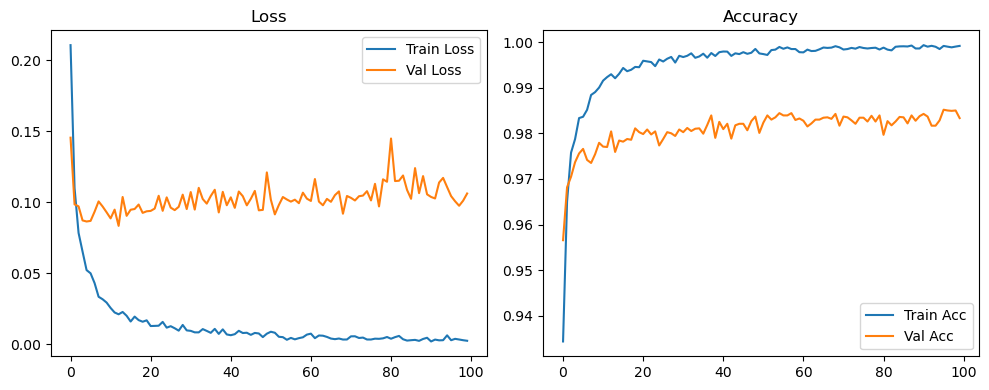

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.2661, Acc: 0.9176 | Val Loss: 0.1443, Acc: 0.9564


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1528, Acc: 0.9529 | Val Loss: 0.1031, Acc: 0.9677


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1189, Acc: 0.9632 | Val Loss: 0.1063, Acc: 0.9665


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1069, Acc: 0.9664 | Val Loss: 0.0895, Acc: 0.9727


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0935, Acc: 0.9708 | Val Loss: 0.0858, Acc: 0.9732


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0822, Acc: 0.9731 | Val Loss: 0.0873, Acc: 0.9751


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0750, Acc: 0.9761 | Val Loss: 0.0914, Acc: 0.9725


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0659, Acc: 0.9784 | Val Loss: 0.0817, Acc: 0.9758


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0618, Acc: 0.9797 | Val Loss: 0.0882, Acc: 0.9738


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0582, Acc: 0.9805 | Val Loss: 0.0765, Acc: 0.9782


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0541, Acc: 0.9821 | Val Loss: 0.0809, Acc: 0.9780


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0503, Acc: 0.9829 | Val Loss: 0.0843, Acc: 0.9770


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0484, Acc: 0.9836 | Val Loss: 0.0833, Acc: 0.9769


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0463, Acc: 0.9849 | Val Loss: 0.0691, Acc: 0.9814


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0421, Acc: 0.9859 | Val Loss: 0.0718, Acc: 0.9809


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0408, Acc: 0.9864 | Val Loss: 0.0762, Acc: 0.9791


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0389, Acc: 0.9873 | Val Loss: 0.0716, Acc: 0.9800


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9878 | Val Loss: 0.0730, Acc: 0.9797


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9881 | Val Loss: 0.0730, Acc: 0.9794


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9883 | Val Loss: 0.0780, Acc: 0.9798


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0320, Acc: 0.9893 | Val Loss: 0.0763, Acc: 0.9788


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9896 | Val Loss: 0.0745, Acc: 0.9799


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0282, Acc: 0.9902 | Val Loss: 0.0769, Acc: 0.9807


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9905 | Val Loss: 0.0837, Acc: 0.9804


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.0779, Acc: 0.9808


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9912 | Val Loss: 0.0749, Acc: 0.9812


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9910 | Val Loss: 0.0833, Acc: 0.9801


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9908 | Val Loss: 0.0876, Acc: 0.9812


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9907 | Val Loss: 0.0836, Acc: 0.9806


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9921 | Val Loss: 0.0733, Acc: 0.9822


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0224, Acc: 0.9923 | Val Loss: 0.0811, Acc: 0.9820


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9922 | Val Loss: 0.0757, Acc: 0.9814


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9919 | Val Loss: 0.0754, Acc: 0.9820


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9931 | Val Loss: 0.0783, Acc: 0.9828


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9937 | Val Loss: 0.0773, Acc: 0.9832


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9930 | Val Loss: 0.0757, Acc: 0.9831


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9933 | Val Loss: 0.0769, Acc: 0.9820


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9933 | Val Loss: 0.0775, Acc: 0.9822


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9935 | Val Loss: 0.0773, Acc: 0.9817


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9936 | Val Loss: 0.0787, Acc: 0.9811


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.0787, Acc: 0.9823


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.0810, Acc: 0.9821


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.0782, Acc: 0.9836


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.0813, Acc: 0.9832


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.0878, Acc: 0.9820


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.0827, Acc: 0.9823


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.0807, Acc: 0.9824


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9946 | Val Loss: 0.0739, Acc: 0.9843


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0774, Acc: 0.9834


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.0780, Acc: 0.9831


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.0841, Acc: 0.9830


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.0835, Acc: 0.9819


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.0798, Acc: 0.9823


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0149, Acc: 0.9951 | Val Loss: 0.0873, Acc: 0.9822


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.0836, Acc: 0.9827


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.0844, Acc: 0.9820


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9954 | Val Loss: 0.0847, Acc: 0.9823


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0847, Acc: 0.9834


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.0786, Acc: 0.9836


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.0813, Acc: 0.9838


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0775, Acc: 0.9832


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.0818, Acc: 0.9842


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.0874, Acc: 0.9823


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.0871, Acc: 0.9827


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.0888, Acc: 0.9834


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.0823, Acc: 0.9840


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.0853, Acc: 0.9827


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.0815, Acc: 0.9845


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0857, Acc: 0.9828


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9955 | Val Loss: 0.0877, Acc: 0.9819


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9961 | Val Loss: 0.0858, Acc: 0.9842


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9964 | Val Loss: 0.0873, Acc: 0.9833


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.0840, Acc: 0.9825


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.0869, Acc: 0.9838


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.0877, Acc: 0.9834


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0876, Acc: 0.9842


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9967 | Val Loss: 0.0877, Acc: 0.9837


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.0838, Acc: 0.9842


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0784, Acc: 0.9846


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.0875, Acc: 0.9841


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.0894, Acc: 0.9852


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0871, Acc: 0.9833


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.0917, Acc: 0.9835


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.0925, Acc: 0.9841


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0916, Acc: 0.9836


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9963 | Val Loss: 0.0923, Acc: 0.9828


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0924, Acc: 0.9825


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9971 | Val Loss: 0.0891, Acc: 0.9831


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0862, Acc: 0.9845


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.0856, Acc: 0.9846


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0964, Acc: 0.9840


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.0906, Acc: 0.9840


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0920, Acc: 0.9827


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0894, Acc: 0.9824


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.0972, Acc: 0.9832


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.0975, Acc: 0.9835


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0947, Acc: 0.9838


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9973 | Val Loss: 0.0906, Acc: 0.9846


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0935, Acc: 0.9838


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.0843, Acc: 0.9847


Final Test Loss: 0.0800 Accuracy: 0.9864


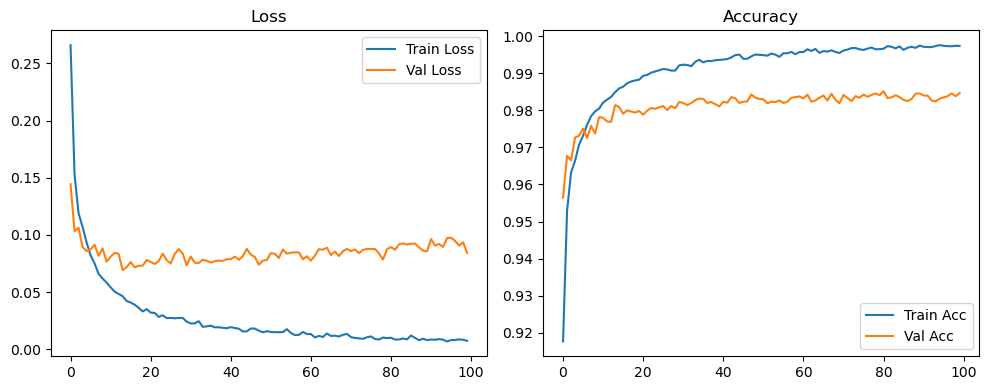

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.1877, Acc: 0.9412 | Val Loss: 0.1178, Acc: 0.9647


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.0875, Acc: 0.9719 | Val Loss: 0.0889, Acc: 0.9718


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0588, Acc: 0.9810 | Val Loss: 0.0847, Acc: 0.9761


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9848 | Val Loss: 0.0789, Acc: 0.9761


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9882 | Val Loss: 0.1018, Acc: 0.9712


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0311, Acc: 0.9896 | Val Loss: 0.0967, Acc: 0.9727


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9903 | Val Loss: 0.0956, Acc: 0.9755


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0206, Acc: 0.9929 | Val Loss: 0.0922, Acc: 0.9768


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.0806, Acc: 0.9795


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0148, Acc: 0.9951 | Val Loss: 0.0844, Acc: 0.9798


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.0903, Acc: 0.9787


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.1085, Acc: 0.9756


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9940 | Val Loss: 0.1041, Acc: 0.9748


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.0887, Acc: 0.9800


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9964 | Val Loss: 0.0961, Acc: 0.9788


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0953, Acc: 0.9790


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9972 | Val Loss: 0.0923, Acc: 0.9798


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0149, Acc: 0.9948 | Val Loss: 0.0991, Acc: 0.9781


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.0940, Acc: 0.9789


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1027, Acc: 0.9775


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1064, Acc: 0.9788


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0901, Acc: 0.9811


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.0890, Acc: 0.9819


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0913, Acc: 0.9818


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1102, Acc: 0.9775


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9956 | Val Loss: 0.1141, Acc: 0.9762


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1025, Acc: 0.9783


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0935, Acc: 0.9809


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.0983, Acc: 0.9807


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.0905, Acc: 0.9830


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.0921, Acc: 0.9826


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.0977, Acc: 0.9805


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.0943, Acc: 0.9814


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9974 | Val Loss: 0.1072, Acc: 0.9802


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.1108, Acc: 0.9786


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.1025, Acc: 0.9802


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.0955, Acc: 0.9807


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1017, Acc: 0.9813


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.0996, Acc: 0.9811


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1096, Acc: 0.9795


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1160, Acc: 0.9787


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1196, Acc: 0.9779


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.0997, Acc: 0.9818


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1145, Acc: 0.9794


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1094, Acc: 0.9808


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1039, Acc: 0.9808


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0956, Acc: 0.9832


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1000, Acc: 0.9813


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9979 | Val Loss: 0.1227, Acc: 0.9780


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9972 | Val Loss: 0.1101, Acc: 0.9786


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1235, Acc: 0.9772


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.0843, Acc: 0.9840


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.0936, Acc: 0.9831


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0932, Acc: 0.9828


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0848, Acc: 0.9844


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0947, Acc: 0.9837


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1024, Acc: 0.9825


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0967, Acc: 0.9830


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1314, Acc: 0.9772


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9957 | Val Loss: 0.1169, Acc: 0.9794


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.0885, Acc: 0.9839


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.0976, Acc: 0.9828


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.0895, Acc: 0.9836


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.0799, Acc: 0.9849


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.0831, Acc: 0.9848


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1080, Acc: 0.9819


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0991, Acc: 0.9832


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.0987, Acc: 0.9828


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1041, Acc: 0.9809


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1125, Acc: 0.9800


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1066, Acc: 0.9810


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1081, Acc: 0.9818


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.0991, Acc: 0.9825


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1130, Acc: 0.9824


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1175, Acc: 0.9815


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1145, Acc: 0.9815


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1075, Acc: 0.9831


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0967, Acc: 0.9827


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1223, Acc: 0.9799


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1090, Acc: 0.9817


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.0987, Acc: 0.9823


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1081, Acc: 0.9820


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1195, Acc: 0.9812


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1110, Acc: 0.9818


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1040, Acc: 0.9830


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.0943, Acc: 0.9845


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.0966, Acc: 0.9841


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1062, Acc: 0.9821


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1259, Acc: 0.9799


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1277, Acc: 0.9800


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1197, Acc: 0.9822


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1086, Acc: 0.9828


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.1078, Acc: 0.9830


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1182, Acc: 0.9826


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.1197, Acc: 0.9822


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1066, Acc: 0.9838


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1090, Acc: 0.9828


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1013, Acc: 0.9840


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1033, Acc: 0.9841


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0945, Acc: 0.9852


Final Test Loss: 0.0932 Accuracy: 0.9851


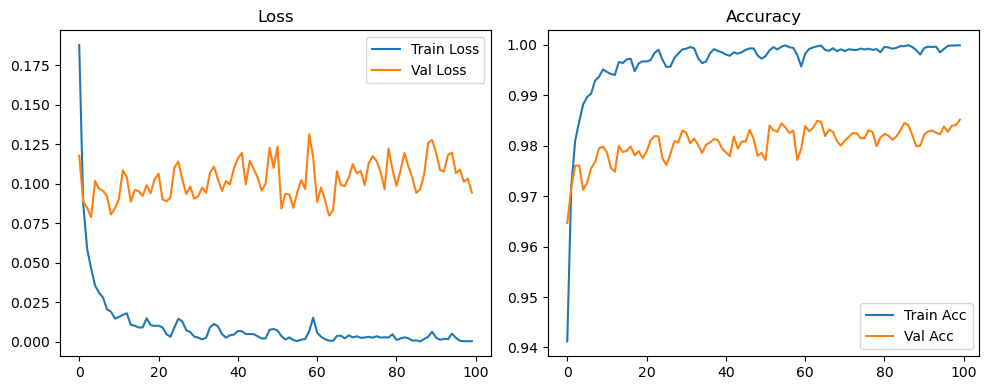

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2068, Acc: 0.9358 | Val Loss: 0.1201, Acc: 0.9634


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1004, Acc: 0.9689 | Val Loss: 0.0930, Acc: 0.9691


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0728, Acc: 0.9774 | Val Loss: 0.0925, Acc: 0.9709


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0610, Acc: 0.9798 | Val Loss: 0.0830, Acc: 0.9745


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0488, Acc: 0.9842 | Val Loss: 0.0880, Acc: 0.9737


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0446, Acc: 0.9848 | Val Loss: 0.0872, Acc: 0.9762


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0377, Acc: 0.9875 | Val Loss: 0.0912, Acc: 0.9731


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9891 | Val Loss: 0.0939, Acc: 0.9733


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0292, Acc: 0.9903 | Val Loss: 0.0843, Acc: 0.9772


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9919 | Val Loss: 0.0813, Acc: 0.9782


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9926 | Val Loss: 0.0947, Acc: 0.9772


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.0911, Acc: 0.9772


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9931 | Val Loss: 0.0833, Acc: 0.9799


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9925 | Val Loss: 0.0773, Acc: 0.9802


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0181, Acc: 0.9936 | Val Loss: 0.0927, Acc: 0.9774


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9936 | Val Loss: 0.0932, Acc: 0.9778


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9936 | Val Loss: 0.0890, Acc: 0.9777


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9951 | Val Loss: 0.0905, Acc: 0.9778


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.0856, Acc: 0.9804


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.0869, Acc: 0.9792


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.0928, Acc: 0.9793


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0927, Acc: 0.9791


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.0942, Acc: 0.9798


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0985, Acc: 0.9788


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0126, Acc: 0.9956 | Val Loss: 0.0900, Acc: 0.9793


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.0846, Acc: 0.9800


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.0870, Acc: 0.9812


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.0792, Acc: 0.9813


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.0965, Acc: 0.9795


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.0976, Acc: 0.9811


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.0885, Acc: 0.9815


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9970 | Val Loss: 0.0919, Acc: 0.9813


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0925, Acc: 0.9804


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.0985, Acc: 0.9806


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.0930, Acc: 0.9812


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.0961, Acc: 0.9802


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.0932, Acc: 0.9812


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.0902, Acc: 0.9808


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9967 | Val Loss: 0.0958, Acc: 0.9795


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0946, Acc: 0.9819


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0962, Acc: 0.9815


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.0934, Acc: 0.9812


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.0982, Acc: 0.9824


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.0904, Acc: 0.9822


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0990, Acc: 0.9808


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0995, Acc: 0.9815


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0974, Acc: 0.9811


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 0.0937, Acc: 0.9828


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0895, Acc: 0.9838


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0925, Acc: 0.9834


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1026, Acc: 0.9815


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1247, Acc: 0.9795


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1001, Acc: 0.9831


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1065, Acc: 0.9819


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0952, Acc: 0.9833


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1026, Acc: 0.9820


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1034, Acc: 0.9824


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.0999, Acc: 0.9836


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1033, Acc: 0.9833


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9978 | Val Loss: 0.0989, Acc: 0.9837


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1083, Acc: 0.9812


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1163, Acc: 0.9814


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1035, Acc: 0.9829


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1079, Acc: 0.9822


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1031, Acc: 0.9819


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.0961, Acc: 0.9828


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1166, Acc: 0.9814


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1014, Acc: 0.9843


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1093, Acc: 0.9819


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9988 | Val Loss: 0.1037, Acc: 0.9832


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.0989, Acc: 0.9832


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1010, Acc: 0.9833


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1111, Acc: 0.9823


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1105, Acc: 0.9810


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1029, Acc: 0.9828


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.0939, Acc: 0.9829


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9988 | Val Loss: 0.0993, Acc: 0.9837


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.0934, Acc: 0.9837


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.0926, Acc: 0.9843


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1108, Acc: 0.9824


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1133, Acc: 0.9812


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9981 | Val Loss: 0.1103, Acc: 0.9827


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1011, Acc: 0.9821


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.0979, Acc: 0.9848


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.0962, Acc: 0.9834


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.0989, Acc: 0.9828


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1188, Acc: 0.9817


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1049, Acc: 0.9832


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1239, Acc: 0.9815


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.1021, Acc: 0.9832


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1019, Acc: 0.9831


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1045, Acc: 0.9825


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.0992, Acc: 0.9818


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1060, Acc: 0.9821


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1021, Acc: 0.9828


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0955, Acc: 0.9844


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1007, Acc: 0.9840


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9990 | Val Loss: 0.0926, Acc: 0.9838


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1045, Acc: 0.9824


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.0989, Acc: 0.9843


Final Test Loss: 0.0938 Accuracy: 0.9851


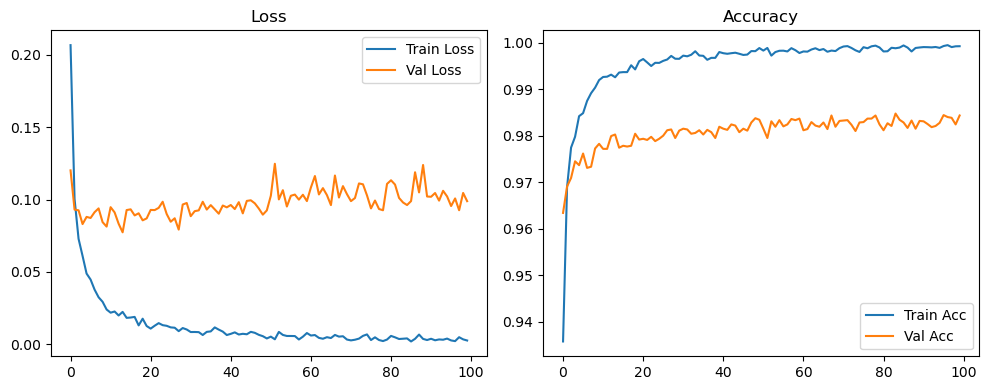

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.2779, Acc: 0.9131 | Val Loss: 0.1428, Acc: 0.9563


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1479, Acc: 0.9534 | Val Loss: 0.1057, Acc: 0.9661


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1152, Acc: 0.9636 | Val Loss: 0.1054, Acc: 0.9667


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1014, Acc: 0.9679 | Val Loss: 0.0847, Acc: 0.9729


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0893, Acc: 0.9722 | Val Loss: 0.0906, Acc: 0.9707


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0799, Acc: 0.9742 | Val Loss: 0.0829, Acc: 0.9752


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0751, Acc: 0.9762 | Val Loss: 0.0870, Acc: 0.9727


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0627, Acc: 0.9798 | Val Loss: 0.0809, Acc: 0.9760


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0593, Acc: 0.9802 | Val Loss: 0.0818, Acc: 0.9758


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0570, Acc: 0.9812 | Val Loss: 0.0756, Acc: 0.9773


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0552, Acc: 0.9813 | Val Loss: 0.0780, Acc: 0.9775


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0524, Acc: 0.9822 | Val Loss: 0.0812, Acc: 0.9769


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0491, Acc: 0.9836 | Val Loss: 0.0732, Acc: 0.9792


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0454, Acc: 0.9847 | Val Loss: 0.0729, Acc: 0.9794


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0439, Acc: 0.9856 | Val Loss: 0.0737, Acc: 0.9793


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0378, Acc: 0.9876 | Val Loss: 0.0763, Acc: 0.9780


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9874 | Val Loss: 0.0836, Acc: 0.9775


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9862 | Val Loss: 0.0691, Acc: 0.9805


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9887 | Val Loss: 0.0711, Acc: 0.9793


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9888 | Val Loss: 0.0668, Acc: 0.9811


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9890 | Val Loss: 0.0729, Acc: 0.9812


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9889 | Val Loss: 0.0689, Acc: 0.9808


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9904 | Val Loss: 0.0734, Acc: 0.9808


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9894 | Val Loss: 0.0739, Acc: 0.9814


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9899 | Val Loss: 0.0756, Acc: 0.9792


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9910 | Val Loss: 0.0682, Acc: 0.9820


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0274, Acc: 0.9908 | Val Loss: 0.0767, Acc: 0.9802


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0255, Acc: 0.9910 | Val Loss: 0.0786, Acc: 0.9815


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0251, Acc: 0.9916 | Val Loss: 0.0768, Acc: 0.9815


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9907 | Val Loss: 0.0751, Acc: 0.9811


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0225, Acc: 0.9920 | Val Loss: 0.0762, Acc: 0.9814


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0221, Acc: 0.9922 | Val Loss: 0.0733, Acc: 0.9819


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9920 | Val Loss: 0.0726, Acc: 0.9815


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9924 | Val Loss: 0.0754, Acc: 0.9816


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9922 | Val Loss: 0.0780, Acc: 0.9813


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.0746, Acc: 0.9819


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.0821, Acc: 0.9806


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9928 | Val Loss: 0.0728, Acc: 0.9822


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0194, Acc: 0.9934 | Val Loss: 0.0744, Acc: 0.9833


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9940 | Val Loss: 0.0757, Acc: 0.9813


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9938 | Val Loss: 0.0815, Acc: 0.9818


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9935 | Val Loss: 0.0762, Acc: 0.9822


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9943 | Val Loss: 0.0692, Acc: 0.9840


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.0785, Acc: 0.9829


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0155, Acc: 0.9948 | Val Loss: 0.0754, Acc: 0.9824


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9940 | Val Loss: 0.0734, Acc: 0.9836


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.0720, Acc: 0.9837


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.0763, Acc: 0.9831


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.0766, Acc: 0.9836


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9949 | Val Loss: 0.0827, Acc: 0.9823


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.0780, Acc: 0.9820


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.0823, Acc: 0.9820


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.0846, Acc: 0.9832


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.0794, Acc: 0.9831


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 0.0794, Acc: 0.9836


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9953 | Val Loss: 0.0768, Acc: 0.9837


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9952 | Val Loss: 0.0826, Acc: 0.9825


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0744, Acc: 0.9841


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.0783, Acc: 0.9834


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.0783, Acc: 0.9842


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9954 | Val Loss: 0.0849, Acc: 0.9818


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9965 | Val Loss: 0.0877, Acc: 0.9828


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.0819, Acc: 0.9828


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0844, Acc: 0.9823


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0767, Acc: 0.9839


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.0742, Acc: 0.9839


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9957 | Val Loss: 0.0831, Acc: 0.9833


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9958 | Val Loss: 0.0785, Acc: 0.9837


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0780, Acc: 0.9834


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0818, Acc: 0.9843


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0882, Acc: 0.9831


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.0804, Acc: 0.9829


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.0833, Acc: 0.9824


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.0743, Acc: 0.9846


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.0816, Acc: 0.9830


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.0766, Acc: 0.9836


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.0774, Acc: 0.9838


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.0720, Acc: 0.9849


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0828, Acc: 0.9845


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.0833, Acc: 0.9835


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.0767, Acc: 0.9845


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.0822, Acc: 0.9842


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.0775, Acc: 0.9843


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0787, Acc: 0.9846


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0767, Acc: 0.9838


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0852, Acc: 0.9830


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0852, Acc: 0.9840


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.0803, Acc: 0.9850


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0792, Acc: 0.9844


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.0827, Acc: 0.9842


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.0856, Acc: 0.9838


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9969 | Val Loss: 0.0823, Acc: 0.9838


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0861, Acc: 0.9837


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.0850, Acc: 0.9828


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.0862, Acc: 0.9840


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.0857, Acc: 0.9835


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0831, Acc: 0.9835


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0816, Acc: 0.9826


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.0814, Acc: 0.9842


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0880, Acc: 0.9826


Final Test Loss: 0.0830 Accuracy: 0.9844


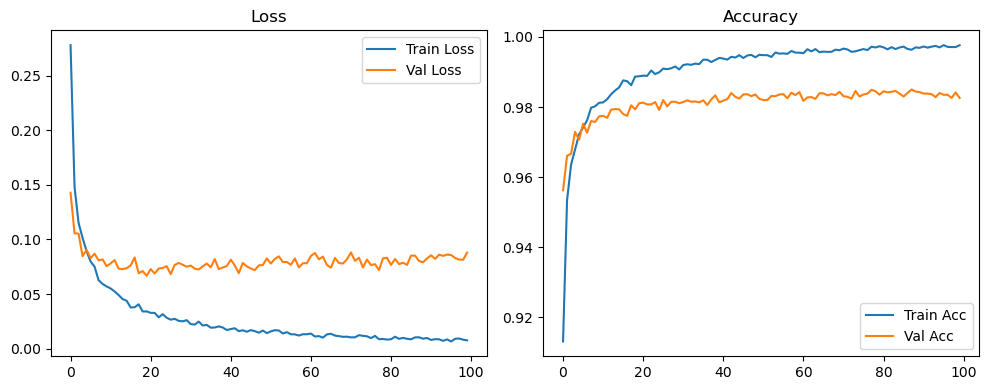

🏆 Best Config: batch128_lr0.01_0.005_0.002_dp0.5 Accuracy: 0.9885


In [8]:
root_path = "MLP_1024_float_regular_SiLU"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)